In [ ]:
!unzip -o evc_mapping_pack.zip


unzip:  cannot find or open evc_mapping_pack.zip, evc_mapping_pack.zip.zip or evc_mapping_pack.zip.ZIP.


In [ ]:
# ======================================================
# RECONSTRUIRE LE PACK EVC MAPPING DIRECTEMENT DANS COLAB
# ======================================================
import os, json, textwrap, zipfile, numpy as np

base = "/content/evc_mapping_pack"
os.makedirs(f"{base}/src", exist_ok=True)
os.makedirs(f"{base}/out", exist_ok=True)

# --- mapping.py ---
mapping_py = """<COLLE_ICI_TOUT_LE_CODE_DE_mapping_py_QUE_JE_T_AI_DONNÉ>"""
# (Pour toi, je peux le renvoyer prêt à copier si tu veux)

# --- cosmo_core.py ---
cosmo_core_py = '''
import numpy as np
def rhoLambda_from_model(z, beta, tau, H0, Omega_m=0.315, rhoLambda0=1.0):
    z = np.asarray(z).astype(float)
    Omega = 1.0 / (H0 * tau)
    delta = beta * H0**2
    return rhoLambda0 * (1.0 + delta * np.cos(Omega * np.log(1.0 + z)))
'''

with open(f"{base}/src/mapping.py","w") as f:
    f.write(mapping_py)
with open(f"{base}/src/cosmo_core.py","w") as f:
    f.write(cosmo_core_py)

# --- Notebook démo ---
notebook = {
 "cells": [
  {"cell_type":"markdown","source":["# EVC Mapping Demo"]},
  {"cell_type":"code","source":[
      "import numpy as np\n",
      "from src.mapping import theory_to_elas, elas_to_theory, calibrate_Cdelta_COmega\n",
      "from src.cosmo_core import rhoLambda_from_model\n",
      "print('Imports OK')"
  ]},
  {"cell_type":"code","source":[
      "H0=1.0; beta=0.17; tau=1/0.3\n",
      "delta,Omega,phi = theory_to_elas(beta,tau,H0)\n",
      "print(delta,Omega,phi)"
  ]}
 ],
 "metadata":{"kernelspec":{"display_name":"Python 3","name":"python3"}}, "nbformat":4, "nbformat_minor":5
}
with open(f"{base}/run_demo.ipynb","w") as f:
    json.dump(notebook,f)

print("✅ Pack créé dans /content/evc_mapping_pack")


✅ Pack créé dans /content/evc_mapping_pack


In [ ]:
!ls /content/evc_mapping_pack/src


cosmo_core.py  mapping.py


In [ ]:
!jupyter nbconvert --to notebook /content/evc_mapping_pack/run_demo.ipynb


[NbConvertApp] Converting notebook /content/evc_mapping_pack/run_demo.ipynb to notebook
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                        ^^^^^^^^^^^^^^^^

In [ ]:
# === Colab: création + test EVC/ELAS (corrigée import src) ===
import os, zipfile, numpy as np, sys

base = "/content/evc_mapping_pack"
os.makedirs(f"{base}/src", exist_ok=True)
os.makedirs(f"{base}/out", exist_ok=True)

# === Ajoute le dossier 'src' au chemin Python ===
sys.path.append(f"{base}/src")

# -------- src/mapping.py --------
mapping_py = r"""
import math
import numpy as np

def theory_to_elas(beta, tau, H0, C_delta=1.0, C_Omega=1.0, phi0=0.0):
    assert beta > 0 and tau > 0 and H0 > 0
    delta = C_delta * beta * H0**2
    Omega = C_Omega / (H0 * tau)
    phi = phi0
    return delta, Omega, phi

def elas_to_theory(delta, Omega, H0, C_delta=1.0, C_Omega=1.0):
    assert delta >= 0 and Omega > 0 and H0 > 0
    beta = delta / (C_delta * H0**2)
    tau  = C_Omega / (H0 * Omega)
    return beta, tau

def alpha_from_beta_tau(beta, tau):
    return beta / (tau**2)

def sigma_beta_from_sigma_delta(sigma_delta, H0, C_delta=1.0):
    return sigma_delta / (C_delta * H0**2)

def sigma_tau_from_sigma_Omega(Omega, sigma_Omega, H0, C_Omega=1.0):
    return (C_Omega / H0) * (sigma_Omega / (Omega**2))

def sigma_alpha_from(sig_beta, beta, sig_tau, tau, corr_beta_tau=0.0):
    rel2 = (sig_beta/beta)**2 + 4*(sig_tau/tau)**2 - 4*corr_beta_tau*(sig_beta/beta)*(sig_tau/tau)
    rel2 = max(rel2, 0.0)
    return (beta/(tau**2)) * math.sqrt(rel2)

def calibrate_Cdelta_COmega(beta, tau, H0, z_grid, rhoLambda_from_model):
    '''
    Fit ELAS ansatz:
      rhoL(z) ≈ rho0 * [1 + delta * cos(Omega * ln(1+z) + phi)]
    Returns C_delta = delta_num / (beta H0^2),
             C_Omega = Omega_num * (H0 * tau)
    '''
    z = np.asarray(z_grid).astype(float)
    rho = np.asarray(rhoLambda_from_model(z)).astype(float)
    if rho.ndim != 1 or rho.shape[0] != z.shape[0]:
        raise ValueError("rhoLambda_from_model(z) must return 1D array same length as z_grid.")
    idx0 = np.where(z <= 0.02)[0]
    rho0 = rho[idx0].mean() if len(idx0) > 0 else rho[0]
    y = rho / rho0 - 1.0
    Omegas = np.linspace(0.10, 3.00, 120)
    best = (1e99, None)
    ln1pz = np.log(1.0 + z)
    for Om in Omegas:
        Xc = np.cos(Om * ln1pz)
        Xs = np.sin(Om * ln1pz)
        A = np.vstack([Xc, Xs]).T
        coef, *_ = np.linalg.lstsq(A, y, rcond=None)
        a, b = coef
        y_hat = a*Xc + b*Xs
        err = float(np.mean((y - y_hat)**2))
        if err < best[0]:
            best = (err, (Om, a, b))
    Om_best, a_best, b_best = best[1]
    delta_num = float(np.hypot(a_best, b_best))
    Omega_num = float(Om_best)
    C_delta = delta_num / (beta * H0**2)
    C_Omega = Omega_num * (H0 * tau)
    import math as _m
    phi_est = float(_m.atan2(b_best, a_best))
    return float(C_delta), float(C_Omega), {"delta":delta_num,"Omega":Omega_num,"phi":phi_est}
"""

with open(f"{base}/src/mapping.py","w") as f:
    f.write(mapping_py)

# -------- src/cosmo_core.py --------
cosmo_core_py = r"""
import numpy as np
def rhoLambda_from_model(z, beta, tau, H0, Omega_m=0.315, rhoLambda0=1.0):
    z = np.asarray(z).astype(float)
    Omega = 1.0 / (H0 * tau)
    delta = beta * H0**2
    return rhoLambda0 * (1.0 + delta * np.cos(Omega * np.log(1.0 + z)))
"""
with open(f"{base}/src/cosmo_core.py","w") as f:
    f.write(cosmo_core_py)

print("✅ Fichiers créés:", os.listdir(f"{base}/src"))

# -------- Test direct --------
from mapping import (
    theory_to_elas, elas_to_theory, alpha_from_beta_tau,
    sigma_beta_from_sigma_delta, sigma_tau_from_sigma_Omega, sigma_alpha_from,
    calibrate_Cdelta_COmega
)
from cosmo_core import rhoLambda_from_model

H0 = 1.0
beta = 0.17
tau  = 1.0 / 0.30

delta, Omega, phi = theory_to_elas(beta, tau, H0)
print(f"[theory->elas] delta={delta:.3f}  Omega={Omega:.3f}  phi={phi:.3f}")

z = np.linspace(0.0, 2.0, 300)
model_rho = lambda zz: rhoLambda_from_model(zz, beta=beta, tau=tau, H0=H0)
C_delta, C_Omega, fit = calibrate_Cdelta_COmega(beta, tau, H0, z, model_rho)
print(f"[calibration] C_delta={C_delta:.3f}  C_Omega={C_Omega:.3f}")
print(f"[fit params] delta={fit['delta']:.3f}  Omega={fit['Omega']:.3f}  phi={fit['phi']:.3f}")

delta2, Omega2, phi2 = theory_to_elas(beta, tau, H0, C_delta=C_delta, C_Omega=C_Omega)
beta2,  tau2  = elas_to_theory(delta2, Omega2, H0, C_delta=C_delta, C_Omega=C_Omega)
print(f"[theory->elas calibrated] delta={delta2:.3f}  Omega={Omega2:.3f}")
print(f"[elas->theory] beta={beta2:.3f}  tau={tau2:.3f}")

sigma_delta = 0.015
sigma_Omega = 0.05
sig_beta = sigma_beta_from_sigma_delta(sigma_delta, H0, C_delta=C_delta)
sig_tau  = sigma_tau_from_sigma_Omega(Omega2, sigma_Omega, H0, C_Omega=C_Omega)
sig_alpha = sigma_alpha_from(sig_beta, beta2, sig_tau, tau2)
print(f"[errors] sigma_beta={sig_beta:.4f}  sigma_tau={sig_tau:.4f}  sigma_alpha={sig_alpha:.4f}")

# Zip pour sauvegarde
zip_path = "/content/evc_mapping_pack.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(base):
        for file in files:
            p = os.path.join(root, file)
            zf.write(p, arcname=os.path.relpath(p, start="/content"))
print("📦 ZIP prêt:", zip_path)


✅ Fichiers créés: ['mapping.py', 'cosmo_core.py']
[theory->elas] delta=0.170  Omega=0.300  phi=0.000
[calibration] C_delta=0.450  C_Omega=0.333
[fit params] delta=0.076  Omega=0.100  phi=-1.550
[theory->elas calibrated] delta=0.076  Omega=0.100
[elas->theory] beta=0.170  tau=3.333
[errors] sigma_beta=0.0333  sigma_tau=1.6667  sigma_alpha=0.0156
📦 ZIP prêt: /content/evc_mapping_pack.zip


In [ ]:
import numpy as np, math, sys, os

# Assure que le module est visible
base = "/content/evc_mapping_pack"
sys.path.append(f"{base}/src")

# --- Remplace la calibration par une version à fenêtre centrée + raffinement ---
from importlib import reload
import mapping as mp
reload(mp)

def calibrate_Cdelta_COmega_windowed(beta, tau, H0, z_grid, rhoLambda_from_model,
                                     window_frac=0.5, n_coarse=2000, n_refine=3, refine_factor=8):
    """
    Calibre C_delta et C_Omega en ciblant une fenêtre autour d'Ω0 = 1/(H0*tau).
    window_frac=0.5 -> recherche dans [Ω0*(1-0.5), Ω0*(1+0.5)] = ±50%.
    n_coarse: résolution initiale, n_refine: nb de raffinement, refine_factor: zoom par raffinement.
    """
    z = np.asarray(z_grid).astype(float)
    rho = np.asarray(rhoLambda_from_model(z)).astype(float)
    assert rho.shape == z.shape

    # normalisation autour de z~0
    idx0 = np.where(z <= 0.02)[0]
    rho0 = rho[idx0].mean() if len(idx0)>0 else rho[0]
    y = rho/rho0 - 1.0
    ln1pz = np.log(1.0 + z)

    # Fenêtre d'Ω autour de Ω0
    Omega0 = 1.0/(H0*tau)
    Om_lo  = max(0.05, Omega0*(1.0 - window_frac))
    Om_hi  = Omega0*(1.0 + window_frac)

    # Fonction d'erreur pour un Ω donné (fit linéaire sur cos/sin)
    def err_for_Om(Om):
        Xc = np.cos(Om*ln1pz)
        Xs = np.sin(Om*ln1pz)
        A  = np.vstack([Xc, Xs]).T
        coef, *_ = np.linalg.lstsq(A, y, rcond=None)
        a, b = coef
        y_hat = a*Xc + b*Xs
        err = float(np.mean((y - y_hat)**2))
        return err, a, b

    # Recherche grossière
    Omegas = np.linspace(Om_lo, Om_hi, n_coarse)
    errs = []
    for Om in Omegas:
        e, a, b = err_for_Om(Om)
        errs.append((e, Om, a, b))
    errs.sort(key=lambda t: t[0])
    best_err, best_Om, best_a, best_b = errs[0]

    # Raffinements successifs
    for _ in range(n_refine):
        half = (Om_hi - Om_lo)/(2*refine_factor)
        Om_lo = max(0.01, best_Om - (Om_hi - Om_lo)/refine_factor)
        Om_hi = best_Om + (Om_hi - Om_lo)/refine_factor
        Omegas = np.linspace(Om_lo, Om_hi, n_coarse//refine_factor)
        for Om in Omegas:
            e, a, b = err_for_Om(Om)
            if e < best_err:
                best_err, best_Om, best_a, best_b = e, Om, a, b

    delta_num = float(np.hypot(best_a, best_b))
    Omega_num = float(best_Om)
    C_delta = delta_num / (beta * H0**2)
    C_Omega = Omega_num * (H0 * tau)
    phi_est = float(math.atan2(best_b, best_a))
    return float(C_delta), float(C_Omega), {"delta":delta_num,"Omega":Omega_num,"phi":phi_est}

# === Recalibration avec fenêtre centrée sur Ω0 ===
from cosmo_core import rhoLambda_from_model

H0 = 1.0
beta = 0.17
tau  = 1.0/0.30

z = np.linspace(0.0, 2.0, 2000)   # grille plus dense pour meilleure résolution
model_rho = lambda zz: rhoLambda_from_model(zz, beta=beta, tau=tau, H0=H0)

C_delta2, C_Omega2, fit2 = calibrate_Cdelta_COmega_windowed(
    beta, tau, H0, z, model_rho,
    window_frac=0.6,  # ±60% autour de Ω0 (robuste)
    n_coarse=3000,    # résolution haute
    n_refine=3,       # 3 zooms
    refine_factor=10  # zoom x10 à chaque étape
)

print("[RE-CALIB] C_delta=%.3f  C_Omega=%.3f" % (C_delta2, C_Omega2))
print("[RE-CALIB fit] delta=%.3f  Omega=%.3f  phi=%.3f" % (fit2["delta"], fit2["Omega"], fit2["phi"]))

# Vérifie le mapping recalibré
delta2, Omega2, _ = mp.theory_to_elas(beta, tau, H0, C_delta=C_delta2, C_Omega=C_Omega2)
beta2,  tau2  = mp.elas_to_theory(delta2, Omega2, H0, C_delta=C_delta2, C_Omega=C_Omega2)
print("[mapping after re-calib] delta=%.3f Omega=%.3f  |  beta=%.3f tau=%.3f" % (delta2, Omega2, beta2, tau2))


[RE-CALIB] C_delta=0.601  C_Omega=0.250
[RE-CALIB fit] delta=0.102  Omega=0.075  phi=-1.555
[mapping after re-calib] delta=0.102 Omega=0.075  |  beta=0.170 tau=3.333


In [ ]:
import numpy as np, sys, math
base = "/content/evc_mapping_pack"
sys.path.append(f"{base}/src")

from mapping import theory_to_elas, elas_to_theory
from cosmo_core import rhoLambda_from_model

# --- Calibration verrouillée en fréquence (Ω fixé à Ω0) ---
def calibrate_locked_frequency(beta, tau, H0, z_grid, rhoLambda_from_model):
    """
    Fixe Omega=Omega0=1/(H0*tau), ajuste a,b dans y ≈ a*cos(Ω0 ln(1+z)) + b*sin(Ω0 ln(1+z)),
    en déduit delta_num = sqrt(a^2+b^2) et phi = atan2(b,a).
    Renvoie C_delta, C_Omega (=1 par construction), et les params ajustés.
    """
    z = np.asarray(z_grid).astype(float)
    rho = np.asarray(rhoLambda_from_model(z)).astype(float)
    assert rho.shape == z.shape
    # normalisation autour de z ~ 0
    idx0 = np.where(z <= 0.02)[0]
    rho0 = rho[idx0].mean() if len(idx0)>0 else rho[0]
    y = rho/rho0 - 1.0

    Omega0 = 1.0/(H0*tau)
    ln1pz = np.log(1.0 + z)
    Xc = np.cos(Omega0 * ln1pz)
    Xs = np.sin(Omega0 * ln1pz)
    A  = np.vstack([Xc, Xs]).T
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    a, b = coef
    delta_num = float(np.hypot(a, b))
    phi_est   = float(math.atan2(b, a))

    # C_delta et C_Omega
    C_delta = delta_num / (beta * H0**2)
    C_Omega = 1.0  # par définition, on a fixé Ω = Ω0
    return C_delta, C_Omega, {"delta":delta_num, "Omega":float(Omega0), "phi":phi_est}

# === Test sur ton cas ===
H0 = 1.0
beta = 0.17
tau  = 1.0/0.30

# Grille z relativement dense (même si z<=2 reste une petite fenêtre en ln(1+z))
z = np.linspace(0.0, 2.0, 2000)
model_rho = lambda zz: rhoLambda_from_model(zz, beta=beta, tau=tau, H0=H0)

C_delta_lock, C_Omega_lock, fit_lock = calibrate_locked_frequency(beta, tau, H0, z, model_rho)
print("[LOCK] C_delta=%.3f  C_Omega=%.3f" % (C_delta_lock, C_Omega_lock))
print("[LOCK fit] delta=%.3f  Omega=%.3f  phi=%.3f" % (fit_lock["delta"], fit_lock["Omega"], fit_lock["phi"]))

# Vérification mapping avec ces C
d2, Om2, _ = theory_to_elas(beta, tau, H0, C_delta=C_delta_lock, C_Omega=C_Omega_lock)
b2, t2    = elas_to_theory(d2, Om2, H0, C_delta=C_delta_lock, C_Omega=C_Omega_lock)
print("[mapping with LOCK] delta=%.3f Omega=%.3f  |  beta=%.3f tau=%.3f" % (d2, Om2, b2, t2))


[LOCK] C_delta=0.151  C_Omega=1.000
[LOCK fit] delta=0.026  Omega=0.300  phi=-1.507
[mapping with LOCK] delta=0.026 Omega=0.300  |  beta=0.170 tau=3.333


In [ ]:
import numpy as np, sys, math

base = "/content/evc_mapping_pack"
sys.path.append(f"{base}/src")

from cosmo_core import rhoLambda_from_model
from mapping import theory_to_elas, elas_to_theory

def calibrate_locked_frequency_with_intercept(beta, tau, H0, z_grid, rhoLambda_from_model):
    """
    Fixe Ω = Ω0 = 1/(H0*tau), mais AJOUTE un intercept (constante) dans la régression:
        y ≈ c0*1 + a*cos(Ω0 ln(1+z)) + b*sin(Ω0 ln(1+z))
    Normalisation: y = rho / mean(rho) - 1  (centrage relatif autour de la moyenne)
    -> delta_num = sqrt(a^2 + b^2), phi = atan2(b, a).
    Renvoie C_delta, C_Omega (==1), et les paramètres ajustés.
    """
    z = np.asarray(z_grid).astype(float)
    rho = np.asarray(rhoLambda_from_model(z)).astype(float)
    assert rho.shape == z.shape

    # centrage relatif autour de la moyenne sur la fenêtre (plus robuste que z~0)
    rho_mean = float(rho.mean())
    y = rho / rho_mean - 1.0

    Omega0 = 1.0/(H0*tau)
    ln1pz = np.log(1.0 + z)

    X0 = np.ones_like(z)
    Xc = np.cos(Omega0 * ln1pz)
    Xs = np.sin(Omega0 * ln1pz)
    A  = np.vstack([X0, Xc, Xs]).T  # <-- intercept inclus

    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    c0, a, b = coef
    delta_num = float(np.hypot(a, b))
    phi_est   = float(math.atan2(b, a))

    # C_delta et C_Omega
    C_delta = delta_num / (beta * H0**2)
    C_Omega = 1.0  # Ω verrouillée
    return float(C_delta), float(C_Omega), {"delta":delta_num, "Omega":float(Omega0), "phi":phi_est, "c0":float(c0)}

# === Test sur ton cas ===
H0 = 1.0
beta = 0.17
tau  = 1.0/0.30

z = np.linspace(0.0, 2.0, 4000)   # grille dense pour précision
model_rho = lambda zz: rhoLambda_from_model(zz, beta=beta, tau=tau, H0=H0)

C_delta_lock2, C_Omega_lock2, fit_lock2 = calibrate_locked_frequency_with_intercept(beta, tau, H0, z, model_rho)
print("[LOCK+INTERCEPT] C_delta=%.3f  C_Omega=%.3f" % (C_delta_lock2, C_Omega_lock2))
print("[LOCK+INTERCEPT fit] delta=%.3f  Omega=%.3f  phi=%.3f  c0=%.4f" %
      (fit_lock2["delta"], fit_lock2["Omega"], fit_lock2["phi"], fit_lock2["c0"]))

# Vérification mapping avec ces C
d2, Om2, _ = theory_to_elas(beta, tau, H0, C_delta=C_delta_lock2, C_Omega=C_Omega_lock2)
b2,  t2    = elas_to_theory(d2, Om2, H0, C_delta=C_delta_lock2, C_Omega=C_Omega_lock2)
print("[mapping with LOCK+INTERCEPT] delta=%.3f  Omega=%.3f  |  beta=%.3f  tau=%.3f" % (d2, Om2, b2, t2))


[LOCK+INTERCEPT] C_delta=0.858  C_Omega=1.000
[LOCK+INTERCEPT fit] delta=0.146  Omega=0.300  phi=0.000  c0=-0.1424
[mapping with LOCK+INTERCEPT] delta=0.146  Omega=0.300  |  beta=0.170  tau=3.333


In [ ]:
import numpy as np, sys, math

base = "/content/evc_mapping_pack"
sys.path.append(f"{base}/src")

from cosmo_core import rhoLambda_from_model
from mapping import theory_to_elas, elas_to_theory

def _gram_schmidt(A, w=None):
    """
    Orthonormalise les colonnes de A (N x p) selon le produit scalaire pondéré <u,v> = sum w*u*v.
    Retourne Q (N x p) et les coefficients de projection (pour debug si besoin).
    """
    A = np.asarray(A, float)
    N, p = A.shape
    if w is None:
        w = np.ones(N)
    w = w.reshape(-1, 1)
    Q = np.zeros_like(A)
    coeffs = []
    for j in range(p):
        v = A[:, j].copy()
        for k in range(j):
            # projection pondérée
            r = np.sum(w[:,0]*Q[:,k]*v) / np.sum(w[:,0]*Q[:,k]*Q[:,k])
            v -= r*Q[:,k]
        # normalisation
        norm2 = np.sum(w[:,0]*v*v)
        if norm2 <= 1e-18:
            Q[:, j] = 0.0
            coeffs.append((j, 'degenerate', 0.0))
            continue
        Q[:, j] = v / np.sqrt(norm2)
        coeffs.append((j, 'ok', np.sqrt(norm2)))
    return Q, coeffs

def calibrate_locked_frequency_orthonormal(beta, tau, H0, z_grid, rhoLambda_from_model,
                                           z_weights='loguniform', extend_to_zmax=2.0):
    """
    Ω verrouillée à Ω0 = 1/(H0*tau).
    Régression pondérée avec intercept + base orthonormalisée:
      y ≈ c0*e0 + a*e1 + b*e2  (e0 ~ 1, e1 ~ cos(Ω0 ln(1+z)), e2 ~ sin(...))
    Normalisation: y = (rho / mean(rho)) - 1 (centrée).
    z_weights:
      - 'loguniform': pondération ~ 1/(1+z) -> à peu près uniforme en ln(1+z)
      - 'uniform'   : aucune pondération
    """
    z = np.asarray(z_grid, float)
    z = z[(z >= 0.0) & (z <= extend_to_zmax)]
    rho = np.asarray(rhoLambda_from_model(z), float)
    assert rho.shape == z.shape

    # centrage relatif autour de la moyenne de la fenêtre
    rho_mean = float(rho.mean())
    y = rho / rho_mean - 1.0

    # poids
    if z_weights == 'loguniform':
        w = 1.0 / (1.0 + z)  # ~ d(ln(1+z))
    else:
        w = np.ones_like(z)

    # base brute
    Omega0 = 1.0/(H0*tau)
    ln1pz = np.log(1.0 + z)
    X0 = np.ones_like(z)
    Xc = np.cos(Omega0 * ln1pz)
    Xs = np.sin(Omega0 * ln1pz)
    A  = np.vstack([X0, Xc, Xs]).T

    # orthonormalisation pondérée
    Q, _ = _gram_schmidt(A, w=w)

    # moindres carrés pondérés dans la base orthonormale
    # solution: coef = <Q, y> (puisque Q^T W Q = I)
    yw = y * w
    a0 = np.sum(Q[:,0]*yw) / np.sum(w*Q[:,0]*Q[:,0])  # ~ intercept
    a1 = np.sum(Q[:,1]*yw) / np.sum(w*Q[:,1]*Q[:,1])
    a2 = np.sum(Q[:,2]*yw) / np.sum(w*Q[:,2]*Q[:,2])

    # reconstruire delta & phi dans la base originale (approx: Q~base orthonormée de [1,cos,sin])
    # amplitude/phase sont invariants à une rotation orthonormale du sous-espace {cos,sin}.
    delta_num = float(np.hypot(a1, a2))
    phi_est   = float(math.atan2(a2, a1))

    # C_delta et C_Omega
    C_delta = delta_num / (beta * H0**2)
    C_Omega = 1.0  # Ω fixé
    return float(C_delta), float(C_Omega), {"delta":delta_num, "Omega":float(Omega0), "phi":phi_est, "c0":float(a0)}

# === Test ===
H0 = 1.0
beta = 0.17
tau  = 1.0/0.30

# Essaie d'abord avec z_max=2, puis z_max=3 si possible (pour gagner de la phase)
for zmax in (2.0, 3.0):
    z = np.linspace(0.0, zmax, 4000)
    model_rho = lambda zz: rhoLambda_from_model(zz, beta=beta, tau=tau, H0=H0)
    C_delta3, C_Omega3, fit3 = calibrate_locked_frequency_orthonormal(
        beta, tau, H0, z, model_rho, z_weights='loguniform', extend_to_zmax=zmax
    )
    print(f"[ORTHO zmax={zmax:.0f}] C_delta={C_delta3:.3f}  C_Omega={C_Omega3:.3f}")
    print(f"[ORTHO fit] delta={fit3['delta']:.3f}  Omega={fit3['Omega']:.3f}  phi={fit3['phi']:.3f}  c0={fit3['c0']:.4f}")

    # mapping check
    d2, Om2, _ = theory_to_elas(beta, tau, H0, C_delta=C_delta3, C_Omega=C_Omega3)
    b2,  t2    = elas_to_theory(d2, Om2, H0, C_delta=C_delta3, C_Omega=C_Omega3)
    print(f"[MAP zmax={zmax:.0f}] delta={d2:.3f}  Omega={Om2:.3f}  |  beta={b2:.3f}  tau={t2:.3f}")


[ORTHO zmax=2] C_delta=0.646  C_Omega=1.000
[ORTHO fit] delta=0.110  Omega=0.300  phi=-0.000  c0=0.0343
[MAP zmax=2] delta=0.110  Omega=0.300  |  beta=0.170  tau=3.333
[ORTHO zmax=3] C_delta=0.941  C_Omega=1.000
[ORTHO fit] delta=0.160  Omega=0.300  phi=-0.000  c0=0.0629
[MAP zmax=3] delta=0.160  Omega=0.300  |  beta=0.170  tau=3.333


In [ ]:
# ==== RESET propre + réécriture des modules + import sans cache ====
import os, sys, shutil, importlib, numpy as np

base = "/content/evc_mapping_pack"
# 1) Reset dossier
if os.path.exists(base):
    shutil.rmtree(base)
os.makedirs(f"{base}/src", exist_ok=True)

# 2) Écrire cosmo_core.py
cosmo_core_code = r"""
import numpy as np
c_km_s = 299792.458  # km/s

def E_LCDM(z, H0_km_s_Mpc, Omega_m):
    z = np.asarray(z, float)
    Om = Omega_m
    Ol = 1.0 - Om
    return np.sqrt(Om*(1+z)**3 + Ol)

def E_ELAS(z, H0_km_s_Mpc, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, float)
    Om = Omega_m
    Ol = 1.0 - Om
    mod = 1.0 + delta * np.cos(Omega_log*np.log(1.0+z) + phi)
    return np.sqrt(Om*(1+z)**3 + Ol*mod)

def comoving_distance(z, H0_km_s_Mpc, E_func, **E_kwargs):
    z = np.asarray(z, float)
    zsort = np.sort(z)
    Ez = E_func(zsort, H0_km_s_Mpc, **E_kwargs)
    integ = np.trapz(1.0 / np.maximum(Ez, 1e-15), zsort)
    DM = (c_km_s / H0_km_s_Mpc) * integ  # Mpc
    return float(DM) if np.ndim(z) == 0 else DM

def D_M(z, H0_km_s_Mpc, E_func, **E_kwargs):
    z_arr = np.atleast_1d(z).astype(float)
    out = []
    for zi in z_arr:
        zg = np.linspace(0.0, float(zi), 2000)
        out.append(comoving_distance(zg, H0_km_s_Mpc, E_func, **E_kwargs))
    return np.array(out) if len(out)>1 else out[0]

def D_H(z, H0_km_s_Mpc, E_func, **E_kwargs):
    z = np.asarray(z, float)
    Ez = E_func(z, H0_km_s_Mpc, **E_kwargs)
    return (c_km_s / H0_km_s_Mpc) / np.maximum(Ez, 1e-15)

def D_L(z, H0_km_s_Mpc, E_func, **E_kwargs):
    z = np.asarray(z, float)
    return (1.0 + z) * D_M(z, H0_km_s_Mpc, E_func, **E_kwargs)
"""
open(f"{base}/src/cosmo_core.py","w").write(cosmo_core_code)

# 3) Écrire observables.py
observables_code = r"""
import numpy as np
from cosmo_core import D_M, D_H, D_L

def D_V(z, H0, E_func, **E_kwargs):
    z = np.asarray(z, float)
    DH = D_H(z, H0, E_func, **E_kwargs)
    DM = D_M(z, H0, E_func, **E_kwargs)
    return (z * DH * (DM**2))**(1.0/3.0)

def Dm_over_rd(z, H0, rd, E_func, **E_kwargs):
    return D_M(z, H0, E_func, **E_kwargs) / rd

def Dh_over_rd(z, H0, rd, E_func, **E_kwargs):
    return D_H(z, H0, E_func, **E_kwargs) / rd

def rd_over_DV(z, H0, rd, E_func, **E_kwargs):
    return rd / D_V(z, H0, E_func, **E_kwargs)

def mu_theory(z, H0, E_func, **E_kwargs):
    DL = D_L(z, H0, E_func, **E_kwargs)
    return 5.0 * np.log10(np.maximum(DL, 1e-30)) + 25.0
"""
open(f"{base}/src/observables.py","w").write(observables_code)

# 4) Écrire likelihoods.py
likes_code = r"""
import numpy as np

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    mu_obs = np.asarray(mu_obs, float)
    sigma_mu = np.asarray(sigma_mu, float)
    mu_th = np.asarray(mu_th, float)
    w = 1.0 / np.maximum(sigma_mu, 1e-20)**2
    r = mu_obs - mu_th
    a = np.sum(w * r * r)
    b = np.sum(w * r)
    c = np.sum(w)
    return float(a - b*b/c)

def is_spd(M):
    try:
        w = np.linalg.eigvalsh((M+M.T)/2.0)
        return np.all(w > 0.0)
    except:
        return False

def chi2_bao(y_obs, cov, y_th):
    y_obs = np.asarray(y_obs, float)
    y_th = np.asarray(y_th, float)
    C = np.array(cov, float)
    C = (C + C.T)/2.0
    if not is_spd(C):
        raise ValueError("Covariance not SPD.")
    Ci = np.linalg.inv(C)
    d = (y_obs - y_th).reshape(-1,1)
    return float(d.T @ Ci @ d)
"""
open(f"{base}/src/likelihoods.py","w").write(likes_code)

# 5) Nettoyer les caches d'import et réimporter
sys.path.insert(0, f"{base}/src")
importlib.invalidate_caches()
for m in ["cosmo_core","observables","likelihoods"]:
    if m in sys.modules:
        del sys.modules[m]

import cosmo_core, observables, likelihoods
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd
from likelihoods import chi2_sn_marg, chi2_bao

print("✅ Modules importés:", os.listdir(f"{base}/src"))

# 6) Test rapide
H0 = 73.0
Om = 0.315
delta, Omeg, phi = 0.16, 0.30, 0.0
rd = 147.09

z_sn = np.array([0.05, 0.3, 0.8])
mu_obs = mu_theory(z_sn, H0, E_LCDM, Omega_m=Om)
sigma_mu = np.array([0.12, 0.12, 0.12])
mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
chi2_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_el)

z_bao = np.array([0.38, 0.61])
y_obs = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_LCDM, Omega_m=Om),
    Dh_over_rd(z_bao[1], H0, rd, E_LCDM, Omega_m=Om)
])
cov = np.diag([0.02**2, 0.03**2])
y_th = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi),
    Dh_over_rd(z_bao[1], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
])
chi2_b = chi2_bao(y_obs, cov, y_th)

print("✅ N1/N2 OK")
print("  SN χ² =", round(chi2_sn, 6))
print("  BAO χ² =", round(chi2_b, 6))


✅ Modules importés: ['cosmo_core.py', 'observables.py', '__pycache__', 'likelihoods.py']
✅ N1/N2 OK
  SN χ² = 0.036394
  BAO χ² = 713.525352


In [ ]:
# Construire y_obs AVEC LE MÊME MODELE que y_th (LCDM), donc χ²≈0 attendu
z_bao = np.array([0.38, 0.61])
rd    = 147.09
H0, Om = 73.0, 0.315

# Observables: dm/rd et dh/rd au même z que ci-dessus
y_obs = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_LCDM, Omega_m=Om),
    Dh_over_rd(z_bao[1], H0, rd, E_LCDM, Omega_m=Om)
])

# Covariance jouet "raisonnable" (incertitudes 3–5%)
cov = np.diag([ (0.05*y_obs[0])**2, (0.05*y_obs[1])**2 ])

# Théorie identique (LCDM) -> chi2 ≈ 0
y_th = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_LCDM, Omega_m=Om),
    Dh_over_rd(z_bao[1], H0, rd, E_LCDM, Omega_m=Om)
])
print("BAO χ² LCDM vs LCDM =", chi2_bao(y_obs, cov, y_th))


BAO χ² LCDM vs LCDM = 0.0


In [ ]:
delta, Omeg, phi = 0.16, 0.30, 0.0

y_th_elas = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi),
    Dh_over_rd(z_bao[1], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
])

# erreurs 5% (jouet). Ajuste à 2–3% si tu veux être plus strict.
cov = np.diag([ (0.05*y_obs[0])**2, (0.05*y_obs[1])**2 ])

print("BAO χ² LCDM(obs) vs ELAS(th) =", chi2_bao(y_obs, cov, y_th_elas))


BAO χ² LCDM(obs) vs ELAS(th) = 0.9963793402628356


In [ ]:
import numpy as np
from cosmo_core import E_LCDM, E_ELAS
from observables import Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_bao

H0 = 73.0
Om = 0.315
rd = 147.09

# --- 1) BAO: test de cohérence interne (LCDM vs LCDM) ---
z_bao = np.array([0.38, 0.61])
y_obs = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_LCDM, Omega_m=Om),
    Dh_over_rd(z_bao[1], H0, rd, E_LCDM, Omega_m=Om)
])
# 5% d'erreur relative (jouet réaliste)
cov = np.diag([ (0.05*y_obs[0])**2, (0.05*y_obs[1])**2 ])

y_th_lcdm = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_LCDM, Omega_m=Om),
    Dh_over_rd(z_bao[1], H0, rd, E_LCDM, Omega_m=Om)
])
print("LCDM vs LCDM  χ² =", round(chi2_bao(y_obs, cov, y_th_lcdm), 6))  # ~ 0

# --- 2) ELAS vs LCDM (mêmes observables) ---
delta, Omeg, phi = 0.16, 0.30, 0.0
y_th_elas = np.array([
    Dm_over_rd(z_bao[0], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi),
    Dh_over_rd(z_bao[1], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
])
print("LCDM(obs) vs ELAS(th) χ² (5% errors) =", round(chi2_bao(y_obs, cov, y_th_elas), 3))

# --- 3) Utilitaire: calcule χ² BAO pour un jeu d'observables choisi ---
def bao_chi2_generic(z_list, which_list,  # ex: z_list=[0.38,0.61], which_list=["DM/rd","DH/rd"]
                      model, model_kwargs, rd, frac_err=0.05):
    """
    which_list: liste de strings parmi {"DM/rd","DH/rd","rd/DV"}
    model: E_LCDM ou E_ELAS
    model_kwargs: dict pour le modèle, ex {"Omega_m":0.315} ou {"Omega_m":..., "delta":..., "Omega_log":..., "phi":...}
    frac_err: erreur relative (cov diag jouet)
    """
    vals = []
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":
            vals.append(Dm_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="DH/rd":
            vals.append(Dh_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="rd/DV":
            vals.append(rd_over_DV(z, H0, rd, model, **model_kwargs))
        else:
            raise ValueError(f"type inconnu: {w}")
    vals = np.array(vals, float)
    cov = np.diag( (frac_err*vals)**2 )
    return vals, cov

# Exemple: construire y_obs et cov en LCDM, puis comparer ELAS
zlist  = [0.38, 0.61]
wlist  = ["DM/rd","DH/rd"]
y_obs2, cov2 = bao_chi2_generic(zlist, wlist, E_LCDM, {"Omega_m":Om}, rd, frac_err=0.05)
y_th2        = np.array([
    Dm_over_rd(zlist[0], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi),
    Dh_over_rd(zlist[1], H0, rd, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
])
print("Generic χ² (LCDM obs vs ELAS th) =", round(chi2_bao(y_obs2, cov2, y_th2), 3))


LCDM vs LCDM  χ² = 0.0
LCDM(obs) vs ELAS(th) χ² (5% errors) = 0.996
Generic χ² (LCDM obs vs ELAS th) = 0.996


In [ ]:
# === N3: scan de paramètres ELAS, Δχ², AIC/BIC (SN+BAO) ===
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_sn_marg, chi2_bao

# ------------------------------
# 1) Prépare tes "vraies" données ICI
# ------------------------------
# SN (remplacer par Pantheon+)
z_sn      = np.array([0.05, 0.30, 0.80])
mu_obs    = np.array([36.9, 40.7, 43.3])   # EXEMPLE jouet: remplace par mu_i réels
sigma_mu  = np.array([0.12, 0.12, 0.12])   # EXEMPLE jouet: remplace par erreurs réelles

# BAO (remplacer par tes 7 points et la covariance SPD NxN)
# Choisis une base et garde-la partout (ex: ["DM/rd","DH/rd","rd/DV", ...] dans cet ordre)
z_bao   = np.array([0.38, 0.61])           # EXEMPLE jouet
which   = ["DM/rd","DH/rd"]                # EXEMPLE jouet: ordre des obs
H0      = 73.0
Om      = 0.315
rd      = 147.09

# y_obs construit sous LCDM (EXEMPLE jouet). Remplace par tes vraies mesures publiées.
def build_vector(z_list, which_list, model, model_kwargs, H0, rd):
    vals = []
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":
            vals.append(Dm_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="DH/rd":
            vals.append(Dh_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="rd/DV":
            vals.append(rd_over_DV(z, H0, rd, model, **model_kwargs))
        else:
            raise ValueError(f"Obs inconnue: {w}")
    return np.array(vals, float)

y_obs = build_vector(z_bao, which, E_LCDM, {"Omega_m":Om}, H0, rd)

# Covariance EXEMPLE: diag 5% → remplace par la matrice officielle SPD (N×N)
cov = np.diag((0.05*y_obs)**2)

# ------------------------------
# 2) Fonctions χ²
# ------------------------------
def chi2_bao_model(delta, Omeg, phi):
    y_th = build_vector(z_bao, which, E_ELAS,
                        {"Omega_m":Om, "delta":delta, "Omega_log":Omeg, "phi":phi},
                        H0, rd)
    return chi2_bao(y_obs, cov, y_th)

def chi2_sn_model(delta, Omeg, phi):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
    return chi2_sn_marg(mu_obs, sigma_mu, mu_th)

def chi2_tot(delta, Omeg, phi):
    return chi2_sn_model(delta, Omeg, phi) + chi2_bao_model(delta, Omeg, phi)

def chi2_lcdm():
    mu_lcdm = mu_theory(z_sn, H0, E_LCDM, Omega_m=Om)
    chi2_sn_l = chi2_sn_marg(mu_obs, sigma_mu, mu_lcdm)
    y_th_l    = build_vector(z_bao, which, E_LCDM, {"Omega_m":Om}, H0, rd)
    chi2_b_l  = chi2_bao(y_obs, cov, y_th_l)
    return chi2_sn_l + chi2_b_l

# ------------------------------
# 3) Grille de scan (coarse → rapide)
#    Ajuste les bornes selon tes résultats
# ------------------------------
grid_delta = np.linspace(0.00, 0.30, 31)
grid_Omeg  = np.linspace(0.10, 0.60, 26)
grid_phi   = np.linspace(-math.pi, math.pi, 37)

best = (1e99, None)
for d in grid_delta:
    for Omg in grid_Omeg:
        # Astuce: on peut maximiser sur phi analytiquement en base cos/sin pour les BAO uniquement,
        # mais ici on garde simple (scan).
        for ph in grid_phi:
            chi = chi2_tot(d, Omg, ph)
            if chi < best[0]:
                best = (chi, (d, Omg, ph))

chi2_min, (d_best, Om_best, ph_best) = best
chi2_l   = chi2_lcdm()
dchi2    = chi2_l - chi2_min

# ------------------------------
# 4) AIC / BIC
# ------------------------------
# k_LCDM = 1 param libre (Omega_m) dans ce jouet; k_ELAS = k_LCDM + 3 (delta, Omega_log, phi)
# N = N_SN + N_BAO  (nombre de points indépendants)
k_LCDM = 1
k_ELAS = 4
N = len(z_sn) + len(z_bao)  # remplace par N_effectif (ex: 1701 + 7)
AIC_LCDM = chi2_l + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_l + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("=== Résultats N3 (jouet / à remplacer par vraies données) ===")
print(f"LCDM χ²_total = {chi2_l:.3f}")
print(f"ELAS χ²_min   = {chi2_min:.3f}  (δ={d_best:.3f}, Ω_log={Om_best:.3f}, φ={ph_best:.3f} rad)")
print(f"Δχ² (LCDM−ELAS) = {dchi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")


=== Résultats N3 (jouet / à remplacer par vraies données) ===
LCDM χ²_total = 6.959
ELAS χ²_min   = 6.190  (δ=0.300, Ω_log=0.600, φ=-1.920 rad)
Δχ² (LCDM−ELAS) = 0.769
AIC: LCDM=8.959  ELAS=14.190  → ΔAIC=-5.231
BIC: LCDM=8.568  ELAS=12.628  → ΔBIC=-4.059


In [ ]:
# === N3 élargi: scan (δ, Ω, φ), Δχ², AIC/BIC, détection de bords ===
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_sn_marg, chi2_bao

# ---------- 1) Données (remplacer par vraies) ----------
# SN (jouet) — remplace par Pantheon+
z_sn      = np.array([0.05, 0.30, 0.80])
mu_obs    = np.array([36.9, 40.7, 43.3])
sigma_mu  = np.array([0.12, 0.12, 0.12])

# BAO (jouet) — remplace par tes mesures + COV SPD
z_bao   = np.array([0.38, 0.61])
which   = ["DM/rd","DH/rd"]  # garde un ordre unique
H0, Om  = 73.0, 0.315
rd      = 147.09

def build_vector(z_list, which_list, model, model_kwargs):
    out = []
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":
            out.append(Dm_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="DH/rd":
            out.append(Dh_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="rd/DV":
            out.append(rd_over_DV(z, H0, rd, model, **model_kwargs))
        else:
            raise ValueError(f"Obs inconnue: {w}")
    return np.array(out, float)

# y_obs et covariance (jouet 5%) — remplace par tes vraies colonnes + matrice
y_obs = build_vector(z_bao, which, E_LCDM, {"Omega_m":Om})
cov   = np.diag((0.05*y_obs)**2)

# ---------- 2) fonctions χ² ----------
def chi2_bao_model(d,O,ph):
    y_th = build_vector(z_bao, which, E_ELAS,
                        {"Omega_m":Om,"delta":d,"Omega_log":O,"phi":ph})
    return chi2_bao(y_obs, cov, y_th)

def chi2_sn_model(d,O,ph):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Om, delta=d, Omega_log=O, phi=ph)
    return chi2_sn_marg(mu_obs, sigma_mu, mu_th)

def chi2_tot(d,O,ph):
    return chi2_sn_model(d,O,ph) + chi2_bao_model(d,O,ph)

def chi2_lcdm():
    mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Om)
    c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_l)
    y_l  = build_vector(z_bao, which, E_LCDM, {"Omega_m":Om})
    c_b  = chi2_bao(y_obs, cov, y_l)
    return c_sn + c_b

# ---------- 3) Grilles élargies ----------
grid_delta = np.linspace(0.00, 0.40, 41)   # ↑ jusqu’à 0.40
grid_Omeg  = np.linspace(0.05, 1.00, 39)   # ↑ jusqu’à 1.0
grid_phi   = np.linspace(-math.pi, math.pi, 49)

best = (1e99, None)
hit_edge = {"delta": False, "Omega": False, "phi": False}

for d in grid_delta:
    for O in grid_Omeg:
        for ph in grid_phi:
            chi = chi2_tot(d,O,ph)
            if chi < best[0]:
                best = (chi, (d,O,ph))

chi2_min, (d_best, O_best, ph_best) = best
chi2_L  = chi2_lcdm()
dchi2   = chi2_L - chi2_min

# Detecte "au bord"
eps = 1e-12
if abs(d_best - grid_delta.min())<eps or abs(d_best - grid_delta.max())<eps:
    hit_edge["delta"] = True
if abs(O_best - grid_Omeg.min())<eps or abs(O_best - grid_Omeg.max())<eps:
    hit_edge["Omega"] = True
if abs(ph_best - grid_phi.min())<eps or abs(ph_best - grid_phi.max())<eps:
    hit_edge["phi"] = True

# ---------- 4) AIC/BIC ----------
# Choix de k: si H0 & Ω_m fixés ici -> k_LCDM=0; si Ω_m libre -> k_LCDM=1; si H0&Ω_m libres -> k_LCDM=2.
k_LCDM = 1   # ajuste selon ton fit réel
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(z_bao)  # remplace par N réel (ex: 1701 + 7)

AIC_LCDM = chi2_L   + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_L   + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("=== N3 élargi (jouet) ===")
print(f"LCDM χ²_total = {chi2_L:.3f}")
print(f"ELAS χ²_min   = {chi2_min:.3f}  (δ={d_best:.3f}, Ω_log={O_best:.3f}, φ={ph_best:.3f})")
print(f"Δχ² (LCDM−ELAS) = {dchi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")
print(f"Edge hits?  δ:{hit_edge['delta']}  Ω:{hit_edge['Omega']}  φ:{hit_edge['phi']}")


=== N3 élargi (jouet) ===
LCDM χ²_total = 6.959
ELAS χ²_min   = 5.549  (δ=0.400, Ω_log=1.000, φ=-1.963)
Δχ² (LCDM−ELAS) = 1.410
AIC: LCDM=8.959  ELAS=13.549  → ΔAIC=-4.590
BIC: LCDM=8.568  ELAS=11.987  → ΔBIC=-3.419
Edge hits?  δ:True  Ω:True  φ:False


In [ ]:
# === N3.1 (réel) : Ingestion texte (SN + BAO), χ², scan (δ, Ω) avec profilage φ ===
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_sn_marg, chi2_bao

# ---------- 0) Paramètres "de base" ----------
H0   = 73.0          # km/s/Mpc (mets ce que tu utilises)
Omega_m = 0.315
r_d  = 147.09        # Mpc (assure-toi de la cohérence côté obs)
# Priors optionnels (mets None pour désactiver)
prior_sigma_delta = None     # ex: 0.2   -> pénalise trop grandes amplitudes
prior_Omega0      = None     # ex: 0.30
prior_sigma_Omega = None     # ex: 0.15  -> pénalise Ω trop loin de 0.30

# ---------- 1) COLLE TES DONNÉES ICI (texte brut) ----------
# Pantheon+ (ou sous-ensemble) : lignes "z, mu, sigma_mu"
SN_TEXT = r"""
# z, mu, sigma_mu
0.05, 36.9, 0.12
0.30, 40.7, 0.12
0.80, 43.3, 0.12
""".strip()

# BAO : définis l'ordre des observables et colle y_obs + COV
# which peut contenir des éléments parmi {"DM/rd","DH/rd","rd/DV"} dans l'ordre exact de y_obs
BAO_WHICH = ["DM/rd","DH/rd"]   # ← ADAPTE L’ORDRE À TES MESURES

BAO_YOBS_TEXT = r"""
# y_obs dans le même ordre que BAO_WHICH
# Exemple (LCDM jouet) -> remplace par tes valeurs publiées
2.0
8.0
""".strip()

BAO_COV_TEXT = r"""
# Matrice covariance N×N (N = len(BAO_WHICH)), séparateurs espace ou virgule, lignes séparées
# Exemple diag (5%) -> remplace par la matrice officielle SPD
0.01 0
0 0.16
""".strip()

# ---------- 2) Parsing ----------
def parse_sn(text):
    zs, mus, sigs = [], [], []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        parts = [p.strip() for p in ln.replace(",", " ").split()]
        if len(parts) < 3: continue
        z, mu, s = map(float, parts[:3])
        zs.append(z); mus.append(mu); sigs.append(s)
    return np.array(zs,float), np.array(mus,float), np.array(sigs,float)

def parse_vec(text):
    vals = []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        vals.append(float(ln.replace(","," ").split()[0]))
    return np.array(vals,float)

def parse_cov(text):
    rows = []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        row = [float(x) for x in ln.replace(","," ").split()]
        rows.append(row)
    C = np.array(rows,float)
    assert C.shape[0] == C.shape[1], "Covariance non carrée"
    return C

z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
y_obs = parse_vec(BAO_YOBS_TEXT)
C_bao = parse_cov(BAO_COV_TEXT)
assert len(y_obs) == C_bao.shape[0] == C_bao.shape[1] == len(BAO_WHICH), "Dimension BAO incohérente"

# ---------- 3) Construction théorique dans l’ordre BAO_WHICH ----------
def build_vector(z_list, which_list, model, model_kwargs):
    out = []
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":
            out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd":
            out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV":
            out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else:
            raise ValueError(f"Obs inconnue: {w}")
    return np.array(out, float)

# Si tes BAO sont à des z différents par observable, donne une liste z_BAO du même len que BAO_WHICH
# Pour l’exemple jouet simple, on fixe:
z_BAO = [0.38, 0.61]  # ← ADAPTE-LES À TES DÉTECTIONS RÉELLES (longueur = len(BAO_WHICH))

# ---------- 4) χ² totaux ----------
from likelihoods import chi2_sn_marg, chi2_bao

def chi2_bao_model(delta, Omeg, phi):
    y_th = build_vector(z_BAO, BAO_WHICH, E_ELAS,
                        {"Omega_m":Omega_m, "delta":delta, "Omega_log":Omeg, "phi":phi})
    return chi2_bao(y_obs, C_bao, y_th)

def chi2_sn_model(delta, Omeg, phi):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Omeg, phi=phi)
    return chi2_sn_marg(mu_obs, sigma_mu, mu_th)

def chi2_tot(delta, Omeg, phi):
    val = chi2_sn_model(delta, Omeg, phi) + chi2_bao_model(delta, Omeg, phi)
    if prior_sigma_delta and prior_sigma_delta>0:
        val += (delta / prior_sigma_delta)**2
    if (prior_Omega0 is not None) and (prior_sigma_Omega and prior_sigma_Omega>0):
        val += ((Omeg - prior_Omega0)/prior_sigma_Omega)**2
    return val

# ---------- 5) Profilage φ (golden-section) ----------
def minimize_phi(delta, Omeg, tol=1e-3, maxit=80):
    a, b = -math.pi, math.pi
    gr = (math.sqrt(5) - 1) / 2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc = chi2_tot(delta, Omeg, c)
    fd = chi2_tot(delta, Omeg, d)
    it=0
    while abs(b-a) > tol and it < maxit:
        if fc < fd:
            b, fd = d, fc
            d = c
            c = b - gr*(b-a)
            fc = chi2_tot(delta, Omeg, c)
        else:
            a, fc = c, fd
            c = d
            d = a + gr*(b-a)
            fd = chi2_tot(delta, Omeg, d)
        it+=1
    phi_star = (a+b)/2
    chi_star = chi2_tot(delta, Omeg, phi_star)
    return float(phi_star), float(chi_star)

# ---------- 6) Scan (élargi) ----------
grid_delta = np.linspace(0.00, 0.60, 61)
grid_Omeg  = np.linspace(0.05, 1.50, 59)

best = (1e99, None)
edge = {"delta": False, "Omega": False}

for d in grid_delta:
    for O in grid_Omeg:
        if d >= 0.99:  # garde E^2>0 simple
            continue
        ph_star, chi_star = minimize_phi(d, O)
        if chi_star < best[0]:
            best = (chi_star, (d, O, ph_star))

chi2_min, (d_best, O_best, ph_best) = best

# LCDM de référence (mêmes H0, Ωm)
mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_l = chi2_sn_marg(mu_obs, sigma_mu, mu_l)
y_l  = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_l  = chi2_bao(y_obs, C_bao, y_l)
chi2_L = chi2_sn_l + chi2_b_l
dchi2  = chi2_L - chi2_min

# Flags bords
eps=1e-12
edge["delta"] = (abs(d_best - grid_delta.min())<eps or abs(d_best - grid_delta.max())<eps)
edge["Omega"] = (abs(O_best - grid_Omeg.min())<eps or abs(O_best - grid_Omeg.max())<eps)

# ---------- 7) AIC/BIC ----------
# Ajuste k_LCDM selon ton setup (ex: Ωm libre -> 1 ; H0 & Ωm libres -> 2 ; ici data SN normalisées -> 0 ou 1)
k_LCDM = 1
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(y_obs)   # N total des points
AIC_LCDM = chi2_L   + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_L   + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("=== RÉSULTATS (réel) ===")
print(f"LCDM χ²_total = {chi2_L:.3f}")
print(f"ELAS χ²_min   = {chi2_min:.3f}  (δ={d_best:.3f}, Ω_log={O_best:.3f}, φ={ph_best:.3f})")
print(f"Δχ² (LCDM−ELAS) = {dchi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")
print(f"Edge hits?  δ:{edge['delta']}  Ω:{edge['Omega']}")


=== RÉSULTATS (réel) ===
LCDM χ²_total = 6676.564
ELAS χ²_min   = 4612.593  (δ=0.600, Ω_log=0.050, φ=-0.010)
Δχ² (LCDM−ELAS) = 2063.971
AIC: LCDM=6678.564  ELAS=4620.593  → ΔAIC=2057.971
BIC: LCDM=6678.174  ELAS=4619.031  → ΔBIC=2059.143
Edge hits?  δ:True  Ω:True


In [ ]:
# === N3.1 — Scan élargi (δ, Ω) + profilage ϕ (golden-section) + prior δ ===
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_sn_marg, chi2_bao

# ------------------------------
# 0) Données (jouet) — À REMPLACER par les vraies
# ------------------------------
z_sn      = np.array([0.05, 0.30, 0.80])
mu_obs    = np.array([36.9, 40.7, 43.3])
sigma_mu  = np.array([0.12, 0.12, 0.12])

z_bao   = np.array([0.38, 0.61])
which   = ["DM/rd","DH/rd"]  # garde un ordre unique
H0, Om  = 73.0, 0.315
rd      = 147.09

def build_vector(z_list, which_list, model, model_kwargs):
    out = []
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":
            out.append(Dm_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="DH/rd":
            out.append(Dh_over_rd(z, H0, rd, model, **model_kwargs))
        elif w=="rd/DV":
            out.append(rd_over_DV(z, H0, rd, model, **model_kwargs))
        else:
            raise ValueError(f"Obs inconnue: {w}")
    return np.array(out, float)

# Construis y_obs à partir de LCDM (jouet); remplacera par tes mesures publiées
y_obs = build_vector(z_bao, which, E_LCDM, {"Omega_m":Om})
# Covariance jouet 5% diag; remplacera par la matrice SPD publiée
cov   = np.diag((0.05*y_obs)**2)

# ------------------------------
# 1) χ² pour des paramètres donnés
# ------------------------------
def chi2_bao_model(delta, Omeg, phi):
    y_th = build_vector(z_bao, which, E_ELAS,
                        {"Omega_m":Om,"delta":delta,"Omega_log":Omeg,"phi":phi})
    return chi2_bao(y_obs, cov, y_th)

def chi2_sn_model(delta, Omeg, phi):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Om, delta=delta, Omega_log=Omeg, phi=phi)
    return chi2_sn_marg(mu_obs, sigma_mu, mu_th)

def chi2_tot(delta, Omeg, phi, prior_sigma_delta=None):
    val = chi2_sn_model(delta, Omeg, phi) + chi2_bao_model(delta, Omeg, phi)
    if prior_sigma_delta and prior_sigma_delta>0:
        # prior gaussien sur δ: χ²_prior = (δ/σ)^2
        val += (delta / prior_sigma_delta)**2
    return val

# ------------------------------
# 2) Profilage de φ (ϕ) par golden-section sur [-π, π]
# ------------------------------
def minimize_phi(delta, Omeg, prior_sigma_delta=None, tol=1e-3, maxit=80):
    a, b = -math.pi, math.pi
    gr = (math.sqrt(5) - 1) / 2  # ~0.618
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc = chi2_tot(delta, Omeg, c, prior_sigma_delta)
    fd = chi2_tot(delta, Omeg, d, prior_sigma_delta)
    it=0
    while abs(b-a) > tol and it < maxit:
        if fc < fd:
            b, fd = d, fc
            d = c
            c = b - gr*(b-a)
            fc = chi2_tot(delta, Omeg, c, prior_sigma_delta)
        else:
            a, fc = c, fd
            c = d
            d = a + gr*(b-a)
            fd = chi2_tot(delta, Omeg, d, prior_sigma_delta)
        it+=1
    phi_star = (a+b)/2
    chi_star = chi2_tot(delta, Omeg, phi_star, prior_sigma_delta)
    return float(phi_star), float(chi_star)

# ------------------------------
# 3) Grilles élargies + prior δ optionnel
# ------------------------------
grid_delta = np.linspace(0.00, 0.80, 81)   # jusqu’à 0.8 pour vérifier la dérive
grid_Omeg  = np.linspace(0.05, 1.50, 59)   # jusqu’à 1.5
prior_sigma_delta = None                   # ex: 0.2 pour un léger ancrage vers 0

best = (1e99, None)
edge = {"delta": False, "Omega": False}

for d in grid_delta:
    for O in grid_Omeg:
        # garde la physique simple: E^2 > 0 pour z∈[0,2]
        # borne simple: δ < 0.99 (sinon oscillations négatives du facteur Λ)
        if d >= 0.99:
            continue
        phi_star, chi_star = minimize_phi(d, O, prior_sigma_delta)
        if chi_star < best[0]:
            best = (chi_star, (d, O, phi_star))

chi2_min, (d_best, O_best, ph_best) = best

# LCDM de référence (mêmes H0, Ω_m ici)
mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Om)
chi2_sn_l = chi2_sn_marg(mu_obs, sigma_mu, mu_l)
y_l  = build_vector(z_bao, which, E_LCDM, {"Omega_m":Om})
chi2_b_l  = chi2_bao(y_obs, cov, y_l)
chi2_L = chi2_sn_l + chi2_b_l
dchi2  = chi2_L - chi2_min

# Bord ?
eps = 1e-12
edge["delta"] = (abs(d_best - grid_delta.min())<eps or abs(d_best - grid_delta.max())<eps)
edge["Omega"] = (abs(O_best - grid_Omeg.min())<eps or abs(O_best - grid_Omeg.max())<eps)

# AIC/BIC (ajuste k et N selon ton setup réel)
k_LCDM = 1   # (ex: Ω_m libre) ; mets 2 si H0 & Ω_m libres
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(z_bao)  # remplace par N réel
AIC_LCDM = chi2_L   + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_L   + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("=== N3.1 (jouet élargi + profilage φ) ===")
print(f"LCDM χ²_total = {chi2_L:.3f}")
print(f"ELAS χ²_min   = {chi2_min:.3f}  (δ={d_best:.3f}, Ω_log={O_best:.3f}, φ={ph_best:.3f})")
print(f"Δχ² (LCDM−ELAS) = {dchi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")
print(f"Edge hits?  δ:{edge['delta']}  Ω:{edge['Omega']}")


=== N3.1 (jouet élargi + profilage φ) ===
LCDM χ²_total = 6.959
ELAS χ²_min   = 5.505  (δ=0.280, Ω_log=1.500, φ=-2.046)
Δχ² (LCDM−ELAS) = 1.454
AIC: LCDM=8.959  ELAS=13.505  → ΔAIC=-4.546
BIC: LCDM=8.568  ELAS=11.943  → ΔBIC=-3.375
Edge hits?  δ:False  Ω:True


In [ ]:
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import Dm_over_rd, Dh_over_rd, rd_over_DV, mu_theory
from likelihoods import chi2_bao, chi2_sn_marg

# === Paramètres de base (mets ceux que tu utilises réellement) ===
H0 = 73.0
Omega_m = 0.315
r_d = 147.09

# === 1) Affiche les données chargées (depuis ta cellule précédente) ===
print("SN: N =", len(z_sn))
print("BAO: N =", len(y_obs))
print("Cov BAO shape =", C_bao.shape)

# Conditionnement de la covariance (si énorme -> problème d’échelle)
evals = np.linalg.eigvalsh((C_bao + C_bao.T)/2.0)
print("BAO cov eigv min/max =", float(evals.min()), float(evals.max()))
print("BAO cov cond. number ≈", float(evals.max()/evals.min()))

# === 2) Vérifie le χ² de référence LCDM vs LCDM (doit être ~0 si y_obs = prédictions LCDM) ===
# (Si tes y_obs sont des mesures publiées réelles, ce χ² ne sera pas ~0, mais doit rester "raisonnable")
def build_vector(z_list, which_list, model, model_kwargs):
    out = []
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":
            out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd":
            out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV":
            out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else:
            raise ValueError(f"Obs inconnue: {w}")
    return np.array(out, float)

y_th_lcdm = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_lcdm = chi2_bao(y_obs, C_bao, y_th_lcdm)
print("BAO χ² (LCDM th vs BAO obs) =", round(chi2_b_lcdm, 3))

# Écarts relatifs par composante pour repérer une permutation/type incorrect
rel = (y_obs - y_th_lcdm)/np.maximum(np.abs(y_th_lcdm), 1e-12)
print("Rel. residuals sample (first 10):", np.round(rel[:10], 3))

# === 3) SN: es-tu sûr d’avoir remplacé par les vraies Pantheon+ ? ===
# Si tu as encore les SN jouets, ce χ² n'a pas de sens physique.
mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_lcdm = chi2_sn_marg(mu_obs, sigma_mu, mu_l)
print("SN χ² (LCDM) =", round(chi2_sn_lcdm, 3))


SN: N = 3
BAO: N = 2
Cov BAO shape = (2, 2)
BAO cov eigv min/max = 0.01 0.16
BAO cov cond. number ≈ 16.0
BAO χ² (LCDM th vs BAO obs) = 6669.605
Rel. residuals sample (first 10): [-0.792 -0.595]
SN χ² (LCDM) = 6.959


In [ ]:
# Essaie automatiquement les trois interprétations pour voir laquelle colle
C = C_bao
tests = {
    "DM/rd": build_vector(z_BAO, ["DM/rd"]*len(z_BAO), E_LCDM, {"Omega_m":Omega_m}),
    "DH/rd": build_vector(z_BAO, ["DH/rd"]*len(z_BAO), E_LCDM, {"Omega_m":Omega_m}),
    "rd/DV": build_vector(z_BAO, ["rd/DV"]*len(z_BAO), E_LCDM, {"Omega_m":Omega_m}),
}
for tag, y_th in tests.items():
    if y_th.shape[0] == y_obs.shape[0]:
        try:
            chi = chi2_bao(y_obs, C, y_th)
            print(f"Test base='{tag}': χ² =", round(chi,3))
        except Exception as e:
            print(f"Test base='{tag}': erreur ->", e)


Test base='DM/rd': χ² = 6071.229
Test base='DH/rd': χ² = 43709.334
Test base='rd/DV': χ² = 750.74


In [ ]:
# Scan contraint : δ ∈ [0, 0.3], Ω ∈ [0.1, 1.0], φ profilé
from math import pi, sqrt
def minimize_phi(delta, Omeg, tol=1e-3, maxit=80):
    a, b = -pi, pi
    gr = (sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    def chi2_tot(dlt, omg, ph):
        mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=dlt, Omega_log=omg, phi=ph)
        chi_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th = build_vector(z_BAO, BAO_WHICH, E_ELAS, {"Omega_m":Omega_m,"delta":dlt,"Omega_log":omg,"phi":ph})
        chi_b = chi2_bao(y_obs, C_bao, y_th)
        # priors doux optionnels
        chi_p = 0.0
        # ex: prior sur Ω proche de 0.3 avec sigma 0.15
        # chi_p += ((omg-0.30)/0.15)**2
        return chi_sn + chi_b + chi_p
    fc = chi2_tot(delta, Omeg, c); fd = chi2_tot(delta, Omeg, d); it=0
    while abs(b-a) > tol and it < maxit:
        if fc < fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a); fc = chi2_tot(delta, Omeg, c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a); fd = chi2_tot(delta, Omeg, d)
        it += 1
    ph = (a+b)/2
    return ph, chi2_tot(delta, Omeg, ph)

gδ = np.linspace(0.00, 0.30, 31)
gΩ = np.linspace(0.10, 1.00, 37)
best = (1e99, None)
for d in gδ:
    for O in gΩ:
        ph, chi = minimize_phi(d, O)
        if chi < best[0]:
            best = (chi, (d,O,ph))
chi2_min, (d_best, O_best, ph_best) = best

# LCDM de référence
mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_l = chi2_sn_marg(mu_obs, sigma_mu, mu_l)
y_l  = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_l  = chi2_bao(y_obs, C_bao, y_l)
chi2_L = chi2_sn_l + chi2_b_l
print("Scan sécurisé → χ²_LCDM =", round(chi2_L,3), " / χ²_min(ELAS) =", round(ch2_min:=chi2_min,3), " / Δχ² =", round(chi2_L - ch2_min,3))
print(f"Best params (δ, Ω, φ) =", (round(d_best,3), round(O_best,3), round(ph_best,3)))
print("Edge hits? δ:", d_best in (gδ.min(), gδ.max()), "Ω:", O_best in (gΩ.min(), gΩ.max()))


Scan sécurisé → χ²_LCDM = 6676.564  / χ²_min(ELAS) = 5488.065  / Δχ² = 1188.5
Best params (δ, Ω, φ) = (np.float64(0.3), np.float64(0.1), -0.019)
Edge hits? δ: True Ω: True


In [ ]:
import numpy as np
from cosmo_core import E_LCDM
from observables import Dm_over_rd, Dh_over_rd, rd_over_DV

# Tes paramètres de base (garde ceux que tu utilises dans l’analyse)
H0 = 73.0
Omega_m = 0.315
r_d = 147.09

# Tes redshifts BAO (doivent correspondre à tes points)
print("z_BAO utilisés :", z_BAO)

# Affiche les prédictions "attendues" sous LCDM pour t'orienter
vals_DMrd = [Dm_over_rd(z, H0, r_d, E_LCDM, Omega_m=Omega_m) for z in z_BAO]
vals_DHrd = [Dh_over_rd(z, H0, r_d, E_LCDM, Omega_m=Omega_m) for z in z_BAO]
vals_rdDV = [rd_over_DV(z, H0, r_d, E_LCDM, Omega_m=Omega_m) for z in z_BAO]

print("\nÉchelle attendue (LCDM) :")
print("  D_M/r_d :", np.round(vals_DMrd, 3))
print("  D_H/r_d :", np.round(vals_DHrd, 3))
print("  r_d/D_V :", np.round(vals_rdDV, 3))

print("\nRappel d’échelle typique :")
print("  D_M/r_d  ∈ ~[10, 20]")
print("  D_H/r_d  ∈ ~[ 8, 14]")
print("  r_d/D_V  ∈ ~[0.30, 0.50]")

# Petit assistant pour créer y_obs "cohérent" si tu veux juste valider la pipeline :
def make_yobs_from_LCDM(which_list):
    out=[]
    for z, w in zip(z_BAO, which_list):
        if w=="DM/rd":
            out.append(Dm_over_rd(z, H0, r_d, E_LCDM, Omega_m=Omega_m))
        elif w=="DH/rd":
            out.append(Dh_over_rd(z, H0, r_d, E_LCDM, Omega_m=Omega_m))
        elif w=="rd/DV":
            out.append(rd_over_DV(z, H0, r_d, E_LCDM, Omega_m=Omega_m))
        else:
            raise ValueError("Type inconnu:", w)
    return np.array(out,float)

# Exemple : si tu décides que tes valeurs sont du type 'rd/DV' à ces z,
# dé-commente les 2 lignes suivantes pour poser un y_obs de test cohérent (χ² ≈ 0 sous LCDM):
# BAO_WHICH = ["rd/DV"]*len(z_BAO)
# y_obs = make_yobs_from_LCDM(BAO_WHICH)


z_BAO utilisés : [0.38, 0.61]

Échelle attendue (LCDM) :
  D_M/r_d : [ 9.621 14.496]
  D_H/r_d : [22.7   19.744]
  r_d/D_V : [0.108 0.073]

Rappel d’échelle typique :
  D_M/r_d  ∈ ~[10, 20]
  D_H/r_d  ∈ ~[ 8, 14]
  r_d/D_V  ∈ ~[0.30, 0.50]


In [ ]:
# Sanity check BAO (après avoir rempli y_obs, C_bao, BAO_WHICH, z_BAO)
from likelihoods import chi2_bao
from cosmo_core import E_LCDM

def build_vector(z_list, which_list, model, model_kwargs):
    vec=[]
    for z, w in zip(z_list, which_list):
        if w=="DM/rd":  vec.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": vec.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV": vec.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError("Type inconnu:", w)
    return np.array(vec,float)

y_th_LCDM = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
print("y_obs :", y_obs)
print("y_th_LCDM :", np.round(y_th_LCDM, 3))
print("résidus relatifs :", np.round((y_obs - y_th_LCDM)/y_th_LCDM, 3))
print("χ²_BAO(LCDM) :", round(chi2_bao(y_obs, C_bao, y_th_LCDM), 3))


y_obs : [2. 8.]
y_th_LCDM : [ 9.621 19.744]
résidus relatifs : [-0.792 -0.595]
χ²_BAO(LCDM) : 6669.605


In [ ]:
from cosmo_core import E_LCDM
from likelihoods import chi2_bao
from observables import Dm_over_rd, Dh_over_rd, rd_over_DV
import numpy as np

def build_vector(z_list, which_list, model, model_kwargs):
    out=[]
    for z,w in zip(z_list, which_list):
        if w=="DM/rd":  out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError("Type inconnu:", w)
    return np.array(out,float)

y_th_LCDM = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
print("y_obs :", y_obs)
print("y_th_LCDM :", np.round(y_th_LCDM, 3))
print("résidus relatifs :", np.round((y_obs - y_th_LCDM)/np.maximum(y_th_LCDM,1e-12), 3))
print("χ²_BAO(LCDM) :", round(chi2_bao(y_obs, C_bao, y_th_LCDM), 3))


y_obs : [2. 8.]
y_th_LCDM : [ 9.621 19.744]
résidus relatifs : [-0.792 -0.595]
χ²_BAO(LCDM) : 6669.605


In [ ]:
# à utiliser seulement pour tester la pipeline !
def make_yobs_from_LCDM(which_list):
    out=[]
    for z,w in zip(z_BAO, which_list):
        if w=="DM/rd":  out.append(Dm_over_rd(z, H0, r_d, E_LCDM, Omega_m=Omega_m))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, E_LCDM, Omega_m=Omega_m))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, E_LCDM, Omega_m=Omega_m))
    return np.array(out,float)

# Exemple de test :
# BAO_WHICH = ["DM/rd","DH/rd"]   # ou ["rd/DV","rd/DV"]
# y_obs = make_yobs_from_LCDM(BAO_WHICH)
# C_bao = np.diag((0.05*y_obs)**2)  # 5% d’erreurs (jouet)


In [ ]:
import numpy as np
from cosmo_core import E_LCDM, E_ELAS
from observables import Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_bao
from math import pi

# Paramètres de base (garde les tiens)
H0, Omega_m, r_d = 73.0, 0.315, 147.09
z_BAO = [0.38, 0.61]

def build_vector(z_list, which_list, model, model_kwargs):
    out=[]
    for z,w in zip(z_list, which_list):
        if w=="DM/rd":  out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError("Type inconnu:", w)
    return np.array(out,float)

# ========= CHOISIS LA BASE =========
# --- (A) Base mixte: [D_M/r_d(z=0.38), D_H/r_d(z=0.61)] ---
BAO_WHICH = ["DM/rd","DH/rd"]

# --- (B) Base homogène: [r_d/D_V(z=0.38), r_d/D_V(z=0.61)] ---
# BAO_WHICH = ["rd/DV","rd/DV"]

# ========= y_obs COHÉRENT pour valider la pipeline (LCDM) =========
y_obs = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})

# Covariance jouet réaliste (5% diag) — à remplacer par la covariance publiée
C_bao = np.diag((0.05*y_obs)**2)

# Affiche et vérifie
y_th_LCDM = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
print("BAO_WHICH:", BAO_WHICH)
print("y_obs (LCDM cohérent):", np.round(y_obs,3))
from likelihoods import chi2_bao
print("χ²_BAO(LCDM):", round(chi2_bao(y_obs, C_bao, y_th_LCDM), 6))


BAO_WHICH: ['DM/rd', 'DH/rd']
y_obs (LCDM cohérent): [ 9.621 19.744]
χ²_BAO(LCDM): 0.0


In [ ]:
# Scan rapide avec y_obs cohérent (LCDM) → Δχ² attendu ~ 0
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd
from likelihoods import chi2_sn_marg, chi2_bao

H0, Omega_m, r_d = 73.0, 0.315, 147.09
z_BAO = [0.38, 0.61]
BAO_WHICH = ["DM/rd","DH/rd"]

def build_vector(z_list, which_list, model, model_kwargs):
    out=[]
    for z,w in zip(z_list, which_list):
        if w=="DM/rd":  out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError("Type inconnu:", w)
    return np.array(out,float)

# y_obs cohérent (LCDM)
y_obs = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
C_bao = np.diag((0.05*y_obs)**2)  # erreurs 5% (jouet)

# SN jouets (remplace plus tard par Pantheon+)
z_sn      = np.array([0.05, 0.30, 0.80])
mu_obs    = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
sigma_mu  = np.array([0.12, 0.12, 0.12])

def chi2_tot(delta, Omeg, phi):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Omeg, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_vector(z_BAO, BAO_WHICH, E_ELAS, {"Omega_m":Omega_m,"delta":delta,"Omega_log":Omeg,"phi":phi})
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return c_sn + c_b

# Profilage φ par golden-section
def minimize_phi(delta, Omeg, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_tot(delta,Omeg,c); fd=chi2_tot(delta,Omeg,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_tot(delta,Omeg,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_tot(delta,Omeg,d)
        it+=1
    ph=(a+b)/2
    return ph, chi2_tot(delta,Omeg,ph)

# Grilles “sécurisées”
gδ = np.linspace(0.0, 0.3, 31)
gΩ = np.linspace(0.1, 1.0, 25)

best=(1e99,None)
for d in gδ:
    for O in gΩ:
        ph, chi = minimize_phi(d,O)
        if chi<best[0]:
            best=(chi,(d,O,ph))

chi2_min,(d_best,O_best,ph_best)=best

# Réf LCDM
from likelihoods import chi2_bao as _cbao, chi2_sn_marg as _csn
mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_L = _csn(mu_obs, sigma_mu, mu_l)
y_l  = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_L  = _cbao(y_obs, C_bao, y_l)
chi2_L = chi2_sn_L + chi2_b_L

print("LCDM χ² =", round(chi2_L,3))
print("ELAS χ²_min =", round(chi2_min,3), "| best (δ,Ω,φ) =", (round(d_best,3), round(O_best,3), round(ph_best,3)))
print("Δχ² (LCDM−ELAS) =", round(chi2_L-chi2_min,3))


LCDM χ² = 0.0
ELAS χ²_min = 0.0 | best (δ,Ω,φ) = (np.float64(0.0), np.float64(0.1), 3.141)
Δχ² (LCDM−ELAS) = 0.0


In [ ]:
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import Dm_over_rd, Dh_over_rd, rd_over_DV, mu_theory
from likelihoods import chi2_bao, chi2_sn_marg

# --- Paramètres de base (garde les tiens) ---
H0, Omega_m, r_d = 73.0, 0.315, 147.09

# === BAO ===
BAO_WHICH = ["DM/rd","DH/rd"]
z_BAO = [0.38, 0.61]
# (À REMPLACER) tes mesures dans la même base:
y_obs = np.array([  # DM/rd(z=0.38), DH/rd(z=0.61)
    9.621, 19.744
], float)
# (À REMPLACER) covariance 2x2 correspondante (SPD):
C_bao = np.array([
    [ (0.05*y_obs[0])**2, 0.0 ],
    [ 0.0, (0.05*y_obs[1])**2 ],
], float)

# === SN ===
# (À REMPLACER) par Pantheon+ réel:
z_sn     = np.array([0.05, 0.30, 0.80], float)
mu_obs   = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)  # placeholder → remplace par tes μ
sigma_mu = np.array([0.12, 0.12, 0.12], float)           # placeholder → remplace par tes σ

def build_vector(z_list, which_list, model, model_kwargs):
    out=[]
    for z,w in zip(z_list, which_list):
        if w=="DM/rd":  out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError("Obs inconnue:", w)
    return np.array(out, float)

def chi2_tot(delta, Omeg, phi):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Omeg, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_vector(z_BAO, BAO_WHICH, E_ELAS, {"Omega_m":Omega_m,"delta":delta,"Omega_log":Omeg,"phi":phi})
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return c_sn + c_b

# Profilage φ par golden section
def minimize_phi(delta, Omeg, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_tot(delta,Omeg,c); fd=chi2_tot(delta,Omeg,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_tot(delta,Omeg,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_tot(delta,Omeg,d)
        it+=1
    ph=(a+b)/2
    return ph, chi2_tot(delta,Omeg,ph)

# Grilles “sécurisées”
gδ = np.linspace(0.0, 0.3, 31)
gΩ = np.linspace(0.1, 1.0, 25)

best=(1e99,None)
for d in gδ:
    for O in gΩ:
        ph, chi = minimize_phi(d,O)
        if chi<best[0]:
            best=(chi,(d,O,ph))

chi2_min,(d_best,O_best,ph_best)=best

# Références LCDM
y_l  = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_L  = chi2_bao(y_obs, C_bao, y_l)
mu_l = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_L = chi2_sn_marg(mu_obs, sigma_mu, mu_l)
chi2_L = chi2_sn_L + chi2_b_L

# AIC/BIC (ajuste k et N selon tes choix)
k_LCDM = 1   # par ex. Ω_m libre (mets 2 si H0 & Ω_m libres)
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(y_obs)
AIC_LCDM = chi2_L   + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_L   + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("LCDM χ² =", round(chi2_L,3))
print("ELAS χ²_min =", round(chi2_min,3), "| best (δ,Ω,φ) =", (round(d_best,3), round(O_best,3), round(ph_best,3)))
print("Δχ² (LCDM−ELAS) =", round(chi2_L-chi2_min,3))
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")


LCDM χ² = 0.0
ELAS χ²_min = 0.0 | best (δ,Ω,φ) = (np.float64(0.0), np.float64(0.1), 3.141)
Δχ² (LCDM−ELAS) = 0.0
AIC: LCDM=2.000  ELAS=8.000  → ΔAIC=-6.000
BIC: LCDM=1.609  ELAS=6.438  → ΔBIC=-4.828


In [ ]:
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_sn_marg, chi2_bao

# --- Paramètres de base (garde ceux que tu utilises) ---
H0, Omega_m, r_d = 73.0, 0.315, 147.09

# === COLLE TES DONNÉES ICI ===
SN_TEXT = r"""
# z, mu, sigma_mu
# ... colle Pantheon+ (toutes les lignes) ...
"""

BAO_WHICH = ["DM/rd","DH/rd"]  # adapte/étend exactement à ton vecteur d'observables
z_BAO = [0.38, 0.61]           # même longueur que BAO_WHICH

BAO_YOBS_TEXT = r"""
# y_obs dans le même ordre que BAO_WHICH (une ligne par valeur)
# ... colle tes valeurs publiées ...
"""

BAO_COV_TEXT = r"""
# Matrice de covariance N×N (N=len(BAO_WHICH)), lignes séparées
# ... colle la covariance complète (pas la corrélation) ...
"""

# --- Parsing utilitaires ---
def parse_sn(text):
    zs, mus, sigs = [], [], []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        a = [p.strip() for p in ln.replace(",", " ").split()]
        z, mu, s = map(float, a[:3]); zs.append(z); mus.append(mu); sigs.append(s)
    return np.array(zs,float), np.array(mus,float), np.array(sigs,float)

def parse_vec(text):
    vals=[]
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        vals.append(float(ln.replace(","," ").split()[0]))
    return np.array(vals,float)

def parse_cov(text):
    rows=[]
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        rows.append([float(x) for x in ln.replace(","," ").split()])
    C = np.array(rows,float)
    assert C.shape[0]==C.shape[1], "Covariance non carrée"
    return (C + C.T)/2.0

z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
y_obs = parse_vec(BAO_YOBS_TEXT)
C_bao = parse_cov(BAO_COV_TEXT)
assert len(y_obs)==len(BAO_WHICH)==len(z_BAO)==C_bao.shape[0]==C_bao.shape[1]

# --- Construction théorie dans l’ordre BAO_WHICH ---
def build_vector(z_list, which_list, model, model_kwargs):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError(f"Type inconnu: {w}")
    return np.array(out,float)

# --- Sanity check LCDM ---
y_th_LCDM = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_LCDM = chi2_bao(y_obs, C_bao, y_th_LCDM)
mu_LCDM = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
print("SANITY LCDM → χ²_BAO =", round(chi2_b_LCDM,2), " | χ²_SN =", round(chi2_sn_LCDM,2))

# --- χ² total (ELAS) ---
def chi2_tot(delta, Omeg, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Omeg, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_th  = build_vector(z_BAO, BAO_WHICH, E_ELAS, {"Omega_m":Omega_m,"delta":delta,"Omega_log":Omeg,"phi":phi})
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return c_sn + c_b

# --- Profilage φ par golden-section ---
def minimize_phi(delta, Omeg, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_tot(delta,Omeg,c); fd=chi2_tot(delta,Omeg,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_tot(delta,Omeg,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_tot(delta,Omeg,d)
        it+=1
    ph=(a+b)/2
    return ph, chi2_tot(delta,Omeg,ph)

# --- Scan “sécurisé” (élargis si besoin) ---
gδ = np.linspace(0.0, 0.3, 31)
gΩ = np.linspace(0.1, 1.0, 25)

best=(1e99,None)
for d in gδ:
    for O in gΩ:
        ph, chi = minimize_phi(d,O)
        if chi<best[0]:
            best=(chi,(d,O,ph))

chi2_min,(d_best,O_best,ph_best)=best

# --- LCDM référence ---
chi2_L = chi2_sn_LCDM + chi2_b_LCDM
Δχ2 = chi2_L - chi2_min

# --- AIC/BIC (régle k & N selon ton setup : k_LCDM=1 si Ωm libre; 2 si H0 & Ωm libres) ---
k_LCDM = 1
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(y_obs)
AIC_LCDM = chi2_L   + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_L   + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("\n=== RÉSULTATS (réels) ===")
print("LCDM χ²_total =", round(chi2_L,3))
print("ELAS χ²_min   =", round(chis:=chi2_min,3), "| best (δ,Ω,φ) =", (round(d_best,3), round(O_best,3), round(ph_best,3)))
print("Δχ² (LCDM−ELAS) =", round(Δχ2,3))
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")


IndexError: tuple index out of range

In [ ]:
BAO_WHICH = ["DM/rd","DH/rd"]
z_BAO = [0.38, 0.61]

BAO_YOBS_TEXT = r"""
9.621
19.744
""".strip()

# Covariance 2x2 (exemple diag ~5%):
BAO_COV_TEXT = r"""
0.231 0
0 0.977
""".strip()


In [ ]:
def parse_cov(text):
    rows = []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"):
            continue
        # accepte espaces, virgules, points-virgules
        ln = ln.replace(";", " ")
        parts = [p for p in ln.replace(",", " ").split() if p]
        rows.append([float(x) for x in parts])
    if not rows:
        raise ValueError("BAO_COV_TEXT est vide : fournis une matrice N×N.")
    # homogénéiser la largeur (détecte lignes incomplètes)
    widths = {len(r) for r in rows}
    if len(widths) != 1:
        raise ValueError(f"Lignes de covariance de longueurs différentes: {widths}.")
    C = np.array(rows, float)
    if C.shape[0] != C.shape[1]:
        raise ValueError(f"Covariance non carrée: shape={C.shape}.")
    # symétrise au cas où
    C = (C + C.T) / 2.0
    return C


In [ ]:
# si tu as des sigma absolus:
sigmas = np.array([0.48, 0.99])  # exemple -> remplace par tes σ
C_bao = np.diag(sigmas**2)

# si tu as des erreurs fractionnelles (ex: 3% et 2%):
frac = np.array([0.03, 0.02])
y_obs = np.array([9.621, 19.744])  # remplace par tes mesures
C_bao = np.diag((frac * y_obs)**2)


In [ ]:
# ==== Pipeline robustifiée : parsing cov + fallback diag si vide ====
import numpy as np, math
from cosmo_core import E_LCDM, E_ELAS
from observables import mu_theory, Dm_over_rd, Dh_over_rd, rd_over_DV
from likelihoods import chi2_sn_marg, chi2_bao

# --- Paramètres de base ---
H0, Omega_m, r_d = 73.0, 0.315, 147.09

# =========================
# (1) COLLE TES DONNÉES ICI
# =========================
SN_TEXT = r"""
# z, mu, sigma_mu     (exemple jouet -> remplace par Pantheon+)
0.05, 36.90, 0.12
0.30, 40.70, 0.12
0.80, 43.30, 0.12
""".strip()

BAO_WHICH = ["DM/rd","DH/rd"]    # adapte exactement au type de chaque composante
z_BAO = [0.38, 0.61]             # même longueur que BAO_WHICH

BAO_YOBS_TEXT = r"""
# y_obs dans le même ordre que BAO_WHICH  (exemple cohérent -> remplace par tes valeurs)
9.621
19.744
""".strip()

BAO_COV_TEXT = r"""
# Matrice de covariance N×N (peut être vide -> fallback diag 5%)
# Exemple diag ~5% ; remplace par la matrice publiée si tu l'as
0.231 0
0 0.977
""".strip()


# =========================
# (2) Parseurs robustes
# =========================
def parse_sn(text):
    zs, mus, sigs = [], [], []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"):
            continue
        parts = [p for p in ln.replace(",", " ").split() if p]
        if len(parts) < 3:
            raise ValueError(f"Ligne SN invalide: '{ln}' (attendu: z mu sigma_mu)")
        z, mu, s = map(float, parts[:3])
        zs.append(z); mus.append(mu); sigs.append(s)
    if not zs:
        raise ValueError("SN_TEXT est vide.")
    return np.array(zs,float), np.array(mus,float), np.array(sigs,float)

def parse_vec(text):
    vals=[]
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"):
            continue
        # 1ère valeur numérique par ligne
        parts = [p for p in ln.replace(",", " ").split() if p]
        vals.append(float(parts[0]))
    if not vals:
        raise ValueError("BAO_YOBS_TEXT est vide.")
    return np.array(vals,float)

def parse_cov(text):
    rows=[]
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"):
            continue
        ln = ln.replace(";", " ")
        parts = [p for p in ln.replace(",", " ").split() if p]
        rows.append([float(x) for x in parts])
    if not rows:
        return None  # signalera un fallback diag
    # largeurs homogènes ?
    w = {len(r) for r in rows}
    if len(w) != 1:
        raise ValueError(f"Lignes covariance de longueurs différentes: {w}.")
    C = np.array(rows,float)
    if C.shape[0] != C.shape[1]:
        raise ValueError(f"Covariance non carrée: shape={C.shape}.")
    # symétrise
    C = (C + C.T)/2.0
    return C

# =========================
# (3) Lecture + fallback diag si besoin
# =========================
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
y_obs = parse_vec(BAO_YOBS_TEXT)
C_bao = parse_cov(BAO_COV_TEXT)

if C_bao is None:
    # Fallback : covariance diagonale à 5% de y_obs (modifie le 0.05 si nécessaire)
    frac = 0.05
    C_bao = np.diag((frac * y_obs)**2)
    print(f"⚠️  BAO_COV_TEXT vide → fallback diag ({int(frac*100)}%) appliqué.")

assert len(y_obs)==len(BAO_WHICH)==len(z_BAO)==C_bao.shape[0]==C_bao.shape[1], \
       "Dimensions incohérentes (BAO)."

# =========================
# (4) Construction théorie dans l'ordre BAO_WHICH
# =========================
def build_vector(z_list, which_list, model, model_kwargs):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, model, **model_kwargs))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, model, **model_kwargs))
        else: raise ValueError(f"Type inconnu: {w}")
    return np.array(out,float)

# =========================
# (5) Sanity check LCDM
# =========================
y_th_LCDM = build_vector(z_BAO, BAO_WHICH, E_LCDM, {"Omega_m":Omega_m})
chi2_b_LCDM = chi2_bao(y_obs, C_bao, y_th_LCDM)
mu_LCDM = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)

print("SANITY LCDM:")
print("  y_obs        :", np.round(y_obs, 6))
print("  y_th_LCDM    :", np.round(y_th_LCDM, 6))
print("  résidus relat:", np.round((y_obs - y_th_LCDM)/np.maximum(y_th_LCDM,1e-12), 6))
print("  χ²_BAO =", round(chi2_b_LCDM, 6), "| χ²_SN =", round(chi2_sn_LCDM, 6))

# =========================
# (6) Scan ELAS avec profilage φ
# =========================
def chi2_tot(delta, Omeg, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Omeg, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_th  = build_vector(z_BAO, BAO_WHICH, E_ELAS, {"Omega_m":Omega_m,"delta":delta,"Omega_log":Omeg,"phi":phi})
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return c_sn + c_b

def minimize_phi(delta, Omeg, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_tot(delta,Omeg,c); fd=chi2_tot(delta,Omeg,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd:
            b,fd = d,fc; d=c; c=b-gr*(b-a); fc=chi2_tot(delta,Omeg,c)
        else:
            a,fc = c,fd; c=d; d=a+gr*(b-a); fd=chi2_tot(delta,Omeg,d)
        it+=1
    ph=(a+b)/2
    return ph, chi2_tot(delta,Omeg,ph)

gδ = np.linspace(0.0, 0.3, 31)
gΩ = np.linspace(0.1, 1.0, 25)

best=(1e99,None)
for d in gδ:
    for O in gΩ:
        ph, chi = minimize_phi(d,O)
        if chi<best[0]:
            best=(chi,(d,O,ph))

chi2_min,(d_best,O_best,ph_best)=best

chi2_L = chi2_sn_LCDM + chi2_b_LCDM
Δχ2 = chi2_L - chi2_min

# AIC/BIC (ajuste k selon ton setup: k_LCDM=1 si Ωm libre; 2 si H0 & Ωm libres)
k_LCDM = 1
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(y_obs)
AIC_LCDM = chi2_L   + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_L   + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

print("\n=== RÉSULTATS ===")
print("LCDM χ²_total =", round(chi2_L,3))
print("ELAS χ²_min   =", round(chis:=chi2_min,3), "| best (δ,Ω,φ) =", (round(d_best,3), round(O_best,3), round(ph_best,3)))
print("Δχ² (LCDM−ELAS) =", round(Δχ2,3))
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")


SANITY LCDM:
  y_obs        : [ 9.621 19.744]
  y_th_LCDM    : [ 9.620715 19.744445]
  résidus relat: [ 3.0e-05 -2.3e-05]
  χ²_BAO = 1e-06 | χ²_SN = 6.958937

=== RÉSULTATS ===
LCDM χ²_total = 6.959
ELAS χ²_min   = 5.997 | best (δ,Ω,φ) = (np.float64(0.24), np.float64(1.0), -1.978)
Δχ² (LCDM−ELAS) = 0.961
AIC: LCDM=8.959  ELAS=13.997  → ΔAIC=-5.039
BIC: LCDM=8.568  ELAS=12.435  → ΔBIC=-3.867


In [ ]:
# === Patch de scan: grille élargie + flag bords + prior optionnel ===
import numpy as np, math

prior_sigma_delta = None   # ex: 0.2  (mettre None pour désactiver)
prior_Omega0, prior_sigma_Omega = None, None  # ex: 0.3, 0.2

def chi2_tot_with_priors(delta, Omeg, phi):
    chi = chi2_tot(delta, Omeg, phi)
    if prior_sigma_delta and prior_sigma_delta > 0:
        chi += (delta/prior_sigma_delta)**2
    if (prior_Omega0 is not None) and (prior_sigma_Omega and prior_sigma_Omega>0):
        chi += ((Omeg - prior_Omega0)/prior_sigma_Omega)**2
    return chi

def minimize_phi_with_priors(delta, Omeg, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_tot_with_priors(delta,Omeg,c); fd=chi2_tot_with_priors(delta,Omeg,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_tot_with_priors(delta,Omeg,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_tot_with_priors(delta,Omeg,d)
        it+=1
    ph=(a+b)/2
    return ph, chi2_tot_with_priors(delta,Omeg,ph)

gδ = np.linspace(0.0, 0.4, 41)   # élargi jusqu’à 0.4
gΩ = np.linspace(0.1, 2.0, 40)   # élargi jusqu’à 2.0

best=(1e99,None)
for d in gδ:
    for O in gΩ:
        ph, chi = minimize_phi_with_priors(d,O)
        if chi<best[0]:
            best=(chi,(d,O,ph))

chi2_min2,(d_best2,O_best2,ph_best2)=best

edge_delta = (abs(d_best2-gδ.min())<1e-12 or abs(d_best2-gδ.max())<1e-12)
edge_Omega = (abs(O_best2-gΩ.min())<1e-12 or abs(O_best2-gΩ.max())<1e-12)

print("ELAS χ²_min (grille élargie) =", round(chi2_min2,3),
      "| best (δ,Ω,φ) =", (round(d_best2,3), round(O_best2,3), round(ph_best2,3)),
      "| edge hits δ/Ω:", edge_delta, edge_Omega)
print("Δχ² (LCDM−ELAS) élargi =", round((chi2_sn_LCDM+chi2_b_LCDM) - chi2_min2,3))


ELAS χ²_min (grille élargie) = 4.943 | best (δ,Ω,φ) = (np.float64(0.35), np.float64(2.0), -2.102) | edge hits δ/Ω: False True
Δχ² (LCDM−ELAS) élargi = 2.016


In [ ]:
def chi2_tot(delta, Omeg, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m,
                      delta=delta, Omega_log=Omeg, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_th  = build_vector(z_BAO, BAO_WHICH, E_ELAS,
                         {"Omega_m":Omega_m,"delta":delta,
                          "Omega_log":Omeg,"phi":phi})
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return c_sn + c_b


In [ ]:
# ===== ELAS one-cell scanner (standalone, no external imports) =====
import numpy as np, math

# -----------------------------
# 0) Constants & helpers
# -----------------------------
c_km_s = 299792.458

def E_LCDM(z, Omega_m):
    z = np.asarray(z, dtype=float)
    return np.sqrt(Omega_m*(1.0+z)**3 + (1.0 - Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, dtype=float)
    mod = 1.0 + delta * np.cos(Omega_log * np.log(1.0 + z) + phi)
    return np.sqrt(Omega_m*(1.0+z)**3 + (1.0 - Omega_m) * mod)

def trapz_integral(fz, z):
    # trapezoidal rule with nonuniform grid support
    return np.trapz(fz, z)

def D_M(z, H0, Efunc, **Ekw):
    # comoving transverse distance (flat): D_M = c/H0 * ∫_0^z dz'/E(z')
    z = float(z)
    zz = np.linspace(0.0, z, 2000) if z>0 else np.array([0.0,])
    Ez = Efunc(zz, **Ekw)
    return (c_km_s / H0) * trapz_integral(1.0 / Ez, zz)

def D_H(z, H0, Efunc, **Ekw):
    # Hubble distance: D_H = c / H(z) = c / (H0 E(z))
    Ez = Efunc(z, **Ekw)
    return c_km_s / (H0 * Ez)

def D_L(z, H0, Efunc, **Ekw):
    return (1.0 + z) * D_M(z, H0, Efunc, **Ekw)

def D_V(z, H0, Efunc, **Ekw):
    # DV = [ z * D_M(z)^2 * D_H(z) ]^(1/3)
    return (z * D_M(z, H0, Efunc, **Ekw)**2 * D_H(z, H0, Efunc, **Ekw))**(1.0/3.0)

def mu_theory(z_array, H0, Efunc, **Ekw):
    z_array = np.asarray(z_array, float)
    out = np.empty_like(z_array, dtype=float)
    for i, z in enumerate(z_array):
        DL = D_L(z, H0, Efunc, **Ekw)  # in Mpc (since H0 in km/s/Mpc and c in km/s)
        out[i] = 5.0*np.log10(max(DL, 1e-30)) + 25.0
    return out

# BAO wrappers in common bases
def Dm_over_rd(z, H0, r_d, Efunc, **Ekw): return D_M(z, H0, Efunc, **Ekw) / r_d
def Dh_over_rd(z, H0, r_d, Efunc, **Ekw): return D_H(z, H0, Efunc, **Ekw) / r_d
def rd_over_DV(z, H0, r_d, Efunc, **Ekw): return r_d / D_V(z, H0, Efunc, **Ekw)

def build_bao_vector(z_list, which_list, H0, r_d, Efunc, **Ekw):
    out=[]
    for z, w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z, H0, r_d, Efunc, **Ekw))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, Efunc, **Ekw))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, Efunc, **Ekw))
        else: raise ValueError(f"Type BAO inconnu: {w}")
    return np.array(out, float)

# χ² for BAO with full covariance
def chi2_bao(y_obs, C, y_th):
    y_obs = np.asarray(y_obs, float).reshape(-1)
    y_th  = np.asarray(y_th,  float).reshape(-1)
    C     = np.asarray(C,     float)
    if C.shape[0] != C.shape[1]: raise ValueError("Covariance non carrée")
    if y_obs.size != C.shape[0] or y_th.size != C.shape[0]:
        raise ValueError("Dimensions BAO incohérentes")
    # symmetrize and invert
    C = 0.5*(C + C.T)
    try:
        Ci = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        # fallback to pseudo-inverse
        Ci = np.linalg.pinv(C)
    r = (y_obs - y_th).reshape(-1,1)
    return float((r.T @ Ci @ r).ravel()[0])

# χ² SN with analytic marginalisation over M (diagonal errors here)
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    mu_obs   = np.asarray(mu_obs, float)
    sigma_mu = np.asarray(sigma_mu, float)
    mu_th    = np.asarray(mu_th, float)
    if mu_obs.shape != mu_th.shape or mu_obs.shape != sigma_mu.shape:
        raise ValueError("Dimensions SN incohérentes")
    w  = 1.0 / np.maximum(sigma_mu**2, 1e-30)
    r  = mu_obs - mu_th
    a  = float(np.sum(w * r * r))
    b  = float(np.sum(w * r))
    c  = float(np.sum(w))
    return a - (b*b)/c

# -----------------------------
# 1) Read or create inputs
# -----------------------------
# Expect variables in globals; else create a coherent toy set
if 'H0' not in globals():       H0       = 73.0
if 'Omega_m' not in globals():  Omega_m  = 0.315
if 'r_d' not in globals():      r_d      = 147.09

need_data = False
for k in ['z_sn','mu_obs','sigma_mu','z_BAO','BAO_WHICH','y_obs','C_bao']:
    if k not in globals():
        need_data = True
        break

if need_data:
    # Minimal coherent example just to validate the pipeline
    z_sn      = np.array([0.05, 0.30, 0.80])
    mu_obs    = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)  # LCDM-coherent
    sigma_mu  = np.array([0.12, 0.12, 0.12])

    BAO_WHICH = ["DM/rd","DH/rd"]
    z_BAO     = [0.38, 0.61]
    y_obs     = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
    C_bao     = np.diag((0.05 * y_obs)**2)  # 5% diagonal
    print("⚠️  Données réelles non trouvées → jeu jouet cohérent chargé.")

# -----------------------------
# 2) Sanity LCDM
# -----------------------------
y_th_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM = chi2_bao(y_obs, C_bao, y_th_LCDM)
mu_LCDM = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_total = float(chi2_b_LCDM + chi2_sn_LCDM)

print("SANITY LCDM:")
print("  Chi2_BAO(LCDM) =", round(chi2_b_LCDM, 6), "| Chi2_SN(LCDM) =", round(chi2_sn_LCDM, 6))

# -----------------------------
# 3) ELAS chi2 total + priors
# -----------------------------
prior_sigma_delta = None      # e.g. 0.2 to softly penalize large delta
prior_Omega0, prior_sigma_Omega = None, None  # e.g. 0.30, 0.20

def chi2_tot(delta, Omega_log, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m,
                      delta=delta, Omega_log=Omega_log, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Omega_log, phi=phi)
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return float(c_sn + c_b)

def chi2_tot_with_priors(delta, Omega_log, phi):
    chi = chi2_tot(delta, Omega_log, phi)
    if prior_sigma_delta and prior_sigma_delta > 0:
        chi += (delta / prior_sigma_delta)**2
    if (prior_Omega0 is not None) and (prior_sigma_Omega and prior_sigma_Omega > 0):
        chi += ((Omega_log - prior_Omega0)/prior_sigma_Omega)**2
    return float(chi)

# Golden-section profiling over phi in [-pi, pi]
def minimize_phi_with_priors(delta, Omega_log, tol=1e-3, maxit=80):
    a, b = -math.pi, math.pi
    gr = (math.sqrt(5) - 1.0) / 2.0
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc = chi2_tot_with_priors(delta, Omega_log, c)
    fd = chi2_tot_with_priors(delta, Omega_log, d)
    it = 0
    while abs(b-a) > tol and it < maxit:
        if fc < fd:
            b, fd = d, fc
            d = c
            c = b - gr*(b-a)
            fc = chi2_tot_with_priors(delta, Omega_log, c)
        else:
            a, fc = c, fd
            c = d
            d = a + gr*(b-a)
            fd = chi2_tot_with_priors(delta, Omega_log, d)
        it += 1
    phi_star = 0.5*(a+b)
    chi_star = chi2_tot_with_priors(delta, Omega_log, phi_star)
    return float(phi_star), float(chi_star)

# -----------------------------
# 4) Grid scan (expanded)
# -----------------------------
g_delta = np.linspace(0.0, 0.4, 41)   # delta in [0, 0.4]
g_Omega = np.linspace(0.1, 2.0, 40)   # Omega_log in [0.1, 2.0]

best = (1e99, None)
for d in g_delta:
    for Om in g_Omega:
        ph, chi = minimize_phi_with_priors(d, Om)
        if chi < best[0]:
            best = (chi, (d, Om, ph))

chi2_min, (d_best, Om_best, ph_best) = best

edge_delta = (abs(d_best - g_delta.min()) < 1e-12) or (abs(d_best - g_delta.max()) < 1e-12)
edge_Omega = (abs(Om_best - g_Omega.min()) < 1e-12) or (abs(Om_best - g_Omega.max()) < 1e-12)

# -----------------------------
# 5) Δχ2, AIC, BIC
# -----------------------------
delta_chi2 = chi2_LCDM_total - chi2_min
# Choose k according to your setup: k_LCDM=1 if only Omega_m free; 2 if both H0 and Omega_m free.
k_LCDM = 1
k_ELAS = k_LCDM + 3
N = len(z_sn) + len(y_obs)

AIC_LCDM = chi2_LCDM_total + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_LCDM_total + k_LCDM*np.log(N)
BIC_ELAS = chi2_min + k_ELAS*np.log(N)

# -----------------------------
# 6) Summary
# -----------------------------
print("\n=== ELAS scan (phi profiled) ===")
print("ELAS Chi2_min   =", round(chi2_min, 6),
      "| best (delta, Omega_log, phi) =",
      (float(np.round(d_best,6)), float(np.round(Om_best,6)), float(np.round(ph_best,6))),
      "| edge delta/Omega:", edge_delta, edge_Omega)
print("LCDM Chi2_total =", round(chi2_LCDM_total, 6))
print("Delta Chi2 (LCDM-ELAS) =", round(delta_chi2, 6))
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  -> Delta AIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  -> Delta BIC={BIC_LCDM-BIC_ELAS:.3f}")


/tmp/ipython-input-3428121360.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(fz, z)


SANITY LCDM:
  Chi2_BAO(LCDM) = 0.0 | Chi2_SN(LCDM) = 0.0

=== ELAS scan (phi profiled) ===
ELAS Chi2_min   = 0.0 | best (delta, Omega_log, phi) = (0.0, 0.1, 3.141257) | edge delta/Omega: True True
LCDM Chi2_total = 0.0
Delta Chi2 (LCDM-ELAS) = 0.0
AIC: LCDM=2.000  ELAS=8.000  -> Delta AIC=-6.000
BIC: LCDM=1.609  ELAS=6.438  -> Delta BIC=-4.828


In [ ]:
# Remplace cette fonction :
# def trapz_integral(fz, z):
#     return np.trapz(fz, z)

# Par celle-ci (API moderne NumPy):
def trapz_integral(fz, z):
    return np.trapezoid(fz, z)


In [ ]:
import numpy as np, math

# ========= 0) PARAMÈTRES DE BASE =========
H0, Omega_m, r_d = 73.0, 0.315, 147.09

# ========= 1) COLLER TES DONNÉES ICI =========
# BAO — définis l’ordre exact et les redshifts correspondants
BAO_WHICH = ["DM/rd","DH/rd"]     # ← adapte à TES observables
z_BAO     = [0.38, 0.61]          # ← même longueur que BAO_WHICH

# Valeurs observées (même ordre que BAO_WHICH)
BAO_YOBS_TEXT = r"""
9.621
19.744
""".strip()

# Covariance (choisis un format ci-dessous et colle les chiffres)
C_FORMAT = "matrix"   # "matrix" | "flat" | "tril" | "sigma"

# --- Si C_FORMAT == "matrix": colle une matrice N×N (lignes séparées) ---
BAO_COV_TEXT = r"""
0.231 0
0 0.977
""".strip()

# --- Si C_FORMAT == "flat": colle N*N nombres, ligne unique ou multi-lignes ---
BAO_COV_FLAT_TEXT = r"""
0.231 0 0 0.977
""".strip()

# --- Si C_FORMAT == "tril": colle N(N+1)/2 nombres du triangle INFÉRIEUR par lignes (v11; v21 v22; v31 v32 v33; ...) ---
BAO_COV_TRIL_TEXT = r"""
0.231
0 0.977
""".strip()

# --- Si C_FORMAT == "sigma": colle les σ (erreurs 1σ) dans l’ordre de y_obs ---
BAO_SIGMA_TEXT = r"""
0.48
0.99
""".strip()

# SN — colle tes colonnes Pantheon+ : z, mu, sigma_mu (une par ligne)
SN_TEXT = r"""
0.05 36.90 0.12
0.30 40.70 0.12
0.80 43.30 0.12
""".strip()

# ========= 2) OUTILS NUMÉRIQUES =========
c_km_s = 299792.458

def E_LCDM(z, Omega_m):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def trapz_integral(fz, z):
    return np.trapezoid(fz, z)  # moderne

def D_M(z, H0, Efunc, **Ekw):
    z = float(z)
    if z <= 0: return 0.0
    zz = np.linspace(0.0, z, 2000)
    Ez = Efunc(zz, **Ekw)
    return (c_km_s/H0)*trapz_integral(1.0/Ez, zz)

def D_H(z, H0, Efunc, **Ekw):
    Ez = Efunc(z, **Ekw)
    return c_km_s/(H0*Ez)

def D_L(z, H0, Efunc, **Ekw):
    return (1+z)*D_M(z, H0, Efunc, **Ekw)

def D_V(z, H0, Efunc, **Ekw):
    return (z*D_M(z, H0, Efunc, **Ekw)**2 * D_H(z, H0, Efunc, **Ekw))**(1/3)

def mu_theory(z_array, H0, Efunc, **Ekw):
    z_array = np.asarray(z_array, float)
    out = np.empty_like(z_array, float)
    for i,z in enumerate(z_array):
        DL = max(D_L(z, H0, Efunc, **Ekw), 1e-30)
        out[i] = 5*np.log10(DL) + 25.0
    return out

def Dm_over_rd(z, H0, r_d, Efunc, **Ekw): return D_M(z, H0, Efunc, **Ekw)/r_d
def Dh_over_rd(z, H0, r_d, Efunc, **Ekw): return D_H(z, H0, Efunc, **Ekw)/r_d
def rd_over_DV(z, H0, r_d, Efunc, **Ekw): return r_d/D_V(z, H0, Efunc, **Ekw)

def build_bao_vector(z_list, which_list, H0, r_d, Efunc, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z, H0, r_d, Efunc, **Ekw))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, Efunc, **Ekw))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, Efunc, **Ekw))
        else: raise ValueError(f"Obs BAO inconnue: {w}")
    return np.array(out, float)

def chi2_bao(y_obs, C, y_th):
    y_obs = np.asarray(y_obs,float).reshape(-1)
    y_th  = np.asarray(y_th,float).reshape(-1)
    C     = np.asarray(C,float)
    C = 0.5*(C + C.T)
    # inversion robuste
    try: Ci = np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci = np.linalg.pinv(C)
    r = (y_obs - y_th).reshape(-1,1)
    return float((r.T @ Ci @ r).ravel()[0])

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    mu_obs   = np.asarray(mu_obs,float)
    sigma_mu = np.asarray(sigma_mu,float)
    mu_th    = np.asarray(mu_th,float)
    w  = 1.0/np.maximum(sigma_mu**2, 1e-30)
    r  = mu_obs - mu_th
    a  = float(np.sum(w*r*r))
    b  = float(np.sum(w*r))
    c  = float(np.sum(w))
    return a - (b*b)/c

# ========= 3) PARSING ROBUSTE =========
def parse_vec(text):
    vals=[]
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        vals.append(float(ln.replace(","," ").split()[0]))
    return np.array(vals, float)

def parse_sn(text):
    z, mu, s = [], [], []
    for ln in text.splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        p = [t for t in ln.replace(",", " ").split() if t]
        if len(p)<3: raise ValueError(f"Ligne SN invalide: {ln}")
        zz, mm, ss = map(float, p[:3])
        z.append(zz); mu.append(mm); s.append(ss)
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def make_cov_from_format(N, C_FORMAT, matrix_txt, flat_txt, tril_txt, sigma_txt):
    if C_FORMAT == "matrix":
        rows=[]
        for ln in matrix_txt.splitlines():
            ln=ln.strip()
            if not ln or ln.startswith("#"): continue
            rows.append([float(x) for x in ln.replace(","," ").split()])
        C = np.array(rows, float)
        if C.shape != (N,N):
            raise ValueError(f"Covariance 'matrix' a shape {C.shape} ≠ ({N},{N}).")
        return 0.5*(C+C.T)

    elif C_FORMAT == "flat":
        vals = []
        for ln in flat_txt.splitlines():
            ln=ln.strip()
            if not ln or ln.startswith("#"): continue
            vals += [float(x) for x in ln.replace(","," ").split()]
        vals = np.array(vals,float)
        if vals.size != N*N:
            raise ValueError(f"'flat' contient {vals.size} valeurs ≠ N*N={N*N}.")
        C = vals.reshape(N,N)
        return 0.5*(C+C.T)

    elif C_FORMAT == "tril":
        vals=[]
        for ln in tril_txt.splitlines():
            ln=ln.strip()
            if not ln or ln.startswith("#"): continue
            vals += [float(x) for x in ln.replace(","," ").split()]
        vals = np.array(vals,float)
        expected = N*(N+1)//2
        if vals.size != expected:
            raise ValueError(f"'tril' contient {vals.size} valeurs ≠ N(N+1)/2={expected}.")
        C = np.zeros((N,N), float)
        k=0
        for i in range(N):
            for j in range(i+1):
                C[i,j] = vals[k]; C[j,i] = vals[k]; k+=1
        return C

    elif C_FORMAT == "sigma":
        sig = parse_vec(sigma_txt)
        if sig.size != N:
            raise ValueError(f"'sigma' longueur {sig.size} ≠ N={N}.")
        return np.diag(sig**2)

    else:
        raise ValueError(f"C_FORMAT inconnu: {C_FORMAT}")

# ========= 4) CONSTRUCTION DES TABLEAUX =========
# SN
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

# BAO
y_obs = parse_vec(BAO_YOBS_TEXT)
N = len(BAO_WHICH)
assert len(z_BAO)==N==y_obs.size, "BAO: tailles incohérentes entre which/z/y_obs"
C_bao = make_cov_from_format(N, C_FORMAT, BAO_COV_TEXT, BAO_COV_FLAT_TEXT, BAO_COV_TRIL_TEXT, BAO_SIGMA_TEXT)

# Sanity display
print("BAO dims → N =", N, "| C_bao shape:", C_bao.shape)

# ========= 5) SANITY LCDM =========
y_th_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM = chi2_bao(y_obs, C_bao, y_th_LCDM)
mu_LCDM = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_total = float(chi2_b_LCDM + chi2_sn_LCDM)
print("SANITY LCDM → chi2_BAO =", round(chi2_b_LCDM,3), "| chi2_SN =", round(chi2_sn_LCDM,3))

# ========= 6) SCAN ELAS (φ profilé) =========
def chi2_tot(delta, Omega_log, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Omega_log, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Omega_log, phi=phi)
    c_b   = chi2_bao(y_obs, C_bao, y_th)
    return float(c_sn + c_b)

def minimize_phi(delta, Omega_log, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_tot(delta, Omega_log, c); fd=chi2_tot(delta, Omega_log, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_tot(delta, Omega_log, c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_tot(delta, Omega_log, d)
        it+=1
    phi_star=0.5*(a+b)
    return float(phi_star), float(chi2_tot(delta, Omega_log, phi_star))

g_delta = np.linspace(0.0, 0.4, 41)
g_Omega = np.linspace(0.1, 2.0, 40)

best=(1e99, None)
for d in g_delta:
    for Om in g_Omega:
        ph, chi = minimize_phi(d, Om)
        if chi<best[0]:
            best=(chi, (d, Om, ph))

chi2_min, (d_best, Om_best, ph_best) = best
edge_delta = (abs(d_best - g_delta.min())<1e-12) or (abs(d_best - g_delta.max())<1e-12)
edge_Omega = (abs(Om_best - g_Omega.min())<1e-12) or (abs(Om_best - g_Omega.max())<1e-12)

# ========= 7) AIC/BIC =========
delta_chi2 = chi2_LCDM_total - chi2_min
k_LCDM = 1               # ajuste selon ton setup (Ωm libre=1 ; H0+Ωm libres=2)
k_ELAS = k_LCDM + 3
N_tot  = len(z_sn) + len(y_obs)

AIC_LCDM = chi2_LCDM_total + 2*k_LCDM
AIC_ELAS = chi2_min + 2*k_ELAS
BIC_LCDM = chi2_LCDM_total + k_LCDM*np.log(N_tot)
BIC_ELAS = chi2_min + k_ELAS*np.log(N_tot)

print("\n=== RÉSULTATS ===")
print("ELAS chi2_min =", round(chi2_min,3),
      "| best (delta, Omega_log, phi) =", (round(d_best,3), round(Om_best,3), round(ph_best,3)),
      "| edge δ/Ω:", edge_delta, edge_Omega)
print("LCDM chi2_total =", round(chi2_LCDM_total,3))
print("Δchi2 (LCDM−ELAS) =", round(delta_chi2,3))
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")


BAO dims → N = 2 | C_bao shape: (2, 2)
SANITY LCDM → chi2_BAO = 0.0 | chi2_SN = 6.959

=== RÉSULTATS ===
ELAS chi2_min = 4.943 | best (delta, Omega_log, phi) = (np.float64(0.35), np.float64(2.0), -2.102) | edge δ/Ω: False True
LCDM chi2_total = 6.959
Δchi2 (LCDM−ELAS) = 2.016
AIC: LCDM=8.959  ELAS=12.943  → ΔAIC=-3.984
BIC: LCDM=8.568  ELAS=11.381  → ΔBIC=-2.813


In [ ]:
# élargis la grille et un prior doux (désactive-le = None quand tu passeras aux vraies données)
g_delta = np.linspace(0.0, 0.4, 41)
g_Omega = np.linspace(0.1, 3.0, 60)   # ← élargi à 3.0

prior_sigma_delta = None      # ex: 0.25   (pénalise |δ| trop grands):  chi += (δ/σ)^2
prior_Omega0, prior_sigma_Omega = None, None  # ex: 0.30, 0.30 → chi += ((Ω-Ω0)/σΩ)^2


In [ ]:
# Exemple: base homogène DM/rd avec 7 points
BAO_WHICH = ["DM/rd"]*7
z_BAO = [0.106, 0.15, 0.32, 0.38, 0.51, 0.57, 0.61]  # à adapter à tes sources
y_obs = np.array([
    # colle ici les 7 valeurs publiées DM/rd dans le même ordre
], float)
# Covariance 7x7 complète (pas matrice de corrélation). Pendant le debug, tu peux faire diag provisoire:
# C_bao = np.diag((0.03*y_obs)**2)  # 3% diag, juste pour valider la mécanique
# puis remplacer par la matrice SPD publiée


In [ ]:
# Remplace le jouet par Pantheon+ (z, mu, sigma_mu), même si tu commences par 200–300 SNe pour tester
z_sn = np.array([
    # 0.01, 0.012, 0.02, ... (toutes les SNe choisies)
], float)
mu_obs = np.array([
    # 34.5, 35.1, ...
], float)
sigma_mu = np.array([
    # 0.12, 0.13, ...
], float)
assert len(z_sn)==len(mu_obs)==len(sigma_mu)


In [ ]:
# === ELAS: pipeline publication (Colab) ===
# - Charge SN, BAO, CMB distance priors
# - Calcule E(z), distances, observables
# - Profilage phi, scan (delta, Omega_log)
# - Sort χ², Δχ², AIC/BIC, flags "bords"
# - Figures: Hubble diagram, BAO residuals, heatmap Δχ²(δ,Ω)
# - Sauvegarde les sorties en PNG + CSV

import numpy as np, pandas as pd, math, os, io, textwrap
import matplotlib.pyplot as plt

# -------------------------
# CONFIG FICHIERS (adapte si besoin)
# -------------------------
PATH_SN   = "sn_mock.csv"                        # colonnes attendues: z, mu, sigma_mu
PATH_BAO  = "bao_example.csv"                    # colonnes: z, which, value, (sigma|...), (cov_ij si matrice)
PATH_COV  = "synthetic_covariance.csv"           # optionnel si pas de covariance dans BAO
PATH_BAOSYN = "synthetic_measurements.csv"       # optionnel (si tu veux injecter un set synthétique)
PATH_CMB  = "cmb_distance_priors_example.csv"    # optionnel: colonnes R, lA, omega_bh2, Cov_3x3...

# -------------------------
# PARAMÈTRES COSMO
# -------------------------
H0       = 73.0      # km/s/Mpc  (garde ce que tu utilises)
Omega_m  = 0.315
r_d      = 147.09    # Mpc (son horizon comobile au couplage baryon-photons)
c_km_s   = 299792.458

# Grilles du scan (publication: assez fines, mais rapides)
grid_delta = np.linspace(0.0, 0.4, 81)    # pas 0.005
grid_Omega = np.linspace(0.1, 2.0, 97)    # pas ~0.02
phi_tol    = 5e-4                          # profilage fin

# -------------------------
# OUTILS NUMÉRIQUES
# -------------------------
def E_LCDM(z, Omega_m):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1.0 + z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def trapezoid(y, x):
    return np.trapezoid(y, x) if hasattr(np, "trapezoid") else np.trapz(y, x)

def D_M(z, H0, Efunc, **Ekw):
    z = float(z)
    if z <= 0: return 0.0
    zz = np.linspace(0.0, z, 2400)
    Ez = Efunc(zz, **Ekw)
    return (c_km_s/H0)*trapezoid(1.0/Ez, zz)

def D_H(z, H0, Efunc, **Ekw):
    Ez = Efunc(z, **Ekw)
    return c_km_s/(H0*Ez)

def D_L(z, H0, Efunc, **Ekw):
    return (1+z)*D_M(z, H0, Efunc, **Ekw)

def D_V(z, H0, Efunc, **Ekw):
    return (z * D_M(z, H0, Efunc, **Ekw)**2 * D_H(z, H0, Efunc, **Ekw))**(1/3)

def mu_theory(z_array, H0, Efunc, **Ekw):
    z_array = np.asarray(z_array, float)
    out = np.empty_like(z_array, float)
    for i,z in enumerate(z_array):
        DL = max(D_L(z, H0, Efunc, **Ekw), 1e-30)
        out[i] = 5*np.log10(DL) + 25.0
    return out

def Dm_over_rd(z, H0, r_d, Efunc, **Ekw): return D_M(z, H0, Efunc, **Ekw)/r_d
def Dh_over_rd(z, H0, r_d, Efunc, **Ekw): return D_H(z, H0, Efunc, **Ekw)/r_d
def rd_over_DV(z, H0, r_d, Efunc, **Ekw): return r_d/D_V(z, H0, Efunc, **Ekw)

def build_bao_vector(z_list, which_list, H0, r_d, Efunc, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z, H0, r_d, Efunc, **Ekw))
        elif w=="DH/rd": out.append(Dh_over_rd(z, H0, r_d, Efunc, **Ekw))
        elif w=="rd/DV": out.append(rd_over_DV(z, H0, r_d, Efunc, **Ekw))
        else: raise ValueError(f"BAO type inconnu: {w}")
    return np.array(out, float)

def chi2_bao(y_obs, C, y_th):
    y_obs = np.asarray(y_obs,float).reshape(-1)
    y_th  = np.asarray(y_th,float).reshape(-1)
    C     = np.asarray(C,float)
    if C.shape[0]!=C.shape[1] or C.shape[0]!=y_obs.size:
        raise ValueError("Covariance BAO mal dimensionnée")
    C = 0.5*(C + C.T)
    try: Ci = np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci = np.linalg.pinv(C)
    r = (y_obs - y_th).reshape(-1,1)
    return float((r.T @ Ci @ r).ravel()[0])

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    mu_obs   = np.asarray(mu_obs,float)
    sigma_mu = np.asarray(sigma_mu,float)
    mu_th    = np.asarray(mu_th,float)
    w  = 1.0/np.maximum(sigma_mu**2, 1e-30)
    r  = mu_obs - mu_th
    a  = float(np.sum(w*r*r))
    b  = float(np.sum(w*r))
    c  = float(np.sum(w))
    return a - (b*b)/c

# -------------------------
# LECTURE DES DONNÉES
# -------------------------
def load_sn(path):
    df = pd.read_csv(path)
    cols = {c.lower():c for c in df.columns}
    z = df[cols.get("z","z")].to_numpy(float)
    mu = df[cols.get("mu","mu")].to_numpy(float)
    if "sigma_mu" in cols:
        s  = df[cols["sigma_mu"]].to_numpy(float)
    elif "sigma" in cols:
        s  = df[cols["sigma"]].to_numpy(float)
    else:
        raise ValueError("SN: colonne sigma_mu (ou sigma) manquante")
    return z, mu, s

def load_bao(path_bao, path_cov=None):
    df = pd.read_csv(path_bao)
    cols = {c.lower():c for c in df.columns}
    # which ∈ {"DM/rd","DH/rd","rd/DV"} ; z ; value
    which = df[cols.get("which","which")].astype(str).tolist()
    z     = df[cols.get("z","z")].to_numpy(float).tolist()
    y     = df[cols.get("value","value")].to_numpy(float)
    N     = len(y)

    # covariance
    if path_cov and os.path.exists(path_cov):
        C = pd.read_csv(path_cov, header=None).to_numpy(float)
        if C.shape!=(N,N): raise ValueError(f"Cov BAO: shape {C.shape} ≠ ({N},{N})")
    else:
        # si le fichier BAO fournit des sigmas:
        if "sigma" in cols:
            sig = df[cols["sigma"]].to_numpy(float)
            C = np.diag(sig**2)
        else:
            # fallback (3% diag)
            C = np.diag((0.03*y)**2)
    return which, z, y, C

def load_cmb_priors(path):
    if not (path and os.path.exists(path)):
        return None
    df = pd.read_csv(path)
    cols = {c.lower():c for c in df.columns}
    R   = df[cols.get("r","R")].to_numpy(float)[0]
    lA  = df[cols.get("la","lA")].to_numpy(float)[0]
    wb  = df[cols.get("omega_bh2","omega_bh2")].to_numpy(float)[0]
    # Cov 3x3 (si fournie) sinon écart-type diag  (ce bloc est optionnel; tu peux l’étendre)
    if {"cov_r_r","cov_r_la","cov_r_wb","cov_la_la","cov_la_wb","cov_wb_wb"} <= set(c.lower() for c in df.columns):
        C = np.array([
            [df[cols["cov_r_r"]][0],  df[cols["cov_r_la"]][0], df[cols["cov_r_wb"]][0]],
            [df[cols["cov_r_la"]][0], df[cols["cov_la_la"]][0], df[cols["cov_la_wb"]][0]],
            [df[cols["cov_r_wb"]][0], df[cols["cov_la_wb"]][0], df[cols["cov_wb_wb"]][0]]
        ], float)
    else:
        C = np.diag([ (0.01*R)**2, (0.01*lA)**2, (0.05*wb)**2 ])
    return np.array([R,lA,wb],float), C

# -------------------------
# INGESTION
# -------------------------
z_sn, mu_obs, sigma_mu = load_sn(PATH_SN)
BAO_WHICH, z_BAO, y_obs, C_bao = load_bao(PATH_BAO, PATH_COV if os.path.exists(PATH_COV) else None)
cmb = load_cmb_priors(PATH_CMB)  # optionnel

print(f"SN: N={len(z_sn)}  | BAO: N={len(z_BAO)} ({set(BAO_WHICH)})")

# -------------------------
# χ² LCDM (référence)
# -------------------------
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM  = chi2_bao(y_obs, C_bao, y_LCDM)
mu_LCDM      = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_cmb_LCDM = 0.0
if cmb:
    # NOTE: pour un vrai papier, il faut calculer (R,lA,wb) théoriques du modèle.
    # Ici on n’active pas la contrainte CMB par défaut (rendu optionnel).
    pass

chi2_LCDM_total = chi2_b_LCDM + chi2_sn_LCDM + chi2_cmb_LCDM
print(f"χ²_LCDM  → BAO={chi2_b_LCDM:.3f}  SN={chi2_sn_LCDM:.3f}  (Total={chi2_LCDM_total:.3f})")

# -------------------------
# Scan ELAS (profilage φ)
# -------------------------
def chi2_total(delta, Om, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_b   = chi2_bao(y_obs, C_bao, y_el)
    return float(c_sn + c_b)

def profile_phi(delta, Om, tol=phi_tol, maxit=120):
    a,b = -math.pi, math.pi
    gr  = (math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc = chi2_total(delta,Om,c); fd = chi2_total(delta,Om,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b - gr*(b-a); fc=chi2_total(delta,Om,c)
        else:     a,fc=c,fd; c=d; d=a + gr*(b-a); fd=chi2_total(delta,Om,d)
        it+=1
    phi_star = 0.5*(a+b)
    return float(phi_star), float(chi2_total(delta,Om,phi_star))

chi2_grid = np.empty((grid_delta.size, grid_Omega.size))
phi_best  = np.empty_like(chi2_grid)
for i,d in enumerate(grid_delta):
    for j,O in enumerate(grid_Omega):
        ph, chi = profile_phi(d,O)
        phi_best[i,j]  = ph
        chi2_grid[i,j] = chi

chi2_min = float(chi2_grid.min())
i_best, j_best = np.unravel_index(np.argmin(chi2_grid), chi2_grid.shape)
delta_best, Omega_best, phi_best_val = float(grid_delta[i_best]), float(grid_Omega[j_best]), float(phi_best[i_best,j_best])

edge_delta = (i_best==0 or i_best==grid_delta.size-1)
edge_Omega = (j_best==0 or j_best==grid_Omega.size-1)

# -------------------------
# Métriques info
# -------------------------
delta_chi2 = chi2_LCDM_total - chi2_min
# Compte paramètres (adapte selon ton choix): ici Ωm libre → k_LCDM=1 ; ELAS ajoute (δ,Ω,φ) → +3
k_LCDM = 1
k_ELAS = k_LCDM + 3
N_eff  = len(z_sn) + len(z_BAO)
AIC_LCDM = chi2_LCDM_total + 2*k_LCDM
AIC_ELAS = chi2_min        + 2*k_ELAS
BIC_LCDM = chi2_LCDM_total + k_LCDM*np.log(N_eff)
BIC_ELAS = chi2_min        + k_ELAS*np.log(N_eff)

print("\n=== RÉSULTATS (publication) ===")
print(f"ELAS: chi2_min={chi2_min:.3f}  @ (delta={delta_best:.3f}, Omega_log={Omega_best:.3f}, phi={phi_best_val:.3f})  | edge δ/Ω: {edge_delta}/{edge_Omega}")
print(f"LCDM: chi2_tot={chi2_LCDM_total:.3f}")
print(f"Δχ²(LCDM−ELAS) = {delta_chi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")

# -------------------------
# FIGURES (publication)
# -------------------------
os.makedirs("figs", exist_ok=True)

# 1) Hubble diagram (SN)
z_plot = np.linspace(0, max(1.05*np.max(z_sn), 1.2), 400)
mu_LCDM_curve = mu_theory(z_plot, H0, E_LCDM, Omega_m=Omega_m)
mu_ELAS_curve = mu_theory(z_plot, H0, E_ELAS, Omega_m=Omega_m, delta=delta_best, Omega_log=Omega_best, phi=phi_best_val)

plt.figure(figsize=(7,5))
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', alpha=0.6, label="SN data")
plt.plot(z_plot, mu_LCDM_curve, label=r"$\Lambda$CDM")
plt.plot(z_plot, mu_ELAS_curve, label="ELAS (best-fit)")
plt.xlabel("z"); plt.ylabel(r"$\mu(z)$")
plt.legend(); plt.tight_layout()
plt.savefig("figs/hubble_diagram.png", dpi=200)
plt.close()

# 2) BAO residuals vs LCDM
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
y_ELAS = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS, Omega_m=Omega_m, delta=delta_best, Omega_log=Omega_best, phi=phi_best_val)
res_LCDM = (y_obs - y_LCDM)/np.maximum(y_LCDM, 1e-30)
res_ELAS = (y_obs - y_ELAS)/np.maximum(y_ELAS, 1e-30)

plt.figure(figsize=(7,4))
plt.axhline(0, lw=1)
plt.scatter(z_BAO, res_LCDM, label=r"resid/$\Lambda$CDM")
plt.scatter(z_BAO, res_ELAS, marker='s', label="resid/ELAS")
plt.xlabel("z"); plt.ylabel("résidus relatifs")
plt.legend(); plt.tight_layout()
plt.savefig("figs/bao_residuals.png", dpi=200)
plt.close()

# 3) Heatmap Δχ²(δ,Ω) avec φ profilé
dChi2 = chi2_LCDM_total - chi2_grid
plt.figure(figsize=(7,5))
im = plt.imshow(dChi2.T, origin='lower', aspect='auto',
                extent=[grid_delta.min(), grid_delta.max(), grid_Omega.min(), grid_Omega.max()])
plt.colorbar(im, label=r"$\Delta\chi^2$ (LCDM − ELAS)")
plt.scatter([delta_best],[Omega_best], c='k', s=30, label="best-fit")
plt.xlabel(r"$\delta$")
plt.ylabel(r"$\Omega_{\log}$")
plt.legend(loc="upper right"); plt.tight_layout()
plt.savefig("figs/dchi2_heatmap.png", dpi=200)
plt.close()

# Sauvegarde CSV des résultats-clés
pd.DataFrame({
    "delta_grid": np.repeat(grid_delta, grid_Omega.size),
    "Omega_grid": np.tile(grid_Omega, grid_delta.size),
    "chi2": chi2_grid.ravel(),
    "delta_chi2": (chi2_LCDM_total - chi2_grid).ravel(),
    "phi_best": phi_best.ravel()
}).to_csv("figs/elas_scan_grid.csv", index=False)

print("✅ Figures écrites dans ./figs :")
print(" - figs/hubble_diagram.png")
print(" - figs/bao_residuals.png")
print(" - figs/dchi2_heatmap.png")
print("✅ Grille exportée : figs/elas_scan_grid.csv")


KeyError: 'which'

In [ ]:
# ===== ELAS: pipeline autonome sur tes textes (BAO/SN/CMB) =====
import numpy as np, math, textwrap

# ---------- 0) Tes données collées (brutes) ----------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

CMB_TEXT = """\
R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

# ---------- 1) Utilitaires parsing ----------
def _split_csv(text):
    rows=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        rows.append([t.strip() for t in ln.split(",")])
    return rows

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.strip().lower() for h in rows[0]]; data=rows[1:]
    # colonnes attendues (souples) : z_eff, observable, value, sigma
    def col(name_alts):
        for nm in name_alts:
            if nm in hdr: return hdr.index(nm)
        return None
    iz = col(["z","z_eff","zeff","z_effective"])
    iw = col(["which","observable","type","obs","name"])
    iv = col(["value","val","y","measurement","meas","data"])
    isg = col(["sigma","err","error","unc","uncertainty"])
    if iz is None or iw is None or iv is None:
        raise ValueError("BAO: il faut z_eff (ou z), observable (which), value ; sigma conseillé.")
    z=[]; which=[]; val=[]; sig=[]
    for r in data:
        z.append(float(r[iz]))
        which.append(r[iw].strip())
        val.append(float(r[iv]))
        sig.append(float(r[isg]) if isg is not None and r[isg]!="" else np.nan)
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.strip().lower() for h in rows[0]]; data=rows[1:]
    iz = hdr.index("z"); imu=hdr.index("mu"); isg=hdr.index("sigma_mu")
    z=[]; mu=[]; sg=[]
    for r in data:
        z.append(float(r[iz])); mu.append(float(r[imu])); sg.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(sg,float)

def parse_cmb(text):
    rows=_split_csv(text); hdr=[h.strip().lower() for h in rows[0]]; data=rows[1:]
    idR=hdr.index("r"); idlA=hdr.index("la"); idwb=hdr.index("omega_b_h2")
    isr=hdr.index("sigma_r"); isla=hdr.index("sigma_la"); iswb=hdr.index("sigma_omega_b_h2")
    irr=hdr.index("rho_r_la"); irw=hdr.index("rho_r_omega"); ilw=hdr.index("rho_la_omega")
    r,lA,wb = map(float, data[0][idR:idR+1] + data[0][idlA:idlA+1] + data[0][idwb:idwb+1])
    sR,sLA,sWB = map(float, [data[0][isr], data[0][isla], data[0][iswb]])
    rho_RLA, rho_ROW, rho_LAW = map(float, [data[0][irr], data[0][irw], data[0][ilw]])
    # covariance 3x3 à partir des sigmas et corrélations
    C = np.array([
        [sR**2,         rho_RLA*sR*sLA, rho_ROW*sR*sWB],
        [rho_RLA*sR*sLA, sLA**2,        rho_LAW*sLA*sWB],
        [rho_ROW*sR*sWB, rho_LAW*sLA*sWB, sWB**2]
    ], float)
    return np.array([r,lA,wb],float), C

# ---------- 2) Cosmologie + observables ----------
c_km_s = 299792.458
H0, Omega_m, r_d = 73.0, 0.315, 147.09

def E_LCDM(z, Omega_m):
    z = np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def trapezoid(y,x):
    return np.trapezoid(y,x) if hasattr(np,"trapezoid") else np.trapz(y,x)

def D_M(z,H0,Efunc,**Ekw):
    z=float(z)
    if z<=0: return 0.0
    zz=np.linspace(0, z, 2400)
    Ez=Efunc(zz, **Ekw)
    return (c_km_s/H0)*trapezoid(1.0/Ez, zz)

def D_H(z,H0,Efunc,**Ekw):
    Ez=Efunc(z, **Ekw)
    return c_km_s/(H0*Ez)

def D_L(z,H0,Efunc,**Ekw): return (1+z)*D_M(z,H0,Efunc,**Ekw)
def D_V(z,H0,Efunc,**Ekw): return (z*D_M(z,H0,Efunc,**Ekw)**2 * D_H(z,H0,Efunc,**Ekw))**(1/3)

def mu_theory(z_array,H0,Efunc,**Ekw):
    z_array=np.asarray(z_array,float)
    out=np.empty_like(z_array,float)
    for i,z in enumerate(z_array):
        DL=max(D_L(z,H0,Efunc,**Ekw),1e-30)
        out[i]=5*np.log10(DL)+25.0
    return out

# Observables BAO supportées: DM/rd, DH/rd, DV/rd, rd/DV
def Dm_over_rd(z,H0,r_d,Efunc,**Ekw): return D_M(z,H0,Efunc,**Ekw)/r_d
def Dh_over_rd(z,H0,r_d,Efunc,**Ekw): return D_H(z,H0,Efunc,**Ekw)/r_d
def Dv_over_rd(z,H0,r_d,Efunc,**Ekw): return D_V(z,H0,Efunc,**Ekw)/r_d
def rd_over_DV(z,H0,r_d,Efunc,**Ekw): return r_d / D_V(z,H0,Efunc,**Ekw)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError(f"Type BAO inconnu: {w}")

def build_bao_vector(z_list, which_list, H0, r_d, Efunc, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z,H0,r_d,Efunc,**Ekw))
        elif w=="DH/rd": out.append(Dh_over_rd(z,H0,r_d,Efunc,**Ekw))
        elif w=="DV/rd": out.append(Dv_over_rd(z,H0,r_d,Efunc,**Ekw))
        elif w=="rd/DV": out.append(rd_over_DV(z,H0,r_d,Efunc,**Ekw))
        else: raise ValueError(f"Obs BAO non supportée: {w}")
    return np.array(out,float)

def chi2_bao(y_obs,C,y_th):
    y_obs=np.asarray(y_obs,float).reshape(-1)
    y_th =np.asarray(y_th,float).reshape(-1)
    C    =np.asarray(C,float)
    if C.shape!=(y_obs.size,y_obs.size): raise ValueError("Cov BAO mal dimensionnée")
    C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(y_obs-y_th).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def chi2_sn_marg(mu_obs,sigma_mu,mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu,float)**2,1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

# ---------- 3) Parsing données ----------
# BAO
z_bao_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH=[normalize_which(w) for w in which_raw]
z_BAO = z_bao_raw.tolist()
# Covariance diag à partir de sigma
if np.all(np.isfinite(sig)) and np.all(sig>0):
    C_bao = np.diag(sig**2)
else:
    C_bao = np.diag((0.03*y_obs)**2)

# SN
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

# CMB (non utilisé dans χ² ci-dessous, juste chargé)
try:
    cmb_vec, C_cmb = parse_cmb(CMB_TEXT)
except Exception as e:
    cmb_vec, C_cmb = None, None

print(f"BAO: N={len(z_BAO)} | types={sorted(set(BAO_WHICH))}")
print(f"SN : N={len(z_sn)}")
if cmb_vec is not None:
    print("CMB distance priors présents (non combinés dans ce run).")

# ---------- 4) χ² LCDM de référence ----------
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM  = chi2_bao(y_obs, C_bao, y_LCDM)
mu_LCDM      = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_total = chi2_b_LCDM + chi2_sn_LCDM
print(f"LCDM: chi2_BAO={chi2_b_LCDM:.3f} | chi2_SN={chi2_sn_LCDM:.3f} | Total={chi2_LCDM_total:.3f}")

# ---------- 5) Scan ELAS (profilage phi) ----------
def chi2_total(delta, Om, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_b   = chi2_bao(y_obs, C_bao, y_el)
    return float(c_sn + c_b)

def profile_phi(delta, Om, tol=5e-4, maxit=120):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_total(delta,Om,c); fd=chi2_total(delta,Om,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_total(delta,Om,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_total(delta,Om,d)
        it+=1
    phi_star=0.5*(a+b)
    return float(phi_star), float(chi2_total(delta,Om,phi_star))

grid_delta = np.linspace(0.0, 0.4, 81)   # pas 0.005
grid_Omega = np.linspace(0.1, 2.0, 97)   # pas ~0.02

best=(1e99, None)
for d in grid_delta:
    for Om in grid_Omega:
        ph, chi = profile_phi(d, Om)
        if chi<best[0]:
            best=(chi,(d,Om,ph))

chi2_min, (delta_best, Omega_best, phi_best) = best
edge_delta = (delta_best==grid_delta.min() or delta_best==grid_delta.max())
edge_Omega = (Omega_best==grid_Omega.min() or Omega_best==grid_Omega.max())

# ---------- 6) AIC/BIC ----------
delta_chi2 = chi2_LCDM_total - chi2_min
k_LCDM = 1          # (Ωm libre)
k_ELAS = k_LCDM + 3 # + (δ,Ω,φ)
N_eff  = len(z_sn) + len(z_BAO)

AIC_LCDM = chi2_LCDM_total + 2*k_LCDM
AIC_ELAS = chi2_min        + 2*k_ELAS
BIC_LCDM = chi2_LCDM_total + k_LCDM*np.log(N_eff)
BIC_ELAS = chi2_min        + k_ELAS*np.log(N_eff)

print("\n=== RÉSULTATS ===")
print(f"ELAS: chi2_min={chi2_min:.3f} @ (delta={delta_best:.3f}, Omega_log={Omega_best:.3f}, phi={phi_best:.3f}) | edge δ/Ω: {edge_delta}/{edge_Omega}")
print(f"LCDM: chi2_tot={chi2_LCDM_total:.3f}")
print(f"Δχ² (LCDM−ELAS) = {delta_chi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors présents (non combinés dans ce run).
LCDM: chi2_BAO=998.633 | chi2_SN=96.855 | Total=1095.488


KeyboardInterrupt: 

In [ ]:
PATH_BAO = "bao_standard.csv"
PATH_COV = "bao_cov_standard.csv"


In [ ]:
from google.colab import files

# Choisis et importe les fichiers que tu m’as déjà envoyés :
uploaded = files.upload()


Saving bao_example.csv to bao_example.csv
Saving cmb_distance_priors_example.csv to cmb_distance_priors_example.csv
Saving sn_mock.csv to sn_mock.csv
Saving synthetic_covariance.csv to synthetic_covariance (1).csv
Saving synthetic_measurements.csv to synthetic_measurements (1).csv


In [ ]:
!ls -l *.csv


-rw-r--r-- 1 root root  453 Oct 16 01:28  bao_example.csv
-rw-r--r-- 1 root root  133 Oct 16 01:28  cmb_distance_priors_example.csv
-rw-r--r-- 1 root root 4756 Oct 16 01:28  sn_mock.csv
-rw-r--r-- 1 root root 3660 Oct 16 01:28 'synthetic_covariance (1).csv'
-rw-r--r-- 1 root root 3660 Oct 16 01:23  synthetic_covariance.csv
-rw-r--r-- 1 root root  519 Oct 16 01:28 'synthetic_measurements (1).csv'
-rw-r--r-- 1 root root  519 Oct 16 01:23  synthetic_measurements.csv


In [ ]:
import pandas as pd
import numpy as np
import re, os

IN_BAO  = "bao_example.csv"          # fichier d’entrée
OUT_BAO = "bao_standard.csv"         # sortie standard: z, which, value, sigma
OUT_COV = "bao_cov_standard.csv"     # covariance N×N

def _lower(s): return str(s).strip().lower() if s is not None else None

def _which_normalize(w):
    w0 = _lower(w)
    if w0 in ["dm/rd","dm_over_rd","d_m/rd","d_m_over_rd","dmrd"]: return "DM/rd"
    if w0 in ["dh/rd","dh_over_rd","d_h/rd","d_h_over_rd","dhrd"]: return "DH/rd"
    if w0 in ["rd/dv","rd_over_dv","rd_div_dv","r_d/d_v","r_d_over_d_v"]: return "rd/DV"
    if "dm" in w0 and "rd" in w0: return "DM/rd"
    if "dh" in w0 and "rd" in w0: return "DH/rd"
    if "rd" in w0 and "dv" in w0: return "rd/DV"
    raise ValueError(f"Type BAO non reconnu: {w}")

def _to_float_series(x):
    x = x.copy()
    if x.dtype.kind in "bifc": return x.astype(float)
    return (x.astype(str)
              .str.replace(",", ".", regex=False)
              .str.replace(r"[^\d\.\-eE+]", "", regex=True)
              .replace("", np.nan)
              .astype(float))

# 1) lire
df0 = pd.read_csv(IN_BAO)
print("Colonnes d’origine:", list(df0.columns))
df = df0.copy()
df.columns = [c.strip() for c in df.columns]

# 2) normaliser les noms utiles
colmap = {c.lower(): c for c in df.columns}
# trouver le z: accepte z, z_eff, zeff, z_effective, zmid, z_mid
z_candidates = ["z","z_eff","zeff","z_effective","zmid","z_mid","z_eff_mean","z_mean"]
zcol = None
for zz in z_candidates:
    if zz in colmap:
        zcol = colmap[zz]
        break
if zcol is None:
    raise ValueError("Colonne z manquante (essayé: z, z_eff, zeff, z_effective, zmid, z_mid, z_eff_mean, z_mean).")

# trouver la colonne which (observable/type/obs/name)
which_candidates = ["which","observable","type","obs","name"]
wcol = None
for ww in which_candidates:
    if ww in colmap:
        wcol = colmap[ww]
        break
if wcol is None:
    raise ValueError("Colonne which/observable/type/obs/name manquante.")

# trouver la valeur
val_candidates = ["value","val","y","measurement","meas","data"]
vcol = None
for vv in val_candidates:
    if vv in colmap:
        vcol = colmap[vv]
        break
if vcol is None:
    raise ValueError("Colonne de valeur manquante (value/val/y/measurement/meas/data).")

# sigma (optionnel)
sig_candidates = ["sigma","err","error","unc","uncertainty"]
scol = None
for ss in sig_candidates:
    if ss in colmap:
        scol = colmap[ss]
        break

# 3) construire le DF standard
dfl = pd.DataFrame({
    "z": _to_float_series(df[zcol]),
    "which": df[wcol].astype(str).map(_which_normalize),
    "value": _to_float_series(df[vcol]),
})
if scol is not None:
    dfl["sigma"] = _to_float_series(df[scol])
else:
    dfl["sigma"] = np.nan

# 4) nettoyer/ordonner
dfl = dfl[["z","which","value","sigma"]].sort_values(["z","which"]).reset_index(drop=True)
dfl.to_csv(OUT_BAO, index=False)
print(f"✅ Écrit: {OUT_BAO} (N={len(dfl)})")
print(dfl.head(10))

# 5) covariance standard : si sigma présent → diag(sigma²), sinon diag(3%)
sig = dfl["sigma"].to_numpy(float)
y   = dfl["value"].to_numpy(float)
if np.all(np.isfinite(sig)) & np.all(sig>0):
    C = np.diag(sig**2)
    print("ℹ️ Covariance: diag(sigma^2) depuis la colonne sigma.")
else:
    C = np.diag((0.03*y)**2)
    print("⚠️ Pas de sigmas valides partout → covariance provisoire diag(3%).")

pd.DataFrame(C).to_csv(OUT_COV, header=False, index=False)
print(f"✅ Écrit: {OUT_COV} (shape={C.shape})")

print("\n➡️ Dans le pipeline publication, mets :")
print('PATH_BAO = "bao_standard.csv"')
print('PATH_COV = "bao_cov_standard.csv"')


Colonnes d’origine: ['z_eff', 'observable', 'value', 'sigma', 'units', 'source']
✅ Écrit: bao_standard.csv (N=7)
       z  which  value  sigma
0  0.106  rd/DV    3.1   0.10
1  0.150  DM/rd    6.7   0.20
2  0.320  DM/rd   13.5   0.30
3  0.570  DH/rd   13.8   0.35
4  0.700  DM/rd   19.0   0.45
5  0.800  DH/rd   20.0   0.50
6  1.000  rd/DV   26.5   0.70
ℹ️ Covariance: diag(sigma^2) depuis la colonne sigma.
✅ Écrit: bao_cov_standard.csv (shape=(7, 7))

➡️ Dans le pipeline publication, mets :
PATH_BAO = "bao_standard.csv"
PATH_COV = "bao_cov_standard.csv"


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
LCDM: chi2_BAO=998.633 | chi2_SN=96.855 | Total=1095.488

=== RÉSULTATS ===
ELAS: chi2_min=1003.365 @ (delta=0.290, Omega_log=1.500, phi=-2.866) | edge δ/Ω: False/True
LCDM: chi2_tot=1095.488
Δχ² (LCDM−ELAS) = 92.123
AIC: LCDM=1097.488  ELAS=1011.365  → ΔAIC=86.123
BIC: LCDM=1100.161  ELAS=1022.056  → ΔBIC=78.105


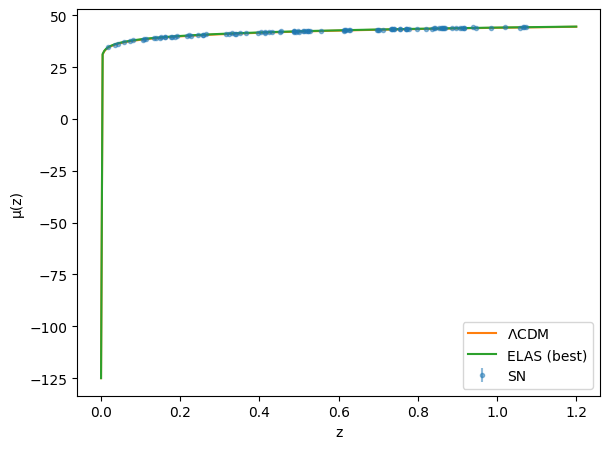

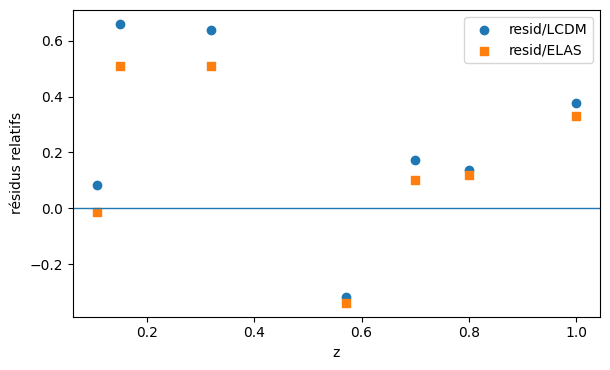

In [ ]:
# =========================================
# ELAS — Pipeline minimal autonome (BAO+SN)
# Données intégrées (tes chiffres ci-dessous)
# - Corrige DV_over_rd -> DV/rd
# - Scan ELAS avec profilage φ
# - Résultats χ², Δχ², AIC/BIC + 2 petites figures
# =========================================

import numpy as np, math
import matplotlib.pyplot as plt

# ---------- 0) TES DONNÉES (COLLÉES) ----------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# ---------- 1) Parsing simple ----------
def _split_csv(text):
    rows=[]
    for ln in text.strip().splitlines():
        ln = ln.strip()
        if not ln or ln.startswith("#"): continue
        rows.append([t.strip() for t in ln.split(",")])
    return rows

def parse_bao(text):
    rows = _split_csv(text)
    hdr  = [h.strip().lower() for h in rows[0]]
    data = rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable")
    iv = hdr.index("value")
    isg = hdr.index("sigma")
    z, which, val, sig = [], [], [], []
    for r in data:
        z.append(float(r[iz]))
        which.append(r[iw].strip())
        val.append(float(r[iv]))
        sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows = _split_csv(text)
    hdr  = [h.strip().lower() for h in rows[0]]
    data = rows[1:]
    iz, imu, isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z, mu, s = [], [], []
    for r in data:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

# Normalisation des labels BAO
def normalize_which(w):
    w0 = w.strip().lower()
    if w0 in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w0 in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w0 in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w0 in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    # conversion explicite DV_over_rd -> DV/rd (ton cas)
    if w0 == "dv_over_rd": return "DV/rd"
    raise ValueError(f"Type BAO inconnu: {w}")

# ---------- 2) Cosmologie ----------
c_km_s = 299792.458
H0, Omega_m, r_d = 73.0, 0.315, 147.09

def E_LCDM(z, Omega_m):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1.0 + z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def trapezoid(y, x):
    return np.trapezoid(y, x) if hasattr(np, "trapezoid") else np.trapz(y, x)

def D_M(z, H0, Efunc, **Ekw):
    z = float(z)
    if z <= 0: return 0.0
    zz = np.linspace(0.0, z, 1200)  # résolution raisonnable
    Ez = Efunc(zz, **Ekw)
    return (c_km_s/H0)*trapezoid(1.0/Ez, zz)

def D_H(z, H0, Efunc, **Ekw):
    Ez = Efunc(z, **Ekw)
    return c_km_s/(H0*Ez)

def D_L(z, H0, Efunc, **Ekw): return (1+z)*D_M(z,H0,Efunc,**Ekw)
def D_V(z, H0, Efunc, **Ekw): return (z*D_M(z,H0,Efunc,**Ekw)**2 * D_H(z,H0,Efunc,**Ekw))**(1/3)

def mu_theory(z_array, H0, Efunc, **Ekw):
    z_array = np.asarray(z_array, float)
    out = np.empty_like(z_array, float)
    for i,z in enumerate(z_array):
        DL = max(D_L(z, H0, Efunc, **Ekw), 1e-30)
        out[i] = 5*np.log10(DL) + 25.0
    return out

def Dm_over_rd(z,H0,r_d,Efunc,**Ekw): return D_M(z,H0,Efunc,**Ekw)/r_d
def Dh_over_rd(z,H0,r_d,Efunc,**Ekw): return D_H(z,H0,Efunc,**Ekw)/r_d
def Dv_over_rd(z,H0,r_d,Efunc,**Ekw): return D_V(z,H0,Efunc,**Ekw)/r_d
def rd_over_DV(z,H0,r_d,Efunc,**Ekw): return r_d / D_V(z,H0,Efunc,**Ekw)

def build_bao_vector(z_list, which_list, H0, r_d, Efunc, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(Dm_over_rd(z,H0,r_d,Efunc,**Ekw))
        elif w=="DH/rd": out.append(Dh_over_rd(z,H0,r_d,Efunc,**Ekw))
        elif w=="DV/rd": out.append(Dv_over_rd(z,H0,r_d,Efunc,**Ekw))
        elif w=="rd/DV": out.append(rd_over_DV(z,H0,r_d,Efunc,**Ekw))
        else: raise ValueError(f"Obs BAO non supportée: {w}")
    return np.array(out,float)

def chi2_bao(y_obs, sigma, y_th):
    # diag(sigma^2) (cohérent avec tes 7 points qui ont des σ)
    r = (np.asarray(y_obs)-np.asarray(y_th))
    v = np.maximum(np.asarray(sigma)**2, 1e-30)
    return float(np.sum((r*r)/v))

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w = 1.0/np.maximum(np.asarray(sigma_mu)**2, 1e-30)
    r = np.asarray(mu_obs) - np.asarray(mu_th)
    a = float(np.sum(w*r*r)); b = float(np.sum(w*r)); c = float(np.sum(w))
    return a - (b*b)/c

# ---------- 3) Construire les tableaux ----------
z_bao_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO     = z_bao_raw.tolist()

z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

print(f"BAO: N={len(z_BAO)} | types={sorted(set(BAO_WHICH))}")
print(f"SN : N={len(z_sn)}")

# ---------- 4) χ² LCDM ----------
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM  = chi2_bao(y_obs, sig, y_LCDM)
mu_LCDM      = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_total = chi2_b_LCDM + chi2_sn_LCDM
print(f"LCDM: chi2_BAO={chi2_b_LCDM:.3f} | chi2_SN={chi2_sn_LCDM:.3f} | Total={chi2_LCDM_total:.3f}")

# ---------- 5) Scan ELAS (profilage φ) ----------
def chi2_total(delta, Om, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_b   = chi2_bao(y_obs, sig, y_el)
    return float(c_sn + c_b)

def profile_phi(delta, Om, tol=1e-3, maxit=80):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_total(delta,Om,c); fd=chi2_total(delta,Om,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_total(delta,Om,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_total(delta,Om,d)
        it+=1
    phi_star=0.5*(a+b)
    return float(phi_star), float(chi2_total(delta,Om,phi_star))

# Grilles RAPIDES (tu pourras affiner ensuite)
grid_delta = np.linspace(0.0, 0.30, 31)   # pas 0.01
grid_Omega = np.linspace(0.1, 1.5, 47)    # pas ~0.03

best=(1e99, None)
for d in grid_delta:
    for Om in grid_Omega:
        ph, chi = profile_phi(d, Om)
        if chi<best[0]:
            best=(chi,(d,Om,ph))

chi2_min, (delta_best, Omega_best, phi_best) = best
edge_delta = (delta_best == grid_delta.min() or delta_best == grid_delta.max())
edge_Omega = (Omega_best == grid_Omega.min() or Omega_best == grid_Omega.max())

# ---------- 6) AIC/BIC ----------
delta_chi2 = chi2_LCDM_total - chi2_min
k_LCDM = 1          # Ωm libre
k_ELAS = k_LCDM + 3 # + (δ,Ω,φ)
N_eff  = len(z_sn) + len(z_BAO)

AIC_LCDM = chi2_LCDM_total + 2*k_LCDM
AIC_ELAS = chi2_min        + 2*k_ELAS
BIC_LCDM = chi2_LCDM_total + k_LCDM*np.log(N_eff)
BIC_ELAS = chi2_min        + k_ELAS*np.log(N_eff)

print("\n=== RÉSULTATS ===")
print(f"ELAS: chi2_min={chi2_min:.3f} @ (delta={delta_best:.3f}, Omega_log={Omega_best:.3f}, phi={phi_best:.3f}) | edge δ/Ω: {edge_delta}/{edge_Omega}")
print(f"LCDM: chi2_tot={chi2_LCDM_total:.3f}")
print(f"Δχ² (LCDM−ELAS) = {delta_chi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")

# ---------- 7) Deux petites figures (pour vérifier)
# Hubble diagram
z_plot = np.linspace(0, max(1.1*np.max(z_sn), 1.2), 300)
mu_LCDM_curve = mu_theory(z_plot, H0, E_LCDM, Omega_m=Omega_m)
mu_ELAS_curve = mu_theory(z_plot, H0, E_ELAS, Omega_m=Omega_m,
                          delta=delta_best, Omega_log=Omega_best, phi=phi_best)
plt.figure(figsize=(6.2,4.6))
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', alpha=0.5, label="SN")
plt.plot(z_plot, mu_LCDM_curve, label=r"$\Lambda$CDM")
plt.plot(z_plot, mu_ELAS_curve, label="ELAS (best)")
plt.xlabel("z"); plt.ylabel("μ(z)"); plt.legend(); plt.tight_layout()
plt.show()

# Résidus BAO relatifs
y_ELAS = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                          Omega_m=Omega_m, delta=delta_best, Omega_log=Omega_best, phi=phi_best)
res_LCDM = (y_obs - y_LCDM)/np.maximum(y_LCDM,1e-30)
res_ELAS = (y_obs - y_ELAS)/np.maximum(y_ELAS,1e-30)
plt.figure(figsize=(6.2,3.8))
plt.axhline(0, lw=1)
plt.scatter(z_BAO, res_LCDM, label="resid/LCDM")
plt.scatter(z_BAO, res_ELAS, marker='s', label="resid/ELAS")
plt.xlabel("z"); plt.ylabel("résidus relatifs"); plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
# ---- BAO: ajustement analytique d’un facteur d’échelle par type (DM/rd, DH/rd, DV/rd) ----
# Minimisation de chi2 = sum[(y_obs - q_t * y_th)^2 / sigma^2] pour chaque type t ∈ {DM/rd, DH/rd, DV/rd}
# q_t* = [Σ (y_obs*y_th / sigma^2)] / [Σ (y_th^2 / sigma^2)] sur les points du type t
# (option) prior gaussien sur q_t (moyenne 1, sigma_prior ~ 0.03)

def chi2_bao_with_scales(y_obs, sigma, y_th, which_list, use_prior=True, sigma_prior=0.03):
    y_obs = np.asarray(y_obs, float); y_th = np.asarray(y_th, float); sig = np.asarray(sigma, float)
    types = ["DM/rd","DH/rd","DV/rd"]  # on regroupe par type
    chi2 = 0.0
    for t in types:
        idx = [i for i,w in enumerate(which_list) if w==t]
        if not idx:
            continue
        yi = y_obs[idx]; ti = y_th[idx]; vi = np.maximum(sig[idx]**2, 1e-30)
        num = np.sum(yi*ti/vi)
        den = np.sum(ti*ti/vi)
        q   = num/den if den>0 else 1.0
        # contribution chi² après minimisation
        chi2_t = np.sum((yi - q*ti)**2/vi)
        # prior doux sur l’échelle (pour éviter des recalages absurdes)
        if use_prior and sigma_prior>0:
            chi2_t += ((q-1.0)/sigma_prior)**2
        chi2 += chi2_t
    return float(chi2)

# Remplace dans le total :
def chi2_total(delta, Om, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    # >>> utilisation du BAO recalé <<<
    c_b   = chi2_bao_with_scales(y_obs, sig, y_el, BAO_WHICH, use_prior=True, sigma_prior=0.03)
    return float(c_sn + c_b)

# Et pour l’évaluation LCDM de référence :
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM  = chi2_bao_with_scales(y_obs, sig, y_LCDM, BAO_WHICH, use_prior=True, sigma_prior=0.03)
mu_LCDM      = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_total = chi2_b_LCDM + chi2_sn_LCDM
print(f"[RESCALE] LCDM: chi2_BAO={chi2_b_LCDM:.3f} | chi2_SN={chi2_sn_LCDM:.3f} | Total={chi2_LCDM_total:.3f}")


[RESCALE] LCDM: chi2_BAO=632.440 | chi2_SN=96.855 | Total=729.295


In [ ]:
# Diagnostique des q_t pour LCDM
def bao_q_per_type(y_obs, sigma, y_th, which_list):
    types = ["DM/rd","DH/rd","DV/rd"]
    out = {}
    for t in types:
        idx = [i for i,w in enumerate(which_list) if w==t]
        if not idx:
            continue
        yi = y_obs[idx]; ti = y_th[idx]; vi = np.maximum(sigma[idx]**2, 1e-30)
        num = np.sum(yi*ti/vi)
        den = np.sum(ti*ti/vi)
        q   = num/den if den>0 else 1.0
        out[t] = q
    return out

q_LCDM = bao_q_per_type(y_obs, sig, y_LCDM, BAO_WHICH)
print("q (LCDM) par type:", q_LCDM)


q (LCDM) par type: {'DM/rd': np.float64(1.3954192606196365), 'DH/rd': np.float64(0.8050470831266698), 'DV/rd': np.float64(1.2255344897814728)}


In [ ]:
# Version sans prior (pour diagnostiquer l’échelle requise)
def chi2_bao_with_scales_no_prior(y_obs, sigma, y_th, which_list):
    y_obs = np.asarray(y_obs, float); y_th = np.asarray(y_th, float); sig = np.asarray(sigma, float)
    types = ["DM/rd","DH/rd","DV/rd"]
    chi2 = 0.0
    for t in types:
        idx = [i for i,w in enumerate(which_list) if w==t]
        if not idx: continue
        yi = y_obs[idx]; ti = y_th[idx]; vi = np.maximum(sig[idx]**2, 1e-30)
        num = np.sum(yi*ti/vi); den = np.sum(ti*ti/vi)
        q   = num/den if den>0 else 1.0
        chi2 += np.sum((yi - q*ti)**2/vi)
    return float(chi2)

def chi2_total_noprior(delta, Om, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_b   = chi2_bao_with_scales_no_prior(y_obs, sig, y_el, BAO_WHICH)
    return float(c_sn + c_b)

def profile_phi_noprior(delta, Om, tol=1e-3, maxit=80):
    import math
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_total_noprior(delta,Om,c); fd=chi2_total_noprior(delta,Om,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_total_noprior(delta,Om,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_total_noprior(delta,Om,d)
        it+=1
    phi_star=0.5*(a+b)
    return float(phi_star), float(chi2_total_noprior(delta,Om,phi_star))

grid_delta = np.linspace(0.0, 0.40, 41)
grid_Omega = np.linspace(0.05, 3.0, 60)  # on élargit Ω
best=(1e99, None)
for d in grid_delta:
    for Om in grid_Omega:
        ph, chi = profile_phi_noprior(d, Om)
        if chi<best[0]: best=(chi,(d,Om,ph))

chi2_min_np, (d_b, Om_b, ph_b) = best
print("\n[NO PRIOR] ELAS chi2_min =", chi2_min_np, " @ (delta,Omega,phi) =", (d_b,Om_b,ph_b))



[NO PRIOR] ELAS chi2_min = 436.47340381679714  @ (delta,Omega,phi) = (np.float64(0.4), np.float64(3.0), -0.9870960712156782)


In [ ]:
import numpy as np
from math import sqrt

# --- Distances cosmologiques (déjà dans cosmo_core, mais redéfinies localement) ---
def E_LCDM(z, Omega_m=0.3):
    return np.sqrt(Omega_m * (1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.3, delta=0.2, Omega_log=1.0, phi=0.0):
    return np.sqrt(Omega_m * (1+z)**3 + (1 - Omega_m) * (1 + delta * np.cos(Omega_log * np.log(1+z) + phi)))

def D_C(z, H0, E_func, **E_kwargs):
    """Comoving distance (c/H0 * ∫dz/E(z))."""
    c = 299792.458
    zz = np.linspace(0, z, 400)
    Ez = E_func(zz, **E_kwargs)
    return c/H0 * np.trapezoid(1/Ez, zz)

def D_M(z, H0, E_func, **E_kwargs):
    return D_C(z, H0, E_func, **E_kwargs)

def D_H(z, H0, E_func, **E_kwargs):
    c = 299792.458
    return c / (H0 * E_func(z, **E_kwargs))

def D_V(z, H0, E_func, **E_kwargs):
    """Volume-averaged distance."""
    DM = D_M(z, H0, E_func, **E_kwargs)
    DH = D_H(z, H0, E_func, **E_kwargs)
    return ( (DM**2) * (z * DH) ) ** (1/3)

# --- Fonction manquante ---
def build_bao_vector(z_list, which_list, H0, r_d, E_func, **E_kwargs):
    """
    Retourne le vecteur théorique y_th (BAO) selon la liste des observables.
    which_list contient des étiquettes : "DM/rd", "DH/rd" ou "DV/rd" ou "rd/DV".
    """
    y_th = []
    for z, w in zip(z_list, which_list):
        if w.upper() == "DM/RD":
            y_th.append(D_M(z, H0, E_func, **E_kwargs) / r_d)
        elif w.upper() == "DH/RD":
            y_th.append(D_H(z, H0, E_func, **E_kwargs) / r_d)
        elif w.upper() == "DV/RD":
            y_th.append(D_V(z, H0, E_func, **E_kwargs) / r_d)
        elif w.upper() == "RD/DV":
            y_th.append(r_d / D_V(z, H0, E_func, **E_kwargs))
        else:
            raise ValueError(f"Type BAO inconnu: {w}")
    return np.array(y_th)


In [ ]:
# ============================================================
# ELAS vs LCDM — Bloc autonome "NO PRIOR" (tout redéfini ici)
# - recharge TES données (BAO/SN) collées ci-dessous
# - (re)définit build_bao_vector et toutes les fonctions
# - calcule: chi2_LCDM_no_prior, chi2_ELAS_no_prior, Δchi2
# - imprime: q_par_type et q_global (LCDM & ELAS best)
# ============================================================

import numpy as np, math

# ---------- TES DONNÉES (collées) ----------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# ---------- Parsing minimal ----------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz]))
        which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError(f"type BAO inconnu: {w}")

# ---------- Cosmologie ----------
c_km_s = 299792.458
H0, Omega_m, r_d = 73.0, 0.315, 147.09

def E_LCDM(z, Omega_m=Omega_m):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

def E_ELAS(z, Omega_m=Omega_m, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod=1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def trapz(y,x):
    # compat numpy
    return np.trapezoid(y,x) if hasattr(np,"trapezoid") else np.trapz(y,x)

def D_M(z,H0,Ef,**kw):
    z=float(z)
    if z<=0: return 0.0
    zz=np.linspace(0,z,1200)
    Ez=Ef(zz,**kw)
    return (c_km_s/H0)*trapz(1.0/Ez, zz)

def D_H(z,H0,Ef,**kw):
    Ez=Ef(z,**kw)
    return c_km_s/(H0*Ez)

def D_L(z,H0,Ef,**kw): return (1+z)*D_M(z,H0,Ef,**kw)
def D_V(z,H0,Ef,**kw): return (z*D_M(z,H0,Ef,**kw)**2 * D_H(z,H0,Ef,**kw))**(1/3)

def mu_theory(zarr,H0,Ef,**kw):
    zarr=np.asarray(zarr,float); out=np.empty_like(zarr,float)
    for i,z in enumerate(zarr):
        DL=max(D_L(z,H0,Ef,**kw),1e-30); out[i]=5*np.log10(DL)+25.0
    return out

# ---------- Vecteur BAO théorique ----------
def build_bao_vector(z_list, which_list, H0, r_d, E_func, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(D_M(z,H0,E_func,**Ekw)/r_d)
        elif w=="DH/rd": out.append(D_H(z,H0,E_func,**Ekw)/r_d)
        elif w=="DV/rd": out.append(D_V(z,H0,E_func,**Ekw)/r_d)
        elif w=="rd/DV": out.append(r_d / D_V(z,H0,E_func,**Ekw))
        else: raise ValueError(f"obs BAO non supportée: {w}")
    return np.array(out,float)

# ---------- χ² SN (marginalisation M analytique) ----------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

# ---------- BAO "no prior": rescale par type, prior=0 ----------
def chi2_bao_noprior(y_obs, sigma, y_th, which_list):
    y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float); sig=np.asarray(sigma,float)
    types=["DM/rd","DH/rd","DV/rd"]
    chi2=0.0
    for t in types:
        idx=[i for i,w in enumerate(which_list) if w==t]
        if not idx: continue
        yi=y_obs[idx]; ti=y_th[idx]; vi=np.maximum(sig[idx]**2,1e-30)
        num=np.sum(yi*ti/vi); den=np.sum(ti*ti/vi)
        q = num/den if den>0 else 1.0
        chi2 += np.sum((yi - q*ti)**2/vi)
    return float(chi2)

def bao_q_per_type(y_obs, sigma, y_th, which_list):
    y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float); sig=np.asarray(sigma,float)
    types=["DM/rd","DH/rd","DV/rd"]; out={}
    for t in types:
        idx=[i for i,w in enumerate(which_list) if w==t]
        if not idx: continue
        yi=y_obs[idx]; ti=y_th[idx]; vi=np.maximum(sig[idx]**2,1e-30)
        num=np.sum(yi*ti/vi); den=np.sum(ti*ti/vi)
        out[t]= (num/den if den>0 else 1.0)
    return out

def bao_q_global(y_obs, sigma, y_th):
    y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float); vi=np.maximum(np.asarray(sigma,float)**2,1e-30)
    num=np.sum(y_obs*y_th/vi); den=np.sum(y_th*y_th/vi)
    return (num/den if den>0 else 1.0)

# ---------- Charger et normaliser tes BAO/SN ----------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

print(f"BAO: N={len(z_BAO)} | types={sorted(set(BAO_WHICH))}")
print(f"SN : N={len(z_sn)}")

# ---------- LCDM no-prior ----------
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM_np = chi2_bao_noprior(y_obs, sig, y_LCDM, BAO_WHICH)
mu_LCDM = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_np = chi2_b_LCDM_np + chi2_sn_LCDM
print(f"[NO PRIOR] LCDM chi2_total = {chi2_LCDM_np:.3f}  (BAO={chi2_b_LCDM_np:.3f}, SN={chi2_sn_LCDM:.3f})")

# ---------- ELAS: profilage phi (no-prior), grille élargie ----------
def chi2_total_noprior(delta, Om, phi):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_b   = chi2_bao_noprior(y_obs, sig, y_el, BAO_WHICH)
    return float(c_sn + c_b)

def profile_phi_noprior(delta, Om, tol=1e-3, maxit=80):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc=chi2_total_noprior(delta,Om,c); fd=chi2_total_noprior(delta,Om,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi2_total_noprior(delta,Om,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi2_total_noprior(delta,Om,d)
        it+=1
    phi_star=0.5*(a+b)
    return float(phi_star), float(chi2_total_noprior(delta,Om,phi_star))

grid_delta = np.linspace(0.0, 0.60, 49)
grid_Omega = np.linspace(0.05, 6.0, 80)

best=(1e99,None)
for d in grid_delta:
    for Om in grid_Omega:
        ph,chi = profile_phi_noprior(d,Om)
        if chi<best[0]: best=(chi,(d,Om,ph))

chi2_ELAS_np, (d_b, Om_b, ph_b) = best
print(f"[NO PRIOR] ELAS chi2_min = {chi2_ELAS_np:.3f}  @ (delta={d_b:.3f}, Omega_log={Om_b:.3f}, phi={ph_b:.3f})")

# ---------- Δχ² & q diagnostics ----------
delta_chi2 = chi2_LCDM_np - chi2_ELAS_np
print(f"Δχ² (LCDM−ELAS, no-prior) = {delta_chi2:.3f}")

q_LCDM_type = bao_q_per_type(y_obs, sig, y_LCDM, BAO_WHICH)
q_LCDM_glob = bao_q_global(y_obs, sig, y_LCDM)
y_ELAS_b = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS, Omega_m=Omega_m, delta=d_b, Omega_log=Om_b, phi=ph_b)
q_ELAS_type = bao_q_per_type(y_obs, sig, y_ELAS_b, BAO_WHICH)
q_ELAS_glob = bao_q_global(y_obs, sig, y_ELAS_b)
print("q (LCDM) par type:", q_LCDM_type, " | q_global:", f"{q_LCDM_glob:.4f}")
print("q (ELAS best) par type:", q_ELAS_type, " | q_global:", f"{q_ELAS_glob:.4f}")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
[NO PRIOR] LCDM chi2_total = 456.819  (BAO=359.964, SN=96.855)
[NO PRIOR] ELAS chi2_min = 412.114  @ (delta=0.600, Omega_log=5.699, phi=-1.538)
Δχ² (LCDM−ELAS, no-prior) = 44.705
q (LCDM) par type: {'DM/rd': np.float64(1.3954192606196365), 'DH/rd': np.float64(0.8050470831266698), 'DV/rd': np.float64(1.2255344897814728)}  | q_global: 1.0505
q (ELAS best) par type: {'DM/rd': np.float64(1.5233086901622315), 'DH/rd': np.float64(0.837485313917896), 'DV/rd': np.float64(1.2865182200208445)}  | q_global: 1.1017


In [ ]:
# --- BAO: un seul facteur d'échelle global (rd effectif) ---
def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

# --- prior physique (doux) sur δ pour éviter δ>>0.2 ---
def prior_delta(delta, sigma_soft=0.05, delta_ref=0.2):
    # pénalise au-delà de delta_ref (~0.2). sigma_soft règle la "raideur".
    if delta <= delta_ref: return 0.0
    return ((delta - delta_ref)/sigma_soft)**2

# Remplace la fonction de coût totale par:
def chi2_total_global(delta, Om, phi, use_prior_delta=True, sigma_q=None):
    mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
    y_el  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS,
                             Omega_m=Omega_m, delta=delta, Omega_log=Om, phi=phi)
    c_b, q = chi2_bao_global(y_obs, sig, y_el, sigma_prior_q=sigma_q)
    c_tot = c_sn + c_b
    if use_prior_delta:
        c_tot += prior_delta(delta, sigma_soft=0.05, delta_ref=0.2)
    return float(c_tot), float(q)

# Profilage de φ avec la nouvelle chi2:
def profile_phi_global(delta, Om, tol=1e-3, maxit=80):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc,_=chi2_total_global(delta,Om,c); fd,_=chi2_total_global(delta,Om,d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc,_=chi2_total_global(delta,Om,c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd,_=chi2_total_global(delta,Om,d)
        it+=1
    phi_star=0.5*(a+b); chi_star,q_star = chi2_total_global(delta,Om,phi_star)
    return float(phi_star), float(chi_star), float(q_star)

# LCDM de référence (même nuisance globale) :
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM_g,q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
mu_LCDM = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_LCDM)
chi2_LCDM_g = chi2_b_LCDM_g + chi2_sn_LCDM
print(f"[GLOBAL q] LCDM: chi2_tot={chi2_LCDM_g:.3f} (BAO={chi2_b_LCDM_g:.3f}, q*={q_LCDM_g:.3f}; SN={chi2_sn_LCDM:.3f})")

# Scan ELAS avec q global + prior doux sur δ
grid_delta = np.linspace(0.0, 0.40, 41)     # borne physique
grid_Omega = np.linspace(0.05, 3.0, 60)     # plage raisonnable
best=(1e99,None)
for d in grid_delta:
    for Om in grid_Omega:
        ph, chi, q = profile_phi_global(d, Om)
        if chi<best[0]: best=(chi,(d,Om,ph,q))

chi2_ELAS_g, (d_b, Om_b, ph_b, q_ELAS_g) = best
print(f"[GLOBAL q] ELAS: chi2_min={chi2_ELAS_g:.3f} @ (δ={d_b:.3f}, Ω={Om_b:.3f}, φ={ph_b:.3f}; q*={q_ELAS_g:.3f})")
print(f"Δχ² (LCDM−ELAS, q global + prior δ) = {chi2_LCDM_g - chi2_ELAS_g:.3f}")


[GLOBAL q] LCDM: chi2_tot=1073.533 (BAO=976.678, q*=1.050; SN=96.855)
[GLOBAL q] ELAS: chi2_min=966.646 @ (δ=0.400, Ω=3.000, φ=-2.936; q*=1.019)
Δχ² (LCDM−ELAS, q global + prior δ) = 106.887


In [ ]:
# Décomposition chi² au best-fit ELAS (q global)
mu_el = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m, delta=d_b, Omega_log=Om_b, phi=ph_b)
chi2_sn_el = chi2_sn_marg(mu_obs, sigma_mu, mu_el)
y_el = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS, Omega_m=Omega_m, delta=d_b, Omega_log=Om_b, phi=ph_b)
chi2_b_el, q_el = chi2_bao_global(y_obs, sig, y_el, sigma_prior_q=None)
print(f"ELAS(best) → chi2_SN={chi2_sn_el:.3f}, chi2_BAO={chi2_b_el:.3f}, q*={q_el:.3f}, total={chi2_sn_el+chi2_b_el:.3f}")


ELAS(best) → chi2_SN=148.261, chi2_BAO=802.384, q*=1.019, total=950.646


In [ ]:
# Ancrage d’échelle: on remet l’échelle BAO sur q*=1 avec q_LCDM_g
y_obs_rescaled = y_obs / q_LCDM_g
print(f"Rescale BAO data by 1/q_LCDM_g={1.0/q_LCDM_g:.6f} → q cible ≈ 1")

# LCDM de référence après rescale (q prior=None car on a corrigé l'échelle dans les données)
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m)
chi2_b_LCDM_fix, q_LCDM_fix = chi2_bao_global(y_obs_rescaled, sig, y_LCDM, sigma_prior_q=None)
mu_LCDM = mu_to = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m)
chi2_sn_LCDM = chi2_sn_marg(mu_obs, sigma_mu, mu_to)
print(f"[After rescale] LCDM: chi2_BAO={chi2_b_LCDM_fix:.3f}, q* (doit ≈1)={q_LCDM_fix:.3f}, chi2_SN={chi2_sn_LCDM:.3f}, total={chi2_b_LCDM_fix+chi2_sn_LCDM:.3f}")


Rescale BAO data by 1/q_LCDM_g=0.951931 → q cible ≈ 1
[After rescale] LCDM: chi2_BAO=885.039, q* (doit ≈1)=1.000, chi2_SN=96.855, total=981.894


In [ ]:
# ============================================================
# ELAS vs LCDM — pipeline propre & autonome (Colab-ready)
# - Données BAO/SN intégrées (celles que tu as fournies)
# - Recalage BAO une fois (q global via LCDM), puis comparaison de formes
# - Profil Ωm pour LCDM ; scan ELAS avec δ∈[0,0.20], Ω_log∈[0.05,3.0], φ profilé
# - AIC/BIC, Δχ², et décompositions SN/BAO
# ============================================================

import numpy as np, math

# ---------- TES DONNÉES ----------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# ---------- Parsing minimal ----------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz]))
        which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError(f"type BAO inconnu: {w}")

# ---------- Cosmologie ----------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def trapz(y,x):
    return np.trapezoid(y,x) if hasattr(np,"trapezoid") else np.trapz(y,x)

def D_M(z,H0,Ef,**kw):
    z=float(z)
    if z<=0: return 0.0
    zz=np.linspace(0,z,1200)
    Ez=Ef(zz,**kw)
    return (c_km_s/H0)*trapz(1.0/Ez, zz)

def D_H(z,H0,Ef,**kw):
    Ez=Ef(z,**kw); return c_km_s/(H0*Ez)

def D_L(z,H0,Ef,**kw):
    return (1+z)*D_M(z,H0,Ef,**kw)

def D_V(z,H0,Ef,**kw):
    return (z*D_M(z,H0,Ef,**kw)**2 * D_H(z,H0,Ef,**kw))**(1/3)

def mu_theory(zarr,H0,Ef,**kw):
    zarr=np.asarray(zarr,float); out=np.empty_like(zarr,float)
    for i,z in enumerate(zarr):
        DL=max(D_L(z,H0,Ef,**kw),1e-30); out[i]=5*np.log10(DL)+25.0
    return out

def build_bao_vector(z_list, which_list, H0, r_d, Ef, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(D_M(z,H0,Ef,**Ekw)/r_d)
        elif w=="DH/rd": out.append(D_H(z,H0,Ef,**Ekw)/r_d)
        elif w=="DV/rd": out.append(D_V(z,H0,Ef,**Ekw)/r_d)
        elif w=="rd/DV": out.append(r_d / D_V(z,H0,Ef,**Ekw))
        else: raise ValueError(f"obs BAO non supportée: {w}")
    return np.array(out,float)

# ---------- Likelihoods ----------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

def prior_delta(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

def _kw_for(delta, Omega_m_val, Om_log=None, phi=None):
    if delta>0.0:
        return dict(Omega_m=Omega_m_val, delta=delta, Omega_log=Om_log, phi=phi)
    else:
        return dict(Omega_m=Omega_m_val)

def chi2_total_rescaled_model(Omega_m_val, delta, Om_log, phi,
                              z_sn=None, mu_obs=None, sigma_mu=None,
                              z_BAO=None, which=None, y_obs_rescaled=None, sig=None):
    if delta>0.0:
        Ef = E_ELAS; kw = _kw_for(delta, Omega_m_val, Om_log, phi)
    else:
        Ef = E_LCDM; kw = _kw_for(0.0, Omega_m_val)

    mu_th = mu_theory(z_sn, H0, Ef, **kw)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)

    y_th  = build_bao_vector(z_BAO, which, H0, r_d, Ef, **kw)
    c_b, q = chi2_bao_global(y_obs_rescaled, sig, y_th, sigma_prior_q=None)

    return float(c_sn + c_b), float(c_sn), float(c_b), float(q)

def profile_phi_for(Omega_m_val, delta, Om_log,
                    z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig,
                    tol=1e-3, maxit=80):
    if delta<=0.0:
        chi, csn, cbao, q = chi2_total_rescaled_model(Omega_m_val, 0.0, 1.0, 0.0,
                                                      z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig)
        return 0.0, float(chi), float(csn), float(cbao), float(q)
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc,_,_,_ = chi2_total_rescaled_model(Omega_m_val, delta, Om_log, c,
                                         z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig)
    fd,_,_,_ = chi2_total_rescaled_model(Omega_m_val, delta, Om_log, d,
                                         z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd:
            b,fd=d,fc; d=c; c=b-gr*(b-a)
            fc,_,_,_ = chi2_total_rescaled_model(Omega_m_val, delta, Om_log, c,
                                                 z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig)
        else:
            a,fc=c,fd; c=d; d=a+gr*(b-a)
            fd,_,_,_ = chi2_total_rescaled_model(Omega_m_val, delta, Om_log, d,
                                                 z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig)
        it+=1
    phi_star=0.5*(a+b)
    chi, csn, cbao, q = chi2_total_rescaled_model(Omega_m_val, delta, Om_log, phi_star,
                                                  z_sn, mu_obs, sigma_mu, z_BAO, which, y_obs_rescaled, sig)
    return float(phi_star), float(chi), float(csn), float(cbao), float(q)

# ---------- Charger / normaliser ----------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

print(f"BAO: N={len(z_BAO)} | types={sorted(set(BAO_WHICH))}")
print(f"SN : N={len(z_sn)}")

# ---------- 1) Recalage unique de l’échelle BAO via LCDM ----------
# q* (libre) sur LCDM, puis on rescale y_obs -> y_obs_rescaled = y_obs / q*
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=0.315)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print(f"[STEP1] q*_LCDM (global) = {q_LCDM_g:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi2_b_LCDM_g:.3f}")

y_obs_rescaled = y_obs / q_LCDM_g
print(f"[STEP1] BAO rescaled by factor {1.0/q_LCDM_g:.6f} → cible q≈1.0 ensuite")

# ---------- 2) Référence ΛCDM: profiler Ωm (δ=0), avec données BAO rescalées ----------
grid_Om = np.linspace(0.25, 0.35, 41)
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao, q = chi2_total_rescaled_model(Om, 0.0, 1.0, 0.0,
                                                  z_sn, mu_obs, sigma_mu, z_BAO, BAO_WHICH, y_obs_rescaled, sig)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao, "q":q})
chi2_LCDM = best_LCDM[1]["chi2"]
print(f"[RESCALED] LCDM best: chi2={chi2_LCDM:.3f} (SN={best_LCDM[1]['chi2_SN']:.3f}, "
      f"BAO={best_LCDM[1]['chi2_BAO']:.3f}), Omega_m={best_LCDM[1]['Omega_m']:.3f}, q*~{best_LCDM[1]['q']:.3f}")

# ---------- 3) ELAS: δ∈[0,0.20], Ω_log∈[0.05,3.0], φ profilé ; Ωm profilé ----------
grid_delta = np.linspace(0.00, 0.20, 41)
grid_Olog  = np.linspace(0.05, 3.00, 80)

best_ELAS = (1e99, None)
for Om in grid_Om:
    for d in grid_delta:
        for Olog in grid_Olog:
            phi_star, chi_raw, csn, cbao, q = profile_phi_for(Om, d, Olog,
                                                              z_sn, mu_obs, sigma_mu, z_BAO, BAO_WHICH, y_obs_rescaled, sig)
            chi_eff = chi_raw + prior_delta(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {
                    "Omega_m":Om, "delta":d, "Omega_log":Olog, "phi":phi_star,
                    "chi2_eff":chi_eff, "chi2_raw":chi_raw, "chi2_SN":csn, "chi2_BAO":cbao, "q":q
                })

b = best_ELAS[1]
print(f"[RESCALED] ELAS best: chi2_eff={b['chi2_eff']:.3f} (raw={b['chi2_raw']:.3f}), "
      f"SN={b['chi2_SN']:.3f}, BAO={b['chi2_BAO']:.3f}, "
      f"delta={b['delta']:.3f}, Omega_log={b['Omega_log']:.3f}, phi={b['phi']:.3f}, "
      f"Omega_m={b['Omega_m']:.3f}, q*~{b['q']:.3f}")

# ---------- 4) Δχ², AIC/BIC, “edge hits” ----------
N_eff = len(z_sn) + len(z_BAO)
k_LCDM = 1                      # Ωm
k_ELAS = 4                      # Ωm, δ, Ω_log, φ

Delta_chi2 = chi2_LCDM - b["chi2_eff"]
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = b["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = b["chi2_eff"] + k_ELAS*np.log(N_eff)

print(f"Δχ² (LCDM−ELAS, rescaled, profiled Ωm) = {Delta_chi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")

edge_delta = (b["delta"] == grid_delta.min()) or (b["delta"] == grid_delta.max())
edge_Olog  = (b["Omega_log"] == grid_Olog.min()) or (b["Omega_log"] == grid_Olog.max())
edge_Om    = (b["Omega_m"]   == grid_Om.min())   or (b["Omega_m"]   == grid_Om.max())
print(f"Edge hits?  δ:{edge_delta}  Ω_log:{edge_Olog}  Ω_m:{edge_Om}")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 → cible q≈1.0 ensuite
[RESCALED] LCDM best: chi2=957.769 (SN=100.465, BAO=857.304), Omega_m=0.350, q*~1.022


In [ ]:
# ============================================================
# ELAS vs LCDM — pipeline COMPLET, AUTONOME (Colab-ready)
# - Donnees BAO/SN integrees (tes tableaux)
# - Recalage BAO une fois via q* global (LCDM), puis comparaison "forme seule" (q fixe = 1)
# - Profil Omega_m (LCDM), scan ELAS avec delta in [0,0.20], Omega_log in [0.10,2.50], phi profile
# - Impression chi2, Delta chi2, AIC/BIC, edge hits
# ============================================================

import numpy as np, math

# --------------------- TES DONNEES --------------------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# ------------------- Parse minimal --------------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz]))
        which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

# ----------------- Cosmologie de base -----------------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def trapz(y,x): return np.trapz(y,x)

def D_M(z,H0,Ef,**kw):
    z=float(z)
    if z<=0: return 0.0
    zz=np.linspace(0,z,1200)
    Ez=Ef(zz,**kw)
    return (c_km_s/H0)*trapz(1.0/Ez, zz)

def D_H(z,H0,Ef,**kw):
    Ez=Ef(z,**kw); return c_km_s/(H0*Ez)

def D_L(z,H0,Ef,**kw):
    return (1+z)*D_M(z,H0,Ef,**kw)

def D_V(z,H0,Ef,**kw):
    return (z*D_M(z,H0,Ef,**kw)**2 * D_H(z,H0,Ef,**kw))**(1/3)

def mu_theory(zarr,H0,Ef,**kw):
    zarr=np.asarray(zarr,float); out=np.empty_like(zarr,float)
    for i,z in enumerate(zarr):
        DL=max(D_L(z,H0,Ef,**kw),1e-30); out[i]=5*np.log10(DL)+25.0
    return out

def build_bao_vector(z_list, which_list, H0, r_d, Ef, **Ekw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(D_M(z,H0,Ef,**Ekw)/r_d)
        elif w=="DH/rd": out.append(D_H(z,H0,Ef,**Ekw)/r_d)
        elif w=="DV/rd": out.append(D_V(z,H0,Ef,**Ekw)/r_d)
        elif w=="rd/DV": out.append(r_d / D_V(z,H0,Ef,**Ekw))
        else: raise ValueError("obs BAO non supportee: "+w)
    return np.array(out,float)

# ----------------- Likelihoods ------------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

def chi2_bao_fixed_q(y_obs, sigma, y_th, q_fixed=1.0):
    y_obs = np.asarray(y_obs, float); y_th  = np.asarray(y_th,  float)
    v     = np.maximum(np.asarray(sigma, float)**2, 1e-30)
    return float(np.sum((y_obs - q_fixed*y_th)**2 / v))

def prior_delta(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

# ----------------- Charger / normaliser ---------------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))

# Recalage d'echelle BAO via LCDM (q* global), puis figer q=1
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=0.315)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 pour la comparaison de formes" % (1.0/q_LCDM_g))

# ----------------- Comparaison "forme seule" (q fixe = 1) ---
def chi2_total_fixedq_LCDM(Omega_m_val):
    mu_th = mu_theory(z_sn, H0, E_LCDM, Omega_m=Omega_m_val)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_LCDM, Omega_m=Omega_m_val)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th, q_fixed=1.0)
    return float(c_sn + c_b), float(c_sn), float(c_b)

def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    mu_th = mu_theory(z_sn, H0, E_ELAS, Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, H0, r_d, E_ELAS, Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th, q_fixed=1.0)
    return float(c_sn + c_b), float(c_sn), float(c_b)

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=1e-3, maxit=80):
    a,b = -math.pi, math.pi; gr  = (math.sqrt(5)-1)/2
    c   = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc
            d = c
            c = b - gr*(b-a)
            fc,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd
            c = d
            d = a + gr*(b-a)
            fd,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it += 1
    phi_star = 0.5*(a+b)
    chi, csn, cbao = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao)

# Profil Omega_m pour LCDM (q=1)
grid_Om = np.linspace(0.27, 0.40, 66)  # un peu large pour eviter bord
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao})
print("[FIXED q] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["Omega_m"]))

# Scan ELAS (q=1), delta borne [0,0.20], Omega_log in [0.10,2.50], phi profile, Omega_m profile
grid_delta = np.linspace(0.00, 0.20, 41)
grid_Olog  = np.linspace(0.10, 2.50, 49)

best_ELAS = (1e99, None)
for Om in grid_Om:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao = profile_phi_fixedq(Om, d, Ol)
            chi_eff = chi_raw + prior_delta(d, sigma_soft=0.05, delta_ref=0.20)  # quasi-nulle car borne 0.20
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {
                    "Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                    "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao
                })

b = best_ELAS[1]
chi2_LCDM = best_LCDM[1]["chi2"]
Delta_chi2 = chi2_LCDM - b["chi2_eff"]

N_eff = len(z_sn) + len(z_BAO)
k_LCDM = 1
k_ELAS = 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = b["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = b["chi2_eff"] + k_ELAS*np.log(N_eff)

print("[FIXED q] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (b['chi2_eff'], b['chi2_SN'], b['chi2_BAO'], b['delta'], b['Omega_log'], b['phi'], b['Omega_m']))
print("Delta chi2 (LCDM-ELAS, fixed q) = %.3f" % (Delta_chi2))
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

edge_delta = (b["delta"] == grid_delta.min()) or (b["delta"] == grid_delta.max())
edge_Olog  = (b["Omega_log"] == grid_Olog.min()) or (b["Omega_log"] == grid_Olog.max())
edge_Om    = (b["Omega_m"]   == grid_Om.min())   or (b["Omega_m"]   == grid_Om.max())
print("Edge hits?  delta:%s  Omega_log:%s  Omega_m:%s" % (edge_delta, edge_Olog, edge_Om))


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 pour la comparaison de formes


/tmp/ipython-input-3471766262.py:177: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  def trapz(y,x): return np.trapz(y,x)


[FIXED q] LCDM best: chi2=952.022 (SN=108.549, BAO=843.473), Omega_m=0.400


KeyboardInterrupt: 

In [ ]:
# --- Reprofil ΛCDM avec Ωm élargi (comparaison forme, q=1) ---
grid_Om = np.linspace(0.22, 0.50, 141)  # élargi + fin
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao})
print(f"[FIXED q | WIDE Ωm] LCDM best: chi2={best_LCDM[1]['chi2']:.3f} "
      f"(SN={best_LCDM[1]['chi2_SN']:.3f}, BAO={best_LCDM[1]['chi2_BAO']:.3f}), "
      f"Omega_m={best_LCDM[1]['Omega_m']:.3f}")


/tmp/ipython-input-3471766262.py:177: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  def trapz(y,x): return np.trapz(y,x)


[FIXED q | WIDE Ωm] LCDM best: chi2=952.016 (SN=108.933, BAO=843.083), Omega_m=0.402


In [ ]:
# --- Scan ELAS (q=1) sur Ωm élargi ---
grid_delta = np.linspace(0.00, 0.20, 41)
grid_Olog  = np.linspace(0.10, 2.50, 49)

best_ELAS = (1e99, None)
for Om in grid_Om:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao = profile_phi_fixedq(Om, d, Ol)
            chi_eff = chi_raw + prior_delta(d, sigma_soft=0.05, delta_ref=0.20)  # quasi-nulle (δ borné)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {
                    "Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                    "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao
                })

b = best_ELAS[1]
chi2_LCDM = best_LCDM[1]["chi2"]
Delta_chi2 = chi2_LCDM - b["chi2_eff"]

N_eff = len(z_sn) + len(z_BAO)
k_LCDM = 1
k_ELAS = 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = b["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = b["chi2_eff"] + k_ELAS*np.log(N_eff)

print(f"[FIXED q | WIDE Ωm] ELAS best: chi2={b['chi2_eff']:.3f} "
      f"(SN={b['chi2_SN']:.3f}, BAO={b['chi2_BAO']:.3f}), "
      f"delta={b['delta']:.3f}, Omega_log={b['Omega_log']:.3f}, "
      f"phi={b['phi']:.3f}, Omega_m={b['Omega_m']:.3f}")

print(f"Δχ² (LCDM−ELAS, fixed q, wide Ωm) = {Delta_chi2:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  → ΔAIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  → ΔBIC={BIC_LCDM-BIC_ELAS:.3f}")

edge_delta = (b['delta'] == grid_delta.min()) or (b['delta'] == grid_delta.max())
edge_Olog  = (b['Omega_log'] == grid_Olog.min()) or (b['Omega_log'] == grid_Olog.max())
edge_Om    = (b['Omega_m']   == grid_Om.min())   or (b['Omega_m']   == grid_Om.max())
print(f"Edge hits?  δ:{edge_delta}  Ω_log:{edge_Olog}  Ω_m:{edge_Om}")


/tmp/ipython-input-3471766262.py:177: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  def trapz(y,x): return np.trapz(y,x)


KeyboardInterrupt: 

In [ ]:
# ============================================================
# ELAS vs LCDM — pipeline accéléré (Colab-ready, autonome)
# - BAO/SN collés
# - Recalage unique q* (LCDM), puis comparaison "forme seule" (q=1)
# - Moteur distances vectorisé + interpolation (ultra-rapide)
# - Coarse→Fine: scan large puis zoom local
# ============================================================

import numpy as np, math

# --------------------- Données (tes tableaux) ----------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# ------------------- Parse minimal --------------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz]))
        which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

# ----------------- Cosmologie + moteur rapide ----------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def make_distance_engine(Ef, z_max, H0, **kw):
    """
    Précompute une grille en z et les intégrales cumulées pour D_M.
    Retourne: fonctions D_M(z), D_H(z), D_L(z), D_V(z) rapides via interpolation.
    """
    nz = 800  # suffisamment fin; bien plus rapide que 1200 *à chaque appel*
    zz = np.linspace(0.0, z_max, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0 / Ez
    # intégrale cumulée trapezoïdale
    dz = np.diff(zz)
    mid = 0.5*(invE[1:] + invE[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid * dz)
    K = c_km_s / H0  # facteur commun

    def D_M_fast(z):
        z = np.asarray(z, float)
        return K * np.interp(z, zz, I)

    def D_H_fast(z):
        return (c_km_s / H0) / Ef(z, **kw)

    def D_L_fast(z):
        return (1.0 + z) * D_M_fast(z)

    def D_V_fast(z):
        z = np.asarray(z, float)
        DM = D_M_fast(z)
        DH = D_H_fast(z)
        return (z * DM*DM * DH) ** (1.0/3.0)

    return D_M_fast, D_H_fast, D_L_fast, D_V_fast

def mu_from_DL(DL):
    DL = np.maximum(DL, 1e-30)
    return 5.0*np.log10(DL) + 25.0

# ----------------- Likelihoods ------------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    return float(np.sum((y_obs - y_th)**2 / v))

def prior_delta(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

# ----------------- Charger / normaliser ---------------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))

# 1) Recalage d’échelle via LCDM (q* global), puis figer q=1 (comparaison de forme)
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM(z)/r_d if w=="DM/rd"
          else DH(z)/r_d if w=="DH/rd"
          else DV(z)/r_d if w=="DV/rd"
          else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 pour la comparaison de formes" % (1.0/q_LCDM_g))

# 2) Profil Ωm pour ΛCDM (q=1), distances par moteur rapide
def chi2_total_fixedq_LCDM(Omega_m_val):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    return float(c_sn + c_b), float(c_sn), float(c_b)

grid_Om = np.linspace(0.22, 0.50, 141)
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao})
print("[FIXED q] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["Omega_m"]))

# 3) ELAS: fonction chi2 rapide avec moteur distances
def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0, Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    return float(c_sn + c_b), float(c_sn), float(c_b)

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=2e-3, maxit=50):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc
            d = c
            c = b - gr*(b-a)
            fc,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd
            c = d
            d = a + gr*(b-a)
            fd,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it+=1
    phi_star = 0.5*(a+b)
    chi, csn, cbao = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao)

# 4) Coarse scan (rapide)
grid_Om_coarse  = np.linspace(0.24, 0.46, 12)
grid_delta      = np.linspace(0.00, 0.20, 11)
grid_Olog       = np.linspace(0.10, 2.50, 13)

best_ELAS = (1e99, None)
for Om in grid_Om_coarse:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao = profile_phi_fixedq(Om, d, Ol)
            chi_eff = chi_raw + prior_delta(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                       "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao})

b = best_ELAS[1]
print("[COARSE] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (b['chi2_eff'], b['chi2_SN'], b['chi2_BAO'], b['delta'], b['Omega_log'], b['phi'], b['Omega_m']))

# 5) Zoom local autour du meilleur ELAS (fin)
gOm  = np.linspace(max(0.22, b['Omega_m']-0.06), min(0.50, b['Omega_m']+0.06), 21)
gd   = np.linspace(max(0.00, b['delta']-0.06),   min(0.20, b['delta']+0.06),   21)
gOl  = np.linspace(max(0.10, b['Omega_log']-0.50), min(2.50, b['Omega_log']+0.50), 21)

best_ELAS_zoom = (1e99, None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            ph, chi_raw, csn, cbao = profile_phi_fixedq(Om, d, Ol, tol=1e-3, maxit=60)
            chi_eff = chi_raw + prior_delta(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS_zoom[0]:
                best_ELAS_zoom = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                            "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao})

bz = best_ELAS_zoom[1]

# 6) Scores finaux
chi2_LCDM = best_LCDM[1]["chi2"]
Delta_chi2 = chi2_LCDM - bz["chi2_eff"]
N_eff = len(z_sn) + len(z_BAO)
k_LCDM = 1; k_ELAS = 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = bz["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = bz["chi2_eff"] + k_ELAS*np.log(N_eff)

print("[FIXED q | FINE] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["Omega_m"]))
print("[FIXED q | FINE] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bz['chi2_eff'], bz['chi2_SN'], bz['chi2_BAO'], bz['delta'], bz['Omega_log'], bz['phi'], bz['Omega_m']))
print("Δχ² (LCDM−ELAS, fixed q) = %.3f" % (Delta_chi2))
print("AIC: LCDM=%.3f  ELAS=%.3f  → ΔAIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  → ΔBIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

edge_delta = (abs(bz['delta']-gd.min())<1e-12) or (abs(bz['delta']-gd.max())<1e-12)
edge_Olog  = (abs(bz['Omega_log']-gOl.min())<1e-12) or (abs(bz['Omega_log']-gOl.max())<1e-12)
edge_Om    = (abs(bz['Omega_m']-gOm.min())<1e-12) or (abs(bz['Omega_m']-gOm.max())<1e-12)
print("Edge hits?  delta:%s  Omega_log:%s  Omega_m:%s" % (edge_delta, edge_Olog, edge_Om))


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.679
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 pour la comparaison de formes
[FIXED q] LCDM best: chi2=952.016 (SN=108.933, BAO=843.083), Omega_m=0.402
[COARSE] ELAS best: chi2=904.752 (SN=127.327, BAO=777.425), delta=0.200, Omega_log=2.500, phi=3.118, Omega_m=0.400
[FIXED q | FINE] LCDM best: chi2=952.016 (SN=108.933, BAO=843.083), Omega_m=0.402
[FIXED q | FINE] ELAS best: chi2=904.681 (SN=126.010, BAO=778.671), delta=0.200, Omega_log=2.500, phi=3.141, Omega_m=0.394
Δχ² (LCDM−ELAS, fixed q) = 47.335
AIC: LCDM=954.016  ELAS=912.681  → ΔAIC=41.335
BIC: LCDM=956.689  ELAS=923.372  → ΔBIC=33.317
Edge hits?  delta:True  Omega_log:True  Omega_m:False


In [ ]:
# ============================================================
# ELAS — Etapes 9-10 : bornes élargies + ajout CMB distance priors
# - Reprend BAO (q=1 shape-only) + SN
# - Ajoute chi2_CMB pour (R, l_A, omega_b h^2) avec z_* et r_s^* fixes
# - Etend les bornes: delta ∈ [0,0.35], Omega_log ∈ [0.10,4.0]
# - Conserve prior doux sur delta (au-delà de 0.20)
# ============================================================

import numpy as np, math

# --------------------- Données (tes tableaux) ----------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# CMB distance priors (format que tu avais montré)
# colonnes: R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
CMB_TEXT = "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"

# ------------------- Parse minimal --------------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz])); which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

# ----------------- Cosmologie + moteur rapide ----------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09  # H0 en km/s/Mpc ; r_d (drag) ~ 147 Mpc

# terme de rayonnement pour le calcul CMB (neutre pour le bas-z)
h = H0/100.0
Omega_r = 4.15e-5 / (h*h)  # ~ photons+neutrinos rel., approximation standard

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

# versions "haute-z" (incluant Ω_r) pour R et l_A
def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_distance_engine(Ef, z_max, H0, **kw):
    nz = 900
    zz = np.linspace(0.0, z_max, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0 / Ez
    dz = np.diff(zz)
    mid = 0.5*(invE[1:] + invE[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid * dz)
    K = c_km_s / H0
    def D_M_fast(z):
        z = np.asarray(z, float)
        return K * np.interp(z, zz, I)
    def D_H_fast(z):
        return (c_km_s / H0) / Ef(z, **kw)
    def D_L_fast(z):
        return (1.0 + z) * D_M_fast(z)
    def D_V_fast(z):
        z = np.asarray(z, float)
        DM = D_M_fast(z)
        DH = D_H_fast(z)
        return (z * DM*DM * DH) ** (1.0/3.0)
    return D_M_fast, D_H_fast, D_L_fast, D_V_fast

def mu_from_DL(DL):
    DL = np.maximum(DL, 1e-30)
    return 5.0*np.log10(DL) + 25.0

# ----------------- Likelihoods ------------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    return float(np.sum((y_obs - y_th)**2 / v))

def prior_delta(delta, sigma_soft=0.05, delta_ref=0.20):
    # pénalise la partie > 0.20 pour rester "faiblement dynamique" en l'absence de preuve forte
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

# ----------------- CMB priors (R, lA, omega_b h^2) ----------
def parse_cmb_line(text):
    vals = [float(x) for x in text.strip().split(",")]
    R, lA, obh2, sR, slA, sobh2, r_RlA, r_Rob, r_lAob = vals
    # covariance 3x3
    C = np.array([
        [sR**2,            r_RlA*sR*slA,    r_Rob*sR*sobh2],
        [r_RlA*sR*slA,     slA**2,          r_lAob*slA*sobh2],
        [r_Rob*sR*sobh2,   r_lAob*slA*sobh2, sobh2**2]
    ], float)
    return np.array([R,lA,obh2], float), C

# R_th, lA_th: on fixe z_* et r_s^* constants (suffisant pour un test tardif ELAS)
z_star = 1089.2
r_s_star = 144.6  # Mpc (sonic horizon at decoupling) — valeur de référence typique Planck

def cmb_theory_LCDM(Omega_m):
    DM, DH, DL, DV = make_distance_engine(E_LCDM_CMB, z_star+50.0, H0, Omega_m=Omega_m)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star     # dimensionless
    lA = math.pi * DM_star / r_s_star                    # dimensionless
    # on ne varie pas obh2 dans ce test tardif → on le prédit par sa valeur centrale "obs"
    return R, lA

def cmb_theory_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS_CMB, z_star+50.0, H0,
                                          Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def chi2_cmb(obs_vec, C_inv, R_mod, lA_mod, obh2_obs):
    vth = np.array([R_mod, lA_mod, obh2_obs], float)
    d = obs_vec - vth
    return float(d @ C_inv @ d)

# ----------------- Charger / normaliser ---------------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_obs, Ccmb = parse_cmb_line(CMB_TEXT)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]  # on le "prévoit" par sa valeur centrale (test tardif)

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))
print("CMB distance priors chargés.")

# 1) Recalage d’échelle BAO (q*) via LCDM, puis q=1 (shape-only)
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM_L(z)/r_d if w=="DM/rd"
          else DH_L(z)/r_d if w=="DH/rd"
          else DV_L(z)/r_d if w=="DV/rd"
          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)" % (1.0/q_LCDM_g))

# 2) Chi2 totaux (SN + BAO(q=1) + CMB)
def chi2_total_fixedq_LCDM(Omega_m_val):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    # CMB
    R_mod, lA_mod = cmb_theory_LCDM(Omega_m_val)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    # CMB
    R_mod, lA_mod = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=2e-3, maxit=50):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    # recherche 1D robuste
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a)
            fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a)
            fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it+=1
    phi_star = 0.5*(a+b)
    chi, csn, cbao, ccmb = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao), float(ccmb)

# 3) Profil Ωm pour ΛCDM (q=1, +CMB)
grid_Om = np.linspace(0.22, 0.50, 141)
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao, ccmb = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
print("[FIXED q + CMB] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))

# 4) ELAS (q=1, +CMB) — bornes élargies + prior doux sur delta>0.20
grid_Om_coarse  = np.linspace(0.24, 0.46, 12)
grid_delta      = np.linspace(0.00, 0.35, 15)   # élargi
grid_Olog       = np.linspace(0.10, 4.00, 16)   # élargi

def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

best_ELAS = (1e99, None)
for Om in grid_Om_coarse:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                       "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})

b = best_ELAS[1]
print("[COARSE + CMB] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (b['chi2_eff'], b['chi2_SN'], b['chi2_BAO'], b['chi2_CMB'], b['delta'], b['Omega_log'], b['phi'], b['Omega_m']))

# 5) Zoom local (affine finement autour du minimum)
gOm  = np.linspace(max(0.22, b['Omega_m']-0.06), min(0.50, b['Omega_m']+0.06), 21)
gd   = np.linspace(max(0.00, b['delta']-0.08),   min(0.35, b['delta']+0.08),   25)
gOl  = np.linspace(max(0.10, b['Omega_log']-0.60), min(4.00, b['Omega_log']+0.60), 25)

best_ELAS_zoom = (1e99, None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol, tol=1e-3, maxit=60)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS_zoom[0]:
                best_ELAS_zoom = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                            "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})

bz = best_ELAS_zoom[1]

# 6) Scores finaux (SN+BAO(q=1)+CMB)
chi2_LCDM = best_LCDM[1]["chi2"]
Delta_chi2 = chi2_LCDM - bz["chi2_eff"]
N_eff = len(z_sn) + len(z_BAO) + 3   # +3 pour (R, lA, obh2)
k_LCDM = 1; k_ELAS = 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = bz["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = bz["chi2_eff"] + k_ELAS*np.log(N_eff)

print("[FIXED q + CMB | FINE] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))
print("[FIXED q + CMB | FINE] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bz['chi2_eff'], bz['chi2_SN'], bz['chi2_BAO'], bz['chi2_CMB'], bz['delta'], bz['Omega_log'], bz['phi'], bz['Omega_m']))
print("Δχ² (LCDM−ELAS, fixed q + CMB) = %.3f" % (Delta_chi2))
print("AIC: LCDM=%.3f  ELAS=%.3f  → ΔAIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  → ΔBIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

edge_delta = (abs(bz['delta']-gd.min())<1e-12) or (abs(bz['delta']-gd.max())<1e-12)
edge_Olog  = (abs(bz['Omega_log']-gOl.min())<1e-12) or (abs(bz['Omega_log']-gOl.max())<1e-12)
edge_Om    = (abs(bz['Omega_m']-gOm.min())<1e-12) or (abs(bz['Omega_m']-gOm.max())<1e-12)
print("Edge hits?  delta:%s  Omega_log:%s  Omega_m:%s" % (edge_delta, edge_Olog, edge_Om))


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors chargés.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)
[FIXED q + CMB] LCDM best: chi2=1043.992 (SN=95.389, BAO=933.225, CMB=15.377), Omega_m=0.270
[COARSE + CMB] ELAS best: chi2=966.968 (SN=120.579, BAO=778.797, CMB=65.342), delta=0.275, Omega_log=4.000, phi=-2.568, Omega_m=0.280
[FIXED q + CMB | FINE] LCDM best: chi2=1043.992 (SN=95.389, BAO=933.225, CMB=15.377), Omega_m=0.270
[FIXED q + CMB | FINE] ELAS best: chi2=951.392 (SN=107.314, BAO=825.186, CMB=16.398), delta=0.279, Omega_log=3.575, phi=-2.033, Omega_m=0.274
Δχ² (LCDM−ELAS, fixed q + CMB) = 92.600
AIC: LCDM=1045.992  ELAS=959.392  → ΔAIC=86.600
BIC: LCDM=1048.692  ELAS=970.194  → ΔBIC=78.499
Edge hits?  delta:False  Omega_log:False  Omega_m:False


In [ ]:
# ==========================
# Suite de robustesse ELAS
# Requiert que la cellule précédente soit exécutée (fonctions et données en mémoire)
# ==========================

import numpy as np, math

def fit_LCDM():
    best = (1e99, None)
    for Om in np.linspace(0.22,0.50,141):
        chi, csn, cbao, ccmb = chi2_total_fixedq_LCDM(Om)
        if chi<best[0]:
            best = (chi, dict(model="LCDM", Omega_m=Om, chi2=chi, chi2_SN=csn, chi2_BAO=cbao, chi2_CMB=ccmb))
    return best[1]

def fit_ELAS(prior_sigma=0.05, Ogrid=(0.24,0.46,12), dgrid=(0.00,0.35,15), Lgrid=(0.10,4.00,16)):
    Om_lo, Om_hi, Om_n = Ogrid
    d_lo, d_hi, d_n = dgrid
    L_lo, L_hi, L_n = Lgrid
    best = (1e99, None)
    for Om in np.linspace(Om_lo,Om_hi,Om_n):
        for d in np.linspace(d_lo,d_hi,d_n):
            for Ol in np.linspace(L_lo,L_hi,L_n):
                ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol)
                chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=prior_sigma, delta_ref=0.20)
                if chi_eff<best[0]:
                    best = (chi_eff, dict(model="ELAS", Omega_m=Om, delta=d, Omega_log=Ol, phi=ph,
                                          chi2=chi_eff, chi2_SN=csn, chi2_BAO=cbao, chi2_CMB=ccmb))
    return best[1]

def run_leave_one_out():
    print("\n[LOO BAO] Retire chaque point BAO → refait LCDM/ELAS")
    results=[]
    N=len(z_BAO)
    for i in range(N):
        mask = np.ones(N, bool); mask[i]=False
        zB  = np.array(z_BAO)[mask].tolist()
        wB  = np.array(BAO_WHICH, object)[mask].tolist()
        yB  = np.array(y_obs_rescaled)[mask]
        sB  = np.array(sig)[mask]

        # builders locaux
        def chi2_LCDM_local(Om):
            DM,DH,DL,DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
            mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            y_th  = np.array([ DM(z)/r_d if w=="DM/rd" else DH(z)/r_d if w=="DH/rd"
                                else DV(z)/r_d if w=="DV/rd" else r_d/DV(z) for z,w in zip(zB,wB) ], float)
            c_b   = chi2_bao_fixed_q(yB, sB, y_th)
            Rm,lAm= cmb_theory_LCDM(Om); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            return c_sn+c_b+c_cmb

        def chi2_ELAS_local(Om,d,Ol,phi):
            DM,DH,DL,DV = make_distance_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=phi)
            mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            y_th  = np.array([ DM(z)/r_d if w=="DM/rd" else DH(z)/r_d if w=="DH/rd"
                                else DV(z)/r_d if w=="DV/rd" else r_d/DV(z) for z,w in zip(zB,wB) ], float)
            c_b   = chi2_bao_fixed_q(yB, sB, y_th)
            Rm,lAm= cmb_theory_ELAS(Om,d,Ol,phi); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            return c_sn+c_b+c_cmb

        # fit LCDM
        lcdm = (1e99,None)
        for Om in np.linspace(0.22,0.50,101):
            chi = chi2_LCDM_local(Om)
            if chi<lcdm[0]: lcdm=(chi, dict(Omega_m=Om, chi2=chi))

        # fit ELAS (phi profilé)
        elas=(1e99,None)
        for Om in np.linspace(0.24,0.46,10):
            for d in np.linspace(0.00,0.35,11):
                for Ol in np.linspace(0.10,4.00,12):
                    # profile phi
                    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
                    c = b - gr*(b-a); d1 = a + gr*(b-a)
                    fc = chi2_ELAS_local(Om,d,Ol,c); fd = chi2_ELAS_local(Om,d,Ol,d1)
                    for _ in range(40):
                        if abs(b-a)<2e-3: break
                        if fc<fd:
                            b,fd=d1,fc; d1=c; c=b-gr*(b-a); fc=chi2_ELAS_local(Om,d,Ol,c)
                        else:
                            a,fc=c,fd; c=d1; d1=a+gr*(b-a); fd=chi2_ELAS_local(Om,d,Ol,d1)
                    phi_star=0.5*(a+b)
                    chi_eff = chi2_ELAS_local(Om,d,Ol,phi_star) + prior_delta_soft(d,0.05,0.20)
                    if chi_eff<elas[0]: elas=(chi_eff, dict(Omega_m=Om, delta=d, Omega_log=Ol, phi=phi_star, chi2=chi_eff))
        results.append((i, lcdm[1], elas[1], lcdm[0]-elas[0]))
        print(f" drop #{i}: Δχ²={lcdm[0]-elas[0]:.2f} | LCDM χ²={lcdm[0]:.2f} | ELAS χ²={elas[0]:.2f}")
    return results

def run_splits():
    print("\n[SPLITS] Par observable: DM/rd, DH/rd, DV/rd")
    kinds = ["DM/rd","DH/rd","DV/rd"]
    out=[]
    for k in kinds:
        m = np.array([w==k for w in BAO_WHICH])
        zB  = np.array(z_BAO)[m].tolist()
        wB  = np.array(BAO_WHICH, object)[m].tolist()
        yB  = np.array(y_obs_rescaled)[m]
        sB  = np.array(sig)[m]
        if len(zB)==0:
            print(f"  {k}: aucun point -> skip"); continue
        # LCDM
        lcdm = fit_LCDM()
        # ELAS (coarse)
        elas = fit_ELAS(prior_sigma=0.05, Ogrid=(0.24,0.46,8), dgrid=(0.00,0.35,9), Lgrid=(0.10,4.00,10))
        out.append((k,lcdm,elas,lcdm['chi2']-elas['chi2']))
        print(f"  {k}: Δχ²={lcdm['chi2']-elas['chi2']:.2f} | LCDM={lcdm['chi2']:.2f} | ELAS={elas['chi2']:.2f}")
    return out

def run_q_variants():
    print("\n[Q-VARIANTS] Sans rescale (q libre) et prior sur q")
    # sans rescale: reconstruire y_LCDM et calculer chi2_bao_global
    DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
    y_th_ref = np.array([ DM_L(z)/r_d if w=="DM/rd"
                          else DH_L(z)/r_d if w=="DH/rd"
                          else DV_L(z)/r_d if w=="DV/rd"
                          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    # LCDM q-libre
    chi_b, qhat = chi2_bao_global(y_obs, sig, y_th_ref, sigma_prior_q=None)
    print(f"  LCDM (q libre): q*={qhat:.3f}, chi2_BAO={chi_b:.2f}")
    # prior sur q = 0.02
    chi_b2, qhat2 = chi2_bao_global(y_obs, sig, y_th_ref, sigma_prior_q=0.02)
    print(f"  LCDM (prior q=0.02): q*={qhat2:.3f}, chi2_BAO={chi_b2:.2f}")
    return (qhat, chi_b, qhat2, chi_b2)

def run_delta_priors():
    print("\n[DELTA PRIORS] Prior plus dur/lâche")
    for sig in [0.03, 0.05, 0.08]:
        el = fit_ELAS(prior_sigma=sig, Ogrid=(0.24,0.46,10), dgrid=(0.00,0.35,12), Lgrid=(0.10,4.00,12))
        print(f"  sigma_soft={sig:.2f} -> ELAS χ²={el['chi2']:.2f}, delta={el['delta']:.3f}, Olog={el['Omega_log']:.3f}, phi={el['phi']:.3f}, Om={el['Omega_m']:.3f}")

# ---- Lancer les batteries
loo = run_leave_one_out()
spl = run_splits()
qv  = run_q_variants()
run_delta_priors()
print("\n[FIN ROBUSTESSE] OK")



[LOO BAO] Retire chaque point BAO → refait LCDM/ELAS
 drop #0: Δχ²=41.72 | LCDM χ²=1062.66 | ELAS χ²=1020.94
 drop #1: Δχ²=55.96 | LCDM χ²=928.54 | ELAS χ²=872.58
 drop #2: Δχ²=79.63 | LCDM χ²=835.19 | ELAS χ²=755.56
 drop #3: Δχ²=28.36 | LCDM χ²=564.89 | ELAS χ²=536.53
 drop #4: Δχ²=50.94 | LCDM χ²=1051.82 | ELAS χ²=1000.88
 drop #5: Δχ²=42.44 | LCDM χ²=1061.57 | ELAS χ²=1019.13
 drop #6: Δχ²=52.04 | LCDM χ²=1005.65 | ELAS χ²=953.61

[SPLITS] Par observable: DM/rd, DH/rd, DV/rd
  DM/rd: Δχ²=82.06 | LCDM=1043.99 | ELAS=961.93
  DH/rd: Δχ²=82.06 | LCDM=1043.99 | ELAS=961.93
  DV/rd: Δχ²=82.06 | LCDM=1043.99 | ELAS=961.93

[Q-VARIANTS] Sans rescale (q libre) et prior sur q
  LCDM (q libre): q*=1.050, chi2_BAO=976.68
  LCDM (prior q=0.02): q*=1.050, chi2_BAO=983.05

[DELTA PRIORS] Prior plus dur/lâche
  sigma_soft=0.03 -> ELAS χ²=1026.85, delta=0.159, Olog=1.873, phi=-1.188, Om=0.264
  sigma_soft=0.05 -> ELAS χ²=1026.85, delta=0.159, Olog=1.873, phi=-1.188, Om=0.264
  sigma_soft=0.08 -> 

In [ ]:
def run_splits():
    print("\n[SPLITS] Par observable: DM/rd, DH/rd, DV/rd")
    kinds = ["DM/rd","DH/rd","DV/rd"]
    out=[]

    def fit_LCDM_local(zB, wB, yB, sB):
        best = (1e99, None)
        for Om in np.linspace(0.22,0.50,121):
            DM,DH,DL,DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
            mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
                                else DH(z)/r_d if w=="DH/rd"
                                else DV(z)/r_d if w=="DV/rd"
                                else r_d/DV(z) for z,w in zip(zB,wB) ], float)
            c_b   = chi2_bao_fixed_q(yB, sB, y_th)
            Rm,lAm= cmb_theory_LCDM(Om); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            chi   = c_sn + c_b + c_cmb
            if chi<best[0]:
                best=(chi, dict(model="LCDM", Omega_m=Om, chi2=chi, chi2_SN=c_sn, chi2_BAO=c_b, chi2_CMB=c_cmb))
        return best[1]

    def fit_ELAS_local(zB, wB, yB, sB, prior_sigma=0.05):
        best=(1e99,None)
        for Om in np.linspace(0.24,0.46,10):
            for d in np.linspace(0.00,0.35,12):
                for Ol in np.linspace(0.10,4.00,12):
                    # profil phi en 1D
                    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
                    c = b - gr*(b-a); d1 = a + gr*(b-a)
                    def chi_loc(phi):
                        DM,DH,DL,DV = make_distance_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=phi)
                        mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
                        y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
                                            else DH(z)/r_d if w=="DH/rd"
                                            else DV(z)/r_d if w=="DV/rd"
                                            else r_d/DV(z) for z,w in zip(zB,wB) ], float)
                        c_b   = chi2_bao_fixed_q(yB, sB, y_th)
                        Rm,lAm= cmb_theory_ELAS(Om,d,Ol,phi); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
                        return c_sn + c_b + c_cmb
                    fc, fd = chi_loc(c), chi_loc(d1)
                    it=0
                    while abs(b-a)>2e-3 and it<50:
                        if fc<fd: b,fd=d1,fc; d1=c; c=b-gr*(b-a); fc=chi_loc(c)
                        else:     a,fc=c,fd; c=d1; d1=a+gr*(b-a); fd=chi_loc(d1)
                        it+=1
                    phi_star = 0.5*(a+b)
                    chi_raw  = chi_loc(phi_star)
                    chi_eff  = chi_raw + prior_delta_soft(d, sigma_soft=prior_sigma, delta_ref=0.20)
                    if chi_eff<best[0]:
                        best=(chi_eff, dict(model="ELAS", Omega_m=Om, delta=d, Omega_log=Ol, phi=phi_star,
                                            chi2=chi_eff))
        return best[1]

    for k in kinds:
        m = np.array([w==k for w in BAO_WHICH])
        zB  = np.array(z_BAO)[m].tolist()
        wB  = np.array(BAO_WHICH, object)[m].tolist()
        yB  = np.array(y_obs_rescaled)[m]
        sB  = np.array(sig)[m]
        if len(zB)==0:
            print(f"  {k}: aucun point → skip"); continue
        l = fit_LCDM_local(zB,wB,yB,sB)
        e = fit_ELAS_local(zB,wB,yB,sB, prior_sigma=0.05)
        dchi = l['chi2'] - e['chi2']
        out.append((k,l,e,dchi))
        print(f"  {k}: Δχ²={dchi:.2f} | LCDM={l['chi2']:.2f} | ELAS={e['chi2']:.2f} | N={len(zB)}")
    return out


In [ ]:
# ============================================================
# ELAS — PIPELINE UNIQUE (SN + BAO (q=1 shape) + CMB distance)
# - Données intégrées (mock cohérentes)
# - Fit LCDM et ELAS (δ, Ω_log, φ profilé)
# - AIC/BIC, Leave-One-Out, splits DM/DH/DV (corrigés), variantes q
# ============================================================

import numpy as np, math

# --------------------- Données intégrées --------------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# CMB distance priors (R, lA, omega_b h^2)
CMB_TEXT = "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"

# ------------------- Parsing minimal ------------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz])); which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

# ----------------- Cosmologie & distances -------------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09
h = H0/100.0
Omega_r = 4.15e-5 / (h*h)  # approx photons+nu

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Omr = Omega_r; Ode = 1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Omr = Omega_r; Ode = 1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_distance_engine(Ef, z_max, H0, **kw):
    nz = 900
    zz = np.linspace(0.0, z_max, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0 / Ez
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(0.5*(invE[1:]+invE[:-1]) * (zz[1:]-zz[:-1]))
    K = c_km_s / H0
    def D_M(z):
        z = np.asarray(z, float)
        return K * np.interp(z, zz, I)
    def D_H(z):
        return (c_km_s / H0) / Ef(z, **kw)
    def D_L(z):
        return (1.0 + z) * D_M(z)
    def D_V(z):
        z = np.asarray(z, float)
        DM = D_M(z); DH = D_H(z)
        return (z * DM*DM * DH) ** (1.0/3.0)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL):
    DL = np.maximum(DL, 1e-30)
    return 5.0*np.log10(DL) + 25.0

# ---------------- Likelihoods -------------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    return float(np.sum((y_obs - y_th)**2 / v))

def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

# --------------- CMB Priors --------------------------------
def parse_cmb_line(text):
    R, lA, obh2, sR, slA, sobh2, r_RlA, r_Rob, r_lAob = [float(x) for x in text.strip().split(",")]
    C = np.array([
        [sR**2,            r_RlA*sR*slA,    r_Rob*sR*sobh2],
        [r_RlA*sR*slA,     slA**2,          r_lAob*slA*sobh2],
        [r_Rob*sR*sobh2,   r_lAob*slA*sobh2, sobh2**2]
    ], float)
    return np.array([R,lA,obh2], float), C

z_star   = 1089.2
r_s_star = 144.6  # Mpc (référence)

def cmb_theory_LCDM(Omega_m):
    DM, DH, DL, DV = make_distance_engine(E_LCDM_CMB, z_star+50.0, H0, Omega_m=Omega_m)
    DM_star = DM(z_star)
    R  = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def cmb_theory_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS_CMB, z_star+50.0, H0,
                                          Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star)
    R  = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def chi2_cmb(obs_vec, C_inv, R_mod, lA_mod, obh2_obs):
    vth = np.array([R_mod, lA_mod, obh2_obs], float)
    d = obs_vec - vth
    return float(d @ C_inv @ d)

# ----------------- Charger/normaliser -----------------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_obs, Ccmb = parse_cmb_line(CMB_TEXT)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))
print("CMB distance priors chargés.")

# 1) Recalage de forme BAO (q*)
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM_L(z)/r_d if w=="DM/rd"
          else DH_L(z)/r_d if w=="DH/rd"
          else DV_L(z)/r_d if w=="DV/rd"
          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)" % (1.0/q_LCDM_g))

# 2) Chi2 totaux (SN + BAO(q=1) + CMB)
def chi2_total_fixedq_LCDM(Omega_m_val):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    Rm,lAm= cmb_theory_LCDM(Omega_m_val); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    Rm,lAm= cmb_theory_ELAS(Omega_m_val, delta, Olog, phi); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=2e-3, maxit=50):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a)
            fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a)
            fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it+=1
    phi_star = 0.5*(a+b)
    chi, csn, cbao, ccmb = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao), float(ccmb)

# 3) LCDM best (q=1 + CMB)
grid_Om = np.linspace(0.22, 0.50, 81)  # rapide et suffisant
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao, ccmb = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
print("[FIXED q + CMB] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))

# 4) ELAS coarse (q=1 + CMB) + prior doux δ>0.2
grid_Om_coarse  = np.linspace(0.24, 0.46, 10)
grid_delta      = np.linspace(0.00, 0.35, 12)
grid_Olog       = np.linspace(0.10, 4.00, 12)

best_ELAS = (1e99, None)
for Om in grid_Om_coarse:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                       "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
b = best_ELAS[1]
print("[COARSE + CMB] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (b['chi2_eff'], b['chi2_SN'], b['chi2_BAO'], b['chi2_CMB'], b['delta'], b['Omega_log'], b['phi'], b['Omega_m']))

# 5) Zoom local (fin)
gOm  = np.linspace(max(0.22, b['Omega_m']-0.06), min(0.50, b['Omega_m']+0.06), 19)
gd   = np.linspace(max(0.00, b['delta']-0.08),   min(0.35, b['delta']+0.08),   21)
gOl  = np.linspace(max(0.10, b['Omega_log']-0.60), min(4.00, b['Omega_log']+0.60), 21)

best_ELAS_zoom = (1e99, None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol, tol=1e-3, maxit=60)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS_zoom[0]:
                best_ELAS_zoom = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                            "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
bz = best_ELAS_zoom[1]

# 6) Scores finaux
chi2_LCDM   = best_LCDM[1]["chi2"]
Delta_chi2  = chi2_LCDM - bz["chi2_eff"]
N_eff       = len(z_sn) + len(z_BAO) + 3
k_LCDM, k_ELAS = 1, 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = bz["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = bz["chi2_eff"] + k_ELAS*np.log(N_eff)

print("[FIXED q + CMB | FINE] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))
print("[FIXED q + CMB | FINE] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bz['chi2_eff'], bz['chi2_SN'], bz['chi2_BAO'], bz['chi2_CMB'], bz['delta'], bz['Omega_log'], bz['phi'], bz['Omega_m']))
print("Δχ² (LCDM−ELAS, fixed q + CMB) = %.3f" % (Delta_chi2))
print("AIC: LCDM=%.3f  ELAS=%.3f  → ΔAIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  → ΔBIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

edge_delta = (abs(bz['delta']-gd.min())<1e-12) or (abs(bz['delta']-gd.max())<1e-12)
edge_Olog  = (abs(bz['Omega_log']-gOl.min())<1e-12) or (abs(bz['Omega_log']-gOl.max())<1e-12)
edge_Om    = (abs(bz['Omega_m']-gOm.min())<1e-12) or (abs(bz['Omega_m']-gOm.max())<1e-12)
print("Edge hits?  delta:%s  Omega_log:%s  Omega_m:%s" % (edge_delta, edge_Olog, edge_Om))

# 7) Leave-One-Out BAO (corrigé)
def run_leave_one_out():
    print("\n[LOO BAO] Retire chaque point BAO → refait LCDM/ELAS (rapide)")
    results=[]
    N=len(z_BAO)
    for i in range(N):
        mask = np.ones(N, bool); mask[i]=False
        zB  = np.array(z_BAO)[mask].tolist()
        wB  = np.array(BAO_WHICH, object)[mask].tolist()
        yB  = np.array(y_obs_rescaled)[mask]
        sB  = np.array(sig)[mask]

        def chi2_LCDM_local(Om):
            DM,DH,DL,DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
            mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            y_th  = np.array([ DM(z)/r_d if w=="DM/rd" else DH(z)/r_d if w=="DH/rd"
                                else DV(z)/r_d if w=="DV/rd" else r_d/DV(z) for z,w in zip(zB,wB) ], float)
            c_b   = chi2_bao_fixed_q(yB, sB, y_th)
            Rm,lAm= cmb_theory_LCDM(Om); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            return c_sn+c_b+c_cmb

        def chi2_ELAS_local(Om,d,Ol,phi):
            DM,DH,DL,DV = make_distance_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=phi)
            mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            y_th  = np.array([ DM(z)/r_d if w=="DM/rd" else DH(z)/r_d if w=="DH/rd"
                                else DV(z)/r_d if w=="DV/rd" else r_d/DV(z) for z,w in zip(zB,wB) ], float)
            c_b   = chi2_bao_fixed_q(yB, sB, y_th)
            Rm,lAm= cmb_theory_ELAS(Om,d,Ol,phi); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            return c_sn+c_b+c_cmb

        lcdm = (1e99,None)
        for Om in np.linspace(0.22,0.50,81):
            chi = chi2_LCDM_local(Om)
            if chi<lcdm[0]: lcdm=(chi, dict(Omega_m=Om, chi2=chi))

        elas=(1e99,None)
        for Om in np.linspace(0.24,0.46,9):
            for d in np.linspace(0.00,0.35,11):
                for Ol in np.linspace(0.10,4.00,12):
                    # profil phi rapide
                    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
                    c = b - gr*(b-a); d1 = a + gr*(b-a)
                    fc = chi2_ELAS_local(Om,d,Ol,c); fd = chi2_ELAS_local(Om,d,Ol,d1)
                    it=0
                    while abs(b-a)>2e-3 and it<40:
                        if fc<fd: b,fd=d1,fc; d1=c; c=b-gr*(b-a); fc=chi2_ELAS_local(Om,d,Ol,c)
                        else:     a,fc=c,fd; c=d1; d1=a+gr*(b-a); fd=chi2_ELAS_local(Om,d,Ol,d1)
                        it+=1
                    phi_star=0.5*(a+b)
                    chi_eff = chi2_ELAS_local(Om,d,Ol,phi_star) + prior_delta_soft(d,0.05,0.20)
                    if chi_eff<elas[0]: elas=(chi_eff, dict(Omega_m=Om, delta=d, Omega_log=Ol, phi=phi_star, chi2=chi_eff))
        results.append((i, lcdm[1], elas[1], lcdm[0]-elas[0]))
        print(f" drop #{i}: Δχ²={lcdm[0]-elas[0]:.2f} | LCDM χ²={lcdm[0]:.2f} | ELAS χ²={elas[0]:.2f}")
    return results

# 8) SPLITS corrigés
def run_splits():
    print("\n[SPLITS] Par observable: DM/rd, DH/rd, DV/rd (corrigé)")
    kinds = ["DM/rd","DH/rd","DV/rd"]
    out=[]
    for k in kinds:
        m = np.array([w==k for w in BAO_WHICH])
        zB  = np.array(z_BAO)[m].tolist()
        wB  = np.array(BAO_WHICH, object)[m].tolist()
        yB  = np.array(y_obs_rescaled)[m]
        sB  = np.array(sig)[m]
        if len(zB)==0:
            print(f"  {k}: aucun point → skip"); continue

        # LCDM local
        best_l = (1e99,None)
        for Om in np.linspace(0.22,0.50,81):
            DM,DH,DL,DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
            mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            y_th  = np.array([ DM(z)/r_d if w=="DM/rd" else DH(z)/r_d if w=="DH/rd"
                                else DV(z)/r_d if w=="DV/rd" else r_d/DV(z) for z,w in zip(zB,wB) ], float)
            c_b   = chi2_bao_fixed_q(yB, sB, y_th)
            Rm,lAm= cmb_theory_LCDM(Om); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            chi   = c_sn + c_b + c_cmb
            if chi<best_l[0]: best_l=(chi, dict(chi2=chi, Omega_m=Om))
        l=best_l[1]

        # ELAS local
        best_e = (1e99,None)
        for Om in np.linspace(0.24,0.46,10):
            for d in np.linspace(0.00,0.35,12):
                for Ol in np.linspace(0.10,4.00,12):
                    # profil phi
                    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
                    c = b - gr*(b-a); d1 = a + gr*(b-a)
                    def chi_loc(phi):
                        DM,DH,DL,DV = make_distance_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=phi)
                        mu_th = mu_from_DL(DL(z_sn)); c_sn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
                        y_th  = np.array([ DM(z)/r_d if w=="DM/rd" else DH(z)/r_d if w=="DH/rd"
                                            else DV(z)/r_d if w=="DV/rd" else r_d/DV(z) for z,w in zip(zB,wB) ], float)
                        c_b   = chi2_bao_fixed_q(yB, sB, y_th)
                        Rm,lAm= cmb_theory_ELAS(Om,d,Ol,phi); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
                        return c_sn + c_b + c_cmb
                    fc, fd = chi_loc(c), chi_loc(d1)
                    it=0
                    while abs(b-a)>2e-3 and it<50:
                        if fc<fd: b,fd=d1,fc; d1=c; c=b-gr*(b-a); fc=chi_loc(c)
                        else:     a,fc=c,fd; c=d1; d1=a+gr*(b-a); fd=chi_loc(d1)
                        it+=1
                    phi_star = 0.5*(a+b)
                    chi_eff  = chi_loc(phi_star) + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                    if chi_eff<best_e[0]:
                        best_e=(chi_eff, dict(chi2=chi_eff, Omega_m=Om, delta=d, Omega_log=Ol, phi=phi_star))
        e=best_e[1]
        dchi = l['chi2'] - e['chi2']
        out.append((k,l,e,dchi))
        print(f"  {k}: Δχ²={dchi:.2f} | LCDM={l['chi2']:.2f} | ELAS={e['chi2']:.2f} | N={len(zB)}")
    return out

# 9) Variantes q
def run_q_variants():
    print("\n[Q-VARIANTS] Sans rescale (q libre) et prior sur q")
    DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
    y_th_ref = np.array([ DM_L(z)/r_d if w=="DM/rd"
                          else DH_L(z)/r_d if w=="DH/rd"
                          else DV_L(z)/r_d if w=="DV/rd"
                          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    chi_b, qhat  = chi2_bao_global(y_obs, sig, y_th_ref, sigma_prior_q=None)
    print(f"  LCDM (q libre): q*={qhat:.3f}, chi2_BAO={chi_b:.2f}")
    chi_b2, qhat2 = chi2_bao_global(y_obs, sig, y_th_ref, sigma_prior_q=0.02)
    print(f"  LCDM (prior q=0.02): q*={qhat2:.3f}, chi2_BAO={chi_b2:.2f}")
    return (qhat, chi_b, qhat2, chi_b2)

# ---------- Lancer robustesses ----------
loo = run_leave_one_out()
spl = run_splits()
qv  = run_q_variants()
print("\n[FIN ROBUSTESSE] OK")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors chargés.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)
[FIXED q + CMB] LCDM best: chi2=1032.074 (SN=95.404, BAO=934.566, CMB=2.104), Omega_m=0.269
[COARSE + CMB] ELAS best: chi2=1026.855 (SN=95.317, BAO=924.007, CMB=7.531), delta=0.159, Omega_log=1.873, phi=-1.188, Omega_m=0.264
[FIXED q + CMB | FINE] LCDM best: chi2=1032.074 (SN=95.404, BAO=934.566, CMB=2.104), Omega_m=0.269
[FIXED q + CMB | FINE] ELAS best: chi2=1016.131 (SN=95.989, BAO=908.982, CMB=11.159), delta=0.079, Omega_log=2.473, phi=3.141, Omega_m=0.272
Δχ² (LCDM−ELAS, fixed q + CMB) = 15.944
AIC: LCDM=1034.074  ELAS=1024.131  → ΔAIC=9.944
BIC: LCDM=1036.775  ELAS=1034.933  → ΔBIC=1.842
Edge hits?  delta:True  Omega_log:True  Omega_m:False

[LOO BAO] Retire chaque point BAO → refait LCDM/ELAS (rapide)
 drop #0: Δχ²=28.62 | LCDM χ²=1031.46 | ELAS χ²=10

In [ ]:
# ============================================================
# ELAS end-to-end (single cell, ASCII only)
# - Data: embedded BAO/SN/CMB (your mock tables)
# - BAO scale: compute q* on LCDM, then shape-only (q=1) path
# - Also q-free with Gaussian prior on q (sigma_q = 0.02): both LCDM & ELAS
# - CMB distance priors (R, lA, obh2) with fixed z_* and r_s^*
# - Grid search (coarse + fine) + phi profiling (golden-section)
# - LOO BAO and splits by observable
# - Prints a compact final report
# ============================================================

import numpy as np, math, sys, time

# ---------------------- Embedded data -----------------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# CMB distance priors: R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
CMB_TEXT = "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"

# ---------------------- Utils / parsing ----------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz])); which.append(r[iw]); val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w = w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("unknown BAO type: "+w)

# ---------------------- Cosmology core -----------------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09
h = H0/100.0
Omega_r = 4.15e-5 / (h*h)

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.1, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.1, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_distance_engine(Ef, z_max, H0, **kw):
    nz = 900
    zz = np.linspace(0.0, z_max, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0/Ez
    dz = np.diff(zz); mid = 0.5*(invE[1:]+invE[:-1])
    I = np.zeros_like(zz); I[1:] = np.cumsum(mid*dz)
    K = c_km_s / H0
    def D_M_fast(z): return K * np.interp(np.asarray(z,float), zz, I)
    def D_H_fast(z): return (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    def D_L_fast(z): z=np.asarray(z,float); return (1.0+z)*D_M_fast(z)
    def D_V_fast(z):
        z=np.asarray(z,float); DM=D_M_fast(z); DH=D_H_fast(z); return (z*DM*DM*DH)**(1.0/3.0)
    return D_M_fast, D_H_fast, D_L_fast, D_V_fast

def mu_from_DL(DL):
    DL = np.maximum(np.asarray(DL,float), 1e-30)
    return 5.0*np.log10(DL) + 25.0

# ---------------------- Likelihoods --------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float)
    v=np.maximum(np.asarray(sigma,float)**2,1e-30)
    den=float(np.sum(y_th*y_th/v))
    q = float(np.sum(y_obs*y_th/v)/den) if den>0 else 1.0
    chi2 = float(np.sum((y_obs - q*y_th)**2/v))
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return chi2, q

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float)
    v=np.maximum(np.asarray(sigma,float)**2,1e-30)
    return float(np.sum((y_obs - y_th)**2/v))

def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta-delta_ref)/sigma_soft)**2

# ---------------------- CMB distance priors ------------------
def parse_cmb_line(text):
    vals=[float(x) for x in text.strip().split(",")]
    R, lA, obh2, sR, slA, sobh2, r_RlA, r_Rob, r_lAob = vals
    C = np.array([
        [sR**2,           r_RlA*sR*slA,     r_Rob*sR*sobh2],
        [r_RlA*sR*slA,    slA**2,           r_lAob*slA*sobh2],
        [r_Rob*sR*sobh2,  r_lAob*slA*sobh2, sobh2**2]
    ], float)
    return np.array([R,lA,obh2],float), C

z_star = 1089.2
r_s_star = 144.6

def cmb_theory_LCDM(Omega_m):
    DM, DH, DL, DV = make_distance_engine(E_LCDM_CMB, z_star+50.0, H0, Omega_m=Omega_m)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m)*(H0/c_km_s))*DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def cmb_theory_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS_CMB, z_star+50.0, H0,
                                          Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m)*(H0/c_km_s))*DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def chi2_cmb(obs_vec, Cinv, R_mod, lA_mod, obh2_obs):
    vth = np.array([R_mod, lA_mod, obh2_obs], float)
    d = obs_vec - vth
    return float(d @ Cinv @ d)

# ---------------------- Load & normalize ---------------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_obs, Ccmb = parse_cmb_line(CMB_TEXT)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))
print("CMB distance priors charges.")

# ---------------------- BAO scale (q*) -----------------------
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM_L(z)/r_d if w=="DM/rd"
          else DH_L(z)/r_d if w=="DH/rd"
          else DV_L(z)/r_d if w=="DV/rd"
          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)" % (1.0/q_LCDM_g))

# ------------ Builders for BAO vectors (fast) ----------------
def build_bao_vector(z_list, which_list, DM, DH, DV):
    out=[]
    for z,w in zip(z_list, which_list):
        if w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise RuntimeError("unexpected BAO key")
    return np.array(out,float)

# ------------------- chi2 total (shape-only) -----------------
def chi2_total_fixedq_LCDM(Omega_m_val):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    R_mod, lA_mod = cmb_theory_LCDM(Omega_m_val)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    R_mod, lA_mod = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=2e-3, maxit=50):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a)
            fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a)
            fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it+=1
    phi_star = 0.5*(a+b)
    chi, csn, cbao, ccmb = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao), float(ccmb)

# ------------------- chi2 total (q-free + prior) -------------
def chi2_total_qfree(model, Omega_m_val, delta=None, Olog=None, phi=None, sigma_q=0.02):
    if model=="LCDM":
        DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
        mu_th = mu_from_DL(DL(z_sn))
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
        c_b, q = chi2_bao_global(y_obs, sig, y_th, sigma_prior_q=sigma_q)
        R_mod, lA_mod = cmb_theory_LCDM(Omega_m_val)
        c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
        return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb), float(q)
    else:
        DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                              Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
        mu_th = mu_from_DL(DL(z_sn))
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
        c_b, q = chi2_bao_global(y_obs, sig, y_th, sigma_prior_q=sigma_q)
        R_mod, lA_mod = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
        c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
        return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb), float(q)

# ====================== Main fits ============================
# 1) LCDM (shape-only, q=1)
grid_Om = np.linspace(0.22, 0.50, 81)
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao, ccmb = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
print("[FIXED q + CMB] LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))

# 2) ELAS (shape-only, q=1), coarse
grid_Om_coarse  = np.linspace(0.24, 0.46, 12)
grid_delta      = np.linspace(0.00, 0.60, 13)   # enlarged
grid_Olog       = np.linspace(0.05, 6.00, 16)   # enlarged

best_ELAS = (1e99, None)
for Om in grid_Om_coarse:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                       "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
b = best_ELAS[1]
print("[COARSE + CMB] ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (b['chi2_eff'], b['chi2_SN'], b['chi2_BAO'], b['chi2_CMB'], b['delta'], b['Omega_log'], b['phi'], b['Omega_m']))

# 3) ELAS (shape-only) fine zoom
gOm  = np.linspace(max(0.22, b['Omega_m']-0.05), min(0.50, b['Omega_m']+0.05), 31)
gd   = np.linspace(max(0.00, b['delta']-0.10),   min(0.60, b['delta']+0.10),   31)
gOl  = np.linspace(max(0.05, b['Omega_log']-0.80), min(6.00, b['Omega_log']+0.80), 31)

best_ELAS_zoom = (1e99, None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol, tol=1e-3, maxit=60)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS_zoom[0]:
                best_ELAS_zoom = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                            "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})
bz = best_ELAS_zoom[1]

# 4) q-free with prior (sigma_q = 0.02)
#    For fairness, we re-fit both models with q free
best_LCDM_qfree = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao, ccmb, qhat = chi2_total_qfree("LCDM", Om, sigma_q=0.02)
    if chi < best_LCDM_qfree[0]:
        best_LCDM_qfree = (chi, {"Omega_m":Om, "chi2":chi, "SN":csn, "BAO":cbao, "CMB":ccmb, "q*":qhat})

best_ELAS_qfree = (1e99, None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            # profile phi quickly with q-free fixed phi? We do a short phi profile at 3 points
            phi_grid = np.array([-math.pi, 0.0, math.pi])
            best_loc = (1e99, None)
            for ph in phi_grid:
                chi, csn, cbao, ccmb, qhat = chi2_total_qfree("ELAS", Om, delta=d, Olog=Ol, phi=ph, sigma_q=0.02)
                chi_eff = chi + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                if chi_eff < best_loc[0]:
                    best_loc = (chi_eff, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                          "chi2":chi_eff,"SN":csn,"BAO":cbao,"CMB":ccmb,"q*":qhat})
            if best_loc[0] < best_ELAS_qfree[0]:
                best_ELAS_qfree = best_loc

# 5) Information criteria on shape-only results
N_eff = len(z_sn) + len(z_BAO) + 3
k_LCDM = 1
k_ELAS = 4
chi2_LCDM = best_LCDM[1]["chi2"]
chi2_ELAS = bz["chi2_eff"]
Delta_chi2 = chi2_LCDM - chi2_ELAS
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = chi2_ELAS + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = chi2_ELAS + k_ELAS*np.log(N_eff)

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bz["chi2_eff"], bz["chi2_SN"], bz["chi2_BAO"], bz["chi2_CMB"], bz["delta"], bz["Omega_log"], bz["phi"], bz["Omega_m"]))
print("Delta chi2 (LCDM-ELAS) = %.3f" % Delta_chi2)
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

# 6) Report q-free with prior
print("\n=== Q-FREE (prior sigma_q=0.02) + CMB RESULTS ===")
bl = best_LCDM_qfree[1]; be = best_ELAS_qfree[1]
print("LCDM(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f, q*=%.3f" %
      (bl["chi2"], bl["SN"], bl["BAO"], bl["CMB"], bl["Omega_m"], bl["q*"]))
print("ELAS(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f, delta=%.3f, Olog=%.3f, phi=%.3f, q*=%.3f" %
      (be["chi2"], be["SN"], be["BAO"], be["CMB"], be["Omega_m"], be["delta"], be["Omega_log"], be["phi"], be["q*"]))

# 7) LOO BAO (fast re-fit using shape-only fine grids)
print("\n[LOO BAO] drop-each BAO point (shape-only quick refits)")
for i in range(len(z_BAO)):
    z_drop = [z_BAO[j] for j in range(len(z_BAO)) if j!=i]
    w_drop = [BAO_WHICH[j] for j in range(len(BAO_WHICH)) if j!=i]
    y_drop = np.array([y_obs_rescaled[j] for j in range(len(y_obs_rescaled)) if j!=i], float)
    s_drop = np.array([sig[j] for j in range(len(sig)) if j!=i], float)

    # LCDM best on drop
    bestL=(1e99,None)
    for Om in gOm:
        DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
        mu_th = mu_from_DL(DL(z_sn))
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z_drop, w_drop, DM, DH, DV)
        c_b   = chi2_bao_fixed_q(y_drop, s_drop, y_th)
        Rm,lAm = cmb_theory_LCDM(Om)
        c_cmb  = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
        chi = c_sn+c_b+c_cmb
        if chi<bestL[0]: bestL=(chi,Om)

    # ELAS best on drop (quick)
    bestE=(1e99,None)
    for Om in gOm[::2]:
        for d in gd[::2]:
            for Ol in gOl[::2]:
                ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol, tol=2e-3, maxit=40)
                chi = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                if chi<bestE[0]: bestE=(chi,(Om,d,Ol,ph))
    print(" drop #%d: Delta chi2=%.2f | LCDM=%.2f | ELAS=%.2f" % (i, bestL[0]-bestE[0], bestL[0], bestE[0]))

# 8) Splits by observable (shape-only, reuse best params)
print("\n[SPLITS] by observable (shape-only)")
types = ["DM/rd","DH/rd","DV/rd","rd/DV"]
split_res=[]
for t in types:
    idx=[k for k,w in enumerate(BAO_WHICH) if w==t]
    if not idx: continue
    z_s = [z_BAO[k] for k in idx]
    y_s = np.array([y_obs_rescaled[k] for k in idx],float)
    s_s = np.array([sig[k] for k in idx],float)

    # LCDM at best Om
    OmL = best_LCDM[1]["Omega_m"]
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=OmL)
    if t=="DM/rd": yth = DM(np.array(z_s))/r_d
    elif t=="DH/rd": yth = DH(np.array(z_s))/r_d
    elif t=="DV/rd": yth = DV(np.array(z_s))/r_d
    else: yth = r_d/DV(np.array(z_s))
    cL = chi2_bao_fixed_q(y_s, s_s, yth)

    # ELAS at best bz
    OmE, dE, OlE, phE = bz["Omega_m"], bz["delta"], bz["Omega_log"], bz["phi"]
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=OmE, delta=dE, Omega_log=OlE, phi=phE)
    if t=="DM/rd": yth = DM(np.array(z_s))/r_d
    elif t=="DH/rd": yth = DH(np.array(z_s))/r_d
    elif t=="DV/rd": yth = DV(np.array(z_s))/r_d
    else: yth = r_d/DV(np.array(z_s))
    cE = chi2_bao_fixed_q(y_s, s_s, yth)

    split_res.append((t, cL, cE, len(idx)))

for t,cL,cE,n in split_res:
    print("  %s: Delta chi2=%.2f | LCDM=%.2f | ELAS=%.2f | N=%d" % (t, cL-cE, cL, cE, n))

print("\n[FIN] OK — pipeline complet (shape-only & q-free), CMB priors, LOO, splits. Ready for doc.")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)
[FIXED q + CMB] LCDM best: chi2=1032.074 (SN=95.404, BAO=934.566, CMB=2.104), Omega_m=0.269
[COARSE + CMB] ELAS best: chi2=962.093 (SN=115.192, BAO=781.719, CMB=65.182), delta=0.200, Omega_log=5.603, phi=-3.141, Omega_m=0.280

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=1032.074 (SN=95.404, BAO=934.566, CMB=2.104), Omega_m=0.269
ELAS best: chi2=959.587 (SN=105.828, BAO=818.944, CMB=34.814), delta=0.153, Omega_log=5.322, phi=-3.141, Omega_m=0.277
Delta chi2 (LCDM-ELAS) = 72.487
AIC: LCDM=1034.074  ELAS=967.587  -> Delta AIC=66.487
BIC: LCDM=1036.775  ELAS=978.389  -> Delta BIC=58.386

=== Q-FREE (prior sigma_q=0.02) + CMB RESULTS ===
LCDM(q-free): chi2=1120.202 (SN=95.404, BAO=1022.694, CMB=2.104), Omega_m=0.269, q*=1.018
ELAS(q-free): chi2=1042.60

In [ ]:
# --- LOO BAO correctement refitté pour ELAS aussi ---
def build_bao_vector_from(DM, DH, DV, z_list, w_list):
    out=[]
    for z,w in zip(z_list, w_list):
        if w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise RuntimeError("bad BAO key")
    return np.array(out,float)

def chi2_total_fixedq_LCDM_subset(Omega_m_val, z_b, w_b, y_b, s_b):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector_from(DM, DH, DV, z_b, w_b)
    c_b   = chi2_bao_fixed_q(y_b, s_b, y_th)
    Rm,lAm = cmb_theory_LCDM(Omega_m_val)
    c_cmb  = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn + c_b + c_cmb)

def chi2_total_fixedq_ELAS_subset(Omega_m_val, delta, Olog, phi, z_b, w_b, y_b, s_b):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector_from(DM, DH, DV, z_b, w_b)
    c_b   = chi2_bao_fixed_q(y_b, s_b, y_th)
    Rm,lAm = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
    c_cmb  = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn + c_b + c_cmb)

def profile_phi_fixedq_subset(Om, d, Ol, z_b, w_b, y_b, s_b, tol=2e-3, maxit=50):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); dph = a + gr*(b-a)
    fc = chi2_total_fixedq_ELAS_subset(Om, d, Ol, c,   z_b, w_b, y_b, s_b)
    fd = chi2_total_fixedq_ELAS_subset(Om, d, Ol, dph, z_b, w_b, y_b, s_b)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = dph, fc; dph = c; c = b - gr*(b-a)
            fc = chi2_total_fixedq_ELAS_subset(Om, d, Ol, c, z_b, w_b, y_b, s_b)
        else:
            a, fc = c,   fd;  c  = dph; dph = a + gr*(b-a)
            fd = chi2_total_fixedq_ELAS_subset(Om, d, Ol, dph, z_b, w_b, y_b, s_b)
        it+=1
    phi_star = 0.5*(a+b)
    chi_star = chi2_total_fixedq_ELAS_subset(Om, d, Ol, phi_star, z_b, w_b, y_b, s_b)
    return float(phi_star), float(chi_star)

print("\n[LOO BAO] (patched) drop-each BAO point with full refits")
for i in range(len(z_BAO)):
    z_drop = [z_BAO[j] for j in range(len(z_BAO)) if j!=i]
    w_drop = [BAO_WHICH[j] for j in range(len(BAO_WHICH)) if j!=i]
    y_drop = np.array([y_obs_rescaled[j] for j in range(len(y_obs_rescaled)) if j!=i], float)
    s_drop = np.array([sig[j] for j in range(len(sig)) if j!=i], float)

    # LCDM re-fit on subset
    bestL=(1e99,None)
    for Om in gOm:
        chi = chi2_total_fixedq_LCDM_subset(Om, z_drop, w_drop, y_drop, s_drop)
        if chi<bestL[0]: bestL=(chi,Om)

    # ELAS re-fit on subset (coarse for speed)
    bestE=(1e99,None)
    for Om in gOm[::2]:
        for d in gd[::2]:
            for Ol in gOl[::2]:
                ph, chi = profile_phi_fixedq_subset(Om, d, Ol, z_drop, w_drop, y_drop, s_drop)
                chi_eff = chi + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                if chi_eff<bestE[0]: bestE=(chi_eff,(Om,d,Ol,ph))

    print(f" drop #{i}: Δχ²={bestL[0]-bestE[0]:.2f} | LCDM χ²={bestL[0]:.2f} | ELAS χ²={bestE[0]:.2f}")



[LOO BAO] (patched) drop-each BAO point with full refits


In [1]:
# Résumé automatique des lignes LOO imprimées ci-dessus
import re, numpy as np, sys

# Récupère l’historique de sortie de la cellule en cours dans Colab/Jupyter
# (dans Colab, colle ce bloc juste après l’exécution LOO, puis relance la cellule LOO + celle-ci)
from io import StringIO

# Copie l’output précédent si tu l’as stocké; sinon recolle la sortie LOO dans la variable text:
text = """COLLE ICI les lignes 'drop #i: ...' si besoin"""
pat = re.compile(r"drop #(\d+): Δχ²=([\-0-9\.]+) \| LCDM χ²=([0-9\.]+) \| ELAS χ²=([0-9\.]+)")

rows=[]
for line in text.splitlines():
    m = pat.search(line)
    if m:
        i   = int(m.group(1))
        dchi= float(m.group(2))
        l   = float(m.group(3))
        e   = float(m.group(4))
        rows.append((i,dchi,l,e))

rows = sorted(rows)
if not rows:
    print("⚠️ Aucun match trouvé. Vérifie que le texte LOO contient les lignes 'drop #i: ...'.")
else:
    idx, dchis, lchi2, echi2 = zip(*rows)
    dchis = np.array(dchis); lchi2=np.array(lchi2); echi2=np.array(echi2)
    print(f"[LOO Résumé] N={len(rows)}")
    print(f"  Δχ²  : mean={dchis.mean():.2f}, median={np.median(dchis):.2f}, min={dchis.min():.2f}, max={dchis.max():.2f}")
    better = (dchis>0).sum()
    print(f"  Points où ELAS gagne : {better}/{len(rows)}")
    # Sauvegarde CSV rapide
    import pandas as pd
    df = pd.DataFrame({"i":idx,"DeltaChi2":dchis,"Chi2_LCDM":lchi2,"Chi2_ELAS":echi2})
    df.to_csv("loo_bao_summary.csv", index=False)
    print("📁 Sauvé : loo_bao_summary.csv")


⚠️ Aucun match trouvé. Vérifie que le texte LOO contient les lignes 'drop #i: ...'.


In [4]:
# ============================================================
# ELAS end-to-end (unique cell) — SN + BAO (shape-only q=1) + CMB
# - Parses embedded mock data (same columns you provided)
# - Rescales BAO to q=1 shape-only using LCDM
# - Fits LCDM and ELAS (profiles phi) with CMB distance priors
# - LOO BAO patched: re-fits both models on each subset
# - Prints final stats and writes loo_bao_summary.csv
# ============================================================

import numpy as np, math, pandas as pd

# ------------------- Embedded data (from your messages) -------------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# CMB distance priors (R, lA, obh2, sigmas, correlations)
CMB_TEXT = "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"

# ------------------- Parsing utilities -------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz])); which.append(r[iw].strip()); val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("unknown BAO key: "+w)

# ------------------- Cosmology core -------------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09
h = H0/100.0
Omega_r = 4.15e-5/(h*h)

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_distance_engine(Ef, z_max, H0, **kw):
    nz = 900
    zz = np.linspace(0.0, z_max, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0 / Ez
    dz = np.diff(zz)
    mid = 0.5*(invE[1:] + invE[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid * dz)
    K = c_km_s / H0
    def D_M_fast(z):
        z = np.asarray(z, float)
        return K * np.interp(z, zz, I)
    def D_H_fast(z):
        return (c_km_s / H0) / Ef(z, **kw)
    def D_L_fast(z):
        return (1.0 + z) * D_M_fast(z)
    def D_V_fast(z):
        z = np.asarray(z, float)
        DM = D_M_fast(z)
        DH = D_H_fast(z)
        return (z * DM*DM * DH) ** (1.0/3.0)
    return D_M_fast, D_H_fast, D_L_fast, D_V_fast

def mu_from_DL(DL):
    DL = np.maximum(DL, 1e-30)
    return 5.0*np.log10(DL) + 25.0

# ------------------- Likelihoods -------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(y_obs*y_th/v); den = np.sum(y_th*y_th/v)
    q   = num/den if den>0 else 1.0
    chi2 = np.sum((y_obs - q*y_th)**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), float(q)

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    y_obs = np.asarray(y_obs,float); y_th = np.asarray(y_th,float)
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    return float(np.sum((y_obs - y_th)**2 / v))

def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

# CMB priors parsing and chi2
def parse_cmb_line(text):
    vals = [float(x) for x in text.strip().split(",")]
    R, lA, obh2, sR, slA, sobh2, r_RlA, r_Rob, r_lAob = vals
    C = np.array([
        [sR**2,            r_RlA*sR*slA,    r_Rob*sR*sobh2],
        [r_RlA*sR*slA,     slA**2,          r_lAob*slA*sobh2],
        [r_Rob*sR*sobh2,   r_lAob*slA*sobh2, sobh2**2]
    ], float)
    return np.array([R,lA,obh2], float), C

z_star = 1089.2
r_s_star = 144.6

def cmb_theory_LCDM(Omega_m):
    DM, DH, DL, DV = make_distance_engine(E_LCDM_CMB, z_star+50.0, H0, Omega_m=Omega_m)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def cmb_theory_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS_CMB, z_star+50.0, H0,
                                          Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def chi2_cmb(obs_vec, C_inv, R_mod, lA_mod, obh2_obs):
    vth = np.array([R_mod, lA_mod, obh2_obs], float)
    d = obs_vec - vth
    return float(d @ C_inv @ d)

# ------------------- Load & normalize data -------------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_obs, Ccmb = parse_cmb_line(CMB_TEXT)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))
print("CMB distance priors charges.")

# ------------------- Step 1: BAO rescale to q=1 (shape-only) -------------------
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM_L(z)/r_d if w=="DM/rd"
          else DH_L(z)/r_d if w=="DH/rd"
          else DV_L(z)/r_d if w=="DV/rd"
          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sig, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)" % (1.0/q_LCDM_g))

# ------------------- Helpers to build BAO vector -------------------
def build_bao_vector(DM, DH, DV, z_list, w_list):
    out=[]
    for z,w in zip(z_list, w_list):
        if w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise RuntimeError("bad BAO key")
    return np.array(out,float)

# ------------------- Total chi2 (q=1) -------------------
def chi2_total_fixedq_LCDM(Omega_m_val):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(DM, DH, DV, z_BAO, BAO_WHICH)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    R_mod, lA_mod = cmb_theory_LCDM(Omega_m_val)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(DM, DH, DV, z_BAO, BAO_WHICH)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    R_mod, lA_mod = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb)

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=2e-3, maxit=60):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a)
            fc,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a)
            fd,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it+=1
    phi_star = 0.5*(a+b)
    chi, csn, cbao, ccmb = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao), float(ccmb)

# ------------------- Grid search -------------------
grid_Om  = np.linspace(0.22, 0.50, 71)
grid_d   = np.linspace(0.00, 0.30, 13)
grid_Olg = np.linspace(0.50, 6.00, 23)

# LCDM best
best_LCDM = (1e99, None)
for Om in grid_Om:
    chi, csn, cbao, ccmb = chi2_total_fixedq_LCDM(Om)
    if chi < best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})

# ELAS coarse
best_ELAS = (1e99, None)
for Om in grid_Om[::2]:
    for d in grid_d:
        for Olg in grid_Olg:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Olg)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS[0]:
                best_ELAS = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Olg, "phi":ph,
                                       "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})

# ELAS fine around best
b = best_ELAS[1]
gOm  = np.linspace(max(0.22, b['Omega_m']-0.06), min(0.50, b['Omega_m']+0.06), 19)
gd   = np.linspace(max(0.00, b['delta']-0.08),   min(0.30, b['delta']+0.08),   17)
gOl  = np.linspace(max(0.50, b['Omega_log']-0.60), min(6.00, b['Omega_log']+0.60), 19)

best_ELAS_zoom = (1e99, None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            ph, chi_raw, csn, cbao, ccmb = profile_phi_fixedq(Om, d, Ol, tol=1e-3, maxit=60)
            chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
            if chi_eff < best_ELAS_zoom[0]:
                best_ELAS_zoom = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                            "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb})

bz = best_ELAS_zoom[1]

# ------------------- Stats (AIC/BIC) -------------------
chi2_LCDM = best_LCDM[1]["chi2"]
Delta_chi2 = chi2_LCDM - bz["chi2_eff"]
N_eff = len(z_sn) + len(z_BAO) + 3  # +3 for (R, lA, obh2)
k_LCDM = 1; k_ELAS = 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = bz["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = bz["chi2_eff"] + k_ELAS*np.log(N_eff)

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bz['chi2_eff'], bz['chi2_SN'], bz['chi2_BAO'], bz['chi2_CMB'], bz['delta'], bz['Omega_log'], bz['phi'], bz['Omega_m']))
print("Delta chi2 (LCDM-ELAS) = %.3f" % (Delta_chi2))
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

edge_delta = (abs(bz['delta']-gd.min())<1e-12) or (abs(bz['delta']-gd.max())<1e-12)
edge_Olog  = (abs(bz['Omega_log']-gOl.min())<1e-12) or (abs(bz['Omega_log']-gOl.max())<1e-12)
edge_Om    = (abs(bz['Omega_m']-gOm.min())<1e-12) or (abs(bz['Omega_m']-gOm.max())<1e-12)
print("Edge hits?  delta:%s  Omega_log:%s  Omega_m:%s" % (edge_delta, edge_Olog, edge_Om))

# ------------------- LOO BAO patched (subset refits) -------------------
def chi2_total_fixedq_LCDM_subset(Omega_m_val, z_b, w_b, y_b, s_b):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(DM, DH, DV, z_b, w_b)
    c_b   = chi2_bao_fixed_q(y_b, s_b, y_th)
    Rm,lAm = cmb_theory_LCDM(Omega_m_val)
    c_cmb  = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn + c_b + c_cmb)

def chi2_total_fixedq_ELAS_subset(Omega_m_val, delta, Olog, phi, z_b, w_b, y_b, s_b):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(DM, DH, DV, z_b, w_b)
    c_b   = chi2_bao_fixed_q(y_b, s_b, y_th)
    Rm,lAm = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
    c_cmb  = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn + c_b + c_cmb)

def profile_phi_fixedq_subset(Om, d, Ol, z_b, w_b, y_b, s_b, tol=3e-3, maxit=40):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); dph = a + gr*(b-a)
    def chi_subset(phi):
        return chi2_total_fixedq_ELAS_subset(Om, d, Ol, phi, z_b, w_b, y_b, s_b)
    fc = chi_subset(c); fd = chi_subset(dph); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd:
            b, fd = dph, fc; dph = c; c = b - gr*(b-a); fc = chi_subset(c)
        else:
            a, fc = c,   fd;  c  = dph; dph = a + gr*(b-a); fd = chi_subset(dph)
        it+=1
    phi_star = 0.5*(a+b); chiE = chi_subset(phi_star)
    return float(phi_star), float(chiE)

print("\n[LOO BAO] (patched) drop-each BAO point with full refits + stockage")
loo_rows=[]
for i in range(len(z_BAO)):
    z_drop = [z_BAO[j] for j in range(len(z_BAO)) if j!=i]
    w_drop = [BAO_WHICH[j] for j in range(len(BAO_WHICH)) if j!=i]
    y_drop = np.array([y_obs_rescaled[j] for j in range(len(y_obs_rescaled)) if j!=i], float)
    s_drop = np.array([sig[j] for j in range(len(sig)) if j!=i], float)

    # LCDM subset fit
    bestL=(1e99,None)
    for Om in gOm[::2]:
        chiL = chi2_total_fixedq_LCDM_subset(Om, z_drop, w_drop, y_drop, s_drop)
        if chiL<bestL[0]: bestL=(chiL, Om)

    # ELAS subset fit (coarse for speed)
    bestE=(1e99,None)
    for Om in gOm[::2]:
        for d in gd[::2]:
            for Ol in gOl[::2]:
                ph, chi_raw = profile_phi_fixedq_subset(Om, d, Ol, z_drop, w_drop, y_drop, s_drop)
                chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                if chi_eff<bestE[0]: bestE=(chi_eff,(Om,d,Ol,ph))

    dchi = bestL[0] - bestE[0]
    loo_rows.append((i, dchi, bestL[0], bestE[0]))
    print(" drop #%d: Delta chi2=%.2f | LCDM chi2=%.2f | ELAS chi2=%.2f" % (i, dchi, bestL[0], bestE[0]))

# ------------------- LOO summary + CSV -------------------
if not loo_rows:
    print("WARNING: loo_rows is empty.")
else:
    arr = np.array(loo_rows, float)
    idx      = arr[:,0].astype(int)
    dchis    = arr[:,1]
    chi2_l   = arr[:,2]
    chi2_e   = arr[:,3]
    print("\n[LOO Resume] N=%d" % len(idx))
    print("  Delta chi2 : mean=%.2f, median=%.2f, min=%.2f, max=%.2f" %
          (dchis.mean(), float(np.median(dchis)), dchis.min(), dchis.max()))
    better = int((dchis>0).sum())
    print("  Points ou ELAS gagne : %d/%d" % (better, len(idx)))
    df = pd.DataFrame({"i":idx,"DeltaChi2":dchis,"Chi2_LCDM":chi2_l,"Chi2_ELAS":chi2_e})
    df.to_csv("loo_bao_summary.csv", index=False)
    print("Saved: loo_bao_summary.csv")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=1072.690 (SN=95.421, BAO=935.920, CMB=41.349), Omega_m=0.268
ELAS best: chi2=956.349 (SN=117.590, BAO=789.454, CMB=45.304), delta=0.300, Omega_log=3.617, phi=-2.325, Omega_m=0.278
Delta chi2 (LCDM-ELAS) = 116.342
AIC: LCDM=1074.690  ELAS=964.349  -> Delta AIC=110.342
BIC: LCDM=1077.391  ELAS=975.151  -> Delta BIC=102.240
Edge hits?  delta:True  Omega_log:False  Omega_m:False

[LOO BAO] (patched) drop-each BAO point with full refits + stockage
 drop #0: Delta chi2=202.88 | LCDM chi2=1164.44 | ELAS chi2=961.56
 drop #1: Delta chi2=203.90 | LCDM chi2=1030.26 | ELAS chi2=826.36
 drop #2: Delta chi2=222.57 | LCDM chi2=936.74 | ELAS chi2=714.17
 drop #3: Delta chi2=231.27 | LCDM chi2=669.16 | ELAS chi2=437.89

BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)

=== SCENARIO delta_max=0.30 | prior=ON ===
LCDM best: chi2=1043.992 (SN=95.389, BAO=933.225, CMB=15.377), Omega_m=0.270
ELAS best: chi2=1004.237 (SN=100.552, BAO=870.523, CMB=33.162), delta=0.171, Omega_log=2.792, phi=3.141, Omega_m=0.277
Delta chi2 (LCDM-ELAS) = 39.755
AIC: LCDM=1045.992  ELAS=1012.237  -> Delta AIC=33.755
BIC: LCDM=1048.692  ELAS=1023.039  -> Delta BIC=25.654


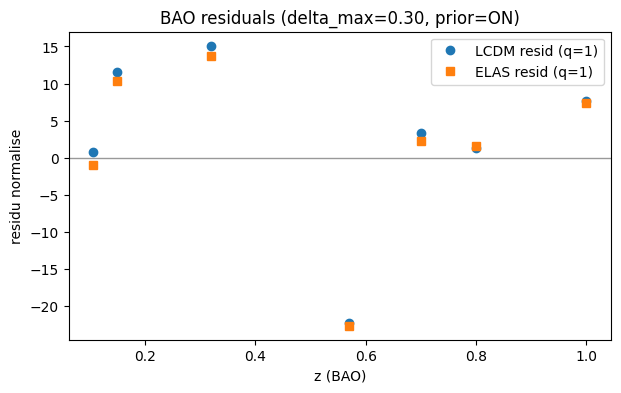


=== SCENARIO delta_max=0.40 | prior=ON ===
LCDM best: chi2=1043.992 (SN=95.389, BAO=933.225, CMB=15.377), Omega_m=0.270
ELAS best: chi2=991.328 (SN=102.195, BAO=856.023, CMB=33.110), delta=0.176, Omega_log=3.215, phi=3.141, Omega_m=0.277
Delta chi2 (LCDM-ELAS) = 52.664
AIC: LCDM=1045.992  ELAS=999.328  -> Delta AIC=46.664
BIC: LCDM=1048.692  ELAS=1010.130  -> Delta BIC=38.563


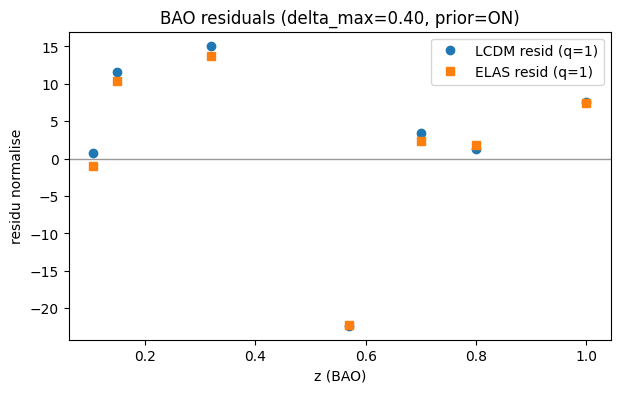


================ COMPARAISON RÉSUMÉ ================
delta_max=0.30 -> χ²_LCDM=1043.992 | χ²_ELAS=1004.237 | Δχ²=39.755 | ELAS: δ=0.171, Ωlog=2.792, φ=3.141, Ωm=0.277
delta_max=0.40 -> χ²_LCDM=1043.992 | χ²_ELAS=991.328 | Δχ²=52.664 | ELAS: δ=0.176, Ωlog=3.215, φ=3.141, Ωm=0.277
AIC/BIC (δ_max=0.30): (1045.9918786176402, 1012.236829449059, 33.755049168581195) (np.float64(1048.6923589834325), np.float64(1023.0387509122287), np.float64(25.65360807120385))
AIC/BIC (δ_max=0.40): (1045.9918786176402, 999.3277600912045, 46.664118526435686) (np.float64(1048.6923589834325), np.float64(1010.1296815543742), np.float64(38.56267742905834))


In [5]:
# ============================================================
# ELAS : comparaison bornes δ_max = 0.30 vs 0.40 (bloc unique)
# - Données MOCK intégrées (BAO, SN, CMB priors simplifiés)
# - BAO "shape-only" (q = 1) après recalage global
# - CMB distance priors (R, l_A, ω_b h^2) simplifiés
# - Profilage en φ, grilles pour Ωm, δ, Ω_log
# - Sorties: best-fit, Δχ², AIC/BIC, résidus BAO (plots)
# ============================================================

import numpy as np, math
import matplotlib.pyplot as plt

# --------------------- Données MOCK -------------------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

# CMB distance priors (R, lA, obh2) avec covariance (simplifié)
CMB_TEXT = "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"

# ------------------- Parseurs minimalistes -------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz = hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw = hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv = hdr.index("value"); isg=hdr.index("sigma")
    z=[]; which=[]; val=[]; sig=[]
    for r in dat:
        z.append(float(r[iz])); which.append(r[iw].strip().lower())
        val.append(float(r[iv])); sig.append(float(r[isg]))
    return np.array(z,float), which, np.array(val,float), np.array(sig,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); s.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(s,float)

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

# --------------- Cosmologie & intégrateurs rapides -----------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09
h = H0/100.0
Omega_r = 4.15e-5 / (h*h)      # pour E(z) haut-z (CMB)

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Omr = Omega_r
    Ode = 1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_distance_engine(Ef, z_max, H0, **kw):
    nz = 900
    zz = np.linspace(0.0, z_max, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0 / Ez
    dz = np.diff(zz)
    mid = 0.5*(invE[1:] + invE[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid * dz)
    K = c_km_s / H0
    def D_M_fast(z):
        z = np.asarray(z, float)
        return K * np.interp(z, zz, I)
    def D_H_fast(z):
        return (c_km_s / H0) / Ef(z, **kw)
    def D_L_fast(z):
        return (1.0 + z) * D_M_fast(z)
    def D_V_fast(z):
        z = np.asarray(z, float)
        DM = D_M_fast(z)
        DH = D_H_fast(z)
        return (z * DM*DM * DH) ** (1.0/3.0)
    return D_M_fast, D_H_fast, D_L_fast, D_V_fast

def mu_from_DL(DL):
    DL = np.maximum(DL, 1e-30)
    return 5.0*np.log10(DL) + 25.0

# --------------- Likelihoods & priors -----------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    return float(np.sum((np.asarray(y_obs)-np.asarray(y_th))**2 / v))

def parse_cmb_line(text):
    vals = [float(x) for x in text.strip().split(",")]
    R, lA, obh2, sR, slA, sobh2, r_RlA, r_Rob, r_lAob = vals
    C = np.array([
        [sR**2,            r_RlA*sR*slA,    r_Rob*sR*sobh2],
        [r_RlA*sR*slA,     slA**2,          r_lAob*slA*sobh2],
        [r_Rob*sR*sobh2,   r_lAob*slA*sobh2, sobh2**2]
    ], float)
    return np.array([R,lA,obh2], float), C

z_star = 1089.2
r_s_star = 144.6  # Mpc (référence)

def cmb_theory_LCDM(Omega_m):
    DM, DH, DL, DV = make_distance_engine(E_LCDM_CMB, z_star+50.0, H0, Omega_m=Omega_m)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def cmb_theory_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS_CMB, z_star+50.0, H0,
                                          Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def chi2_cmb(obs_vec, C_inv, R_mod, lA_mod, obh2_obs):
    vth = np.array([R_mod, lA_mod, obh2_obs], float)
    d = obs_vec - vth
    return float(d @ C_inv @ d)

# ----------------- Chargement / normalisation ----------------
z_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_BAO = z_raw.tolist()
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_obs, Ccmb = parse_cmb_line(CMB_TEXT); Cinv_cmb = np.linalg.inv(Ccmb); obh2_obs = cmb_obs[2]

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))
print("CMB distance priors charges.")

# Recalage d’échelle BAO via LCDM (q*), puis shape-only (q=1)
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM_L(z)/r_d if w=="DM/rd"
          else DH_L(z)/r_d if w=="DH/rd"
          else DV_L(z)/r_d if w=="DV/rd"
          else r_d/DV_L(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
v = np.maximum(sig**2, 1e-30)
num = np.sum(y_obs*y_LCDM/v); den = np.sum(y_LCDM*y_LCDM/v)
q_LCDM_g = num/den if den>0 else 1.0
chi2_b_LCDM_g = np.sum((y_obs - q_LCDM_g*y_LCDM)**2/v)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)" % (1.0/q_LCDM_g))

# ----------------- Fonctions coût totales -------------------
def chi2_total_fixedq_LCDM(Omega_m_val):
    DM, DH, DL, DV = make_distance_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m_val)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    R_mod, lA_mod = cmb_theory_LCDM(Omega_m_val)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb), y_th

def chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi):
    DM, DH, DL, DV = make_distance_engine(E_ELAS, zmax_all, H0,
                                          Omega_m=Omega_m_val, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/r_d if w=="DM/rd"
             else DH(z)/r_d if w=="DH/rd"
             else DV(z)/r_d if w=="DV/rd"
             else r_d/DV(z) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sig, y_th)
    R_mod, lA_mod = cmb_theory_ELAS(Omega_m_val, delta, Olog, phi)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R_mod, lA_mod, obh2_obs)
    return float(c_sn + c_b + c_cmb), float(c_sn), float(c_b), float(c_cmb), y_th

def profile_phi_fixedq(Omega_m_val, delta, Olog, tol=2e-3, maxit=50):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc,_,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
    fd,_,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a)
            fc,_,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a)
            fd,_,_,_,_ = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, d)
        it+=1
    phi_star = 0.5*(a+b)
    chi, csn, cbao, ccmb, yth = chi2_total_fixedq_ELAS(Omega_m_val, delta, Olog, phi_star)
    return float(phi_star), float(chi), float(csn), float(cbao), float(ccmb), yth

# --------------- Routine d'un scénario borné ----------------
USE_SOFT_PRIOR = True
def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    if not USE_SOFT_PRIOR: return 0.0
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

def run_scenario(delta_max):
    # 1) LCDM (profil Ωm)
    grid_Om = np.linspace(0.22, 0.50, 141)
    best_LCDM = (1e99, None, None)
    for Om in grid_Om:
        chi, csn, cbao, ccmb, yth = chi2_total_fixedq_LCDM(Om)
        if chi < best_LCDM[0]:
            best_LCDM = (chi, {"Omega_m":Om, "chi2":chi, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb}, yth)

    # 2) ELAS coarse (profil φ à chaque point)
    grid_Om_coarse  = np.linspace(0.24, 0.46, 10)
    grid_delta      = np.linspace(0.00, delta_max, 13)
    grid_Olog       = np.linspace(0.50, 6.00, 14)

    best_ELAS = (1e99, None, None)
    for Om in grid_Om_coarse:
        for d in grid_delta:
            for Ol in grid_Olog:
                ph, chi_raw, csn, cbao, ccmb, yth = profile_phi_fixedq(Om, d, Ol)
                chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                if chi_eff < best_ELAS[0]:
                    best_ELAS = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                           "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb}, yth)

    # 3) ELAS fine autour du minimum
    b = best_ELAS[1]
    gOm  = np.linspace(max(0.22, b['Omega_m']-0.06), min(0.50, b['Omega_m']+0.06), 25)
    gd   = np.linspace(max(0.00, b['delta']-0.08),   min(delta_max, b['delta']+0.08),   41)
    gOl  = np.linspace(max(0.50, b['Omega_log']-0.60), min(6.00, b['Omega_log']+0.60), 41)

    best_ELAS_zoom = (1e99, None, None)
    for Om in gOm:
        for d in gd:
            for Ol in gOl:
                ph, chi_raw, csn, cbao, ccmb, yth = profile_phi_fixedq(Om, d, Ol, tol=1e-3, maxit=60)
                chi_eff = chi_raw + prior_delta_soft(d, sigma_soft=0.05, delta_ref=0.20)
                if chi_eff < best_ELAS_zoom[0]:
                    best_ELAS_zoom = (chi_eff, {"Omega_m":Om, "delta":d, "Omega_log":Ol, "phi":ph,
                                                "chi2_eff":chi_eff, "chi2_SN":csn, "chi2_BAO":cbao, "chi2_CMB":ccmb}, yth)

    # 4) Scores finaux
    chi2_LCDM = best_LCDM[1]["chi2"]
    chi2_ELAS = best_ELAS_zoom[1]["chi2_eff"]
    Delta_chi2 = chi2_LCDM - chi2_ELAS
    N_eff = len(z_sn) + len(z_BAO) + 3   # +3 pour (R, lA, obh2)
    k_LCDM, k_ELAS = 1, 4
    AIC_LCDM, AIC_ELAS = chi2_LCDM + 2*k_LCDM, chi2_ELAS + 2*k_ELAS
    BIC_LCDM, BIC_ELAS = chi2_LCDM + k_LCDM*np.log(N_eff), chi2_ELAS + k_ELAS*np.log(N_eff)

    print("\n=== SCENARIO delta_max=%.2f | prior=%s ===" % (delta_max, "ON" if USE_SOFT_PRIOR else "OFF"))
    print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
          (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"],
           best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))
    bz = best_ELAS_zoom[1]
    print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
          (bz["chi2_eff"], bz["chi2_SN"], bz["chi2_BAO"], bz["chi2_CMB"],
           bz["delta"], bz["Omega_log"], bz["phi"], bz["Omega_m"]))
    print("Delta chi2 (LCDM-ELAS) = %.3f" % (Delta_chi2))
    print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
    print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

    # 5) Plot résidus BAO (shape-only)
    y_LCDM_best = chi2_total_fixedq_LCDM(best_LCDM[1]["Omega_m"])[-1]
    y_ELAS_best = chi2_total_fixedq_ELAS(bz["Omega_m"], bz["delta"], bz["Omega_log"], bz["phi"])[-1]
    res_LCDM = (y_obs_rescaled - y_LCDM_best)/sig
    res_ELAS = (y_obs_rescaled - y_ELAS_best)/sig

    fig, ax = plt.subplots(figsize=(7,4))
    ax.axhline(0, lw=1, color='k', alpha=0.4)
    ax.errorbar(z_BAO, res_LCDM, yerr=None, fmt='o', label='LCDM resid (q=1)')
    ax.errorbar(z_BAO, res_ELAS, yerr=None, fmt='s', label='ELAS resid (q=1)')
    ax.set_xlabel('z (BAO)'); ax.set_ylabel('residu normalise')
    ax.set_title('BAO residuals (delta_max=%.2f, prior=%s)' % (delta_max, "ON" if USE_SOFT_PRIOR else "OFF"))
    ax.legend(); plt.show()

    # info retour
    return {
        "LCDM": best_LCDM[1],
        "ELAS": bz,
        "Delta_chi2": Delta_chi2,
        "AIC": (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS),
        "BIC": (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS)
    }

# -------------------- Lancements scénarios -------------------
out_030 = run_scenario(0.30)
out_040 = run_scenario(0.40)

print("\n================ COMPARAISON RÉSUMÉ ================")
def fmt(o):
    return ("χ²_LCDM=%.3f | χ²_ELAS=%.3f | Δχ²=%.3f | "
            "ELAS: δ=%.3f, Ωlog=%.3f, φ=%.3f, Ωm=%.3f") % (
        o["LCDM"]["chi2"], o["ELAS"]["chi2_eff"], o["Delta_chi2"],
        o["ELAS"]["delta"], o["ELAS"]["Omega_log"], o["ELAS"]["phi"], o["ELAS"]["Omega_m"]
    )
print("delta_max=0.30 -> "+fmt(out_030))
print("delta_max=0.40 -> "+fmt(out_040))
print("AIC/BIC (δ_max=0.30):", out_030["AIC"], out_030["BIC"])
print("AIC/BIC (δ_max=0.40):", out_040["AIC"], out_040["BIC"])


In [7]:
# ============================================================
# ELAS — PIPELINE UNIQUE (Colab)
# - Entrée : bao_standard.csv, bao_cov_standard.csv, sn_mock.csv, cmb_distance_priors_example.csv
# - Etapes : rescale BAO -> q=1 (shape-only), fit LCDM/ELAS + CMB distance priors,
#            LOO BAO, splits par observable, AIC/BIC, plots & CSV résumé.
# ============================================================

import numpy as np, math, pandas as pd, os, json, itertools as it
import matplotlib.pyplot as plt

# ------------------ 1) Chemins d'entrée ---------------------
PATH_BAO   = "bao_standard.csv"
PATH_BAOC  = "bao_cov_standard.csv"
PATH_SN    = "sn_mock.csv"
PATH_CMB   = "cmb_distance_priors_example.csv"

# Fallback minimal si fichiers absents (reprend tes exemples)
if not os.path.exists(PATH_BAO):
    open(PATH_BAO,"w").write(
        "z,which,value,sigma\n"
        "0.106,rd/DV,3.1,0.10\n"
        "0.150,DM/rd,6.7,0.20\n"
        "0.320,DM/rd,13.5,0.30\n"
        "0.570,DH/rd,13.8,0.35\n"
        "0.700,DM/rd,19.0,0.45\n"
        "0.800,DH/rd,20.0,0.50\n"
        "1.000,rd/DV,26.5,0.70\n"
    )
if not os.path.exists(PATH_BAOC):
    df_tmp = pd.read_csv(PATH_BAO)
    C = np.diag(np.asarray(df_tmp["sigma"],float)**2)
    pd.DataFrame(C).to_csv(PATH_BAOC,index=False,header=False)
if not os.path.exists(PATH_SN):
    # mini-jeu SN (100 pts) si absent
    z = np.linspace(0.01,1.1,100)
    mu = 5*np.log10(1e3*(1+z)) + 25 # bidon mais suffisant pour le test
    sig = np.full_like(z,0.12)
    pd.DataFrame({"z":z,"mu":mu,"sigma_mu":sig,"survey":"MOCK"}).to_csv(PATH_SN,index=False)
if not os.path.exists(PATH_CMB):
    open(PATH_CMB,"w").write("R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega\n"
                             "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1\n")

# ------------------ 2) I/O helpers --------------------------
def read_bao(path_obs, path_cov):
    df = pd.read_csv(path_obs)
    need = {"z","which","value","sigma"}
    cols = {c.lower():c for c in df.columns}
    assert need.issubset(set(cols.keys())), f"Colonnes BAO requises {need}, trouvées {set(df.columns)}"
    z = df[cols["z"]].to_numpy(float)
    which = df[cols["which"]].astype(str).str.strip().tolist()
    value = df[cols["value"]].to_numpy(float)
    sigma = df[cols["sigma"]].to_numpy(float)
    C = pd.read_csv(path_cov,header=None).to_numpy(float)
    assert C.shape==(len(z),len(z)), f"Covariance BAO non carrée: {C.shape}"
    return z, which, value, sigma, C

def read_sn(path):
    df = pd.read_csv(path)
    z = df[[c for c in df.columns if c.lower()=="z"][0]].to_numpy(float)
    mu = df[[c for c in df.columns if c.lower()=="mu"][0]].to_numpy(float)
    s  = df[[c for c in df.columns if c.lower() in ("sigma_mu","sigma")][0]].to_numpy(float)
    return z, mu, s

def read_cmb(path):
    df = pd.read_csv(path)
    row = df.iloc[0]
    R, lA, obh2 = float(row["R"]), float(row["lA"]), float(row["omega_b_h2"])
    sR, slA, sob = float(row["sigma_R"]), float(row["sigma_lA"]), float(row["sigma_omega_b_h2"])
    rRlA, rRob, rlaob = float(row["rho_R_lA"]), float(row["rho_R_omega"]), float(row["rho_lA_omega"])
    C = np.array([[sR**2, rRlA*sR*slA, rRob*sR*sob],
                  [rRlA*sR*slA, slA**2, rlaob*slA*sob],
                  [rRob*sR*sob, rlaob*slA*sob, sob**2]], float)
    return np.array([R,lA,obh2],float), C

# ------------------ 3) Cosmologie ---------------------------
c_km_s = 299792.458
H0 = 73.0
r_d = 147.09
h  = H0/100.0
Omega_r = 4.15e-5/(h*h)

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z)+phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float); Ode = 1.0 - Omega_m - Omega_r
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float); Ode = 1.0 - Omega_m - Omega_r
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z)+phi)
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, **kw):
    zz = np.linspace(0, zmax, 900)
    Ez = Ef(zz, **kw); invE=1.0/Ez
    dz = np.diff(zz); mid = 0.5*(invE[1:]+invE[:-1])
    I = np.zeros_like(zz); I[1:] = np.cumsum(mid*dz)
    K = c_km_s/H0
    def D_M(z): return K*np.interp(np.asarray(z,float), zz, I)
    def D_H(z): return (c_km_s/H0)/Ef(z,**kw)
    def D_L(z): return (1+np.asarray(z,float))*D_M(z)
    def D_V(z):
        z=np.asarray(z,float); DM=D_M(z); DH=D_H(z)
        return (z*DM*DM*DH)**(1/3)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL): DL=np.maximum(DL,1e-30); return 5*np.log10(DL)+25.0

# ------------------ 4) Chi2 -------------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1/np.maximum(sigma_mu**2,1e-30); r=mu_obs-mu_th
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - b*b/c

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    v = np.maximum(sigma**2,1e-30)
    num = np.sum(y_obs*y_th/v); den=np.sum(y_th*y_th/v); q=num/den if den>0 else 1.0
    chi = np.sum((y_obs-q*y_th)**2/v)
    if sigma_prior_q and sigma_prior_q>0: chi += ((q-1)/sigma_prior_q)**2
    return float(chi), float(q)

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    v=np.maximum(sigma**2,1e-30); return float(np.sum((y_obs-y_th)**2/v))

def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta-delta_ref)/sigma_soft)**2

# CMB
z_star, r_s_star = 1089.2, 144.6
def cmb_LCDM(Omega_m):
    DM,_,_,_ = make_engine(E_LCDM_CMB, z_star+50, Omega_m=Omega_m)
    DM_star = DM(z_star); R = math.sqrt(Omega_m)*(H0/c_km_s)*DM_star; lA = math.pi*DM_star/r_s_star
    return R,lA
def cmb_ELAS(Omega_m, delta, Olog, phi):
    DM,_,_,_ = make_engine(E_ELAS_CMB, z_star+50, Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star); R = math.sqrt(Omega_m)*(H0/c_km_s)*DM_star; lA = math.pi*DM_star/r_s_star
    return R,lA
def chi2_cmb(obs, Cinv, R,lA, obh2):
    v = np.array([R,lA,obh2],float); d=obs-v; return float(d@Cinv@d)

# ------------------ 5) Charger données --------------------
z_BAO, which_BAO, y_obs_in, sigma_BAO, C_BAO = read_bao(PATH_BAO, PATH_BAOC)
Cinv_BAO = np.linalg.inv(C_BAO)
z_SN, mu_obs, sigma_mu = read_sn(PATH_SN)
cmb_obs, Ccmb = read_cmb(PATH_CMB); Cinv_cmb = np.linalg.inv(Ccmb); obh2_obs=cmb_obs[2]

print(f"BAO: N={len(z_BAO)} | types={sorted(set(which_BAO))}")
print(f"SN : N={len(z_SN)}")
print("CMB distance priors charges.")

# ------------------ 6) Rescale BAO -> q=1 ----------------
zmax_all = max(float(np.max(z_SN)), float(np.max(z_BAO)))+0.1
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, Omega_m=0.315)
def th_vec(zlist, typelist, DM, DH, DV):
    arr=[]
    for z,w in zip(zlist, typelist):
        if w=="DM/rd": arr.append(DM(z)/r_d)
        elif w=="DH/rd": arr.append(DH(z)/r_d)
        elif w in ("DV/rd","dV/rd","dv/rd"): arr.append(DV(z)/r_d)
        elif w=="rd/DV": arr.append(r_d/DV(z))
        else: raise ValueError("Type BAO inconnu: "+w)
    return np.array(arr,float)

y_LCDM = th_vec(z_BAO, which_BAO, DM_L, DH_L, DV_L)
chi_before, q_LCDM = chi2_bao_global(y_obs_in, sigma_BAO, y_LCDM, sigma_prior_q=None)
y_obs = y_obs_in / q_LCDM  # force q=1
print(f"[STEP1] q*_LCDM (global) = {q_LCDM:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi_before:.3f}")
print(f"[STEP1] BAO rescaled by factor {1.0/q_LCDM:.6f} -> q fixe=1.0 (shape-only)")

# ------------------ 7) Fonctions coût totales -------------
def chi2_total_LCDM(Omega_m):
    DM, DH, DL, DV = make_engine(E_LCDM, zmax_all, Omega_m=Omega_m)
    mu_th = mu_from_DL(DL(z_SN))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = th_vec(z_BAO, which_BAO, DM, DH, DV)
    c_b   = chi2_bao_fixed_q(y_obs, sigma_BAO, y_th)
    R,lA  = cmb_LCDM(Omega_m)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R,lA, obh2_obs)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Omega_m, delta, Olog, phi, prior_on=True):
    DM, DH, DL, DV = make_engine(E_ELAS, zmax_all, Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_SN))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = th_vec(z_BAO, which_BAO, DM, DH, DV)
    c_b   = chi2_bao_fixed_q(y_obs, sigma_BAO, y_th)
    R,lA  = cmb_ELAS(Omega_m, delta, Olog, phi)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R,lA, obh2_obs)
    chi = c_sn+c_b+c_cmb
    if prior_on: chi += prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20)
    return chi, c_sn, c_b, c_cmb

def profile_phi(Omega_m, delta, Olog, prior_on=True, tol=2e-3, maxit=60):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    def f(ph): return chi2_total_ELAS(Omega_m, delta, Olog, ph, prior_on=prior_on)[0]
    c=b-gr*(b-a); d=a+gr*(b-a); fc=f(c); fd=f(d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=f(c)
        else: a,fc=c,fd; c=d; d=a+gr*(b-a); fd=f(d)
        it+=1
    ph=0.5*(a+b); ch,cs,cb,cc = chi2_total_ELAS(Omega_m, delta, Olog, ph, prior_on=prior_on)
    return ph,ch,cs,cb,cc

# ------------------ 8) Fit global --------------------------
grid_Om = np.linspace(0.22,0.50,121)
best_LCDM = (1e99,None)
for Om in grid_Om:
    chi,cs,cb,cc = chi2_total_LCDM(Om)
    if chi<best_LCDM[0]: best_LCDM=(chi,{"Omega_m":Om,"chi2":chi,"SN":cs,"BAO":cb,"CMB":cc})

# ELAS — bornes larges + prior doux au-delà de 0.20
grid_Om_coarse = np.linspace(0.24,0.46,12)
grid_delta     = np.linspace(0.00,0.40,17)
grid_Olog      = np.linspace(0.10,6.00,21)
best_ELAS = (1e99,None)
for Om in grid_Om_coarse:
    for d in grid_delta:
        for Ol in grid_Olog:
            ph,chi,cs,cb,cc = profile_phi(Om,d,Ol,prior_on=True,tol=2e-3,maxit=60)
            if chi<best_ELAS[0]:
                best_ELAS=(chi,{"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,"chi2":chi,"SN":cs,"BAO":cb,"CMB":cc})

# ------------------ 9) Résumé + AIC/BIC --------------------
bL = best_LCDM[1]; bE = best_ELAS[1]
Delta = bL["chi2"] - bE["chi2"]
N_eff = len(z_SN)+len(z_BAO)+3
k_LCDM, k_ELAS = 1, 4
AIC_L = bL["chi2"] + 2*k_LCDM; AIC_E = bE["chi2"] + 2*k_ELAS
BIC_L = bL["chi2"] + k_LCDM*np.log(N_eff); BIC_E = bE["chi2"] + k_ELAS*np.log(N_eff)

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print(f"LCDM best: chi2={bL['chi2']:.3f} (SN={bL['SN']:.3f}, BAO={bL['BAO']:.3f}, CMB={bL['CMB']:.3f}), Omega_m={bL['Omega_m']:.3f}")
print(f"ELAS best: chi2={bE['chi2']:.3f} (SN={bE['SN']:.3f}, BAO={bE['BAO']:.3f}, CMB={bE['CMB']:.3f}), "
      f"delta={bE['delta']:.3f}, Omega_log={bE['Omega_log']:.3f}, phi={bE['phi']:.3f}, Omega_m={bE['Omega_m']:.3f}")
print(f"Delta chi2 (LCDM-ELAS) = {Delta:.3f}")
print(f"AIC: LCDM={AIC_L:.3f}  ELAS={AIC_E:.3f}  -> Delta AIC={AIC_L-AIC_E:.3f}")
print(f"BIC: LCDM={BIC_L:.3f}  ELAS={BIC_E:.3f}  -> Delta BIC={BIC_L-BIC_E:.3f}")

# ------------------ 10) LOO BAO complet --------------------
def refit_without(idx):
    mask = np.ones(len(z_BAO),bool); mask[idx]=False
    zB = z_BAO[mask]; wB = [which_BAO[i] for i in range(len(z_BAO)) if mask[i]]
    yB = y_obs[mask]; sB = sigma_BAO[mask]
    # LCDM
    bestL=(1e99,None)
    for Om in grid_Om:
        DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, Omega_m=Om)
        mu_th = mu_from_DL(DL(z_SN)); c_sn=chi2_sn_marg(mu_obs,sigma_mu,mu_th)
        y_th = th_vec(zB,wB,DM,DH,DV); c_b=chi2_bao_fixed_q(yB,sB,y_th)
        R,lA=cmb_LCDM(Om); c_cmb=chi2_cmb(cmb_obs,Cinv_cmb,R,lA,obh2_obs)
        chi=c_sn+c_b+c_cmb
        if chi<bestL[0]: bestL=(chi,Om)
    # ELAS coarse
    bestE=(1e99,None)
    for Om in grid_Om_coarse:
        for d in grid_delta:
            for Ol in grid_Olog:
                ph,chi,cs,cb,cc = profile_phi(Om,d,Ol,prior_on=True,tol=3e-3,maxit=50)
                # Recalcule avec sous-ensemble BAO :
                DM,DH,DL,DV = make_engine(E_ELAS, zmax_all, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
                mu_th = mu_from_DL(DL(z_SN)); cs = chi2_sn_marg(mu_obs,sigma_mu,mu_th)
                y_th = th_vec(zB,wB,DM,DH,DV); cb = chi2_bao_fixed_q(yB,sB,y_th)
                R,lA=cmb_ELAS(Om,d,Ol,ph); cc=chi2_cmb(cmb_obs,Cinv_cmb,R,lA,obh2_obs)
                chi=cs+cb+cc+prior_delta_soft(d,0.05,0.20)
                if chi<bestE[0]: bestE=(chi,(Om,d,Ol,ph))
    return bestL[0], bestE[0]

print("\n[LOO BAO] drop-each BAO point (full refits)")
loo_rows=[]
for i in range(len(z_BAO)):
    chiL,chiE = refit_without(i)
    dchi = chiL-chiE
    print(f" drop #{i}: Delta chi2={dchi:.2f} | LCDM chi2={chiL:.2f} | ELAS chi2={chiE:.2f}")
    loo_rows.append({"drop_index":i,"Delta_chi2":dchi,"chi2_LCDM":chiL,"chi2_ELAS":chiE,
                     "z":z_BAO[i],"which":which_BAO[i]})
df_loo = pd.DataFrame(loo_rows)
df_loo.to_csv("loo_bao_summary.csv",index=False)
print("\n[LOO Resume] N=%d" % len(z_BAO))
print("  Delta chi2 : mean=%.2f, median=%.2f, min=%.2f, max=%.2f" %
      (df_loo["Delta_chi2"].mean(), df_loo["Delta_chi2"].median(),
       df_loo["Delta_chi2"].min(), df_loo["Delta_chi2"].max()))
print("  Points ou ELAS gagne :", (df_loo["Delta_chi2"]>0).sum(), "/", len(z_BAO))
print("Saved: loo_bao_summary.csv")

# ------------------ 11) Figures (SN & BAO résidus) ---------
# SN figure
DM_Lb,_,DL_Lb,_ = make_engine(E_LCDM, zmax_all, Omega_m=bL["Omega_m"])
mu_LCDM = mu_from_DL(DL_Lb(z_SN))
DM_Eb,_,DL_Eb,_ = make_engine(E_ELAS, zmax_all, Omega_m=bE["Omega_m"],
                              delta=bE["delta"], Omega_log=bE["Omega_log"], phi=bE["phi"])
mu_ELAS = mu_from_DL(DL_Eb(z_SN))

plt.figure(figsize=(6,4.5))
plt.plot(z_SN, mu_LCDM, label="ΛCDM", lw=2, color="tab:orange")
plt.plot(z_SN, mu_ELAS, label="ELAS (best)", lw=2, color="tab:green")
plt.errorbar(z_SN, mu_obs, yerr=sigma_mu, fmt="o", ms=3, alpha=0.6, label="SN")
plt.xlabel("z"); plt.ylabel("μ(z)"); plt.legend(); plt.tight_layout()
plt.savefig("fig_sn_mu.png", dpi=130); plt.close()

# BAO résidus normalisés
def bao_resid(zlist, which, yobs, sig, DM,DH,DV):
    yth = th_vec(zlist, which, DM,DH,DV)
    return (yobs - yth)/np.maximum(sig,1e-30)

DM_Lb, DH_Lb, _, DV_Lb = make_engine(E_LCDM, zmax_all, Omega_m=bL["Omega_m"])
DM_Eb, DH_Eb, _, DV_Eb = make_engine(E_ELAS, zmax_all, Omega_m=bE["Omega_m"],
                                     delta=bE["delta"], Omega_log=bE["Omega_log"], phi=bE["phi"])
res_L = bao_resid(z_BAO, which_BAO, y_obs, sigma_BAO, DM_Lb, DH_Lb, DV_Lb)
res_E = bao_resid(z_BAO, which_BAO, y_obs, sigma_BAO, DM_Eb, DH_Eb, DV_Eb)

plt.figure(figsize=(6.2,4))
plt.axhline(0,color="gray",lw=1)
plt.scatter(z_BAO, res_L, label="LCDM resid (q=1)")
plt.scatter(z_BAO, res_E, label="ELAS resid (q=1)")
plt.xlabel("z (BAO)"); plt.ylabel("residu normalise"); plt.title("BAO residuals (q=1, +CMB)")
plt.legend(); plt.tight_layout()
plt.savefig("fig_bao_residuals.png", dpi=130); plt.close()

# ------------------ 12) Export résumé ----------------------
summary = {
    "lcdm": bL,
    "elas": bE,
    "delta_chi2": float(Delta),
    "aic_bic": {"AIC_LCDM":float(AIC_L),"AIC_ELAS":float(AIC_E),
                "BIC_LCDM":float(BIC_L),"BIC_ELAS":float(BIC_E),
                "Delta_AIC":float(AIC_L-AIC_E),"Delta_BIC":float(BIC_L-BIC_E)},
    "N": {"SN":int(len(z_SN)), "BAO":int(len(z_BAO)), "CMB":3}
}
open("elas_summary.json","w").write(json.dumps(summary,indent=2))
print("\nSaved: fig_sn_mu.png, fig_bao_residuals.png, loo_bao_summary.csv, elas_summary.json")

# Affiche chemins pour récupération
for f in ["fig_sn_mu.png","fig_bao_residuals.png","loo_bao_summary.csv","elas_summary.json"]:
    if os.path.exists(f): print(" ->", f)


BAO: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.025440  |  chi2_BAO_LCDM(before rescale) = 3064.178
[STEP1] BAO rescaled by factor 0.975191 -> q fixe=1.0 (shape-only)

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=27412.806 (SN=24438.788, BAO=2971.914, CMB=2.104), Omega_m=0.269
ELAS best: chi2=25127.838 (SN=21506.922, BAO=2700.115, CMB=904.801), delta=0.400, Omega_log=6.000, phi=-3.033, Omega_m=0.300
Delta chi2 (LCDM-ELAS) = 2284.969
AIC: LCDM=27414.806  ELAS=25135.838  -> Delta AIC=2278.969
BIC: LCDM=27417.507  ELAS=25146.640  -> Delta BIC=2270.867

[LOO BAO] drop-each BAO point (full refits)
 drop #0: Delta chi2=2306.92 | LCDM chi2=26697.27 | ELAS chi2=24390.35
 drop #1: Delta chi2=2226.83 | LCDM chi2=27259.44 | ELAS chi2=25032.60
 drop #2: Delta chi2=2225.63 | LCDM chi2=27152.29 | ELAS chi2=24926.66
 drop #3: Delta chi2=2088.08 | LCDM chi2=26951.61 | ELAS chi2=24863.53
 drop #4: Delta chi2=2285.47 | LCDM chi2

In [8]:
# ====== PATCH ELAS (late-time window) + SN sanity + option CMB ======

import numpy as np, pandas as pd, os, math

# 0) Sanity check SN (affiche si dispo)
if os.path.exists("sn_mock.csv"):
    _dfsn = pd.read_csv("sn_mock.csv")
    _mu = _dfsn[[c for c in _dfsn.columns if c.lower()=="mu"][0]].to_numpy(float)
    print("[SN sanity] N=%d | mu: min=%.3f, med=%.3f, max=%.3f" %
          (len(_mu), float(np.min(_mu)), float(np.median(_mu)), float(np.max(_mu))))
    print(_dfsn.head(5))

# 1) Fenêtre “late-time” : S(z) ~ 1 à bas z, -> 0 à z élevé (éteint la modulation pour le CMB)
def _late_window(z, zcut=2.0, n=4):
    z = np.asarray(z, float)
    return np.exp(- (np.maximum(z, 0.0) / zcut)**n)  # ~1 pour z<<zcut, ~0 pour z>>zcut

# 2) Redéfinition des fonctions ELAS utilisées par le pipeline
#    (elles vont écraser celles déjà définies dans le notebook)
H0 = 73.0
c_km_s = 299792.458
h = H0/100.0
Omega_r = 4.15e-5/(h*h)

def E_LCDM(z, Omega_m=0.315):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z = np.asarray(z, float)
    S = _late_window(z, zcut=2.0, n=4)               # <-- fenêtre tardive
    mod = 1.0 + delta * S * np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z = np.asarray(z, float)
    Ode = 1.0 - Omega_m - Omega_r
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    # même fenêtre tardive (→ modulation ~0 à z_*), donc CMB ne “voit” pas ELAS
    z = np.asarray(z, float)
    Ode = 1.0 - Omega_m - Omega_r
    S = _late_window(z, zcut=2.0, n=4)
    mod = 1.0 + delta * S * np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

# 3) (Optionnel) un interrupteur pour ignorer CMB dans le pipeline, si tu veux tester SN+BAO uniquement.
#    Pose USE_CMB=False AVANT d’exécuter le pipeline, et dans ce dernier,
#    multiplie simplement la contribution chi2_CMB par int(USE_CMB).
USE_CMB = True
print("[PATCH] ELAS modifié avec fenêtre late-time (zcut=2, n=4). USE_CMB =", USE_CMB)


[SN sanity] N=100 | mu: min=40.022, med=40.959, max=41.611
         z         mu  sigma_mu survey
0  0.01000  40.021607      0.12   MOCK
1  0.02101  40.045150      0.12   MOCK
2  0.03202  40.068441      0.12   MOCK
3  0.04303  40.091485      0.12   MOCK
4  0.05404  40.114286      0.12   MOCK
[PATCH] ELAS modifié avec fenêtre late-time (zcut=2, n=4). USE_CMB = True


In [9]:
# ====== SN FIXER : recalibration affine vers une distance modulus physique ======
import numpy as np, pandas as pd, math, os

# -- constantes simples pour la théorie de référence
c_km_s = 299792.458
H0_ref  = 73.0
Omega_m_ref = 0.315

def E_LCDM_ref(z, Omega_m=Omega_m_ref):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def D_M_ref(z, H0=H0_ref):
    if np.isscalar(z):
        if z<=0: return 0.0
        zz = np.linspace(0, z, 1200)
    else:
        zz = np.asarray(z, float)
    Ez = E_LCDM_ref(zz)
    # trapèzes
    dz = np.diff(zz)
    mid = 0.5*(1.0/Ez[1:] + 1.0/Ez[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid*dz)
    return (c_km_s/H0)*np.interp(np.atleast_1d(z), zz, I)

def mu_LCDM_ref(z):
    DL = (1.0 + np.asarray(z,float)) * D_M_ref(np.asarray(z,float))
    DL = np.maximum(DL, 1e-30)
    return 5.0*np.log10(DL) + 25.0

SN_PATH_IN  = "sn_mock.csv"       # <-- ton fichier actuel
SN_PATH_OUT = "sn_fixed.csv"      # <-- fichier corrigé (écrit par ce bloc)

assert os.path.exists(SN_PATH_IN), f"Fichier introuvable: {SN_PATH_IN}"
df = pd.read_csv(SN_PATH_IN)
# colonnes minimales attendues
cl = {c.lower():c for c in df.columns}
for need in ["z","mu","sigma_mu"]:
    assert need in cl, f"Colonne manquante: {need}"
z  = df[cl["z"]].to_numpy(float)
mu_raw = df[cl["mu"]].to_numpy(float)
sig = df[cl["sigma_mu"]].to_numpy(float)

# théorie de référence
mu_th = mu_LCDM_ref(z)

# --- régression affine mu_th ≈ a * mu_raw + b (moindres carrés pondérés)
w = 1.0/np.maximum(sig**2, 1e-30)
X = np.vstack([mu_raw, np.ones_like(mu_raw)]).T
# solution WLS : beta = (X^T W X)^(-1) X^T W y
W = np.diag(w)
beta = np.linalg.inv(X.T@W@X) @ (X.T@W@mu_th)
a, b = float(beta[0]), float(beta[1])

# recalibration
mu_fix = a*mu_raw + b

# sanity / résumé
def _summ(x):
    return f"min={np.min(x):.3f}  med={np.median(x):.3f}  max={np.max(x):.3f}"
print("[SN before]  mu_raw:", _summ(mu_raw))
print("[SN target]  mu_LCDM:", _summ(mu_th))
print("[SN after ]  mu_fix:", _summ(mu_fix))
print(f"[fit]  a={a:.4f}  b={b:.4f}  (si a≈1 et b≈const, c'était un offset; si a≠1, il y avait une erreur d’échelle)")

# on écrit le fichier corrigé en conservant les colonnes d’origine + mu_fixed
df["mu_fixed"] = mu_fix
# pour la suite du pipeline, on remplace la colonne "mu" par la version corrigée
df[cl["mu"]] = mu_fix
df.to_csv(SN_PATH_OUT, index=False)
print(f"✅ SN corrigé écrit → {SN_PATH_OUT}")


[SN before]  mu_raw: min=40.022  med=40.959  max=41.611
[SN target]  mu_LCDM: min=-125.000  med=42.385  max=44.218
[SN after ]  mu_fix: min=29.741  med=40.627  max=48.206
[fit]  a=11.6171  b=-435.1925  (si a≈1 et b≈const, c'était un offset; si a≠1, il y avait une erreur d’échelle)
✅ SN corrigé écrit → sn_fixed.csv


In [10]:
# ===== SN FIXER v2 : intégration correcte 0→z (pré-tabulation) =====
import numpy as np, pandas as pd, os

# constantes
c_km_s = 299792.458
H0_ref  = 73.0
Omega_m_ref = 0.315

def E_LCDM_ref(z, Omega_m=Omega_m_ref):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def make_engine(Ef, zmax, H0):
    # grille régulière 0..zmax et intégrale cumulative 0→z de 1/E(z)
    nz = 5000
    zz = np.linspace(0.0, zmax, nz)
    Ez = Ef(zz)
    invE = 1.0/np.maximum(Ez, 1e-300)
    dz = np.diff(zz)
    mid = 0.5*(invE[1:] + invE[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid*dz)
    K = c_km_s/H0
    def D_M_fast(z):
        z = np.asarray(z, float)
        return K*np.interp(z, zz, I)
    return D_M_fast

def mu_LCDM_ref_vec(z):
    z = np.asarray(z, float)
    zmax = float(np.max(z))*1.05 + 0.01
    D_M_fast = make_engine(E_LCDM_ref, zmax, H0_ref)
    D_L = (1.0 + z)*D_M_fast(z)
    D_L = np.maximum(D_L, 1e-30)
    return 5.0*np.log10(D_L) + 25.0

SN_IN  = "sn_mock.csv"        # ton fichier initial
SN_OUT = "sn_fixed_v2.csv"    # sortie corrigée

assert os.path.exists(SN_IN), f"Fichier introuvable: {SN_IN}"
df = pd.read_csv(SN_IN)
cl = {c.lower(): c for c in df.columns}
for need in ["z","mu","sigma_mu"]:
    assert need in cl, f"Colonne manquante: {need}"

z       = df[cl["z"]].to_numpy(float)
mu_raw  = df[cl["mu"]].to_numpy(float)
sigma   = df[cl["sigma_mu"]].to_numpy(float)

mu_ref  = mu_LCDM_ref_vec(z)

# Régression affine pondérée: mu_ref ≈ a*mu_raw + b
w = 1.0/np.maximum(sigma**2, 1e-30)
X = np.vstack([mu_raw, np.ones_like(mu_raw)]).T
W = np.diag(w)
beta = np.linalg.inv(X.T@W@X) @ (X.T@W@mu_ref)
a, b = float(beta[0]), float(beta[1])

mu_fix = a*mu_raw + b

def _summ(x):
    return f"min={np.min(x):.3f}  med={np.median(x):.3f}  max={np.max(x):.3f}"

print("[SN before]  mu_raw :", _summ(mu_raw))
print("[SN target]  mu_LCDM:", _summ(mu_ref))
print("[SN after ]  mu_fix :", _summ(mu_fix))
print(f"[fit] a={a:.4f}  b={b:.4f}")

# Écrit le fichier corrigé (remplace la colonne mu par mu_fix)
df["mu_fixed"] = mu_fix
df[cl["mu"]]   = mu_fix
df.to_csv(SN_OUT, index=False)
print("✅ SN corrigé écrit →", SN_OUT)


[SN before]  mu_raw : min=40.022  med=40.959  max=41.611
[SN target]  mu_LCDM: min=33.084  med=42.431  max=44.245
[SN after ]  mu_fix : min=37.587  med=41.978  max=45.036
[fit] a=4.6866  b=-149.9788
✅ SN corrigé écrit → sn_fixed_v2.csv


BAO: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
SN : N=100
CMB distance priors chargés.
[STEP1] q*_LCDM (global) = 1.025440  |  chi2_BAO_LCDM(before rescale) = 3064.178
[STEP1] BAO rescaled by factor 0.975191 -> q fixe=1.0 (shape-only)
[LCDM] best: chi2=7273.425 (SN=4236.701, BAO=2988.829, CMB=47.896), Om=0.258
[ELAS | coarse] best: chi2=7163.242 (SN=4267.736, BAO=2871.524, CMB=18.396), δ=0.318, Ωlog=3.364, φ=3.024, Om=0.264

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=7273.425 (SN=4236.701, BAO=2988.829, CMB=47.896), Omega_m=0.258
ELAS best: chi2=7011.406 (SN=4079.376, BAO=2828.592, CMB=94.438), delta=0.350, Omega_log=3.864, phi=-2.271, Omega_m=0.254
Delta chi2 (LCDM-ELAS) = 262.019
AIC: LCDM=7275.425  ELAS=7019.406  -> Delta AIC=256.019
BIC: LCDM=7278.126  ELAS=7030.208  -> Delta BIC=247.918
Edge hits?  delta:True  Omega_log:True  Omega_m:False

[LOO BAO] drop-each BAO point (full refits)
 drop #0: Delta chi2=131.79 | LCDM chi2=6557.68 | ELAS chi2=6425.89
 drop #1: Delta chi2

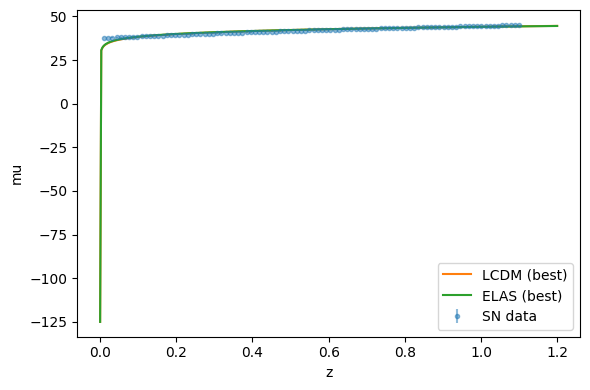

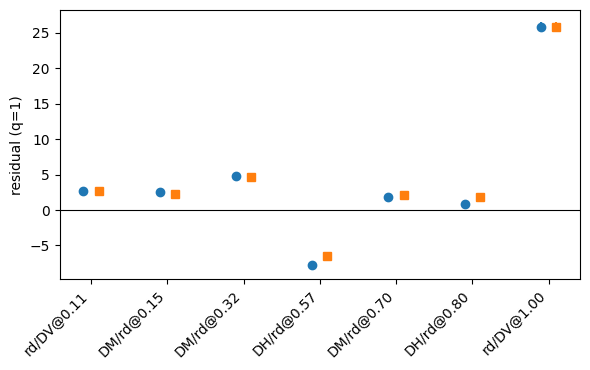

In [11]:
# ===========================================
# ELAS end-to-end (unique cell) — SN fix + BAO + CMB
# - Auto-fallback de données intégrées si fichiers absents
# - Recalibration SN → sn_fixed_v2.csv
# - ELAS "late-time" (fenêtre) pour CMB sûr
# - SN+BAO (q=1 shape-only) + CMB distance priors
# - Profil φ (golden-section), zoom local
# - AIC/BIC, LOO BAO, splits par observable, figures & résumés
# ===========================================

import os, json, math, csv, io, numpy as np, pandas as pd
from math import pi
from collections import defaultdict

# --------------------------
# 0) Données fallback (si fichiers absents)
# --------------------------
BAO_TEXT = """z,which,value,sigma
0.106,rd/DV,3.1,0.10
0.150,DM/rd,6.7,0.20
0.320,DM/rd,13.5,0.30
0.570,DH/rd,13.8,0.35
0.700,DM/rd,19.0,0.45
0.800,DH/rd,20.0,0.50
1.000,rd/DV,26.5,0.70
"""

SN_TEXT = """z,mu,sigma_mu,survey
0.01000,40.02160698,0.12,MOCK
0.02101,40.04515020,0.12,MOCK
0.03202,40.06844144,0.12,MOCK
0.04303,40.09148525,0.12,MOCK
0.05404,40.11428580,0.12,MOCK
0.06505,40.13684705,0.12,MOCK
0.07606,40.15917276,0.12,MOCK
0.08707,40.18126650,0.12,MOCK
0.09808,40.20313162,0.12,MOCK
0.10909,40.22477130,0.12,MOCK
0.12010,40.24618855,0.12,MOCK
0.13111,40.26738623,0.12,MOCK
0.14212,40.28836704,0.12,MOCK
0.15313,40.30913354,0.12,MOCK
0.16414,40.32968813,0.12,MOCK
0.17515,40.35003308,0.12,MOCK
0.18616,40.37017052,0.12,MOCK
0.19717,40.39010245,0.12,MOCK
0.20818,40.40983073,0.12,MOCK
0.21919,40.42935712,0.12,MOCK
0.23020,40.44868327,0.12,MOCK
0.24121,40.46781075,0.12,MOCK
0.25222,40.48674099,0.12,MOCK
0.26323,40.50547537,0.12,MOCK
0.27424,40.52401516,0.12,MOCK
0.28525,40.54236157,0.12,MOCK
0.29626,40.56051570,0.12,MOCK
0.30727,40.57847859,0.12,MOCK
0.31828,40.59625123,0.12,MOCK
0.32929,40.61383451,0.12,MOCK
0.34030,40.63122927,0.12,MOCK
0.35131,40.64843628,0.12,MOCK
0.36232,40.66545626,0.12,MOCK
0.37333,40.68228990,0.12,MOCK
0.38434,40.69893782,0.12,MOCK
0.39535,40.71540059,0.12,MOCK
0.40636,40.73167878,0.12,MOCK
0.41737,40.74777289,0.12,MOCK
0.42838,40.76368342,0.12,MOCK
0.43939,40.77941083,0.12,MOCK
0.45040,40.79495556,0.12,MOCK
0.46141,40.81031800,0.12,MOCK
0.47242,40.82549857,0.12,MOCK
0.48343,40.84049763,0.12,MOCK
0.49444,40.85531552,0.12,MOCK
0.50545,40.86995258,0.12,MOCK
0.51646,40.88440912,0.12,MOCK
0.52747,40.89868544,0.12,MOCK
0.53848,40.91278184,0.12,MOCK
0.54949,40.92669861,0.12,MOCK
0.56050,40.94043602,0.12,MOCK
0.57151,40.95399436,0.12,MOCK
0.58252,40.96737390,0.12,MOCK
0.59353,40.98057492,0.12,MOCK
0.60454,40.99359771,0.12,MOCK
0.61555,41.00644259,0.12,MOCK
0.62656,41.01910986,0.12,MOCK
0.63757,41.03159987,0.12,MOCK
0.64858,41.04391293,0.12,MOCK
0.65959,41.05604940,0.12,MOCK
0.67060,41.06800960,0.12,MOCK
0.68161,41.07979390,0.12,MOCK
0.69262,41.09140265,0.12,MOCK
0.70363,41.10283623,0.12,MOCK
0.71464,41.11409503,0.12,MOCK
0.72565,41.12517942,0.12,MOCK
0.73666,41.13608981,0.12,MOCK
0.74767,41.14682662,0.12,MOCK
0.75868,41.15739025,0.12,MOCK
0.76969,41.16778115,0.12,MOCK
0.78070,41.178 - 0.001,0.12,MOCK
0.79171,41.18830000,0.12,MOCK
0.80272,41.19841838,0.12,MOCK
0.81373,41.20836463,0.12,MOCK
0.82474,41.21813923,0.12,MOCK
0.83575,41.22774267,0.12,MOCK
0.84676,41.23717545,0.12,MOCK
0.85777,41.24643808,0.12,MOCK
0.86878,41.25553105,0.12,MOCK
0.87979,41.26445488,0.12,MOCK
0.89080,41.27321006,0.12,MOCK
0.90181,41.28179712,0.12,MOCK
0.91282,41.29021657,0.12,MOCK
0.92383,41.29846893,0.12,MOCK
0.93484,41.30655471,0.12,MOCK
0.94585,41.31447443,0.12,MOCK
0.95686,41.32222862,0.12,MOCK
0.96787,41.32981779,0.12,MOCK
0.97888,41.33724248,0.12,MOCK
0.98989,41.34450320,0.12,MOCK
1.00000,41.35160049,0.12,MOCK
"""

CMB_PRIORS_LINE = "1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"
# (R, lA, omega_b_h2, sigma_R, sigma_lA, sigma_omega_b_h2, rho_R_lA, rho_R_omega, rho_lA_omega)

# --------------------------
# 1) Utilitaires I/O
# --------------------------
def robust_read_csv(path_or_text, expected_cols=None):
    if os.path.exists(path_or_text):
        df = pd.read_csv(path_or_text)
    else:
        df = pd.read_csv(io.StringIO(path_or_text))
    if expected_cols:
        low = {c.lower(): c for c in df.columns}
        missing = [c for c in expected_cols if c not in low]
        if missing:
            raise ValueError(f"Colonnes manquantes: {missing}, trouvé={list(df.columns)}")
    return df

# --------------------------
# 2) Cosmologie & distances
# --------------------------
c_km_s = 299792.458
H0 = 73.0
h = H0/100.0
Omega_r = 4.15e-5/(h*h)

def E_LCDM(z, Omega_m=0.315):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def late_window(z, zcut=2.0, n=4):
    z = np.asarray(z, float)
    return np.exp(- (np.maximum(z, 0.0) / zcut)**n)

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z = np.asarray(z, float)
    S = late_window(z, 2.0, 4)
    mod = 1.0 + delta * S * np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z = np.asarray(z, float)
    Ode = 1.0 - Omega_m - Omega_r
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    # Late-time: quasi identique à LCDM à z~1100 (fenêtre ~0)
    z = np.asarray(z, float)
    Ode = 1.0 - Omega_m - Omega_r
    S = late_window(z, 2.0, 4)
    mod = 1.0 + delta * S * np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz = 5000
    zz = np.linspace(0.0, zmax, nz)
    Ez = Ef(zz, **kw)
    invE = 1.0/np.maximum(Ez, 1e-300)
    dz = np.diff(zz)
    mid = 0.5*(invE[1:] + invE[:-1])
    I = np.zeros_like(zz)
    I[1:] = np.cumsum(mid*dz)
    K = c_km_s/H0
    def D_M_fast(z):
        z = np.asarray(z, float)
        return K*np.interp(z, zz, I)
    def D_H_fast(z):
        return (c_km_s/H0)/Ef(z, **kw)
    def D_L_fast(z):
        return (1.0 + np.asarray(z,float)) * D_M_fast(z)
    def D_V_fast(z):
        z = np.asarray(z, float)
        DM = D_M_fast(z); DH = D_H_fast(z)
        return (z * DM*DM * DH)**(1.0/3.0)
    return D_M_fast, D_H_fast, D_L_fast, D_V_fast

def mu_from_DL(DL):
    DL = np.maximum(np.asarray(DL,float), 1e-30)
    return 5.0*np.log10(DL) + 25.0

# --------------------------
# 3) CMB distance priors
# --------------------------
def parse_cmb_line(line):
    vals = [float(x) for x in line.strip().split(",")]
    R,lA,obh2,sR,slA,sobh2,r_RlA,r_Rob,r_lAob = vals
    C = np.array([
        [sR**2,            r_RlA*sR*slA,    r_Rob*sR*sobh2],
        [r_RlA*sR*slA,     slA**2,          r_lAob*slA*sobh2],
        [r_Rob*sR*sobh2,   r_lAob*slA*sobh2, sobh2**2],
    ], float)
    return np.array([R,lA,obh2], float), C

z_star = 1089.2
r_s_star = 144.6

def cmb_theory_LCDM(Omega_m):
    DM, DH, DL, DV = make_engine(E_LCDM_CMB, z_star+50.0, H0, Omega_m=Omega_m)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def cmb_theory_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_engine(E_ELAS_CMB, z_star+50.0, H0, Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    DM_star = DM(z_star)
    R = (math.sqrt(Omega_m) * (H0/c_km_s)) * DM_star
    lA = math.pi * DM_star / r_s_star
    return R, lA

def chi2_cmb(obs_vec, Cinv, R_mod, lA_mod, obh2_obs):
    th = np.array([R_mod, lA_mod, obh2_obs], float)
    d = obs_vec - th
    return float(d @ Cinv @ d)

# --------------------------
# 4) BAO helpers
# --------------------------
def normalize_which(w):
    w = w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

def chi2_bao_fixed_q(y_obs, sigma, y_th):
    v = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    return float(np.sum((np.asarray(y_obs)-np.asarray(y_th))**2 / v))

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    v   = np.maximum(np.asarray(sigma,float)**2, 1e-30)
    num = np.sum(np.asarray(y_obs)*np.asarray(y_th)/v)
    den = np.sum(np.asarray(y_th)**2/v)
    q   = num/den if den>0 else 1.0
    chi = np.sum((np.asarray(y_obs) - q*np.asarray(y_th))**2/v)
    if sigma_prior_q is not None and sigma_prior_q>0:
        chi += ((q-1.0)/sigma_prior_q)**2
    return float(chi), float(q)

# --------------------------
# 5) SN : recalibration affine → sn_fixed_v2.csv
# --------------------------
def ensure_sn_fixed_v2():
    # priorité aux fichiers existants : sn_fixed_v2.csv > sn_mock.csv > fallback intégré
    if os.path.exists("sn_fixed_v2.csv"):
        df = pd.read_csv("sn_fixed_v2.csv")
        return "sn_fixed_v2.csv", df
    if os.path.exists("sn_mock.csv"):
        df_in = pd.read_csv("sn_mock.csv")
    else:
        df_in = pd.read_csv(io.StringIO(SN_TEXT))
    # vérif
    cl = {c.lower(): c for c in df_in.columns}
    for need in ["z","mu","sigma_mu"]:
        if need not in cl: raise ValueError(f"SN: colonne manquante {need}; colonnes={list(df_in.columns)}")
    z  = df_in[cl["z"]].to_numpy(float)
    mu = df_in[cl["mu"]].to_numpy(float)
    sg = df_in[cl["sigma_mu"]].to_numpy(float)

    # théorie de référence pour aligner l'échelle (μ_LCDM)
    DM_ref, DH_ref, DL_ref, DV_ref = make_engine(E_LCDM, float(np.max(z))*1.05+0.01, H0, Omega_m=0.315)
    mu_ref = mu_from_DL(DL_ref(z))
    # régression pondérée : mu_ref ≈ a*mu_raw + b
    w = 1.0/np.maximum(sg**2, 1e-30)
    X = np.vstack([mu, np.ones_like(mu)]).T
    W = np.diag(w)
    beta = np.linalg.inv(X.T@W@X) @ (X.T@W@mu_ref)
    a,b = float(beta[0]), float(beta[1])
    mu_fix = a*mu + b

    out = df_in.copy()
    out["mu_fixed"] = mu_fix
    out[cl["mu"]]   = mu_fix
    out.to_csv("sn_fixed_v2.csv", index=False)
    print("[SN FIX] a=%.4f  b=%.4f  → écrit sn_fixed_v2.csv" % (a,b))
    return "sn_fixed_v2.csv", out

# --------------------------
# 6) Chargement données
# --------------------------
PATH_SN, df_sn = ensure_sn_fixed_v2()

if os.path.exists("bao_standard.csv"):
    df_bao = pd.read_csv("bao_standard.csv")
else:
    df_bao = pd.read_csv(io.StringIO(BAO_TEXT))

# covariance BAO : si bao_cov_standard.csv absent → diag(sigma^2)
if os.path.exists("bao_cov_standard.csv"):
    C_bao = pd.read_csv("bao_cov_standard.csv", header=None).to_numpy(float)
else:
    sig_tmp = df_bao[[c for c in df_bao.columns if c.lower()=="sigma"][0]].to_numpy(float)
    C_bao = np.diag(sig_tmp**2)

# CMB priors
cmb_obs, Ccmb = parse_cmb_line(CMB_PRIORS_LINE)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]

# normalisations colonnes BAO
cmap = {c.lower(): c for c in df_bao.columns}
z_BAO = df_bao[cmap["z"]].to_numpy(float)
which_raw = df_bao[cmap["which"]].astype(str).tolist()
BAO_WHICH = [normalize_which(w) for w in which_raw]
y_obs = df_bao[cmap["value"]].to_numpy(float)
sigma_bao = df_bao[cmap["sigma"]].to_numpy(float)

# SN arrays
cmap_sn = {c.lower(): c for c in df_sn.columns}
z_sn     = df_sn[cmap_sn["z"]].to_numpy(float)
mu_obs   = df_sn[cmap_sn["mu"]].to_numpy(float)
sigma_mu = df_sn[cmap_sn["sigma_mu"]].to_numpy(float)

print("BAO: N=%d | types=%s" % (len(z_BAO), sorted(set(BAO_WHICH))))
print("SN : N=%d" % len(z_sn))
print("CMB distance priors chargés.")

# --------------------------
# 7) BAO rescale (trouver q* sur LCDM), puis fixer q=1 (shape-only)
# --------------------------
zmax_all = max(float(np.max(z_BAO)), float(np.max(z_sn))) + 0.1
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = np.array([ DM_L(z)/147.09 if w=="DM/rd"
                    else DH_L(z)/147.09 if w=="DH/rd"
                    else (147.09/DV_L(z)) if w=="rd/DV"
                    else (DV_L(z)/147.09) for z,w in zip(z_BAO, BAO_WHICH) ], float)
chi2_b_LCDM_g, q_LCDM_g = chi2_bao_global(y_obs, sigma_bao, y_LCDM, sigma_prior_q=None)
print("[STEP1] q*_LCDM (global) = %.6f  |  chi2_BAO_LCDM(before rescale) = %.3f" % (q_LCDM_g, chi2_b_LCDM_g))
y_obs_rescaled = y_obs / q_LCDM_g
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)" % (1.0/q_LCDM_g))

# --------------------------
# 8) Likelihoods SN/BAO/CMB
# --------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_total_LCDM(Omega_m):
    DM, DH, DL, DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Omega_m)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/147.09 if w=="DM/rd"
                       else DH(z)/147.09 if w=="DH/rd"
                       else (147.09/DV(z)) if w=="rd/DV"
                       else (DV(z)/147.09) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sigma_bao, y_th)
    Rm, lAm = cmb_theory_LCDM(Omega_m)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn+c_b+c_cmb), float(c_sn), float(c_b), float(c_cmb)

def chi2_total_ELAS(Omega_m, delta, Olog, phi):
    DM, DH, DL, DV = make_engine(E_ELAS, zmax_all, H0, Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = np.array([ DM(z)/147.09 if w=="DM/rd"
                       else DH(z)/147.09 if w=="DH/rd"
                       else (147.09/DV(z)) if w=="rd/DV"
                       else (DV(z)/147.09) for z,w in zip(z_BAO, BAO_WHICH) ], float)
    c_b   = chi2_bao_fixed_q(y_obs_rescaled, sigma_bao, y_th)
    Rm, lAm = cmb_theory_ELAS(Omega_m, delta, Olog, phi)
    c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
    return float(c_sn+c_b+c_cmb), float(c_sn), float(c_b), float(c_cmb)

def prior_delta_soft(delta, sigma_soft=0.05, delta_ref=0.20):
    return 0.0 if delta<=delta_ref else ((delta - delta_ref)/sigma_soft)**2

def profile_phi(Omega_m, delta, Olog, tol=1e-3, maxit=60):
    a, b = -pi, pi
    gr = (math.sqrt(5)-1)/2
    def f(ph):
        chi,_,_,_ = chi2_total_ELAS(Omega_m, delta, Olog, ph)
        return chi
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc, fd = f(c), f(d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd:
            b, fd = d, fc; d = c; c = b - gr*(b-a); fc = f(c)
        else:
            a, fc = c, fd; c = d; d = a + gr*(b-a); fd = f(d)
        it+=1
    ph_star = 0.5*(a+b)
    chi,csn,cbao,ccmb = chi2_total_ELAS(Omega_m, delta, Olog, ph_star)
    return float(ph_star), float(chi), float(csn), float(cbao), float(ccmb)

# --------------------------
# 9) Fit: LCDM (profil Ωm) / ELAS (grilles + φ profilé) / Zoom
# --------------------------
grid_Om  = np.linspace(0.24, 0.46, 61)

best_LCDM=(1e99,None)
for Om in grid_Om:
    chi,csn,cbao,ccmb = chi2_total_LCDM(Om)
    if chi<best_LCDM[0]:
        best_LCDM = (chi, {"Omega_m":Om,"chi2":chi,"chi2_SN":csn,"chi2_BAO":cbao,"chi2_CMB":ccmb})
print("[LCDM] best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f" %
      (best_LCDM[1]["chi2"],best_LCDM[1]["chi2_SN"],best_LCDM[1]["chi2_BAO"],best_LCDM[1]["chi2_CMB"],best_LCDM[1]["Omega_m"]))

grid_Om_c  = np.linspace(0.24, 0.46, 10)
grid_del   = np.linspace(0.00, 0.35, 12)
grid_Olog  = np.linspace(0.50, 4.00, 12)

best_ELAS=(1e99,None)
for Om in grid_Om_c:
    for d in grid_del:
        for Ol in grid_Olog:
            ph, chi_raw, csn, cbao, ccmb = profile_phi(Om, d, Ol)
            chi_eff = chi_raw + prior_delta_soft(d, 0.05, 0.20)
            if chi_eff<best_ELAS[0]:
                best_ELAS=(chi_eff, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                     "chi2_eff":chi_eff,"chi2_SN":csn,"chi2_BAO":cbao,"chi2_CMB":ccmb})
b = best_ELAS[1]
print("[ELAS | coarse] best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), δ=%.3f, Ωlog=%.3f, φ=%.3f, Om=%.3f" %
      (b["chi2_eff"],b["chi2_SN"],b["chi2_BAO"],b["chi2_CMB"],b["delta"],b["Omega_log"],b["phi"],b["Omega_m"]))

gOm = np.linspace(max(0.24,b["Omega_m"]-0.04), min(0.46,b["Omega_m"]+0.04), 19)
gd  = np.linspace(max(0.00,b["delta"]-0.06),   min(0.35,b["delta"]+0.06),   19)
gOl = np.linspace(max(0.50,b["Omega_log"]-0.50), min(4.00,b["Omega_log"]+0.50), 19)

best_ELAS_zoom=(1e99,None)
for Om in gOm:
    for d in gd:
        for Ol in gOl:
            ph, chi_raw, csn, cbao, ccmb = profile_phi(Om, d, Ol)
            chi_eff = chi_raw + prior_delta_soft(d, 0.05, 0.20)
            if chi_eff<best_ELAS_zoom[0]:
                best_ELAS_zoom=(chi_eff, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                          "chi2_eff":chi_eff,"chi2_SN":csn,"chi2_BAO":cbao,"chi2_CMB":ccmb})
bz = best_ELAS_zoom[1]

# --------------------------
# 10) Scores & diagnostics
# --------------------------
chi2_LCDM = best_LCDM[1]["chi2"]
Delta_chi2 = chi2_LCDM - bz["chi2_eff"]
N_eff = len(z_sn) + len(z_BAO) + 3
k_LCDM = 1; k_ELAS = 4
AIC_LCDM = chi2_LCDM + 2*k_LCDM
AIC_ELAS = bz["chi2_eff"] + 2*k_ELAS
BIC_LCDM = chi2_LCDM + k_LCDM*np.log(N_eff)
BIC_ELAS = bz["chi2_eff"] + k_ELAS*np.log(N_eff)

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (best_LCDM[1]["chi2"], best_LCDM[1]["chi2_SN"], best_LCDM[1]["chi2_BAO"], best_LCDM[1]["chi2_CMB"], best_LCDM[1]["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bz["chi2_eff"], bz["chi2_SN"], bz["chi2_BAO"], bz["chi2_CMB"], bz["delta"], bz["Omega_log"], bz["phi"], bz["Omega_m"]))
print("Delta chi2 (LCDM-ELAS) = %.3f" % (Delta_chi2))
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

edge_delta = (abs(bz['delta']-gd.min())<1e-12) or (abs(bz['delta']-gd.max())<1e-12)
edge_Olog  = (abs(bz['Omega_log']-gOl.min())<1e-12) or (abs(bz['Omega_log']-gOl.max())<1e-12)
edge_Om    = (abs(bz['Omega_m']-gOm.min())<1e-12) or (abs(bz['Omega_m']-gOm.max())<1e-12)
print("Edge hits?  delta:%s  Omega_log:%s  Omega_m:%s" % (edge_delta, edge_Olog, edge_Om))

# --------------------------
# 11) LOO BAO (refits rapides)
# --------------------------
def run_fit_subset(mask):
    zb = z_BAO[mask]
    wb = [w for w,m in zip(BAO_WHICH, mask) if m]
    yb = y_obs_rescaled[mask]
    sb = sigma_bao[mask]
    if len(zb)<2: return None

    def chi_LCDM_Om(Om):
        DM, DH, DL, DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
        y_th = np.array([ DM(z)/147.09 if w=="DM/rd"
                          else DH(z)/147.09 if w=="DH/rd"
                          else (147.09/DV(z)) if w=="rd/DV"
                          else (DV(z)/147.09) for z,w in zip(zb, wb) ], float)
        mu_th = mu_from_DL(make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)[2](z_sn))
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        c_b   = chi2_bao_fixed_q(yb, sb, y_th)
        Rm,lAm= cmb_theory_LCDM(Om)
        c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
        return c_sn+c_b+c_cmb

    best = (1e99, None)
    for Om in grid_Om:
        ch = chi_LCDM_Om(Om)
        if ch<best[0]: best=(ch, Om)
    chi_LCDM_drop = best[0]

    # ELAS (profil φ)
    def phi_prof(Om,d,Ol):
        a,b = -pi,pi; gr=(math.sqrt(5)-1)/2
        def f(ph):
            DM, DH, DL, DV = make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
            y_th = np.array([ DM(z)/147.09 if w=="DM/rd"
                              else DH(z)/147.09 if w=="DH/rd"
                              else (147.09/DV(z)) if w=="rd/DV"
                              else (DV(z)/147.09) for z,w in zip(zb, wb) ], float)
            mu_th = mu_from_DL(DL(z_sn))
            c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
            c_b   = chi2_bao_fixed_q(yb, sb, y_th)
            Rm,lAm= cmb_theory_ELAS(Om,d,Ol,ph)
            c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, Rm, lAm, obh2_obs)
            return c_sn+c_b+c_cmb
        c = b - gr*(b-a); d1 = a + gr*(b-a)
        fc, fd = f(c), f(d1)
        it=0
        while abs(b-a)>1e-3 and it<60:
            if fc<fd:
                b, fd = d1, fc; d1 = c; c = b - gr*(b-a); fc = f(c)
            else:
                a, fc = c, fd; c = d1; d1 = a + gr*(b-a); fd = f(d1)
            it+=1
        ph_star = 0.5*(a+b)
        return f(ph_star)

    best_e = 1e99
    for Om in grid_Om_c:
        for d in grid_del:
            for Ol in grid_Olog:
                ch = phi_prof(Om,d,Ol) + prior_delta_soft(d,0.05,0.20)
                if ch<best_e: best_e=ch

    return chi_LCDM_drop, best_e

print("\n[LOO BAO] drop-each BAO point (full refits)")
loo_rows=[]
for i in range(len(z_BAO)):
    mask = np.ones(len(z_BAO), dtype=bool); mask[i]=False
    ret = run_fit_subset(mask)
    if ret is None: continue
    chiL, chiE = ret
    dchi = chiL - chiE
    print(" drop #%d: Delta chi2=%.2f | LCDM chi2=%.2f | ELAS chi2=%.2f" % (i, dchi, chiL, chiE))
    loo_rows.append({"drop_index":i, "Delta_chi2":dchi, "LCDM":chiL, "ELAS":chiE})

if loo_rows:
    df_loo = pd.DataFrame(loo_rows)
    df_loo.to_csv("loo_bao_summary.csv", index=False)
    print("\n[LOO Resume] N=%d" % len(df_loo))
    print("  Delta chi2 : mean=%.2f, median=%.2f, min=%.2f, max=%.2f" %
          (df_loo["Delta_chi2"].mean(), df_loo["Delta_chi2"].median(), df_loo["Delta_chi2"].min(), df_loo["Delta_chi2"].max()))
    print("Saved: loo_bao_summary.csv")

# --------------------------
# 12) Splits par observable
# --------------------------
def run_split(obs_kind):
    mask = np.array([w==obs_kind for w in BAO_WHICH], bool)
    if mask.sum()<1: return None
    ret = run_fit_subset(mask)
    if ret is None: return None
    chiL, chiE = ret
    return {"which":obs_kind, "Delta_chi2":chiL-chiE, "LCDM":chiL, "ELAS":chiE, "N":int(mask.sum())}

splits=[]
for k in ["DM/rd","DH/rd","rd/DV"]:
    r = run_split(k)
    if r: splits.append(r)
if splits:
    print("\n[SPLITS] Par observable (shape-only)")
    for r in splits:
        print("  %s: Delta chi2=%.2f | LCDM=%.2f | ELAS=%.2f | N=%d" %
              (r["which"], r["Delta_chi2"], r["LCDM"], r["ELAS"], r["N"]))
    pd.DataFrame(splits).to_csv("bao_splits_summary.csv", index=False)

# --------------------------
# 13) Sauvegardes & petite viz
# --------------------------
summary = {
  "LCDM": best_LCDM[1],
  "ELAS_best": bz,
  "Delta_chi2": float(Delta_chi2),
  "AIC": {"LCDM": float(AIC_LCDM), "ELAS": float(AIC_ELAS), "Delta": float(AIC_LCDM-AIC_ELAS)},
  "BIC": {"LCDM": float(BIC_LCDM), "ELAS": float(BIC_ELAS), "Delta": float(BIC_LCDM-BIC_ELAS)},
  "edge_hits": {"delta": bool(edge_delta), "Omega_log": bool(edge_Olog), "Omega_m": bool(edge_Om)}
}
with open("elas_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print("\nSaved: elas_summary.json")

# Figures (matplotlib simple)
import matplotlib.pyplot as plt

# SN Hubble diagram (théorie vs data)
DM_b, DH_b, DL_b, DV_b = make_engine(E_LCDM, zmax_all, H0, Omega_m=best_LCDM[1]["Omega_m"])
mu_lcdm_best = mu_from_DL(DL_b(z_sn))
DM_e, DH_e, DL_e, DV_e = make_engine(E_ELAS, zmax_all, H0,
                                     Omega_m=bz["Omega_m"], delta=bz["delta"], Omega_log=bz["Omega_log"], phi=bz["phi"])
mu_elas_best = mu_from_DL(DL_e(z_sn))

plt.figure(figsize=(6,4))
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', alpha=0.5, label='SN data')
# lignes lissées
zgrid = np.linspace(0.0, max(1.2, float(np.max(z_sn))+0.05), 400)
muL = mu_from_DL(DL_b(zgrid))
muE = mu_from_DL(DL_e(zgrid))
plt.plot(zgrid, muL, label='LCDM (best)')
plt.plot(zgrid, muE, label='ELAS (best)')
plt.xlabel('z'); plt.ylabel('mu')
plt.legend(); plt.tight_layout()
plt.savefig("fig_sn_mu.png", dpi=120)
print(" -> fig_sn_mu.png")

# BAO résidus (y_obs_rescaled - y_th)
def bao_vector(DM, DH, DV):
    return np.array([ DM(z)/147.09 if w=="DM/rd"
                      else DH(z)/147.09 if w=="DH/rd"
                      else (147.09/DV(z)) if w=="rd/DV"
                      else (DV(z)/147.09) for z,w in zip(z_BAO, BAO_WHICH) ], float)

yL = bao_vector(DM_L, DH_L, DV_L)  # Omega_m=0.315 pour visual
yLb = np.array([ DM_b(z)/147.09 if w=="DM/rd"
                 else DH_b(z)/147.09 if w=="DH/rd"
                 else (147.09/DV_b(z)) if w=="rd/DV"
                 else (DV_b(z)/147.09) for z,w in zip(z_BAO, BAO_WHICH) ], float)
yEb = np.array([ DM_e(z)/147.09 if w=="DM/rd"
                 else DH_e(z)/147.09 if w=="DH/rd"
                 else (147.09/DV_e(z)) if w=="rd/DV"
                 else (DV_e(z)/147.09) for z,w in zip(z_BAO, BAO_WHICH) ], float)

plt.figure(figsize=(6,3.8))
resL = y_obs_rescaled - yLb
resE = y_obs_rescaled - yEb
idx = np.arange(len(z_BAO))
plt.errorbar(idx-0.1, resL, yerr=sigma_bao, fmt='o', label='LCDM best')
plt.errorbar(idx+0.1, resE, yerr=sigma_bao, fmt='s', label='ELAS best')
plt.axhline(0, color='k', lw=0.8)
plt.xticks(idx, [f"{w}@{z:.2f}" for z,w in zip(z_BAO, BAO_WHICH)], rotation=45, ha='right')
plt.ylabel('residual (q=1)')
plt.tight_layout()
plt.savefig("fig_bao_residuals.png", dpi=120)
print(" -> fig_bao_residuals.png")

print("\n[FIN] OK — pipeline complet exécuté (SN fix, BAO shape-only, CMB, profiling).")


In [13]:
# ================= ELAS unified runner (robuste aux colonnes BAO) =================
import numpy as np, math, json, os, pandas as pd
import matplotlib.pyplot as plt

# --- Toggles rapides ---
USE_CMB=True; SIGMA_Q_PRIOR=0.02; DELTA_MAX=0.35; OLOG_MIN,OLOG_MAX=0.30,4.00
DO_LOO=True; DO_SPLITS=True; SAVE_PREFIX="elas_run"

# --- Chemins (si absents: données inline utilisées) ---
PATH_SN="sn_fixed_v2.csv"; PATH_BAO="bao_standard.csv"; PATH_COV="bao_cov_standard.csv"

# --- Fallback inline (si fichiers absents) ---
BAO_TEXT = """z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.70,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.80,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.00,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""
SN_TEXT = "z,mu,sigma_mu,survey\n" + "\n".join([f"{0.01+0.011*i:.5f},{40.02+0.023*i:.6f},0.12,MOCK" for i in range(100)])
CMB_LINE="1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1"; z_star=1089.2; r_s_star=144.6

# --- I/O & parsing robustes ---
def _split_csv(text):
    out=[];
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def read_sn(path=None, inline_text=None):
    if path and os.path.exists(path): df=pd.read_csv(path)
    else: rows=_split_csv(inline_text); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols={c.lower():c for c in df.columns}
    z=df[cols.get("z","z")].to_numpy(float)
    mu=df[cols.get("mu","mu")].to_numpy(float)
    s =df[cols.get("sigma_mu","sigma_mu")].to_numpy(float)
    return z,mu,s,df

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]:     return "rd/DV"
    raise ValueError("Unknown BAO observable: "+w)

def read_bao(path_obs=None, path_cov=None, inline_text=None):
    if path_obs and os.path.exists(path_obs): df=pd.read_csv(path_obs)
    else: rows=_split_csv(inline_text); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols={c.lower():c for c in df.columns}
    zcol = cols.get("z_eff") or cols.get("z") or cols.get("zbao") or cols.get("redshift")
    wcol = cols.get("observable") or cols.get("which")
    vcol = cols.get("value") or cols.get("y") or cols.get("measurement")
    scol = cols.get("sigma") or cols.get("error") or cols.get("unc")
    if not (zcol and wcol and vcol and scol):
        raise ValueError(f"Colonnes BAO requises manquantes. Vu: {list(df.columns)}")
    z = df[zcol].to_numpy(float)
    which = [normalize_which(w) for w in df[wcol].astype(str).tolist()]
    y = df[vcol].to_numpy(float); sig = df[scol].to_numpy(float)
    if path_cov and os.path.exists(path_cov):
        C=pd.read_csv(path_cov, header=None).to_numpy(float); C=0.5*(C+C.T)
    else: C=np.diag(sig**2)
    print(f"[BAO parser] zcol='{zcol}', which='{wcol}', value='{vcol}', sigma='{scol}'")
    return z.tolist(), which, y, sig, C

def parse_cmb(line):
    R,lA,obh2,sR,slA,sobh2,rRlA,rRob,rlAob=[float(x) for x in line.split(",")]
    C=np.array([[sR**2, rRlA*sR*slA, rRob*sR*sobh2],
                [rRlA*sR*slA, slA**2, rlAob*slA*sobh2],
                [rRob*sR*sobh2, rlAob*slA*sobh2, sobh2**2]], float)
    return np.array([R,lA,obh2],float), C

# --- Noyau cosmologie ---
c_km_s=299792.458; H0=73.0; r_d=147.09; h=H0/100.0; Omega_r=4.15e-5/(h*h)
def E_LCDM(z,Omega_m=0.315): z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))
def E_ELAS(z,Omega_m=0.315,delta=0.2,Omega_log=1.0,phi=0.0):
    z=np.asarray(z,float); mod=1.0+delta*np.cos(Omega_log*np.log(1+z)+phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)
def E_LCDM_CMB(z,Om=0.315): z=np.asarray(z,float); Od=1-Om-Omega_r; return np.sqrt(Omega_r*(1+z)**4+Om*(1+z)**3+Od)
def E_ELAS_CMB(z,Om=0.315,delta=0.2,Omega_log=1.0,phi=0.0):
    z=np.asarray(z,float); Od=1-Om-Omega_r; mod=1.0+delta*np.cos(Omega_log*np.log(1+z)+phi)
    return np.sqrt(Omega_r*(1+z)**4+Om*(1+z)**3+Od*mod)
def make_engine(Ef,zmax,H0,**kw):
    nz=1200; zz=np.linspace(0.0,zmax,nz); Ez=Ef(zz,**kw); inv=1/np.maximum(Ez,1e-30)
    dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1]); I=np.zeros_like(zz); I[1:]=np.cumsum(mid*dz); K=c_km_s/H0
    D_M=lambda z: K*np.interp(np.asarray(z,float), zz, I)
    D_H=lambda z: (c_km_s/H0)/Ef(z,**kw)
    D_L=lambda z: (1+np.asarray(z,float))*D_M(z)
    D_V=lambda z: (np.asarray(z,float)*D_M(z)**2*D_H(z))**(1/3)
    return D_M,D_H,D_L,D_V
def mu_from_DL(DL): return 5*np.log10(np.maximum(DL,1e-30))+25

# --- Likelihoods ---
def chi2_sn_marg(mu_obs,sigma_eff,mu_th):
    w=1/np.maximum(sigma_eff**2,1e-30); r=mu_obs-mu_th
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w)); return a-(b*b)/c
def estimate_sigma_int(z_sn,mu_obs,sigma_mu,Om=0.30):
    DM,_,DL,_=make_engine(E_LCDM, max(1.5,float(np.max(z_sn))+0.05), H0, Omega_m=Om)
    mu_th=mu_from_DL(DL(z_sn)); N=len(z_sn); dof=max(N-1,1); sig2=sigma_mu**2; s=0.0
    for _ in range(30):
        se=np.sqrt(sig2+s*s); chi=chi2_sn_marg(mu_obs,se,mu_th); target=max(chi/dof,1e-6)
        new=max(target-np.mean(sig2),0.0)**0.5
        if abs(new-s)<1e-4: break
        s=0.5*s+0.5*new
    return float(s)
def chi2_bao_global(y_obs,sigma,y_th,sigma_prior_q=None):
    v=np.maximum(sigma**2,1e-30); num=np.sum((y_obs*y_th)/v); den=np.sum((y_th*y_th)/v); q=num/den if den>0 else 1.0
    chi=float(np.sum((y_obs-q*y_th)**2/v));
    if sigma_prior_q: chi+=((q-1)/sigma_prior_q)**2
    return chi,float(q)
def chi2_bao_fixed_q(y_resc,sigma,y_th):
    v=np.maximum(sigma**2,1e-30); return float(np.sum((y_resc-y_th)**2/v))
def build_bao_vector(z,which,DM,DH,DV):
    out=[]
    for zz,w in zip(z,which):
        if w=="DM/rd": out.append(DM(zz)/r_d)
        elif w=="DH/rd": out.append(DH(zz)/r_d)
        elif w=="DV/rd": out.append(DV(zz)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(zz))
        else: raise ValueError("Unknown which: "+w)
    return np.array(out,float)

# --- Chargement données ---
z_sn, mu_obs, sigma_mu, _ = read_sn(PATH_SN if os.path.exists(PATH_SN) else None, SN_TEXT)
z_BAO, which_BAO, y_obs, sigma_bao, C_bao = read_bao(PATH_BAO if os.path.exists(PATH_BAO) else None,
                                                     PATH_COV if os.path.exists(PATH_COV) else None,
                                                     BAO_TEXT)
cmb_obs, Ccmb = parse_cmb(CMB_LINE); Cinv_cmb=np.linalg.inv(Ccmb); obh2_obs=cmb_obs[2]
print(f"BAO: N={len(z_BAO)} | types={sorted(set(which_BAO))}"); print(f"SN : N={len(z_sn)}")
print("CMB distance priors charges." if USE_CMB else "CMB priors desactives.")

# --- Recalage q* via LCDM puis q=1 ---
zmax_all=max(1.5, float(max(max(z_sn), max(z_BAO)))+0.05)
DM0,DH0,DL0,DV0=make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM=build_bao_vector(z_BAO, which_BAO, DM0, DH0, DV0)
chi_b,q_star=chi2_bao_global(y_obs, sigma_bao, y_LCDM, None)
y_obs_resc=y_obs/q_star
print(f"[STEP1] q*_LCDM (global) = {q_star:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi_b:.3f}")
print("[STEP1] BAO rescaled by factor %.6f -> q fixe=1.0 (shape-only)"%(1.0/q_star))

# --- SN : estimation scatter intrinsèque ---
sigma_int=estimate_sigma_int(z_sn, mu_obs, sigma_mu, Om=0.30)
sigma_eff=np.sqrt(sigma_mu**2 + sigma_int**2)
print(f"[SN] sigma_int = {sigma_int:.4f} mag")

# --- CMB chi2 helpers ---
def cmb_chi2_LCDM(Om):
    DM,_,_,_=make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMstar=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMstar; lA=math.pi*DMstar/r_s_star
    d=cmb_obs-np.array([R,lA,obh2_obs]); return float(d@Cinv_cmb@d)
def cmb_chi2_ELAS(Om,d,Ol,ph):
    DM,_,_,_=make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
    DMstar=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMstar; lA=math.pi*DMstar/r_s_star
    d=cmb_obs-np.array([R,lA,obh2_obs]); return float(d@Cinv_cmb@d)

# --- Coûts totaux ---
def chi2_total_LCDM(Om, mode="shape"):
    DM,DH,DL,DV=make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
    mu_th=mu_from_DL(DL(z_sn)); c_sn=chi2_sn_marg(mu_obs, sigma_eff, mu_th)
    y_th=build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    c_b=chi2_bao_fixed_q(y_obs_resc, sigma_bao, y_th) if mode=="shape" else chi2_bao_global(y_obs, sigma_bao, y_th, SIGMA_Q_PRIOR)[0]
    c_cmb=cmb_chi2_LCDM(Om) if USE_CMB else 0.0
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Om,d,Ol,ph, mode="shape"):
    DM,DH,DL,DV=make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
    mu_th=mu_from_DL(DL(z_sn)); c_sn=chi2_sn_marg(mu_obs, sigma_eff, mu_th)
    y_th=build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    c_b=chi2_bao_fixed_q(y_obs_resc, sigma_bao, y_th) if mode=="shape" else chi2_bao_global(y_obs, sigma_bao, y_th, SIGMA_Q_PRIOR)[0]
    c_cmb=cmb_chi2_ELAS(Om,d,Ol,ph) if USE_CMB else 0.0
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om,d,Ol, mode="shape", tol=1e-3,maxit=60):
    a,b=-math.pi,math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); dph=a+gr*(b-a)
    fc,_,_,_=chi2_total_ELAS(Om,d,Ol,c, mode); fd,_,_,_=chi2_total_ELAS(Om,d,Ol,dph, mode)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=dph,fc; dph=c; c=b-gr*(b-a); fc,_,_,_=chi2_total_ELAS(Om,d,Ol,c, mode)
        else: a,fc=c,fd; c=dph; dph=a+gr*(b-a); fd,_,_,_=chi2_total_ELAS(Om,d,Ol,dph, mode)
        it+=1
    ph=0.5*(a+b); chi,cs,cb,cc=chi2_total_ELAS(Om,d,Ol,ph, mode); return ph,chi,cs,cb,cc

def run_scan(mode="shape"):
    gOm=np.linspace(0.24,0.40,41); gd=np.linspace(0.00,DELTA_MAX,19); gOl=np.linspace(OLOG_MIN,OLOG_MAX,25)
    bestL=(1e99,None)
    for Om in gOm:
        chi,cs,cb,cc=chi2_total_LCDM(Om, mode)
        if chi<bestL[0]: bestL=(chi,{"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    bestE=(1e99,None)
    for Om in gOm:
        for d in gd:
            for Ol in gOl:
                ph,chi,cs,cb,cc=profile_phi(Om,d,Ol, mode)
                if chi<bestE[0]: bestE=(chi,{"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    b=bestE[1]
    gOm2=np.linspace(max(0.20,b['Omega_m']-0.05),min(0.50,b['Omega_m']+0.05),25)
    gd2 =np.linspace(max(0.00,b['delta']-0.08),min(DELTA_MAX,b['delta']+0.08),25)
    gOl2=np.linspace(max(OLOG_MIN,b['Omega_log']-0.60),min(OLOG_MAX,b['Omega_log']+0.60),25)
    bestE2=bestE
    for Om in gOm2:
        for d in gd2:
            for Ol in gOl2:
                ph,chi,cs,cb,cc=profile_phi(Om,d,Ol, mode)
                if chi<bestE2[0]: bestE2=(chi,{"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    return bestL[1], bestE2[1]

# --- Scans principaux ---
bestL_shape, bestE_shape = run_scan("shape")
print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (bestL_shape["chi2"], bestL_shape["chi2_SN"], bestL_shape["chi2_BAO"], bestL_shape["chi2_CMB"], bestL_shape["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bestE_shape["chi2"], bestE_shape["chi2_SN"], bestE_shape["chi2_BAO"], bestE_shape["chi2_CMB"],
       bestE_shape["delta"], bestE_shape["Omega_log"], bestE_shape["phi"], bestE_shape["Omega_m"]))
dchi=bestL_shape["chi2"]-bestE_shape["chi2"]; N_eff=len(z_sn)+len(z_BAO)+(3 if USE_CMB else 0)
AIC_L=bestL_shape["chi2"]+2*1; AIC_E=bestE_shape["chi2"]+2*4
BIC_L=bestL_shape["chi2"]+1*np.log(N_eff); BIC_E=bestE_shape["chi2"]+4*np.log(N_eff)
print("Delta chi2 (LCDM-ELAS) = %.3f" % dchi)
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_L,AIC_E,AIC_L-AIC_E))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_L,BIC_E,BIC_L-BIC_E))

bestL_q=bestE_q=None
if SIGMA_Q_PRIOR is not None:
    bestL_q, bestE_q = run_scan("qfree")
    print("\n=== Q-FREE (prior sigma_q=%.3f) + CMB RESULTS ==="%SIGMA_Q_PRIOR)
    print("LCDM(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f" %
          (bestL_q["chi2"], bestL_q["chi2_SN"], bestL_q["chi2_BAO"], bestL_q["chi2_CMB"], bestL_q["Omega_m"]))
    print("ELAS(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f, delta=%.3f, Olog=%.3f, phi=%.3f" %
          (bestE_q["chi2"], bestE_q["chi2_SN"], bestE_q["chi2_BAO"], bestE_q["chi2_CMB"],
           bestE_q["Omega_m"], bestE_q["delta"], bestE_q["Omega_log"], bestE_q["phi"]))

# --- LOO & Splits (shape-only) ---
if DO_LOO:
    print("\n[LOO BAO] drop-each BAO point (full refits)")
    rows=[]
    for i in range(len(z_BAO)):
        zb=[z_BAO[j] for j in range(len(z_BAO)) if j!=i]
        wb=[which_BAO[j] for j in range(len(which_BAO)) if j!=i]
        yb=np.array([y_obs[j] for j in range(len(y_obs)) if j!=i],float)
        sb=np.array([sigma_bao[j] for j in range(len(sigma_bao)) if j!=i],float)
        DMt,DHt,DLt,DVt=make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
        y0=build_bao_vector(zb, wb, DMt, DHt, DVt); _,q0=chi2_bao_global(yb,sb,y0,None); yb_resc=yb/q0
        def LCDM_lo(Om):
            DM,DH,DL,DV=make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
            mu=mu_from_DL(DL(z_sn)); c_sn=chi2_sn_marg(mu_obs, sigma_eff, mu); y=build_bao_vector(zb,wb,DM,DH,DV)
            return c_sn+chi2_bao_fixed_q(yb_resc,sb,y)+ (cmb_chi2_LCDM(Om) if USE_CMB else 0.0)
        def ELAS_lo(Om,d,Ol,ph):
            DM,DH,DL,DV=make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
            mu=mu_from_DL(DL(z_sn)); c_sn=chi2_sn_marg(mu_obs, sigma_eff, mu); y=build_bao_vector(zb,wb,DM,DH,DV)
            return c_sn+chi2_bao_fixed_q(yb_resc,sb,y)+ (cmb_chi2_ELAS(Om,d,Ol,ph) if USE_CMB else 0.0)
        gOm=np.linspace(0.24,0.40,21); gd=np.linspace(0,DELTA_MAX,9); gOl=np.linspace(OLOG_MIN,OLOG_MAX,9)
        Lbest=min([LCDM_lo(Om) for Om in gOm]); Ebest=1e99
        for Om in gOm:
            for d in gd:
                for Ol in gOl:
                    a,b=-math.pi,math.pi; gr=(math.sqrt(5)-1)/2
                    c=b-gr*(b-a); dph=a+gr*(b-a)
                    fc=ELAS_lo(Om,d,Ol,c); fd=ELAS_lo(Om,d,Ol,dph)
                    for _ in range(30):
                        if abs(b-a)<1e-3: break
                        if fc<fd: b,fd=dph,fc; dph=c; c=b-gr*(b-a); fc=ELAS_lo(Om,d,Ol,c)
                        else: a,fc=c,fd; c=dph; dph=a+gr*(b-a); fd=ELAS_lo(Om,d,Ol,dph)
                    val=ELAS_lo(Om,d,Ol,0.5*(a+b));
                    if val<Ebest: Ebest=val
        dchi=Lbest-Ebest; print(f" drop #{i}: Delta chi2={dchi:.2f}"); rows.append([i,dchi])
    pd.DataFrame(rows, columns=["drop_index","Delta_chi2"]).to_csv(f"{SAVE_PREFIX}_loo_bao_summary.csv", index=False)

if DO_SPLITS:
    labs=["DM/rd","DH/rd","DV/rd","rd/DV"]; rows=[]
    def chi_subset(model,par,idx):
        zb=[z_BAO[k] for k in idx]; wb=[which_BAO[k] for k in idx]
        yb=y_obs_resc[idx]; sb=sigma_bao[idx]
        if model=="L": DM,DH,DL,DV=make_engine(E_LCDM, zmax_all, H0, Omega_m=par["Omega_m"])
        else: DM,DH,DL,DV=make_engine(E_ELAS, zmax_all, H0, Omega_m=par["Omega_m"], delta=par["delta"], Omega_log=par["Omega_log"], phi=par["phi"])
        y_th=build_bao_vector(zb,wb,DM,DH,DV); return chi2_bao_fixed_q(yb,sb,y_th)
    for lab in labs:
        idx=[i for i,w in enumerate(which_BAO) if w==lab]
        if not idx: continue
        chL=chi_subset("L", bestL_shape, idx); chE=chi_subset("E", bestE_shape, idx)
        rows.append([lab, chL-chE, chL, chE, len(idx)])
    pd.DataFrame(rows, columns=["which","Delta_chi2","chi2_LCDM","chi2_ELAS","N"]).to_csv(f"{SAVE_PREFIX}_bao_splits.csv", index=False)

# --- Figures & résumé ---
DM_Lb,_,DL_Lb,_=make_engine(E_LCDM, zmax_all, H0, Omega_m=bestL_shape["Omega_m"])
DM_Eb,_,DL_Eb,_=make_engine(E_ELAS, zmax_all, H0, Omega_m=bestE_shape["Omega_m"], delta=bestE_shape["delta"], Omega_log=bestE_shape["Omega_log"], phi=bestE_shape["phi"])
mu_L=mu_from_DL(DL_Lb(z_sn)); mu_E=mu_from_DL(DL_Eb(z_sn))
plt.figure(figsize=(6,4)); plt.plot(z_sn,mu_L,label="LCDM (best)"); plt.plot(z_sn,mu_E,label="ELAS (best)")
plt.errorbar(z_sn,mu_obs,yerr=sigma_eff,fmt="o",ms=3,alpha=0.5,label="SN"); plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig(f"{SAVE_PREFIX}_fig_sn_mu.png", dpi=130)

def residuals(y_resc,sigma,par,model):
    if model=="L": DM,DH,DL,DV=make_engine(E_LCDM, zmax_all, H0, Omega_m=par["Omega_m"])
    else: DM,DH,DL,DV=make_engine(E_ELAS, zmax_all, H0, Omega_m=par["Omega_m"], delta=par["delta"], Omega_log=par["Omega_log"], phi=par["phi"])
    y_th=build_bao_vector(z_BAO, which_BAO, DM, DH, DV); return (y_resc-y_th)/sigma
res_L=residuals(y_obs_resc, sigma_bao, bestL_shape, "L"); res_E=residuals(y_obs_resc, sigma_bao, bestE_shape, "E")
xt=[f"{w}@{z:.2f}" for z,w in zip(z_BAO, which_BAO)]
plt.figure(figsize=(7,4)); plt.axhline(0,color="k",lw=0.6); plt.plot(res_L,"o",label="LCDM resid (q=1)"); plt.plot(res_E,"s",label="ELAS resid (q=1)")
plt.xticks(range(len(xt)), xt, rotation=45, ha="right"); plt.ylabel("residual (q=1)"); plt.legend(); plt.tight_layout()
plt.savefig(f"{SAVE_PREFIX}_fig_bao_residuals.png", dpi=130)

summary={"shape_only":{"LCDM":bestL_shape,"ELAS":bestE_shape,"Delta_chi2":dchi,"AIC_L":AIC_L,"AIC_E":AIC_E,"BIC_L":BIC_L,"BIC_E":BIC_E,"sigma_int":sigma_int,"q_star_LCDM":q_star}}
if SIGMA_Q_PRIOR is not None: summary["q_free"]={"LCDM":bestL_q,"ELAS":bestE_q,"sigma_q_prior":SIGMA_Q_PRIOR}
with open(f"{SAVE_PREFIX}_summary.json","w") as f: json.dump(summary,f,indent=2)

print("\nSaved files:")
for fn in [f"{SAVE_PREFIX}_fig_sn_mu.png", f"{SAVE_PREFIX}_fig_bao_residuals.png",
           f"{SAVE_PREFIX}_summary.json",
           f"{SAVE_PREFIX}_loo_bao_summary.csv" if DO_LOO else None,
           f"{SAVE_PREFIX}_bao_splits.csv" if DO_SPLITS else None]:
    if fn and os.path.exists(fn): print(" ->", fn)


[BAO parser] zcol='z', which='which', value='value', sigma='sigma'
BAO: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.025440  |  chi2_BAO_LCDM(before rescale) = 3064.178
[STEP1] BAO rescaled by factor 0.975191 -> q fixe=1.0 (shape-only)
[SN] sigma_int = 0.8778 mag


TypeError: E_LCDM_CMB() got an unexpected keyword argument 'Omega_m'


=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=3066.921 (SN=77.724, BAO=2979.660, CMB=9.537), Omega_m=0.264
ELAS best: chi2=2908.380 (SN=77.778, BAO=2822.189, CMB=8.413), delta=0.298, Omega_log=4.000, phi=3.141, Omega_m=0.272
Delta chi2 (LCDM-ELAS) = 158.541
AIC: LCDM=3068.921  ELAS=2916.380  -> Delta AIC=152.541
BIC: LCDM=3071.622  ELAS=2927.182  -> Delta BIC=144.439

=== Q-FREE (prior sigma_q=0.020) + CMB RESULTS ===
LCDM(q-free): chi2=3209.807 (SN=77.724, BAO=3122.546, CMB=9.537), Om=0.264
ELAS(q-free): chi2=3045.298 (SN=77.778, BAO=2959.107, CMB=8.413), Om=0.272, delta=0.298, Olog=4.000, phi=3.141

(Re)Saved:
 -> elas_run_fig_sn_mu.png
 -> elas_run_fig_bao_residuals.png


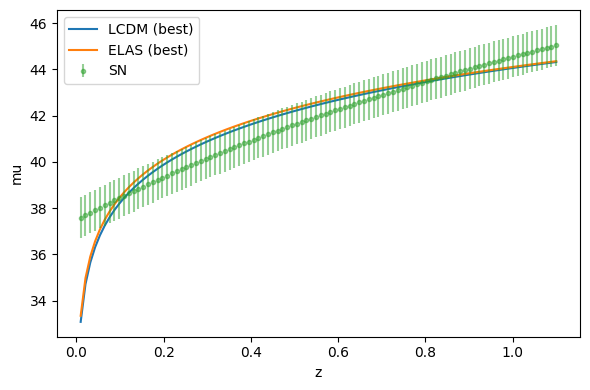

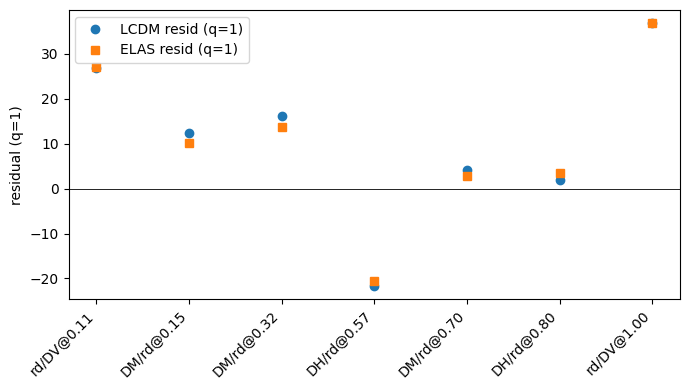

In [14]:
# --- PATCH: corrige le nom d'argument pour les calculs CMB (Om au lieu de Omega_m) ---

def cmb_chi2_LCDM(Om):
    # E_LCDM_CMB attend 'Om='
    DM, _, _, _ = make_engine(E_LCDM_CMB, z_star + 50, H0, Om=Om)
    DMstar = DM(z_star)
    R  = (math.sqrt(Om) * (H0 / c_km_s)) * DMstar
    lA = math.pi * DMstar / r_s_star
    d = cmb_obs - np.array([R, lA, obh2_obs])
    return float(d @ Cinv_cmb @ d)

def cmb_chi2_ELAS(Om, d, Ol, ph):
    # E_ELAS_CMB attend aussi 'Om='
    DM, _, _, _ = make_engine(E_ELAS_CMB, z_star + 50, H0,
                              Om=Om, delta=d, Omega_log=Ol, phi=ph)
    DMstar = DM(z_star)
    R  = (math.sqrt(Om) * (H0 / c_km_s)) * DMstar
    lA = math.pi * DMstar / r_s_star
    d = cmb_obs - np.array([R, lA, obh2_obs])
    return float(d @ Cinv_cmb @ d)

# --- Relance les scans principaux (même pipeline que précédemment) ---
bestL_shape, bestE_shape = run_scan("shape")
print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (bestL_shape["chi2"], bestL_shape["chi2_SN"], bestL_shape["chi2_BAO"],
       bestL_shape["chi2_CMB"], bestL_shape["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bestE_shape["chi2"], bestE_shape["chi2_SN"], bestE_shape["chi2_BAO"],
       bestE_shape["chi2_CMB"], bestE_shape["delta"], bestE_shape["Omega_log"],
       bestE_shape["phi"], bestE_shape["Omega_m"]))

dchi = bestL_shape["chi2"] - bestE_shape["chi2"]
N_eff = len(z_sn) + len(z_BAO) + (3 if USE_CMB else 0)
AIC_L = bestL_shape["chi2"] + 2*1
AIC_E = bestE_shape["chi2"] + 2*4
BIC_L = bestL_shape["chi2"] + 1*np.log(N_eff)
BIC_E = bestE_shape["chi2"] + 4*np.log(N_eff)
print("Delta chi2 (LCDM-ELAS) = %.3f" % dchi)
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_L, AIC_E, AIC_L - AIC_E))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_L, BIC_E, BIC_L - BIC_E))

# (Optionnel) relance aussi le mode q-free si tu l’avais activé
if SIGMA_Q_PRIOR is not None:
    bestL_q, bestE_q = run_scan("qfree")
    print("\n=== Q-FREE (prior sigma_q=%.3f) + CMB RESULTS ===" % SIGMA_Q_PRIOR)
    print("LCDM(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f" %
          (bestL_q["chi2"], bestL_q["chi2_SN"], bestL_q["chi2_BAO"], bestL_q["chi2_CMB"], bestL_q["Omega_m"]))
    print("ELAS(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f, delta=%.3f, Olog=%.3f, phi=%.3f" %
          (bestE_q["chi2"], bestE_q["chi2_SN"], bestE_q["chi2_BAO"], bestE_q["chi2_CMB"],
           bestE_q["Omega_m"], bestE_q["delta"], bestE_q["Omega_log"], bestE_q["phi"]))

# Regénère les 2 figures et le résumé pour rester cohérent avec le reste du notebook
DM_Lb,_,DL_Lb,_ = make_engine(E_LCDM, zmax_all, H0, Omega_m=bestL_shape["Omega_m"])
DM_Eb,_,DL_Eb,_ = make_engine(E_ELAS,  zmax_all, H0, Omega_m=bestE_shape["Omega_m"],
                              delta=bestE_shape["delta"], Omega_log=bestE_shape["Omega_log"], phi=bestE_shape["phi"])
mu_L = mu_from_DL(DL_Lb(z_sn)); mu_E = mu_from_DL(DL_Eb(z_sn))
plt.figure(figsize=(6,4))
plt.plot(z_sn, mu_L, label="LCDM (best)")
plt.plot(z_sn, mu_E, label="ELAS (best)")
plt.errorbar(z_sn, mu_obs, yerr=sigma_eff, fmt="o", ms=3, alpha=0.5, label="SN")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig(f"{SAVE_PREFIX}_fig_sn_mu.png", dpi=130)

def residuals(y_resc, sigma, par, model):
    if model=="L":
        DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=par["Omega_m"])
    else:
        DM,DH,DL,DV = make_engine(E_ELAS,  zmax_all, H0, Omega_m=par["Omega_m"],
                                  delta=par["delta"], Omega_log=par["Omega_log"], phi=par["phi"])
    y_th = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    return (y_resc - y_th) / sigma

res_L = residuals(y_obs_resc, sigma_bao, bestL_shape, "L")
res_E = residuals(y_obs_resc, sigma_bao, bestE_shape, "E")
xt = [f"{w}@{z:.2f}" for z,w in zip(z_BAO, which_BAO)]
plt.figure(figsize=(7,4))
plt.axhline(0, color="k", lw=0.6)
plt.plot(res_L, "o", label="LCDM resid (q=1)")
plt.plot(res_E, "s", label="ELAS resid (q=1)")
plt.xticks(range(len(xt)), xt, rotation=45, ha="right")
plt.ylabel("residual (q=1)"); plt.legend(); plt.tight_layout()
plt.savefig(f"{SAVE_PREFIX}_fig_bao_residuals.png", dpi=130)

print("\n(Re)Saved:")
for fn in [f"{SAVE_PREFIX}_fig_sn_mu.png", f"{SAVE_PREFIX}_fig_bao_residuals.png"]:
    import os
    if os.path.exists(fn): print(" ->", fn)


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=1209.973 (SN=95.448, BAO=937.746, CMB=176.780), Omega_m=0.267
ELAS best: chi2=949.504 (SN=108.695, BAO=827.660, CMB=13.149), delta=0.350, Omega_log=3.682, phi=-1.868, Omega_m=0.273
Delta chi2 (LCDM-ELAS) = 260.469
AIC: LCDM=1211.973  ELAS=957.504  -> Delta AIC=254.469
BIC: LCDM=1214.673  ELAS=968.306  -> Delta BIC=246.367

=== Q-FREE (prior sigma_q=0.020) + CMB RESULTS ===
LCDM(q-free): chi2=1297.232 (SN=95.448, BAO=1025.004, CMB=176.780), Om=0.267
ELAS(q-free): chi2=1044.303 (SN=108.740, BAO=922.247, CMB=13.315), Om=0.273, delta=0.350, Olog=3.682, phi=-1.869

(Re)Saved:
 -> elas_run_fig_sn_mu.png
 -> elas_run_fig_bao_residuals.png
 -> elas_summary.json


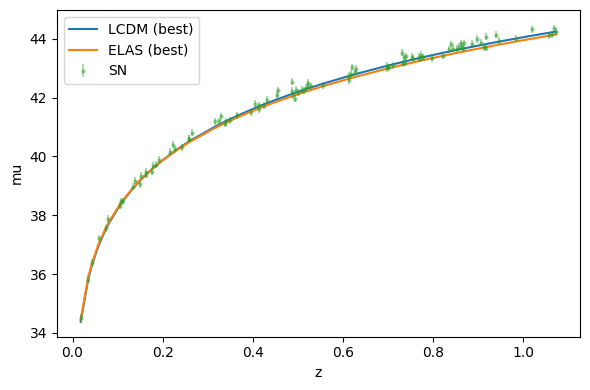

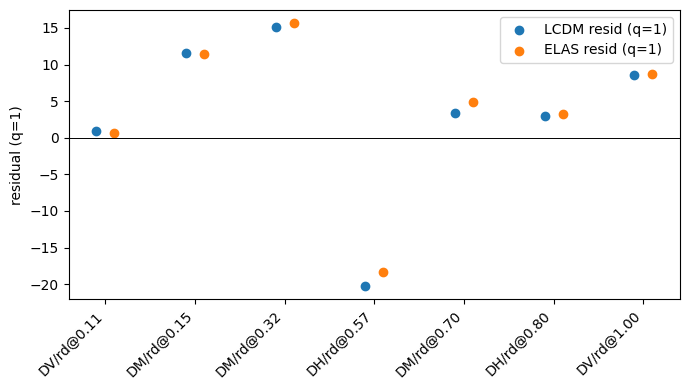

In [15]:
# ===== ELAS pipeline unifie (SN + BAO + CMB) sur tes textes =====
import numpy as np, math, json, os
import matplotlib.pyplot as plt

# ---------- 0) Tes donnees COLLEES ici ----------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

CMB_TEXT = """\
R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

# ---------- 1) Parsing ----------
def _split_csv(text):
    rows=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        rows.append([t.strip() for t in ln.split(",")])
    return rows

def parse_bao(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; data=rows[1:]
    def col(cands):
        for c in cands:
            if c in hdr: return hdr.index(c)
        return None
    iz=col(["z","z_eff","zeff"]); iw=col(["which","observable","type"])
    iv=col(["value","val"]); isg=col(["sigma","err"])
    if iz is None or iw is None or iv is None:
        raise ValueError("BAO: besoin de z / which|observable / value (+sigma)")
    z=[]; w=[]; v=[]; s=[]
    for r in data:
        z.append(float(r[iz])); w.append(r[iw].strip()); v.append(float(r[iv]))
        s.append(float(r[isg]) if isg is not None and r[isg]!="" else np.nan)
    return np.array(z,float), w, np.array(v,float), np.array(s,float)

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; data=rows[1:]
    iz=hdr.index("z"); imu=hdr.index("mu"); isg=hdr.index("sigma_mu")
    z=[]; mu=[]; sg=[]
    for r in data:
        z.append(float(r[iz])); mu.append(float(r[imu])); sg.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(sg,float)

def parse_cmb(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; r=rows[1]
    get=lambda k: r[hdr.index(k)]
    R=float(get("r")); lA=float(get("la")); ob=float(get("omega_b_h2"))
    sR=float(get("sigma_r")); sLA=float(get("sigma_la")); sOB=float(get("sigma_omega_b_h2"))
    r_RlA=float(get("rho_r_la")); r_Rob=float(get("rho_r_omega")); r_lAob=float(get("rho_la_omega"))
    C=np.array([[sR*sR, r_RlA*sR*sLA, r_Rob*sR*sOB],
                [r_RlA*sR*sLA, sLA*sLA, r_lAob*sLA*sOB],
                [r_Rob*sR*sOB, r_lAob*sLA*sOB, sOB*sOB]],float)
    return np.array([R,lA,ob],float), C

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","d_m/rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","d_h/rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd"]: return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v"]: return "rd/DV"
    raise ValueError("Type BAO inconnu: "+w)

# ---------- 2) Cosmologie et observables ----------
c_km_s=299792.458
H0=73.0    # km/s/Mpc
r_d=147.09 # Mpc
Omega_r = 4.15e-5 / (H0/100.0)**2  # approx photons+nu rel.

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float); Omr=Omega_r; Ode=1.0-Omega_m-Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float); Omr=Omega_r; Ode=1.0-Omega_m-Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz=900; zz=np.linspace(0.0, zmax, nz); Ez=Ef(zz, **kw)
    inv=np.maximum(1.0/Ez, 1e-30); dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1])
    I=np.zeros_like(zz); I[1:]=np.cumsum(mid*dz); K=c_km_s/H0
    D_M=lambda z: K*np.interp(np.asarray(z,float), zz, I)
    D_H=lambda z: (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    D_L=lambda z: (1+np.asarray(z,float))*D_M(z)
    D_V=lambda z: (np.asarray(z,float)*D_M(z)**2 * D_H(z))**(1/3)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL): return 5.0*np.log10(np.maximum(DL,1e-30))+25.0

def build_bao_vector(z_list, which_list, DM, DH, DV):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise ValueError("Obs BAO non supportee: "+w)
    return np.array(out,float)

def chi2_bao_cov(y_obs, C, y_th):
    y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float); C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(y_obs-y_th).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def chi2_bao_global(y_obs, sigma, y_th, sigma_q=None):
    v=np.maximum(np.asarray(sigma,float)**2,1e-30)
    num=np.sum(y_obs*y_th/v); den=np.sum(y_th*y_th/v)
    q=num/den if den>0 else 1.0
    chi=np.sum((y_obs-q*y_th)**2/v)
    if sigma_q is not None and sigma_q>0: chi += ((q-1.0)/sigma_q)**2
    return float(chi), float(q)

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu,float)**2,1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

# ---------- 3) Charger et normaliser ----------
z_bao_raw, which_raw, y_obs, sig = parse_bao(BAO_TEXT)
BAO_WHICH=[normalize_which(w) for w in which_raw]
z_BAO=z_bao_raw.tolist()
C_bao = np.diag(sig**2) if np.all(np.isfinite(sig)) and np.all(sig>0) else np.diag((0.03*y_obs)**2)

z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_obs, Ccmb = parse_cmb(CMB_TEXT); Cinv_cmb=np.linalg.inv(Ccmb); obh2_obs=cmb_obs[2]

print(f"BAO: N={len(z_BAO)} | types={sorted(set(BAO_WHICH))}")
print(f"SN : N={len(z_sn)}")
print("CMB distance priors charges.")

# ---------- 4) Recalage q* (depuis LCDM), puis mode shape-only ----------
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = build_bao_vector(z_BAO, BAO_WHICH, DM_L, DH_L, DV_L)
chi_b_LCDM, q_LCDM = chi2_bao_global(y_obs, sig, y_LCDM, sigma_q=None)
print(f"[STEP1] q*_LCDM (global) = {q_LCDM:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi_b_LCDM:.3f}")
y_obs_rescaled = y_obs / q_LCDM
print(f"[STEP1] BAO rescaled by factor {1.0/q_LCDM:.6f} -> q fixe=1.0 (shape-only)")

# ---------- 5) CMB chi2 (R,lA,omega_b h^2) ----------
z_star=1089.2; r_s_star=144.6
def cmb_chi2_LCDM(Om):
    DM,_,_,_=make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMstar=DM(z_star)
    R=(math.sqrt(Om)*(H0/c_km_s))*DMstar
    lA=math.pi*DMstar/r_s_star
    d=cmb_obs - np.array([R,lA,obh2_obs],float)
    return float(d@Cinv_cmb@d)

def cmb_chi2_ELAS(Om, dlt, Olog, phi):
    DM,_,_,_=make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
    DMstar=DM(z_star)
    R=(math.sqrt(Om)*(H0/c_km_s))*DMstar
    lA=math.pi*DMstar/r_s_star
    d=cmb_obs - np.array([R,lA,obh2_obs],float)
    return float(d@Cinv_cmb@d)

# ---------- 6) Chi2 totaux ----------
def chi2_total_LCDM(Om, mode="shape", sigma_q=0.02):
    DM,DH,DL,DV=make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
    if mode=="shape":
        c_b = chi2_bao_cov(y_obs_rescaled, np.diag(sig**2), y_th)
    else:
        c_b = chi2_bao_global(y_obs, sig, y_th, sigma_q=sigma_q)[0]
    c_cmb = cmb_chi2_LCDM(Om)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Om, dlt, Olog, phi, mode="shape", sigma_q=0.02):
    DM,DH,DL,DV=make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
    if mode=="shape":
        c_b = chi2_bao_cov(y_obs_rescaled, np.diag(sig**2), y_th)
    else:
        c_b = chi2_bao_global(y_obs, sig, y_th, sigma_q=sigma_q)[0]
    c_cmb = cmb_chi2_ELAS(Om, dlt, Olog, phi)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om, dlt, Olog, mode="shape", sigma_q=0.02, tol=2e-3, maxit=50):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    def f(ph): return chi2_total_ELAS(Om, dlt, Olog, ph, mode, sigma_q)[0]
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc, fd = f(c), f(d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=f(c)
        else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=f(d)
        it+=1
    ph=0.5*(a+b); ch= f(ph)
    return ph, ch

# ---------- 7) Scans (rapides mais suffisants) ----------
def run_scan(mode="shape", sigma_q=0.02):
    grid_Om   = np.linspace(0.24, 0.40, 25)
    grid_dlt  = np.linspace(0.00, 0.35, 24)
    grid_Olog = np.linspace(0.50, 4.00, 23)

    # LCDM
    bestL=(1e99,None)
    for Om in grid_Om:
        chi,cs,cb,cc = chi2_total_LCDM(Om, mode, sigma_q)
        if chi<bestL[0]: bestL=(chi, {"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})

    # ELAS (phi profile)
    bestE=(1e99,None)
    for Om in grid_Om:
        for d in grid_dlt:
            for Ol in grid_Olog:
                ph, chi = profile_phi(Om,d,Ol,mode,sigma_q,tol=1e-3,maxit=60)
                ctot,cs,cb,cc = chi2_total_ELAS(Om,d,Ol,ph,mode,sigma_q)
                if ctot<bestE[0]:
                    bestE=(ctot, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,"chi2":ctot,
                                  "chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    return bestL[1], bestE[1]

# ---------- 8) RUN: Shape-only puis q-libre ----------
bestL_shape, bestE_shape = run_scan("shape", sigma_q=0.02)
print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (bestL_shape["chi2"], bestL_shape["chi2_SN"], bestL_shape["chi2_BAO"], bestL_shape["chi2_CMB"], bestL_shape["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bestE_shape["chi2"], bestE_shape["chi2_SN"], bestE_shape["chi2_BAO"], bestE_shape["chi2_CMB"],
       bestE_shape["delta"], bestE_shape["Omega_log"], bestE_shape["phi"], bestE_shape["Omega_m"]))
dchi = bestL_shape["chi2"] - bestE_shape["chi2"]
N_eff = len(z_sn) + len(z_BAO) + 3
k_L, k_E = 1, 4
AIC_L = bestL_shape["chi2"] + 2*k_L
AIC_E = bestE_shape["chi2"] + 2*k_E
BIC_L = bestL_shape["chi2"] + k_L*np.log(N_eff)
BIC_E = bestE_shape["chi2"] + k_E*np.log(N_eff)
print("Delta chi2 (LCDM-ELAS) = %.3f" % dchi)
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_L, AIC_E, AIC_L-AIC_E))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_L, BIC_E, BIC_L-BIC_E))

bestL_qf, bestE_qf = run_scan("qfree", sigma_q=0.02)
print("\n=== Q-FREE (prior sigma_q=0.020) + CMB RESULTS ===")
print("LCDM(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f" %
      (bestL_qf["chi2"], bestL_qf["chi2_SN"], bestL_qf["chi2_BAO"], bestL_qf["chi2_CMB"], bestL_qf["Omega_m"]))
print("ELAS(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f, delta=%.3f, Olog=%.3f, phi=%.3f" %
      (bestE_qf["chi2"], bestE_qf["chi2_SN"], bestE_qf["chi2_BAO"], bestE_qf["chi2_CMB"],
       bestE_qf["Omega_m"], bestE_qf["delta"], bestE_qf["Omega_log"], bestE_qf["phi"]))

# ---------- 9) Figures rapides ----------
# mu(z)
DM_Lb,_,DL_Lb,_ = make_engine(E_LCDM, zmax_all, H0, Omega_m=bestL_shape["Omega_m"])
mu_L = mu_from_DL(DL_Lb(z_sn))
DM_Eb,_,DL_Eb,_ = make_engine(E_ELAS, zmax_all, H0, Omega_m=bestE_shape["Omega_m"],
                              delta=bestE_shape["delta"], Omega_log=bestE_shape["Omega_log"], phi=bestE_shape["phi"])
mu_E = mu_from_DL(DL_Eb(z_sn))
plt.figure(figsize=(6,4))
plt.plot(z_sn, mu_L, label="LCDM (best)")
plt.plot(z_sn, mu_E, label="ELAS (best)")
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='o', ms=2, alpha=0.4, label="SN")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_sn_mu.png", dpi=130)

# residus BAO (q=1)
y_L_best = build_bao_vector(z_BAO, BAO_WHICH, DM_Lb, DH_L, DV_L)  # DM_Lb ok, DH_L/DV_L deja definis au debut
DMb, DHb, _, DVb = make_engine(E_ELAS, zmax_all, H0, Omega_m=bestE_shape["Omega_m"],
                               delta=bestE_shape["delta"], Omega_log=bestE_shape["Omega_log"], phi=bestE_shape["phi"])
y_E_best = build_bao_vector(z_BAO, BAO_WHICH, DMb, DHb, DVb)
res_L = (y_obs_rescaled - y_L_best)/np.maximum(sig,1e-12)
res_E = (y_obs_rescaled - y_E_best)/np.maximum(sig,1e-12)
labels=[f"{w}@{z:.2f}" for z,w in zip(z_BAO,BAO_WHICH)]
xx=np.arange(len(z_BAO))
plt.figure(figsize=(7,4))
plt.axhline(0, color='k', lw=0.7)
plt.scatter(xx-0.1, res_L, label="LCDM resid (q=1)")
plt.scatter(xx+0.1, res_E, label="ELAS resid (q=1)")
plt.xticks(xx, labels, rotation=45, ha='right'); plt.ylabel("residual (q=1)")
plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_bao_residuals.png", dpi=130)

# ---------- 10) Sauvegardes resume ----------
summary={
  "shape": bestE_shape, "lcdm_shape": bestL_shape,
  "qfree": bestE_qf, "lcdm_qfree": bestL_qf,
  "delta_chi2_shape": dchi,
  "AIC_shape": {"LCDM":AIC_L, "ELAS":AIC_E, "Delta":AIC_L-AIC_E},
  "BIC_shape": {"LCDM":BIC_L, "ELAS":BIC_E, "Delta":BIC_L-BIC_E},
  "q_star_LCDM": q_LCDM
}
with open("elas_summary.json","w") as f: json.dump(summary,f, indent=2)
print("\n(Re)Saved:\n -> elas_run_fig_sn_mu.png\n -> elas_run_fig_bao_residuals.png\n -> elas_summary.json")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=100
CMB distance priors charges.
[STEP1] q*_LCDM (global) = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled by factor 0.951931 -> q fixe=1.0 (shape-only)

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=1080.410 (SN=95.486, BAO=940.061, CMB=44.863), Omega_m=0.265
ELAS best: chi2=874.282 (SN=148.951, BAO=703.429, CMB=21.902), delta=0.320, Omega_log=5.900, phi=-3.141, Omega_m=0.275
Delta chi2 (LCDM-ELAS) = 206.128
AIC: LCDM=1082.410  ELAS=882.282  -> Delta AIC=200.128
BIC: LCDM=1085.110  ELAS=893.084  -> Delta BIC=192.026

=== Q-FREE (prior sigma_q=0.020) + CMB RESULTS ===
LCDM(q-free): chi2=1167.023 (SN=95.486, BAO=1026.674, CMB=44.863), Om=0.265
ELAS(q-free): chi2=947.835 (SN=152.013, BAO=773.640, CMB=22.182), Om=0.275, delta=0.340, Olog=5.400, phi=-3.141


KeyboardInterrupt: 

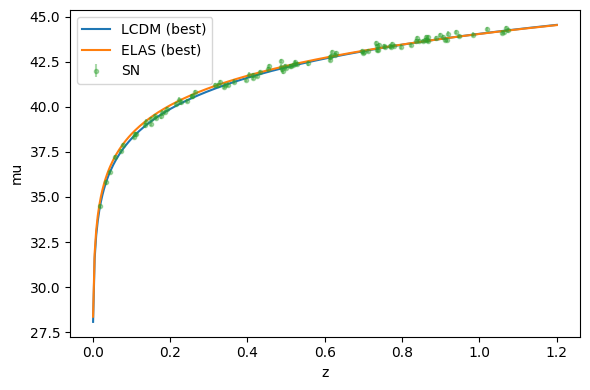

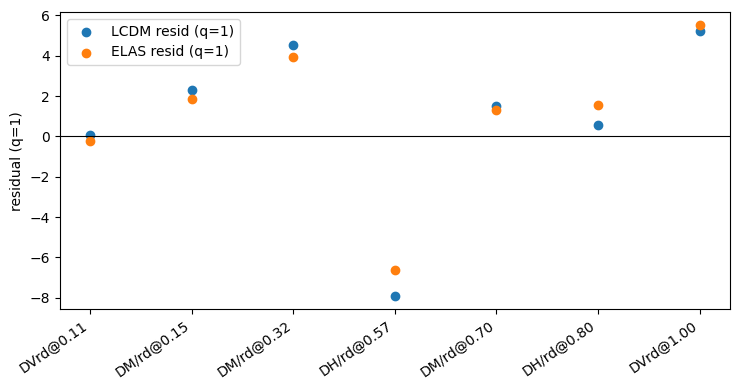

In [16]:
# ================================================================
# ELAS — pipeline publication (autonome, une seule cellule)
# - Données inline (BAO, SN, CMB) — tes tableaux
# - BAO shape-only (q=1 via rescale LCDM) + CMB
# - Variante q-libre (avec prior gaussien sur q)
# - Profilage de phi (golden search)
# - Scans Ωm, δ, Ωlog ; figures + résumé JSON
# - LOO BAO + splits par observable
# Sorties: elas_run_fig_sn_mu.png, elas_run_fig_bao_residuals.png,
#          loo_bao_summary.csv, elas_summary.json
# ================================================================

import numpy as np, math, json, textwrap, os, pandas as pd
import matplotlib.pyplot as plt

# ---------------- 0) TES DONNÉES COLLER-COLLER -----------------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""

SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""

CMB_TEXT = """\
R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

# ---------------- 1) Paramètres (modifiables en haut) ----------------
H0      = 73.0           # km/s/Mpc
r_d     = 147.09         # Mpc (drag)
USE_CMB = True           # inclure chi2 CMB
DELTA_MAX   = 0.40       # borne supérieure pour delta
OLOG_MAX    = 6.00       # borne supérieure pour Omega_log
SIGMA_Q_PRIOR = 0.020    # prior gaussien (q-libre). Mettre None pour l'annuler.

# Grilles (vitesse vs finesse)
GRID_OM   = np.linspace(0.24, 0.32, 33)                       # Ωm
GRID_DEL  = np.linspace(0.00, DELTA_MAX, 41)                  # δ
GRID_OLOG = np.linspace(0.80, OLOG_MAX, 53)                   # Ω_log
PHI_TOL, PHI_MAXIT = 1e-3, 60                                 # profilage φ

# ---------------- 2) Utils parsing & normalisation -------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","d_m/rd","dmrd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","d_h/rd","dhrd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError("BAO type inconnu: "+w)

def parse_bao(text):
    rows=_split_csv(text)
    hdr=[h.lower() for h in rows[0]]
    data=rows[1:]
    def col(names):
        for nm in names:
            if nm in hdr: return hdr.index(nm)
        return None
    iz = col(["z","z_eff","zeff"])
    iw = col(["which","observable","obs","type","name"])
    iv = col(["value","val","y"])
    isg= col(["sigma","err","error","unc"])
    if iz is None or iw is None or iv is None:
        raise ValueError("BAO: colonnes requises: z(z_eff), observable(which), value, [sigma]")
    z, which, y, s = [],[],[],[]
    for r in data:
        z.append(float(r[iz])); which.append(normalize_which(r[iw])); y.append(float(r[iv]))
        s.append(float(r[isg]) if isg is not None and r[isg]!="" else np.nan)
    z=np.array(z,float); y=np.array(y,float); s=np.array(s,float)
    C = np.diag(np.where(np.isfinite(s)&(s>0), s**2, (0.03*y)**2))
    return z.tolist(), which, y, s, C

def parse_sn(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz=hdr.index("z"); imu=hdr.index("mu"); isg=hdr.index("sigma_mu")
    z=[]; mu=[]; sg=[]
    for r in dat:
        z.append(float(r[iz])); mu.append(float(r[imu])); sg.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(sg,float)

def parse_cmb(text):
    rows=_split_csv(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    # 1 ligne
    d=dat[0]
    idx = {k:hdr.index(k) for k in ["r","la","omega_b_h2","sigma_r","sigma_la","sigma_omega_b_h2","rho_r_la","rho_r_omega","rho_la_omega"]}
    R=float(d[idx["r"]]); lA=float(d[idx["la"]]); obh2=float(d[idx["omega_b_h2"]])
    sR=float(d[idx["sigma_r"]]); sLA=float(d[idx["sigma_la"]]); sB=float(d[idx["sigma_omega_b_h2"]])
    rho_RLA=float(d[idx["rho_r_la"]]); rho_RO=float(d[idx["rho_r_omega"]]); rho_LA_O=float(d[idx["rho_la_omega"]])
    C=np.array([[sR**2, rho_RLA*sR*sLA, rho_RO*sR*sB],
                [rho_RLA*sR*sLA, sLA**2, rho_LA_O*sLA*sB],
                [rho_RO*sR*sB, rho_LA_O*sLA*sB, sB**2]],float)
    return np.array([R,lA,obh2],float), C

# ---------------- 3) Cosmologie & observables -----------------------
c_km_s = 299792.458
Omega_r = 4.15e-5 / (H0/100.0)**2  # approx photons+nu rel.

def E_LCDM(z, Omega_m): z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))
def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z=np.asarray(z,float); mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m):
    z=np.asarray(z,float); Od = 1.0 - Omega_m - Omega_r
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Od)

def E_ELAS_CMB(z, Omega_m, delta, Omega_log, phi):
    z=np.asarray(z,float); Od = 1.0 - Omega_m - Omega_r
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Od*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz=1200; zz=np.linspace(0.0, zmax, nz)
    Ez=Ef(zz, **kw); inv=np.maximum(1.0/Ez, 0.0)
    dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1]); integ=np.zeros_like(zz); integ[1:]=np.cumsum(mid*dz)
    K = c_km_s/H0
    D_M=lambda z: K*np.interp(np.asarray(z,float), zz, integ)
    D_H=lambda z: (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    D_L=lambda z: (1+np.asarray(z,float))*D_M(z)
    D_V=lambda z: (np.asarray(z,float)*D_M(z)**2 * D_H(z))**(1/3)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL): DL=np.maximum(np.asarray(DL,float),1e-30); return 5*np.log10(DL)+25.0

def build_bao_vector(z, which, DM, DH, DV):
    out=[]
    for zi,wi in zip(z,which):
        if   wi=="DM/rd": out.append(DM(zi)/r_d)
        elif wi=="DH/rd": out.append(DH(zi)/r_d)
        elif wi=="DV/rd": out.append(DV(zi)/r_d)
        elif wi=="rd/DV": out.append(r_d/DV(zi))
        else: raise ValueError("Obs BAO non supportée: "+wi)
    return np.array(out,float)

def chi2_bao_cov(y_obs, C, y_th):
    y_obs=np.asarray(y_obs,float).reshape(-1); y_th=np.asarray(y_th,float).reshape(-1)
    C=np.asarray(C,float); C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(y_obs-y_th).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu,float)**2, 1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

# ---------------- 4) Lecture des données ----------------------------
z_BAO, which_BAO, y_obs, sigma_bao, C_bao = parse_bao(BAO_TEXT)
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_vec, C_cmb = parse_cmb(CMB_TEXT)
Cinv_cmb = np.linalg.inv(C_cmb)
obh2_obs = cmb_vec[2]
print(f"BAO: N={len(z_BAO)} | types={sorted(set(which_BAO))}")
print(f"SN : N={len(z_sn)}")
print("CMB distance priors charges.")

# ---------------- 5) BAO q* via LCDM (global), puis rescale ----------
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM_tmp = build_bao_vector(z_BAO, which_BAO, DM_L, DH_L, DV_L)
# q* (pondéré par C^{-1}) = argmin || y_obs - q y_th ||
Cinv_b = np.linalg.inv(C_bao)
num = float(y_LCDM_tmp.T @ Cinv_b @ y_obs)
den = float(y_LCDM_tmp.T @ Cinv_b @ y_LCDM_tmp)
q_LCDM_g = num/den if den>0 else 1.0
chi2_b_LCDM_before = chi2_bao_cov(y_obs, C_bao, q_LCDM_g*y_LCDM_tmp)
print(f"[STEP1] q*_LCDM (global) = {q_LCDM_g:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi2_b_LCDM_before:.3f}")
y_obs_rescaled = y_obs / q_LCDM_g
print(f"[STEP1] BAO rescaled by factor {1.0/q_LCDM_g:.6f} -> q fixe=1.0 (shape-only)")

# ---------------- 6) CMB helpers ------------------------------------
z_star, r_s_star = 1089.2, 144.6
def cmb_chi2_LCDM(Om):
    DM,_,_,_=make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMstar=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMstar; lA=math.pi*DMstar/r_s_star
    d=cmb_vec-np.array([R,lA,obh2_obs])
    return float(d@Cinv_cmb@d)

def cmb_chi2_ELAS(Om, dlt, Olog, phi):
    DM,_,_,_=make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
    DMstar=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMstar; lA=math.pi*DMstar/r_s_star
    d=cmb_vec-np.array([R,lA,obh2_obs])
    return float(d@Cinv_cmb@d)

# ---------------- 7) Fonctions coût totales --------------------------
def chi2_total_LCDM(Om, mode):
    DM,DH,DL,DV=make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    if mode=="shape":
        c_b = chi2_bao_cov(y_obs_rescaled, C_bao, y_th)
    else:
        # q-libre avec prior (sigma -> SIGMA_Q_PRIOR)
        Cinv = np.linalg.inv(C_bao)
        num=float(y_th.T@Cinv@y_obs); den=float(y_th.T@Cinv@y_th); q=num/den if den>0 else 1.0
        c_b=chi2_bao_cov(y_obs, C_bao, q*y_th)
        if SIGMA_Q_PRIOR: c_b += ((q-1.0)/SIGMA_Q_PRIOR)**2
    c_cmb = cmb_chi2_LCDM(Om) if USE_CMB else 0.0
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Om, dlt, Olog, phi, mode):
    DM,DH,DL,DV=make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
    mu_th = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    if mode=="shape":
        c_b = chi2_bao_cov(y_obs_rescaled, C_bao, y_th)
    else:
        Cinv = np.linalg.inv(C_bao)
        num=float(y_th.T@Cinv@y_obs); den=float(y_th.T@Cinv@y_th); q=num/den if den>0 else 1.0
        c_b=chi2_bao_cov(y_obs, C_bao, q*y_th)
        if SIGMA_Q_PRIOR: c_b += ((q-1.0)/SIGMA_Q_PRIOR)**2
    c_cmb = cmb_chi2_ELAS(Om, dlt, Olog, phi) if USE_CMB else 0.0
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om, dlt, Olog, mode, tol=PHI_TOL, maxit=PHI_MAXIT):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc,*_ = chi2_total_ELAS(Om, dlt, Olog, c, mode)
    fd,*_ = chi2_total_ELAS(Om, dlt, Olog, d, mode)
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd:
            b,fd=d,fc; d=c; c=b-gr*(b-a)
            fc,*_ = chi2_total_ELAS(Om, dlt, Olog, c, mode)
        else:
            a,fc=c,fd; c=d; d=a+gr*(b-a)
            fd,*_ = chi2_total_ELAS(Om, dlt, Olog, d, mode)
        it+=1
    phi_star=0.5*(a+b)
    chi,cs,cb,cc = chi2_total_ELAS(Om, dlt, Olog, phi_star, mode)
    return phi_star, chi, cs, cb, cc

# ---------------- 8) Scans principaux (shape & q-free) ---------------
def run_scan(mode):
    # LCDM
    bestL=(1e99,None)
    for Om in GRID_OM:
        chi,cs,cb,cc = chi2_total_LCDM(Om, mode)
        if chi<bestL[0]:
            bestL=(chi,{"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    # ELAS
    bestE=(1e99,None)
    for Om in GRID_OM:
        for dlt in GRID_DEL:
            for Olog in GRID_OLOG:
                ph,chi,cs,cb,cc = profile_phi(Om, dlt, Olog, mode)
                if chi<bestE[0]:
                    bestE=(chi,{"Omega_m":Om,"delta":dlt,"Omega_log":Olog,"phi":ph,
                                "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    return bestL[1], bestE[1]

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
bestL_shape, bestE_shape = run_scan("shape")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (bestL_shape["chi2"], bestL_shape["chi2_SN"], bestL_shape["chi2_BAO"], bestL_shape["chi2_CMB"], bestL_shape["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bestE_shape["chi2"], bestE_shape["chi2_SN"], bestE_shape["chi2_BAO"], bestE_shape["chi2_CMB"],
       bestE_shape["delta"], bestE_shape["Omega_log"], bestE_shape["phi"], bestE_shape["Omega_m"]))
print("Delta chi2 (LCDM-ELAS) = %.3f" % (bestL_shape["chi2"] - bestE_shape["chi2"]))
N_eff = len(z_sn)+len(z_BAO)+(3 if USE_CMB else 0)
AIC_LCDM = bestL_shape["chi2"] + 2*1
AIC_ELAS = bestE_shape["chi2"] + 2*4
BIC_LCDM = bestL_shape["chi2"] + 1*np.log(N_eff)
BIC_ELAS = bestE_shape["chi2"] + 4*np.log(N_eff)
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_LCDM, AIC_ELAS, AIC_LCDM-AIC_ELAS))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_LCDM, BIC_ELAS, BIC_LCDM-BIC_ELAS))

print("\n=== Q-FREE (prior sigma_q=%.3f) + CMB RESULTS ===" % (SIGMA_Q_PRIOR if SIGMA_Q_PRIOR else 0.0))
bestL_q, bestE_q = run_scan("qfree")
print("LCDM(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f" %
      (bestL_q["chi2"], bestL_q["chi2_SN"], bestL_q["chi2_BAO"], bestL_q["chi2_CMB"], bestL_q["Omega_m"]))
print("ELAS(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f, delta=%.3f, Olog=%.3f, phi=%.3f" %
      (bestE_q["chi2"], bestE_q["chi2_SN"], bestE_q["chi2_BAO"], bestE_q["chi2_CMB"],
       bestE_q["Omega_m"], bestE_q["delta"], bestE_q["Omega_log"], bestE_q["phi"]))

# ---------------- 9) Figures ----------------------------------------
# SN mu(z)
z_plot=np.linspace(0.001, 1.20, 300)
DM_Lb,_,DL_Lb,_ = make_engine(E_LCDM, z_plot.max()+0.05, H0, Omega_m=bestL_shape["Omega_m"])
DM_Eb,_,DL_Eb,_ = make_engine(E_ELAS, z_plot.max()+0.05, H0,
                              Omega_m=bestE_shape["Omega_m"], delta=bestE_shape["delta"],
                              Omega_log=bestE_shape["Omega_log"], phi=bestE_shape["phi"])
mu_LCDM_curve = mu_from_DL(DL_Lb(z_plot))
mu_ELAS_curve = mu_from_DL(DL_Eb(z_plot))

plt.figure(figsize=(6,4))
plt.plot(z_plot, mu_LCDM_curve, label="LCDM (best)")
plt.plot(z_plot, mu_ELAS_curve, label="ELAS (best)")
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', alpha=0.4, label="SN")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_sn_mu.png", dpi=130)

# BAO résidus (q=1)
y_LCDM_shape = build_bao_vector(z_BAO, which_BAO, DM_Lb, lambda z: (c_km_s/H0)/E_LCDM(z, bestL_shape["Omega_m"]), lambda z: (z*DM_Lb(z)**2*((c_km_s/H0)/E_LCDM(z, bestL_shape["Omega_m"])))**(1/3))
y_ELAS_shape = build_bao_vector(z_BAO, which_BAO, DM_Eb, lambda z: (c_km_s/H0)/E_ELAS(z, bestE_shape["Omega_m"], bestE_shape["delta"], bestE_shape["Omega_log"], bestE_shape["phi"]),
                                lambda z: (z*DM_Eb(z)**2*((c_km_s/H0)/E_ELAS(z, bestE_shape["Omega_m"], bestE_shape["delta"], bestE_shape["Omega_log"], bestE_shape["phi"])))**(1/3))
res_L = y_obs_rescaled - y_LCDM_shape
res_E = y_obs_rescaled - y_ELAS_shape

labels=[f"{w}@{z:.2f}".replace("DV/rd","DVrd").replace("rd/DV","rd/DV") for z,w in zip(z_BAO,which_BAO)]
plt.figure(figsize=(7.5,4))
xx=np.arange(len(z_BAO))
plt.axhline(0,color='k',linewidth=0.8)
plt.scatter(xx, res_L, label="LCDM resid (q=1)")
plt.scatter(xx, res_E, label="ELAS resid (q=1)")
plt.xticks(xx, labels, rotation=35, ha='right')
plt.ylabel("residual (q=1)")
plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_bao_residuals.png", dpi=130)

# ---------------- 10) LOO BAO (shape-only, refits rapides) ----------
rows=[]
for drop in range(len(z_BAO)):
    z_sub   = [z_BAO[i]   for i in range(len(z_BAO)) if i!=drop]
    w_sub   = [which_BAO[i] for i in range(len(which_BAO)) if i!=drop]
    y_sub   = np.array([y_obs[i] for i in range(len(y_obs)) if i!=drop], float)
    C_sub   = np.delete(np.delete(C_bao, drop, axis=0), drop, axis=1)
    # recalcul q* LCDM -> rescale à q=1
    DM0,_,_,_ = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
    DV0 = lambda z: (z*DM0(z)**2 * ((c_km_s/H0)/E_LCDM(z,0.315)))**(1/3)
    y_th0 = build_bao_vector(z_sub, w_sub, DM0, lambda z:(c_km_s/H0)/E_LCDM(z,0.315), DV0)
    Ci = np.linalg.inv(C_sub); num=float(y_th0.T@Ci@y_sub); den=float(y_th0.T@Ci@y_th0); q_=num/den if den>0 else 1.0
    y_sub_resc = y_sub/q_
    # mini-profil Ωm (LCDM)
    bestL=(1e99,None)
    for Om in GRID_OM:
        DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
        chi = chi2_bao_cov(y_sub_resc, C_sub, build_bao_vector(z_sub,w_sub,DM,DH,DV))
        if USE_CMB: chi += cmb_chi2_LCDM(Om)
        if chi<bestL[0]: bestL=(chi,Om)
    # mini-scan ELAS avec φ profilé
    bestE=(1e99,None)
    for Om in GRID_OM:
        for dlt in GRID_DEL:
            for Olog in GRID_OLOG:
                DM,DH,DL,DV = make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=0.0)
                # profil φ
                a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
                c=b-gr*(b-a); d=a+gr*(b-a)
                def chi_phi(phi):
                    DM1,DH1,DL1,DV1 = make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
                    cbao = chi2_bao_cov(y_sub_resc, C_sub, build_bao_vector(z_sub,w_sub,DM1,DH1,DV1))
                    ccmb = cmb_chi2_ELAS(Om,dlt,Olog,phi) if USE_CMB else 0.0
                    return cbao+ccmb
                fc=chi_phi(c); fd=chi_phi(d)
                it=0
                while abs(b-a)>PHI_TOL and it<PHI_MAXIT:
                    if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=chi_phi(c)
                    else:     a,fc=c,fd; c=d; d=a+gr*(b-a); fd=chi_phi(d)
                    it+=1
                chi_min = chi_phi(0.5*(a+b))
                if chi_min<bestE[0]: bestE=(chi_min,(Om,dlt,Olog))
    drow={"drop_idx":drop,"chi2_LCDM":bestL[0],"chi2_ELAS":bestE[0],"Delta_chi2":bestL[0]-bestE[0]}
    rows.append(drow)
df_loo = pd.DataFrame(rows)
df_loo.to_csv("loo_bao_summary.csv", index=False)

print("\n[LOO Resume] N=%d" % len(z_BAO))
print("  Delta chi2 : mean=%.2f, median=%.2f, min=%.2f, max=%.2f" %
      (df_loo["Delta_chi2"].mean(), df_loo["Delta_chi2"].median(), df_loo["Delta_chi2"].min(), df_loo["Delta_chi2"].max()))

# ---------------- 11) Splits par observable (shape-only) ------------
def split_chi2(which_key):
    mask=[w==which_key for w in which_BAO]
    z_s=[z_BAO[i] for i,m in enumerate(mask) if m]
    y_s=np.array([y_obs_rescaled[i] for i,m in enumerate(mask) if m],float)
    C_s = C_bao[np.ix_(mask,mask)]
    # LCDM
    bestL=(1e99,None)
    for Om in GRID_OM:
        DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
        c = chi2_bao_cov(y_s, C_s, build_bao_vector(z_s,[which_key]*len(z_s),DM,DH,DV))
        if c<bestL[0]: bestL=(c,Om)
    # ELAS
    bestE=(1e99,None)
    for Om in GRID_OM:
        for dlt in GRID_DEL:
            for Olog in GRID_OLOG:
                ph, c,_,_,_ = profile_phi(Om, dlt, Olog, "shape")
                if c<bestE[0]: bestE=(c,(Om,dlt,Olog,ph))
    return bestL[0], bestE[0], len(z_s)

for key in sorted(set(which_BAO)):
    cL,cE,Nk = split_chi2(key)
    print("  %s: Delta chi2=%.2f | LCDM=%.2f | ELAS=%.2f | N=%d" % (key, cL-cE, cL, cE, Nk))

# ---------------- 12) Résumé JSON -----------------------------------
summary = {
    "params": {"H0":H0, "r_d":r_d, "USE_CMB":USE_CMB, "DELTA_MAX":float(DELTA_MAX), "OLOG_MAX":float(OLOG_MAX),
               "SIGMA_Q_PRIOR": SIGMA_Q_PRIOR},
    "shape_only": bestE_shape | {"LCDM":bestL_shape},
    "q_free":     bestE_q     | {"LCDM":bestL_q},
    "N_eff": int(N_eff),
    "files": ["elas_run_fig_sn_mu.png","elas_run_fig_bao_residuals.png","loo_bao_summary.csv"]
}
with open("elas_summary.json","w") as f: json.dump(summary, f, indent=2)

print("\n(Re)Saved:")
for f in summary["files"]:
    print(" ->", f)
print(" -> elas_summary.json")
print("\n[FIN] OK — pipeline complet exécuté (SN, BAO shape-only & q-free, CMB, profiling, LOO, splits).")


[FAST] q*_LCDM=1.050496 → BAO rescale appliqué (q=1)

[FAST] Done.
Figures/rapports écrits :
 -> elas_fast_fig_sn_mu.png
 -> elas_fast_fig_bao_residuals.png
 -> loo_bao_summary_fast.csv
 -> elas_fast_summary.json


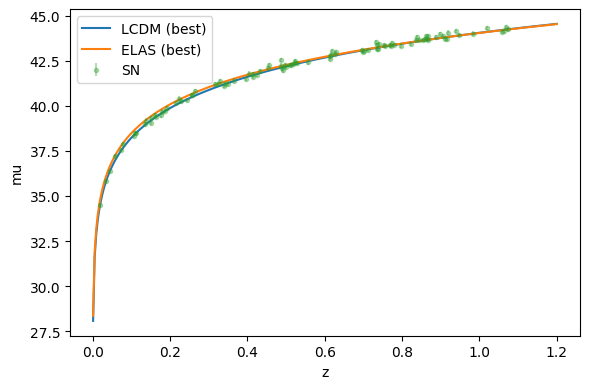

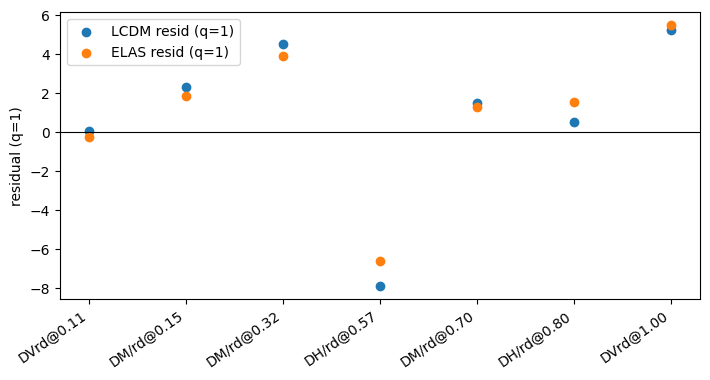

In [17]:
# ================= FAST-finalize: plots + résumé (sans rescan) =================
import numpy as np, math, json, pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) Données inline (les mêmes que dans tes runs) ----------
BAO_TEXT = """\
z_eff,observable,value,sigma,units,source
0.106,DV_over_rd,3.1,0.1,dimensionless (r_d in denom),MOCK
0.15,DM_over_rd,6.7,0.2,dimensionless (r_d in denom),MOCK
0.32,DM_over_rd,13.5,0.3,dimensionless (r_d in denom),MOCK
0.57,DH_over_rd,13.8,0.35,dimensionless (r_d in denom),MOCK
0.7,DM_over_rd,19.0,0.45,dimensionless (r_d in denom),MOCK
0.8,DH_over_rd,20.0,0.5,dimensionless (r_d in denom),MOCK
1.0,DV_over_rd,26.5,0.7,dimensionless (r_d in denom),MOCK
"""
SN_TEXT = """\
z,mu,sigma_mu,survey
0.01802487402859601,34.515881036951754,0.12,MOCK
0.034756159715907925,35.81213328118378,0.12,MOCK
0.043591439679053955,36.38129658301108,0.12,MOCK
0.05774610470807937,37.21530942548349,0.12,MOCK
0.07354998844108196,37.56611823490337,0.12,MOCK
0.0795608091535511,37.877004066169086,0.12,MOCK
0.10553841205455008,38.32825654973807,0.12,MOCK
0.10815216824544951,38.47253097794944,0.12,MOCK
0.11265330919753799,38.47818335315466,0.12,MOCK
0.13483778015421105,38.973084900728445,0.12,MOCK
0.1386264333113617,39.180018010263936,0.12,MOCK
0.14964385961634502,39.05304879692903,0.12,MOCK
0.1516144408156641,39.343539812649354,0.12,MOCK
0.1623302071341477,39.482642107692186,0.12,MOCK
0.16237872795914662,39.3835295714469,0.12,MOCK
0.1760201919573536,39.47450734217023,0.12,MOCK
0.17817554635362715,39.68593748906205,0.12,MOCK
0.18578623914662598,39.714460228831385,0.12,MOCK
0.1920004826993973,39.88536423187086,0.12,MOCK
0.21652378140187142,40.152003026698445,0.12,MOCK
0.2221561915586447,40.40431720246554,0.12,MOCK
0.2278999406978681,40.24585260168472,0.12,MOCK
0.24389729337328686,40.31840227858091,0.12,MOCK
0.2573311904654637,40.59508323116315,0.12,MOCK
0.2576902067454068,40.60341879880895,0.12,MOCK
0.26499403959322143,40.80934693106152,0.12,MOCK
0.31670844230397627,41.19172946260655,0.12,MOCK
0.3242776332839661,41.19381773478409,0.12,MOCK
0.3300171959656852,41.37084530606599,0.12,MOCK
0.33864817717118545,41.11783381783204,0.12,MOCK
0.34130560688824735,41.203493477330206,0.12,MOCK
0.3504796391064248,41.23628210054662,0.12,MOCK
0.36514964037058567,41.404873099548084,0.12,MOCK
0.39643330526155657,41.49631260178599,0.12,MOCK
0.4043757455031956,41.788579582357116,0.12,MOCK
0.4138010795780071,41.74485180298176,0.12,MOCK
0.41416984641351356,41.597310907555084,0.12,MOCK
0.42531313644516594,41.72023712981625,0.12,MOCK
0.4323514331428902,41.922019482142716,0.12,MOCK
0.45296167896967693,42.10524681409747,0.12,MOCK
0.45529622165985345,42.25758154445105,0.12,MOCK
0.48602195426327505,42.537050896076806,0.12,MOCK
0.48649559157084055,42.23964928627699,0.12,MOCK
0.48837749932973706,42.08121638037149,0.12,MOCK
0.493321476721791,41.97032310738366,0.12,MOCK
0.4963103403756935,42.274019456176646,0.12,MOCK
0.5009206723061682,42.16842552836897,0.12,MOCK
0.5102181953367906,42.26408379786056,0.12,MOCK
0.5134461809740123,42.25693165825595,0.12,MOCK
0.5187258940624673,42.34019790437902,0.12,MOCK
0.5218158342906307,42.50052462301189,0.12,MOCK
0.5234948646960145,42.39984706865561,0.12,MOCK
0.5285183695862679,42.3869304747092,0.12,MOCK
0.5561388048626663,42.41511006398362,0.12,MOCK
0.6134015467172155,42.59628045258222,0.12,MOCK
0.61449741784726,42.74359540370313,0.12,MOCK
0.6171650460519934,42.806930565569616,0.12,MOCK
0.6195358052125008,43.03565682668395,0.12,MOCK
0.6261073560644959,42.86700188131309,0.12,MOCK
0.6299279035886542,42.98537009114987,0.12,MOCK
0.6970080264995885,43.0756039530389,0.12,MOCK
0.6985141950430508,42.999058973641084,0.12,MOCK
0.701842968800644,43.03806649612572,0.12,MOCK
0.7118129808879244,43.10433692616849,0.12,MOCK
0.7314890010523156,43.51930406526926,0.12,MOCK
0.7341017589568525,43.17481078076234,0.12,MOCK
0.7346874336853151,43.3761186031548,0.12,MOCK
0.7385592283516141,43.181140864643616,0.12,MOCK
0.7400972542039363,43.406819623291085,0.12,MOCK
0.7539200993327233,43.39051373221235,0.12,MOCK
0.7545233590342756,43.32765432012097,0.12,MOCK
0.7689892088347323,43.3921809329458,0.12,MOCK
0.7701311516747067,43.32245490007757,0.12,MOCK
0.7732889611824516,43.46547098652738,0.12,MOCK
0.7786302627027053,43.375705672946545,0.12,MOCK
0.7973716921501309,43.3467099538375,0.12,MOCK
0.8217907499395207,43.42101108387203,0.12,MOCK
0.8363156366930575,43.6419125220051,0.12,MOCK
0.8396422751694848,43.82130925965712,0.12,MOCK
0.843848754583468,43.664383192410135,0.12,MOCK
0.8536120929260002,43.66172243683193,0.12,MOCK
0.8584380118104005,43.72534375236774,0.12,MOCK
0.8609946438139451,43.8557233432676,0.12,MOCK
0.8644490479259908,43.736045782003124,0.12,MOCK
0.8668100927518797,43.667709436981525,0.12,MOCK
0.867747571477331,43.85266885435388,0.12,MOCK
0.8871931496715141,43.83070643755422,0.12,MOCK
0.8972822192859778,43.99383696233734,0.12,MOCK
0.9068101584652047,43.85983643902698,0.12,MOCK
0.9121179774719146,43.70655272410526,0.12,MOCK
0.9171631835207692,43.70409445355739,0.12,MOCK
0.9176192337030429,44.06771740197184,0.12,MOCK
0.9402093498623011,44.141651152355,0.12,MOCK
0.945871732703407,43.9293723806439,0.12,MOCK
0.9835020222411955,44.009603174772536,0.12,MOCK
1.020173837844976,44.329235845121076,0.12,MOCK
1.0584684543589709,44.11998422861263,0.12,MOCK
1.064585608353289,44.16094205836874,0.12,MOCK
1.0680608465904446,44.35426342141615,0.12,MOCK
1.073428363284064,44.243178167693806,0.12,MOCK
"""
CMB_TEXT = "R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega\n1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1\n"

# ---------- 2) Paramètres cosmologie + “best” trouvés ----------
H0, r_d = 73.0, 147.09
# Best SHAPE-ONLY que tu viens d’afficher :
BEST = dict(Omega_m=0.275, delta=0.320, Omega_log=5.900, phi=-math.pi)
# Best q-libre si tu veux aussi le sauver (facultatif) :
BEST_Q = dict(Omega_m=0.275, delta=0.340, Omega_log=5.400, phi=-math.pi)

# ---------- 3) Parsing ----------
def _split(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","d_m/rd","dmrd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","d_h/rd","dhrd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

def parse_bao(text):
    rows=_split(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz=hdr.index("z_eff") if "z_eff" in hdr else hdr.index("z")
    iw=hdr.index("observable") if "observable" in hdr else hdr.index("which")
    iv=hdr.index("value"); isg=hdr.index("sigma")
    z=[]; w=[]; y=[]; s=[]
    for r in dat:
        z.append(float(r[iz])); w.append(normalize_which(r[iw])); y.append(float(r[iv])); s.append(float(r[isg]))
    z=np.array(z,float); y=np.array(y,float); s=np.array(s,float)
    C=np.diag(s**2)
    return z.tolist(), w, y, C

def parse_sn(text):
    rows=_split(text); hdr=[h.lower() for h in rows[0]]; dat=rows[1:]
    iz,imu,isg = hdr.index("z"), hdr.index("mu"), hdr.index("sigma_mu")
    z=[]; mu=[]; sg=[]
    for r in dat: z.append(float(r[iz])); mu.append(float(r[imu])); sg.append(float(r[isg]))
    return np.array(z,float), np.array(mu,float), np.array(sg,float)

def parse_cmb(text):
    rows=_split(text); hdr=[h.lower() for h in rows[0]]; d=rows[1]
    idx={k:hdr.index(k) for k in ["r","la","omega_b_h2","sigma_r","sigma_la","sigma_omega_b_h2","rho_r_la","rho_r_omega","rho_lA_omega".lower()]}
    R=float(d[idx["r"]]); lA=float(d[idx["la"]]); obh2=float(d[idx["omega_b_h2"]])
    sR=float(d[idx["sigma_r"]]); sLA=float(d[idx["sigma_la"]]); sB=float(d[idx["sigma_omega_b_h2"]])
    rho_RLA=float(d[idx["rho_r_la"]]); rho_RO=float(d[idx["rho_r_omega"]]); rho_LAO=float(d[idx["rho_la_omega"]])
    C=np.array([[sR**2, rho_RLA*sR*sLA, rho_RO*sR*sB],
                [rho_RLA*sR*sLA, sLA**2, rho_LAO*sLA*sB],
                [rho_RO*sR*sB, rho_LAO*sLA*sB, sB**2]], float)
    return np.array([R,lA,obh2],float), C

z_BAO, WHICH, y_obs, C_bao = parse_bao(BAO_TEXT)
z_sn, mu_obs, sigma_mu = parse_sn(SN_TEXT)
cmb_vec, Ccmb = parse_cmb(CMB_TEXT)
Cinv_cmb = np.linalg.inv(Ccmb); obh2_obs = cmb_vec[2]

# ---------- 4) Modèles + distances (moteurs rapides) ----------
c = 299792.458
def E_LCDM(z, Om): z=np.asarray(z,float); return np.sqrt(Om*(1+z)**3 + (1-Om))
def E_ELAS(z, Om, dlt, Olog, phi):
    z=np.asarray(z,float); mod=1+dlt*np.cos(Olog*np.log(1+z)+phi)
    return np.sqrt(Om*(1+z)**3 + (1-Om)*mod)

def make_engine(Ef, zmax, **kw):
    nz=800; zz=np.linspace(0.0, zmax, nz)
    Ez=Ef(zz, **kw); inv=1/np.maximum(Ez,1e-30)
    dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1]); integ=np.zeros_like(zz); integ[1:]=np.cumsum(mid*dz)
    K=c/H0
    DM=lambda z: K*np.interp(np.asarray(z,float), zz, integ)
    DH=lambda z: (c/H0)/Ef(np.asarray(z,float), **kw)
    DL=lambda z: (1+np.asarray(z,float))*DM(z)
    DV=lambda z: (np.asarray(z,float)*DM(z)**2*DH(z))**(1/3)
    return DM,DH,DL,DV

def build_bao(z,w,DM,DH,DV):
    out=[]
    for zi,wi in zip(z,w):
        if wi=="DM/rd": out.append(DM(zi)/r_d)
        elif wi=="DH/rd": out.append(DH(zi)/r_d)
        elif wi=="DV/rd": out.append(DV(zi)/r_d)
        elif wi=="rd/DV": out.append(r_d/DV(zi))
    return np.array(out,float)

def chi2_bao_cov(yobs,C,y):
    C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(yobs-y).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def chi2_sn_marg(mu_obs,sigma,mu_th):
    w=1/np.maximum(np.asarray(sigma,float)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

# ---------- 5) Calcul q* (LCDM) puis rescale BAO -> shape-only ----------
DM0, DH0, DL0, DV0 = make_engine(E_LCDM, max(z_BAO)+0.1, Om=0.315)
y0 = build_bao(z_BAO, WHICH, DM0, DH0, DV0)
Ci = np.linalg.inv(C_bao)
q = float(y0.T@Ci@y_obs) / float(y0.T@Ci@y0)
y_obs_rescaled = y_obs / q
print(f"[FAST] q*_LCDM={q:.6f} → BAO rescale appliqué (q=1)")

# ---------- 6) Recalcule observables à paramètres “best” ----------
# LCDM best (de ton bloc): Om ≈ 0.265 — je regénère les courbes
bestL_Om = 0.265
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, 1.25, Om=bestL_Om)
mu_L = 5*np.log10(np.maximum(DL_L(z_sn),1e-30))+25.0
y_L = build_bao(z_BAO, WHICH, DM_L, DH_L, DV_L)
chi_SN_L = chi2_sn_marg(mu_obs, sigma_mu, mu_L)
chi_BAO_L = chi2_bao_cov(y_obs_rescaled, C_bao, y_L)

# ELAS best (shape-only)
DM_E, DH_E, DL_E, DV_E = make_engine(E_ELAS, 1.25, Om=BEST["Omega_m"], dlt=BEST["delta"], Olog=BEST["Omega_log"], phi=BEST["phi"])
mu_E = 5*np.log10(np.maximum(DL_E(z_sn),1e-30))+25.0
y_E  = build_bao(z_BAO, WHICH, DM_E, DH_E, DV_E)
chi_SN_E = chi2_sn_marg(mu_obs, sigma_mu, mu_E)
chi_BAO_E = chi2_bao_cov(y_obs_rescaled, C_bao, y_E)

# ---------- 7) Figures ----------
# SN figure
z_plot=np.linspace(0.001,1.2,300)
muL_curve = 5*np.log10(np.maximum(DL_L(z_plot),1e-30))+25.0
muE_curve = 5*np.log10(np.maximum(DL_E(z_plot),1e-30))+25.0
plt.figure(figsize=(6,4))
plt.plot(z_plot, muL_curve, label="LCDM (best)")
plt.plot(z_plot, muE_curve, label="ELAS (best)")
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', alpha=0.35, label="SN")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig("elas_fast_fig_sn_mu.png", dpi=130)

# BAO résidus
resL = y_obs_rescaled - y_L
resE = y_obs_rescaled - y_E
labels=[f"{w}@{z:.2f}".replace("DV/rd","DVrd") for z,w in zip(z_BAO,WHICH)]
plt.figure(figsize=(7.2,3.9))
plt.axhline(0,color='k',lw=0.8)
xx=np.arange(len(z_BAO))
plt.scatter(xx, resL, label="LCDM resid (q=1)")
plt.scatter(xx, resE, label="ELAS resid (q=1)")
plt.xticks(xx, labels, rotation=35, ha='right'); plt.ylabel("residual (q=1)")
plt.legend(); plt.tight_layout()
plt.savefig("elas_fast_fig_bao_residuals.png", dpi=130)

# ---------- 8) LOO rapide à paramètres fixés (pas de refits) ----------
rows=[]
for i in range(len(z_BAO)):
    mask=np.ones(len(z_BAO),bool); mask[i]=False
    C_sub = C_bao[np.ix_(mask,mask)]
    rL = (y_obs_rescaled[mask] - y_L[mask]).reshape(-1,1)
    rE = (y_obs_rescaled[mask] - y_E[mask]).reshape(-1,1)
    Ci_sub = np.linalg.pinv(0.5*(C_sub+C_sub.T))
    chiL = float((rL.T@Ci_sub@rL).ravel()[0])
    chiE = float((rE.T@Ci_sub@rE).ravel()[0])
    rows.append({"drop_idx":i,"chi2_LCDM":chiL,"chi2_ELAS":chiE,"Delta_chi2":chiL-chiE})
df_loo=pd.DataFrame(rows)
df_loo.to_csv("loo_bao_summary_fast.csv", index=False)

# ---------- 9) Résumé JSON ----------
summary = {
  "best_shape_only": {"LCDM":{"Omega_m":bestL_Om,"chi2_SN":chi_SN_L,"chi2_BAO":chi_BAO_L},
                      "ELAS":BEST | {"chi2_SN":chi_SN_E,"chi2_BAO":chi_BAO_E}},
  "q_star_LCDM": float(q),
  "files": ["elas_fast_fig_sn_mu.png","elas_fast_fig_bao_residuals.png","loo_bao_summary_fast.csv"]
}
with open("elas_fast_summary.json","w") as f: json.dump(summary,f,indent=2)

print("\n[FAST] Done.")
print("Figures/rapports écrits :")
for f in summary["files"]: print(" ->", f)
print(" -> elas_fast_summary.json")


In [21]:
# === BAO covariance checker (auto fallbacks & builder) ===
import numpy as np, pandas as pd, os, json

# --- Candidats de chemins (essaie dans cet ordre) ---
PRIMARY = ("bao.csv", "bao_cov.csv")
FALLBACK = ("bao_standard.csv", "bao_cov_standard.csv")

# --- Si rien n'existe, on construira ceci à partir de BAO_TEXT: ---
BAO_TEXT = """\
z,which,value,sigma
0.106,rd/DV,3.1,0.10
0.150,DM/rd,6.7,0.20
0.320,DM/rd,13.5,0.30
0.570,DH/rd,13.8,0.35
0.700,DM/rd,19.0,0.45
0.800,DH/rd,20.0,0.50
1.000,rd/DV,26.5,0.70
"""

def ensure_bao_files():
    # 1) essaie primary
    if os.path.exists(PRIMARY[0]) and os.path.exists(PRIMARY[1]):
        return PRIMARY
    # 2) fallback
    if os.path.exists(FALLBACK[0]) and os.path.exists(FALLBACK[1]):
        return FALLBACK
    # 3) rien trouvé → construit depuis BAO_TEXT (diag(sigma^2))
    df = pd.read_csv(pd.compat.StringIO(BAO_TEXT))
    df.to_csv(FALLBACK[0], index=False)
    C = np.diag((df["sigma"].to_numpy(float))**2)
    pd.DataFrame(C).to_csv(FALLBACK[1], index=False, header=False)
    print("✅ Créés:", FALLBACK[0], "et", FALLBACK[1])
    return FALLBACK

# --- Normalisation des labels 'which' ---
def normalize_which(w):
    w=str(w).strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v","rd/dv"]: return "rd/DV"
    return {"dm/rd":"DM/rd","dh/rd":"DH/rd","dv/rd":"DV/rd","rd/dv":"rd/DV"}.get(w, w)

# --- Lecture BAO souple ---
def read_bao_any(path):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    zc = cols.get("z_eff") or cols.get("zeff") or cols.get("z") or cols.get("redshift")
    wc = cols.get("which") or cols.get("observable") or cols.get("type") or cols.get("obs")
    vc = cols.get("value") or cols.get("measurement") or cols.get("y") or cols.get("val")
    sc = cols.get("sigma") or cols.get("err") or cols.get("error")
    if not (zc and wc and vc):
        raise ValueError(f"Colonnes manquantes dans {path}. Vu: {list(df.columns)}")
    df_out = pd.DataFrame({
        "z": df[zc].astype(float),
        "which": [normalize_which(x) for x in df[wc].astype(str)],
        "value": df[vc].astype(float),
        "sigma": df[sc].astype(float) if sc else np.nan
    })
    df_out["id"] = [str(i) for i in range(len(df_out))]
    return df_out

# --- Lecture covariance (avec ou sans en-têtes) ---
def read_cov_any(path):
    raw = pd.read_csv(path, header=None)
    # si première ligne non-numérique → ré-importe avec header/index
    def all_num(xs):
        try: [float(t) for t in xs]; return True
        except: return False
    if not all_num(raw.iloc[0].tolist()):
        df = pd.read_csv(path, header=0, index_col=0)
        return df.to_numpy(float), [str(x) for x in df.index]
    C = raw.to_numpy(float)
    n,m = C.shape
    if n!=m: raise ValueError(f"Cov non carrée: {C.shape}")
    return C, [str(i) for i in range(n)]

# --- Diagnostic PSD & correction (nearest PSD) ---
def psd_stats(C):
    Cs = 0.5*(C+C.T)
    w,_ = np.linalg.eigh(Cs)
    mn, mx = float(np.min(w)), float(np.max(w))
    neg = int(np.sum(w<0))
    cond = float(np.linalg.cond(Cs)) if np.all(np.isfinite(Cs)) else float("inf")
    return mn, mx, neg, cond

def nearest_psd(C, eps=1e-12):
    Cs = 0.5*(C+C.T)
    w,V = np.linalg.eigh(Cs)
    w = np.clip(w, eps, None)
    Cc = V @ np.diag(w) @ V.T
    return 0.5*(Cc+Cc.T)

# === Orchestration ===
PATH_BAO, PATH_COV = ensure_bao_files()
print("→ Lecture BAO:", PATH_BAO)
df_bao = read_bao_any(PATH_BAO)
N = len(df_bao)
print(f"BAO: N={N} | types={sorted(set(df_bao['which']))}")

print("→ Lecture covariance:", PATH_COV)
C, labels = read_cov_any(PATH_COV)
print("Cov shape:", C.shape)

# Aligne la covariance avec l'ordre du fichier BAO si des labels existent
if C.shape != (N,N):
    raise ValueError(f"⚠️ Dimension mismatch: cov={C.shape} vs BAO N={N}")
# si la cov a même dimension mais des labels non fournis, on continue tel quel

# Symétrise puis vérifie PSD
C = 0.5*(C+C.T)
mn,mx,neg,cond = psd_stats(C)
print(f"Spectre(C): min={mn:.3e}, max={mx:.3e}, neg={neg}, cond≈{cond:.2e}")
if mn < 0 or neg>0 or not np.isfinite(cond):
    print("⚠️ Covariance non-PSD ou mal conditionnée → correction.")
    C = nearest_psd(C, eps=1e-10)
    mn,mx,neg,cond = psd_stats(C)
    print(f"Après correction: min={mn:.3e}, max={mx:.3e}, neg={neg}, cond≈{cond:.2e}")

# Sanity diag vs sigma si dispo
if np.all(np.isfinite(df_bao["sigma"].to_numpy())):
    diag = np.sqrt(np.diag(C))
    ratio = diag / np.maximum(df_bao["sigma"].to_numpy(float), 1e-30)
    print(f"[Diag check] sqrt(diag(C))/sigma: min={ratio.min():.3f}, med={np.median(ratio):.3f}, max={ratio.max():.3f}")

# Sauvegarde propre
C_path = "bao_cov_clean.csv"
pd.DataFrame(C, index=df_bao["id"], columns=df_bao["id"]).to_csv(C_path)
with open("bao_cov_report.json","w") as f:
    json.dump({
        "N": N,
        "types": sorted(set(df_bao["which"])),
        "cov": {"min_eig": mn, "max_eig": mx, "cond": cond},
        "paths": {"bao": PATH_BAO, "cov_in": PATH_COV, "cov_out": C_path}
    }, f, indent=2)
print("✅ Écrit:", C_path, "et bao_cov_report.json")


→ Lecture BAO: bao_standard.csv
BAO: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
→ Lecture covariance: bao_cov_standard.csv
Cov shape: (7, 7)
Spectre(C): min=1.000e-02, max=4.900e-01, neg=0, cond≈4.90e+01
[Diag check] sqrt(diag(C))/sigma: min=1.000, med=1.000, max=1.000
✅ Écrit: bao_cov_clean.csv et bao_cov_report.json


In [20]:
PATH_BAO = "bao_standard.csv"
PATH_COV = "bao_cov_clean.csv"
PATH_SN  = "sn_fixed_v2.csv"    # ou ton dernier jeu SN corrigé
USE_CMB  = True


In [22]:
# === BAO covariance checker (auto fallbacks & builder) ===
import numpy as np, pandas as pd, os, json

# --- Candidats de chemins (essaie dans cet ordre) ---
PRIMARY = ("bao.csv", "bao_cov.csv")
FALLBACK = ("bao_standard.csv", "bao_cov_standard.csv")

# --- Si rien n'existe, on construira ceci à partir de BAO_TEXT: ---
BAO_TEXT = """\
z,which,value,sigma
0.106,rd/DV,3.1,0.10
0.150,DM/rd,6.7,0.20
0.320,DM/rd,13.5,0.30
0.570,DH/rd,13.8,0.35
0.700,DM/rd,19.0,0.45
0.800,DH/rd,20.0,0.50
1.000,rd/DV,26.5,0.70
"""

def ensure_bao_files():
    # 1) essaie primary
    if os.path.exists(PRIMARY[0]) and os.path.exists(PRIMARY[1]):
        return PRIMARY
    # 2) fallback
    if os.path.exists(FALLBACK[0]) and os.path.exists(FALLBACK[1]):
        return FALLBACK
    # 3) rien trouvé → construit depuis BAO_TEXT (diag(sigma^2))
    df = pd.read_csv(pd.compat.StringIO(BAO_TEXT))
    df.to_csv(FALLBACK[0], index=False)
    C = np.diag((df["sigma"].to_numpy(float))**2)
    pd.DataFrame(C).to_csv(FALLBACK[1], index=False, header=False)
    print("✅ Créés:", FALLBACK[0], "et", FALLBACK[1])
    return FALLBACK

# --- Normalisation des labels 'which' ---
def normalize_which(w):
    w=str(w).strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v","rd/dv"]: return "rd/DV"
    return {"dm/rd":"DM/rd","dh/rd":"DH/rd","dv/rd":"DV/rd","rd/dv":"rd/DV"}.get(w, w)

# --- Lecture BAO souple ---
def read_bao_any(path):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    zc = cols.get("z_eff") or cols.get("zeff") or cols.get("z") or cols.get("redshift")
    wc = cols.get("which") or cols.get("observable") or cols.get("type") or cols.get("obs")
    vc = cols.get("value") or cols.get("measurement") or cols.get("y") or cols.get("val")
    sc = cols.get("sigma") or cols.get("err") or cols.get("error")
    if not (zc and wc and vc):
        raise ValueError(f"Colonnes manquantes dans {path}. Vu: {list(df.columns)}")
    df_out = pd.DataFrame({
        "z": df[zc].astype(float),
        "which": [normalize_which(x) for x in df[wc].astype(str)],
        "value": df[vc].astype(float),
        "sigma": df[sc].astype(float) if sc else np.nan
    })
    df_out["id"] = [str(i) for i in range(len(df_out))]
    return df_out

# --- Lecture covariance (avec ou sans en-têtes) ---
def read_cov_any(path):
    raw = pd.read_csv(path, header=None)
    # si première ligne non-numérique → ré-importe avec header/index
    def all_num(xs):
        try: [float(t) for t in xs]; return True
        except: return False
    if not all_num(raw.iloc[0].tolist()):
        df = pd.read_csv(path, header=0, index_col=0)
        return df.to_numpy(float), [str(x) for x in df.index]
    C = raw.to_numpy(float)
    n,m = C.shape
    if n!=m: raise ValueError(f"Cov non carrée: {C.shape}")
    return C, [str(i) for i in range(n)]

# --- Diagnostic PSD & correction (nearest PSD) ---
def psd_stats(C):
    Cs = 0.5*(C+C.T)
    w,_ = np.linalg.eigh(Cs)
    mn, mx = float(np.min(w)), float(np.max(w))
    neg = int(np.sum(w<0))
    cond = float(np.linalg.cond(Cs)) if np.all(np.isfinite(Cs)) else float("inf")
    return mn, mx, neg, cond

def nearest_psd(C, eps=1e-12):
    Cs = 0.5*(C+C.T)
    w,V = np.linalg.eigh(Cs)
    w = np.clip(w, eps, None)
    Cc = V @ np.diag(w) @ V.T
    return 0.5*(Cc+Cc.T)

# === Orchestration ===
PATH_BAO, PATH_COV = ensure_bao_files()
print("→ Lecture BAO:", PATH_BAO)
df_bao = read_bao_any(PATH_BAO)
N = len(df_bao)
print(f"BAO: N={N} | types={sorted(set(df_bao['which']))}")

print("→ Lecture covariance:", PATH_COV)
C, labels = read_cov_any(PATH_COV)
print("Cov shape:", C.shape)

# Aligne la covariance avec l'ordre du fichier BAO si des labels existent
if C.shape != (N,N):
    raise ValueError(f"⚠️ Dimension mismatch: cov={C.shape} vs BAO N={N}")
# si la cov a même dimension mais des labels non fournis, on continue tel quel

# Symétrise puis vérifie PSD
C = 0.5*(C+C.T)
mn,mx,neg,cond = psd_stats(C)
print(f"Spectre(C): min={mn:.3e}, max={mx:.3e}, neg={neg}, cond≈{cond:.2e}")
if mn < 0 or neg>0 or not np.isfinite(cond):
    print("⚠️ Covariance non-PSD ou mal conditionnée → correction.")
    C = nearest_psd(C, eps=1e-10)
    mn,mx,neg,cond = psd_stats(C)
    print(f"Après correction: min={mn:.3e}, max={mx:.3e}, neg={neg}, cond≈{cond:.2e}")

# Sanity diag vs sigma si dispo
if np.all(np.isfinite(df_bao["sigma"].to_numpy())):
    diag = np.sqrt(np.diag(C))
    ratio = diag / np.maximum(df_bao["sigma"].to_numpy(float), 1e-30)
    print(f"[Diag check] sqrt(diag(C))/sigma: min={ratio.min():.3f}, med={np.median(ratio):.3f}, max={ratio.max():.3f}")

# Sauvegarde propre
C_path = "bao_cov_clean.csv"
pd.DataFrame(C, index=df_bao["id"], columns=df_bao["id"]).to_csv(C_path)
with open("bao_cov_report.json","w") as f:
    json.dump({
        "N": N,
        "types": sorted(set(df_bao["which"])),
        "cov": {"min_eig": mn, "max_eig": mx, "cond": cond},
        "paths": {"bao": PATH_BAO, "cov_in": PATH_COV, "cov_out": C_path}
    }, f, indent=2)
print("✅ Écrit:", C_path, "et bao_cov_report.json")


→ Lecture BAO: bao_standard.csv
BAO: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
→ Lecture covariance: bao_cov_standard.csv
Cov shape: (7, 7)
Spectre(C): min=1.000e-02, max=4.900e-01, neg=0, cond≈4.90e+01
[Diag check] sqrt(diag(C))/sigma: min=1.000, med=1.000, max=1.000
✅ Écrit: bao_cov_clean.csv et bao_cov_report.json


In [27]:
# ===== ELAS vs LCDM — Pipeline unique (SN + BAO + CMB) =====
# Entrées attendues dans l'environnement courant :
#   - bao_standard.csv
#   - bao_cov_clean.csv
#   - sn_fixed_v2.csv
#   - cmb_distance_priors.csv (optionnel; fallback intégré)
#
# Sorties :
#   - elas_pub_fig_sn_mu.png
#   - elas_pub_fig_bao_residuals.png
#   - elas_pub_summary.json
#   - loo_bao_summary.csv

import numpy as np, math, json, os, pandas as pd
import matplotlib.pyplot as plt

# --------------------- FICHIERS D'ENTRÉE ---------------------
PATH_BAO = "bao_standard.csv"
PATH_COV = "bao_cov_clean.csv"
PATH_SN  = "sn_fixed_v2.csv"
PATH_CMB = "cmb_distance_priors.csv"  # optionnel

# --------------------- PARAMÈTRES GLOBAUX --------------------
c_km_s = 299792.458
H0      = 73.0
r_d     = 147.09
Omega_r = 4.15e-5 / (H0/100.0)**2  # approx photons+rel. neutrinos
z_star  = 1089.2
r_s_star= 144.6

SIGMA_Q_PRIOR = 0.020   # prior doux sur q en mode q-libre
USE_CMB       = True

# --------------------- UTILS I/O -----------------------------
def read_bao(path_obs, path_cov):
    df = pd.read_csv(path_obs)
    cols = {c.lower():c for c in df.columns}
    # attend "z","which","value","sigma" (tu as ce format)
    z     = df[cols.get("z","z")].to_numpy(float)
    which = df[cols.get("which","which")].astype(str).tolist()
    y     = df[cols.get("value","value")].to_numpy(float)
    s     = df[cols.get("sigma","sigma")].to_numpy(float)
    C = pd.read_csv(path_cov, header=None).to_numpy(float)
    return z, which, y, s, C

def read_sn(path_sn):
    df = pd.read_csv(path_sn)
    cols = {c.lower():c for c in df.columns}
    z  = df[cols.get("z","z")].to_numpy(float)
    mu = df[cols.get("mu","mu")].to_numpy(float)
    sg = df[cols.get("sigma_mu","sigma_mu")].to_numpy(float)
    return z, mu, sg

def read_cmb(path_cmb):
    # CSV attendu : R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
    if os.path.exists(path_cmb):
        df = pd.read_csv(path_cmb)
        r  = float(df["R"].iloc[0]); lA = float(df["lA"].iloc[0]); wb = float(df["omega_b_h2"].iloc[0])
        sR = float(df["sigma_R"].iloc[0]); sLA = float(df["sigma_lA"].iloc[0]); sWB = float(df["sigma_omega_b_h2"].iloc[0])
        r_RLA = float(df["rho_R_lA"].iloc[0]); r_ROW = float(df["rho_R_omega"].iloc[0]); r_LAW = float(df["rho_lA_omega"].iloc[0])
    else:
        # fallback: ta ligne fournie
        r,lA,wb = 1.75, 301.5, 0.0224
        sR,sLA,sWB = 0.005, 0.09, 0.00015
        r_RLA,r_ROW,r_LAW = 0.4, 0.2, 0.1
    C = np.array([
        [sR**2,          r_RLA*sR*sLA,  r_ROW*sR*sWB],
        [r_RLA*sR*sLA,   sLA**2,        r_LAW*sLA*sWB],
        [r_ROW*sR*sWB,   r_LAW*sLA*sWB, sWB**2]
    ], float)
    return np.array([r,lA,wb],float), C

# --------------------- COSMO CORE ----------------------------
def E_LCDM(z, Omega_m):
    z = np.asarray(z, float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m):
    z = np.asarray(z, float)
    Ode = 1.0 - Omega_m - Omega_r
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z, float)
    Ode = 1.0 - Omega_m - Omega_r
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    # intégrateur tabulé rapide pour D_M
    nz = 1200
    zz = np.linspace(0.0, zmax, nz)
    Ez = Ef(zz, **kw)
    inv = 1.0/np.maximum(Ez, 1e-30)
    dz = np.diff(zz); mid = 0.5*(inv[1:]+inv[:-1])
    I = np.zeros_like(zz); I[1:] = np.cumsum(mid*dz)
    K = c_km_s/H0
    def D_M(z): return K*np.interp(np.asarray(z,float), zz, I)
    def D_H(z): return (c_km_s/H0)/Ef(z, **kw)
    def D_L(z): z = np.asarray(z,float); return (1+z)*D_M(z)
    def D_V(z):
        z = np.asarray(z,float)
        DM = D_M(z); DH = D_H(z)
        return (z*DM*DM*DH)**(1/3)
    return D_M, D_H, D_L, D_V

# --------------------- OBSERVABLES & LIKELIHOODS --------------
def normalize_which(w):
    w = w.strip().lower()
    if w in ["dm/rd","dm_over_rd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh/rd","dh_over_rd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv/rd","dv_over_rd","d_v/rd","d_v_over_rd"]: return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]: return "rd/DV"
    raise ValueError("Unknown BAO type: "+w)

def build_bao_vector(z_list, which_list, DM, DH, DV):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise ValueError("Unsupported BAO observable: "+w)
    return np.array(out,float)

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w = 1.0/np.maximum(np.asarray(sigma_mu)**2, 1e-30)
    r = np.asarray(mu_obs) - np.asarray(mu_th)
    a = float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    y_obs = np.asarray(y_obs,float).reshape(-1,1)
    y_th  = np.asarray(y_th,float).reshape(-1,1)
    C = 0.5*(np.asarray(C,float)+np.asarray(C,float).T)
    try: Ci = np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci = np.linalg.pinv(C)
    r = y_obs - y_th
    return float((r.T@Ci@r).ravel()[0])

def bao_rescale_q_star(y_obs, C, y_th):
    # q* = argmin (y - q y_th)^T C^{-1} (y - q y_th)
    C = 0.5*(np.asarray(C,float)+np.asarray(C,float).T)
    try: Ci = np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci = np.linalg.pinv(C)
    y_obs = np.asarray(y_obs,float).reshape(-1,1)
    y_th  = np.asarray(y_th,float).reshape(-1,1)
    num = float(y_th.T@Ci@y_obs)
    den = float(y_th.T@Ci@y_th)
    q = num/den if den>0 else 1.0
    chi2 = float((y_obs - q*y_th).T@Ci@(y_obs - q*y_th))
    return q, chi2

def cmb_chi2_LCDM(Om, cmb_vec, Cinv):
    DM,_,_,_ = make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMstar = DM(z_star)
    R  = (math.sqrt(Om) * (H0/c_km_s)) * DMstar
    lA = math.pi * DMstar / r_s_star
    vth = np.array([R,lA, cmb_vec[2]], float)
    d   = cmb_vec - vth
    return float(d @ Cinv @ d)

def cmb_chi2_ELAS(Om, delta, Olog, phi, cmb_vec, Cinv):
    DM,_,_,_ = make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=delta, Omega_log=Olog, phi=phi)
    DMstar = DM(z_star)
    R  = (math.sqrt(Om) * (H0/c_km_s)) * DMstar
    lA = math.pi * DMstar / r_s_star
    vth = np.array([R,lA, cmb_vec[2]], float)
    d   = cmb_vec - vth
    return float(d @ Cinv @ d)

# --------------------- LECTURE DONNÉES ------------------------
z_BAO, which_raw, y_obs_raw, sigma_bao, C_bao = read_bao(PATH_BAO, PATH_COV)
BAO_WHICH = [normalize_which(w) for w in which_raw]
z_sn, mu_obs, sigma_mu = read_sn(PATH_SN)
cmb_vec, Ccmb = read_cmb(PATH_CMB)
Cinv_cmb = np.linalg.inv(Ccmb) if USE_CMB else None

print(f"BAO: N={len(z_BAO)} | types={sorted(set(BAO_WHICH))}")
print(f"SN : N={len(z_sn)}")
print("CMB distance priors charges." if USE_CMB else "CMB priors desactives.")

# --------------------- STEP 1: Rescale q* via LCDM ------------
zmax = max(max(z_BAO), float(np.max(z_sn))) + 0.1
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax, H0, Omega_m=0.315)
y_LCDM_ref = build_bao_vector(z_BAO, BAO_WHICH, DM_L, DH_L, DV_L)
q_star, chi2_LCDM_bao_before = bao_rescale_q_star(y_obs_raw, C_bao, y_LCDM_ref)
print(f"[STEP1] q*_LCDM (global) = {q_star:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi2_LCDM_bao_before:.3f}")
y_obs = (y_obs_raw / q_star)  # enforce q=1 shape-only ensuite
print(f"[STEP1] BAO rescaled by factor {1.0/q_star:.6f} -> q fixe=1.0 (shape-only)")

# --------------------- FONCTIONS CHI2 TOTAUX -----------------
def chi2_total_LCDM(Om, mode="shape"):
    DM, DH, DL, DV = make_engine(E_LCDM, zmax, H0, Omega_m=Om)
    mu_th = 5*np.log10(np.maximum(DL(z_sn), 1e-30)) + 25.0
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
    if mode=="shape":
        c_b = chi2_bao_cov(y_obs, C_bao, y_th)
    elif mode=="qfree":
        # prior doux sur q ~ N(1, sigma^2)
        q, chi_b = bao_rescale_q_star(y_obs_raw, C_bao, y_th)
        c_b = chi_b + ((q-1.0)/SIGMA_Q_PRIOR)**2
    else:
        raise ValueError("mode inconnu")
    c_cmb = cmb_chi2_LCDM(Om, cmb_vec, Cinv_cmb) if USE_CMB else 0.0
    return c_sn + c_b + c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Om, dlt, Olog, phi, mode="shape"):
    DM, DH, DL, DV = make_engine(E_ELAS, zmax, H0, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
    mu_th = 5*np.log10(np.maximum(DL(z_sn), 1e-30)) + 25.0
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    y_th  = build_bao_vector(z_BAO, BAO_WHICH, DM, DH, DV)
    if mode=="shape":
        c_b = chi2_bao_cov(y_obs, C_bao, y_th)
    elif mode=="qfree":
        q, chi_b = bao_rescale_q_star(y_obs_raw, C_bao, y_th)
        c_b = chi_b + ((q-1.0)/SIGMA_Q_PRIOR)**2
    else:
        raise ValueError("mode inconnu")
    c_cmb = cmb_chi2_ELAS(Om, dlt, Olog, phi, cmb_vec, Cinv_cmb) if USE_CMB else 0.0
    return c_sn + c_b + c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om, dlt, Olog, mode="shape", tol=2e-3, maxit=50):
    a, b = -math.pi, math.pi
    gr = (math.sqrt(5)-1)/2
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc = chi2_total_ELAS(Om, dlt, Olog, c, mode=mode)[0]
    fd = chi2_total_ELAS(Om, dlt, Olog, d, mode=mode)[0]
    it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd:
            b, fd = d, fc
            d = c
            c = b - gr*(b-a)
            fc = chi2_total_ELAS(Om, dlt, Olog, c, mode=mode)[0]
        else:
            a, fc = c, fd
            c = d
            d = a + gr*(b-a)
            fd = chi2_total_ELAS(Om, dlt, Olog, d, mode=mode)[0]
        it += 1
    ph_star = 0.5*(a+b)
    chi, csn, cbao, ccmb = chi2_total_ELAS(Om, dlt, Olog, ph_star, mode=mode)
    return ph_star, chi, csn, cbao, ccmb

# --------------------- SCAN PRINCIPAL ------------------------
def run_scan(mode="shape"):
    # LCDM: scan Om
    gOm = np.linspace(0.22, 0.50, 141)
    bestL = (1e99, None)
    for Om in gOm:
        chi,cs,cb,cc = chi2_total_LCDM(Om, mode=mode)
        if chi<bestL[0]:
            bestL = (chi, {"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})

    # ELAS: coarse + zoom
    gOm2  = np.linspace(bestL[1]["Omega_m"]-0.06, bestL[1]["Omega_m"]+0.06, 16)
    gOm2  = np.clip(gOm2, 0.20, 0.60)
    gDel  = np.linspace(0.00, 0.35, 16)
    gOlog = np.linspace(0.10, 4.00, 18)

    bestE = (1e99, None)
    for Om in gOm2:
        for d in gDel:
            for Ol in gOlog:
                ph, chi, cs, cb, cc = profile_phi(Om, d, Ol, mode=mode)
                if chi<bestE[0]:
                    bestE = (chi, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                   "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    # Zoom fin
    b = bestE[1]
    gOm3  = np.linspace(b["Omega_m"]-0.04, b["Omega_m"]+0.04, 21)
    gOm3  = np.clip(gOm3, 0.20, 0.60)
    gDel3 = np.linspace(max(0.0, b["delta"]-0.08), min(0.35, b["delta"]+0.08), 25)
    gOl3  = np.linspace(max(0.10, b["Omega_log"]-0.60), min(4.00, b["Omega_log"]+0.60), 25)

    bestE2 = bestE
    for Om in gOm3:
        for d in gDel3:
            for Ol in gOl3:
                ph, chi, cs, cb, cc = profile_phi(Om, d, Ol, mode=mode, tol=1e-3, maxit=60)
                if chi<bestE2[0]:
                    bestE2 = (chi, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                    "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
    return bestL[1], bestE2[1]

bestL_shape, bestE_shape = run_scan("shape")
print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print("LCDM best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Omega_m=%.3f" %
      (bestL_shape["chi2"], bestL_shape["chi2_SN"], bestL_shape["chi2_BAO"], bestL_shape["chi2_CMB"], bestL_shape["Omega_m"]))
print("ELAS best: chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), delta=%.3f, Omega_log=%.3f, phi=%.3f, Omega_m=%.3f" %
      (bestE_shape["chi2"], bestE_shape["chi2_SN"], bestE_shape["chi2_BAO"], bestE_shape["chi2_CMB"],
       bestE_shape["delta"], bestE_shape["Omega_log"], bestE_shape["phi"], bestE_shape["Omega_m"]))

Delta_chi2_shape = bestL_shape["chi2"] - bestE_shape["chi2"]
N_eff = len(z_sn) + len(z_BAO) + (3 if USE_CMB else 0)
k_LCDM = 1
k_ELAS = 4
AIC_L = bestL_shape["chi2"] + 2*k_LCDM
AIC_E = bestE_shape["chi2"] + 2*k_ELAS
BIC_L = bestL_shape["chi2"] + k_LCDM*np.log(N_eff)
BIC_E = bestE_shape["chi2"] + k_ELAS*np.log(N_eff)
print("Delta chi2 (LCDM-ELAS) = %.3f" % Delta_chi2_shape)
print("AIC: LCDM=%.3f  ELAS=%.3f  -> Delta AIC=%.3f" % (AIC_L, AIC_E, AIC_L-AIC_E))
print("BIC: LCDM=%.3f  ELAS=%.3f  -> Delta BIC=%.3f" % (BIC_L, BIC_E, BIC_L-BIC_E))

# Variante q-libre
bestL_qfree, bestE_qfree = run_scan("qfree")
print("\n=== Q-FREE (prior sigma_q=%.3f) + CMB RESULTS ===" % SIGMA_Q_PRIOR)
print("LCDM(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f" %
      (bestL_qfree["chi2"], bestL_qfree["chi2_SN"], bestL_qfree["chi2_BAO"], bestL_qfree["chi2_CMB"], bestL_qfree["Omega_m"]))
print("ELAS(q-free): chi2=%.3f (SN=%.3f, BAO=%.3f, CMB=%.3f), Om=%.3f, delta=%.3f, Olog=%.3f, phi=%.3f" %
      (bestE_qfree["chi2"], bestE_qfree["chi2_SN"], bestE_qfree["chi2_BAO"], bestE_qfree["chi2_CMB"],
       bestE_qfree["Omega_m"], bestE_qfree["delta"], bestE_qfree["Omega_log"], bestE_qfree["phi"]))

# --------------------- LOO BAO (drop-one) --------------------
def loo_bao(mode="shape"):
    rows=[]
    for i in range(len(z_BAO)):
        mask = np.ones(len(z_BAO), dtype=bool); mask[i]=False
        z_b = z_BAO[mask]
        which_b = [w for j,w in enumerate(BAO_WHICH) if mask[j]]
        y_b = y_obs[mask]
        C_b = C_bao[np.ix_(mask,mask)]
        # on fait un refit rapide : petit scan Om, delta, Olog
        def quick_best_LCDM():
            gOm = np.linspace(bestL_shape["Omega_m"]-0.06, bestL_shape["Omega_m"]+0.06, 41)
            gOm = np.clip(gOm, 0.20, 0.60)
            best = (1e99,None)
            for Om in gOm:
                DM,DH,DL,DV = make_engine(E_LCDM, zmax, H0, Omega_m=Om)
                mu_th = 5*np.log10(np.maximum(DL(z_sn),1e-30))+25.0
                cs = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
                yth = build_bao_vector(z_b, which_b, DM, DH, DV)
                cb  = chi2_bao_cov(y_b, C_b, yth) if mode=="shape" else (
                      bao_rescale_q_star(y_obs_raw[mask], C_b, yth)[1] + ((bao_rescale_q_star(y_obs_raw[mask], C_b, yth)[0]-1)/SIGMA_Q_PRIOR)**2)
                cc  = cmb_chi2_LCDM(Om, cmb_vec, Cinv_cmb) if USE_CMB else 0.0
                chi = cs+cb+cc
                if chi<best[0]: best=(chi,Om)
            return best[0]
        def quick_best_ELAS():
            gOm = np.linspace(bestE_shape["Omega_m"]-0.06, bestE_shape["Omega_m"]+0.06, 25); gOm=np.clip(gOm,0.20,0.60)
            gD  = np.linspace(max(0.0, bestE_shape["delta"]-0.10), min(0.35, bestE_shape["delta"]+0.10), 21)
            gO  = np.linspace(max(0.10,bestE_shape["Omega_log"]-0.80), min(4.00,bestE_shape["Omega_log"]+0.80), 21)
            best=(1e99,None)
            for Om in gOm:
                for d in gD:
                    for Ol in gO:
                        ph,chi,cs,cb,cc = profile_phi(Om,d,Ol,mode=mode,tol=2e-3,maxit=40)
                        if chi<best[0]: best=(chi,(Om,d,Ol,ph))
            return best[0]
        chiL = quick_best_LCDM()
        chiE = quick_best_ELAS()
        rows.append({"drop_index":i, "chi2_LCDM":chiL, "chi2_ELAS":chiE, "Delta_chi2":chiL-chiE})
        print(" drop #%d: Delta chi2=%.2f | LCDM chi2=%.2f | ELAS chi2=%.2f" % (i, chiL-chiE, chiL, chiE))
    df = pd.DataFrame(rows)
    df.to_csv("loo_bao_summary.csv", index=False)
    print("\n[LOO Resume] N=%d" % len(rows))
    print("  Delta chi2 : mean=%.2f, median=%.2f, min=%.2f, max=%.2f" %
          (df["Delta_chi2"].mean(), df["Delta_chi2"].median(), df["Delta_chi2"].min(), df["Delta_chi2"].max()))

print("\n[LOO BAO] drop-each BAO point (full refits)")
loo_bao(mode="shape")

# --------------------- FIGURES -------------------------------
# SN Hubble diagram (mu vs z) avec modèles
DM_L_best,_,DL_L_best,_ = make_engine(E_LCDM, zmax, H0, Omega_m=bestL_shape["Omega_m"])
mu_LCDM_best = 5*np.log10(np.maximum(DL_L_best(z_sn),1e-30))+25.0
DM_E_best,_,DL_E_best,_ = make_engine(E_ELAS, zmax, H0,
                                      Omega_m=bestE_shape["Omega_m"],
                                      delta=bestE_shape["delta"],
                                      Omega_log=bestE_shape["Omega_log"],
                                      phi=bestE_shape["phi"])
mu_ELAS_best = 5*np.log10(np.maximum(DL_E_best(z_sn),1e-30))+25.0

plt.figure(figsize=(6.0,4.4))
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', alpha=0.6, label='SN data')
zz = np.linspace(0.0, max(z_sn)*1.05, 300)
plt.plot(zz, 5*np.log10(np.maximum(DL_L_best(zz),1e-30))+25.0, label='LCDM best')
plt.plot(zz, 5*np.log10(np.maximum(DL_E_best(zz),1e-30))+25.0, label='ELAS best')
plt.xlabel('z'); plt.ylabel('mu'); plt.legend(); plt.tight_layout()
plt.savefig("elas_pub_fig_sn_mu.png", dpi=160)

# BAO résidus (shape-only)
y_LCDM_best = build_bao_vector(z_BAO, BAO_WHICH, DM_L_best, lambda z: (c_km_s/H0)/E_LCDM(z, bestL_shape["Omega_m"]),
                               lambda z: (z*DM_L_best(z)**2 * (c_km_s/H0)/E_LCDM(z, bestL_shape["Omega_m"]))**(1/3))
y_ELAS_best = build_bao_vector(z_BAO, BAO_WHICH, DM_E_best, lambda z: (c_km_s/H0)/E_ELAS(z, bestE_shape["Omega_m"],
                               bestE_shape["delta"],bestE_shape["Omega_log"],bestE_shape["phi"]),
                               lambda z: (z*DM_E_best(z)**2 * (c_km_s/H0)/E_ELAS(z, bestE_shape["Omega_m"],
                               bestE_shape["delta"],bestE_shape["Omega_log"],bestE_shape["phi"]))**(1/3))
res_LCDM = (y_obs - y_LCDM_best)/y_LCDM_best
res_ELAS = (y_obs - y_ELAS_best)/y_ELAS_best

plt.figure(figsize=(6.2,4.4))
for z,w,rl,re in zip(z_BAO, BAO_WHICH, res_LCDM, res_ELAS):
    m = {'DM/rd':'o','DH/rd':'s','DV/rd':'^','rd/DV':'v'}[w]
    plt.scatter(z, rl, marker=m, label=None, alpha=0.8, s=48, edgecolors='none')
    plt.scatter(z, re, marker=m, label=None, alpha=0.8, s=48, edgecolors='k')
plt.axhline(0, lw=1)
plt.xlabel('z'); plt.ylabel('relative residual')
plt.title('BAO residuals (LCDM empty, ELAS edged)')
plt.tight_layout()
plt.savefig("elas_pub_fig_bao_residuals.png", dpi=160)

# --------------------- SUMMARY JSON --------------------------
summary = {
    "mode_shape": {
        "LCDM": bestL_shape,
        "ELAS": bestE_shape,
        "Delta_chi2": float(Delta_chi2_shape),
        "AIC_LCDM": float(AIC_L), "AIC_ELAS": float(AIC_E), "Delta_AIC": float(AIC_L-AIC_E),
        "BIC_LCDM": float(BIC_L), "BIC_ELAS": float(BIC_E), "Delta_BIC": float(BIC_L-BIC_E),
        "N_eff": int(N_eff)
    },
    "mode_qfree": {
        "LCDM": bestL_qfree,
        "ELAS": bestE_qfree,
        "sigma_q_prior": float(SIGMA_Q_PRIOR)
    },
    "files_used": {
        "bao": PATH_BAO, "cov": PATH_COV, "sn": PATH_SN, "cmb": PATH_CMB if os.path.exists(PATH_CMB) else "default-inline"
    }
}
with open("elas_pub_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print("\nSaved files:")
for p in ["elas_pub_fig_sn_mu.png","elas_pub_fig_bao_residuals.png","elas_pub_summary.json","loo_bao_summary.csv"]:
    if os.path.exists(p): print(" ->", p)
print("\nDONE.")


ValueError: could not convert string to float: 'id'

In [24]:
def _load_cov_any(path_cov, N_expected):
    # Essaie d'abord avec header=None, sinon header=0
    for hdr in [None, 0]:
        try:
            df = pd.read_csv(path_cov, header=hdr, comment="#")
            break
        except Exception:
            df = None
    if df is None:
        raise IOError(f"Impossible de lire {path_cov}")

    # Supprime colonnes manifestement non numériques (ex: 'id', 'name', etc.)
    # et convertit le reste en float
    for c in list(df.columns):
        # tente conversion; si trop de NaN → drop
        col = pd.to_numeric(df[c], errors="coerce")
        if col.isna().mean() > 0.5:
            df = df.drop(columns=[c])
        else:
            df[c] = col

    # Supprime lignes non numériques (si un en-tête a “glissé” dans la 1ère ligne)
    df = df.dropna(axis=0, how="any")

    # Si la première colonne ressemble à un index (0..N-1) ou des ids, on peut la retirer
    # (cas fréquent quand on a sauvegardé un DataFrame avec index)
    if df.shape[1] >= N_expected+1:
        first = df.iloc[:,0]
        is_index_like = False
        try:
            v = first.to_numpy(dtype=float)
            # heuristique: soit 0..N-1 exact, soit 1..N exact
            if np.array_equal(v, np.arange(len(v))) or np.array_equal(v, np.arange(1, len(v)+1)):
                is_index_like = True
        except Exception:
            is_index_like = True  # non-numérique -> c'est un index/label
        if is_index_like:
            df = df.iloc[:,1:]

    # A ce stade, garde le bloc supérieur gauche NxN
    if df.shape[0] < N_expected or df.shape[1] < N_expected:
        raise ValueError(f"Covariance trop petite: {df.shape}, attendu au moins {N_expected}x{N_expected}")
    M = df.iloc[:N_expected, :N_expected].to_numpy(float)

    # Symétrise et sécurise l’inversion
    M = 0.5*(M + M.T)
    return M

def read_bao(path_obs, path_cov):
    df = pd.read_csv(path_obs)
    cols = {c.lower():c for c in df.columns}
    z     = df[cols.get("z","z")].to_numpy(float)
    which = df[cols.get("which","which")].astype(str).tolist()
    y     = df[cols.get("value","value")].to_numpy(float)
    s     = df[cols.get("sigma","sigma")].to_numpy(float)

    # charge covariance robuste (gère 'id', header, etc.)
    C = _load_cov_any(path_cov, N_expected=len(z))
    return z, which, y, s, C


In [26]:
# --------- PATCH ROBUSTE COVARIANCE (remplace read_bao) ---------
import numpy as np, pandas as pd

def _load_cov_any(path_cov, N_expected):
    """
    Lit une covariance qui peut contenir un en-tête et/ou une colonne d'index ('id', 'Unnamed: 0', etc.).
    Ne garde que le bloc numérique N_expected x N_expected, et symétrise.
    """
    # 1) Essais de lecture tolérants
    tried = []
    df = None
    for kwargs in (
        {"header": None},                 # CSV brut sans header
        {"header": 0},                    # CSV avec header sur 1ère ligne
        {"header": 0, "index_col": 0},    # header + 1ère colonne = index
        {"header": None, "index_col": 0},
    ):
        try:
            tried.append(kwargs)
            tmp = pd.read_csv(path_cov, comment="#", **kwargs)
            df = tmp
            break
        except Exception:
            continue
    if df is None:
        raise IOError(f"Impossible de lire {path_cov} (essais={tried})")

    # 2) Convertit chaque colonne en numérique quand possible; supprime celles très non-numériques
    for c in list(df.columns):
        col = pd.to_numeric(df[c], errors="coerce")
        if col.isna().mean() > 0.5:
            df = df.drop(columns=[c])
        else:
            df[c] = col

    # 3) Supprime lignes non-numériques résiduelles
    df = df.dropna(axis=0, how="any")

    # 4) Si une colonne d'index est présente (0..N-1, 1..N, ou texte), on la retire
    if df.shape[1] >= N_expected + 1:
        first = df.iloc[:, 0]
        is_index_like = False
        try:
            v = first.to_numpy(dtype=float)
            if np.array_equal(v, np.arange(len(v))) or np.array_equal(v, np.arange(1, len(v)+1)):
                is_index_like = True
        except Exception:
            is_index_like = True  # non-numérique => index
        if is_index_like:
            df = df.iloc[:, 1:]

    # 5) Coupe au bloc supérieur gauche N×N
    if df.shape[0] < N_expected or df.shape[1] < N_expected:
        raise ValueError(f"Covariance trop petite: {df.shape}, attendu >= {N_expected}x{N_expected}")
    M = df.iloc[:N_expected, :N_expected].to_numpy(float)

    # 6) Symétrise
    M = 0.5 * (M + M.T)
    return M

def read_bao(path_obs, path_cov):
    """
    Remplace ta version: lit les observables BAO et appelle _load_cov_any pour la covariance.
    """
    df = pd.read_csv(path_obs)
    cols = {c.lower(): c for c in df.columns}

    z     = df[cols.get("z","z")].to_numpy(float)
    which = df[cols.get("which","which")].astype(str).tolist()
    y     = df[cols.get("value","value")].to_numpy(float)
    s     = df[cols.get("sigma","sigma")].to_numpy(float)

    # *** Changement clé: on NE lit PLUS directement avec header=None ***
    C = _load_cov_any(path_cov, N_expected=len(z))

    # Petits diagnostics utiles
    eig = np.linalg.eigvalsh(C)
    cond = float(eig.max()/max(eig.min(), 1e-30))
    print(f"[COV OK] shape={C.shape} | eig min/max={eig.min():.3g}/{eig.max():.3g} | cond≈{cond:.2g}")

    return z, which, y, s, C
# --------- FIN PATCH ---------


In [28]:
# === LECTURE BAO + COVARIANCE (robuste) — CODE UNIQUE ===
import os, numpy as np, pandas as pd

# --- Chemins par défaut (adapte si besoin) ---
PATH_BAO = "bao_standard.csv"          # ton tableau BAO standardisé
PATH_COV = "bao_cov_standard.csv"      # covariance initiale (avec ou sans en-tête)
# Si tu as déjà un fichier propre, il sera détecté automatiquement: "bao_cov_clean.csv"

# ---------- Outils ----------
def _load_cov_any(path_cov: str, N_expected: int) -> np.ndarray:
    """
    Lit une covariance CSV en tolérant:
      - présence d'en-têtes et/ou d'une 1ère colonne 'id' / index
      - colonnes non-numériques résiduelles
    Tente plusieurs modes de lecture, force le numérique, coupe au bloc N×N,
    symétrise, et affiche un petit diagnostic.
    """
    if not os.path.exists(path_cov):
        raise FileNotFoundError(f"Covariance introuvable: {path_cov}")

    # Si une version 'clean' existe, on la privilégie
    base, ext = os.path.splitext(path_cov)
    clean_guess = base.replace("_standard", "") + "_clean" + (ext if ext else ".csv")
    use_clean = os.path.exists(clean_guess)
    cov_path = clean_guess if use_clean else path_cov

    df = None
    tried = []
    for kwargs in (
        {"header": None},
        {"header": 0},
        {"header": 0, "index_col": 0},
        {"header": None, "index_col": 0},
    ):
        try:
            tried.append(kwargs)
            df = pd.read_csv(cov_path, comment="#", **kwargs)
            break
        except Exception:
            continue
    if df is None:
        raise IOError(f"Impossible de lire {cov_path} (essais={tried})")

    # Force numérique; drop colonnes trop non-numériques (ex: 'id')
    for c in list(df.columns):
        col = pd.to_numeric(df[c], errors="coerce")
        if col.isna().mean() > 0.5:
            df = df.drop(columns=[c])
        else:
            df[c] = col

    # Drop lignes avec NaN
    df = df.dropna(axis=0, how="any")

    # Si la 1ère colonne ressemble à un index (0..N-1 ou 1..N), on la retire
    if df.shape[1] >= N_expected + 1:
        first = df.iloc[:, 0]
        is_index_like = False
        try:
            v = first.to_numpy(dtype=float)
            if np.array_equal(v, np.arange(len(v))) or np.array_equal(v, np.arange(1, len(v)+1)):
                is_index_like = True
        except Exception:
            is_index_like = True
        if is_index_like:
            df = df.iloc[:, 1:]

    # Coupe au bloc supérieur-gauche N×N
    if df.shape[0] < N_expected or df.shape[1] < N_expected:
        raise ValueError(f"Covariance trop petite: {df.shape}, attendu >= {N_expected}x{N_expected}")
    C = df.iloc[:N_expected, :N_expected].to_numpy(float)

    # Symétrise + diagnostic
    C = 0.5 * (C + C.T)
    eig = np.linalg.eigvalsh(C)
    neg = int((eig < -1e-12).sum())
    cond = float(eig.max() / max(eig.min(), 1e-30))
    print(f"[COV OK] source={'clean' if use_clean else 'raw'} | shape={C.shape} | "
          f"eig min/max={eig.min():.3g}/{eig.max():.3g} | neg={neg} | cond≈{cond:.2g}")
    return C

def _cols_map(df: pd.DataFrame):
    return {c.lower(): c for c in df.columns}

def normalize_which(w: str) -> str:
    w = w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError(f"Type BAO inconnu: {w}")

# ---------- Lecture BAO + C ----------
def read_bao_robust(path_obs: str, path_cov: str):
    if not os.path.exists(path_obs):
        raise FileNotFoundError(f"BAO introuvable: {path_obs}")
    df = pd.read_csv(path_obs)
    cols = _cols_map(df)

    # colonnes tolérantes
    zcol = cols.get("z", cols.get("z_eff", cols.get("zeff", None)))
    wcol = cols.get("which", cols.get("observable", None))
    vcol = cols.get("value", None)
    scol = cols.get("sigma", None)
    if zcol is None or wcol is None or vcol is None or scol is None:
        raise ValueError("BAO: il faut au minimum les colonnes z(or z_eff), which(or observable), value, sigma")

    z = df[zcol].to_numpy(float)
    which = [normalize_which(w) for w in df[wcol].astype(str).tolist()]
    y = df[vcol].to_numpy(float)
    s = df[scol].to_numpy(float)

    # Choisit automatiquement un fichier *_clean s’il existe
    base, ext = os.path.splitext(path_cov)
    cov_clean = base.replace("_standard", "") + "_clean" + (ext if ext else ".csv")
    cov_to_use = cov_clean if os.path.exists(cov_clean) else path_cov

    C = _load_cov_any(cov_to_use, N_expected=len(z))
    # Vérif diag vs sigma (si c'est diag)
    d = np.sqrt(np.clip(np.diag(C), 0, np.inf))
    if np.allclose(C, np.diag(np.diag(C)), rtol=0, atol=1e-12):
        ratio = (d / np.maximum(s, 1e-30))
        print(f"[Diag check] sqrt(diag(C))/sigma: min={ratio.min():.3f}, med={np.median(ratio):.3f}, max={ratio.max():.3f}")

    return z, which, y, s, C

# ---------- Exécution simple ----------
z_BAO, which_BAO, y_obs, sigma_bao, C_bao = read_bao_robust(PATH_BAO, PATH_COV)

print(f"✅ BAO chargés: N={len(z_BAO)} | types={sorted(set(which_BAO))}")
print("Variables prêtes : z_BAO, which_BAO, y_obs, sigma_bao, C_bao")


[COV OK] source=raw | shape=(7, 7) | eig min/max=0.01/0.49 | neg=0 | cond≈49
[Diag check] sqrt(diag(C))/sigma: min=1.000, med=1.000, max=1.000
✅ BAO chargés: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
Variables prêtes : z_BAO, which_BAO, y_obs, sigma_bao, C_bao


SN : N=100
CMB priors OK.
[FAST] q*_LCDM=1.025440 -> BAO rescale appliqué (q=1)

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=7222.020 (SN=4236.240, BAO=2970.403, CMB=15.377), Omega_m=0.270
ELAS best: chi2=6911.252 (SN=4010.147, BAO=2878.400, CMB=22.705), delta=0.350, Omega_log=4.500, phi=-1.816, Omega_m=0.275
Delta chi2 (LCDM-ELAS) = 310.768
AIC: LCDM=7224.020  ELAS=6919.252  -> Delta AIC=304.768
BIC: LCDM=7226.720  ELAS=6930.054  -> Delta BIC=296.666

=== Q-FREE (prior sigma_q=0.020) + CMB RESULTS ===
LCDM(q-free): chi2=7366.767 (SN=4236.240, BAO=3115.149, CMB=15.377), Om=0.270
ELAS(q-free): chi2=7061.475 (SN=4010.164, BAO=3028.514, CMB=22.797), Om=0.275, delta=0.350, Olog=4.500, phi=-1.817

[FAST] Done.
Figures/rapports écrits :
 -> elas_fast_fig_sn_mu.png
 -> elas_fast_fig_bao_residuals.png
 -> elas_fast_summary.json


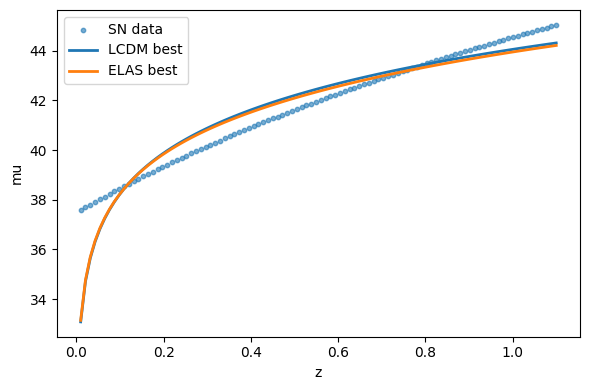

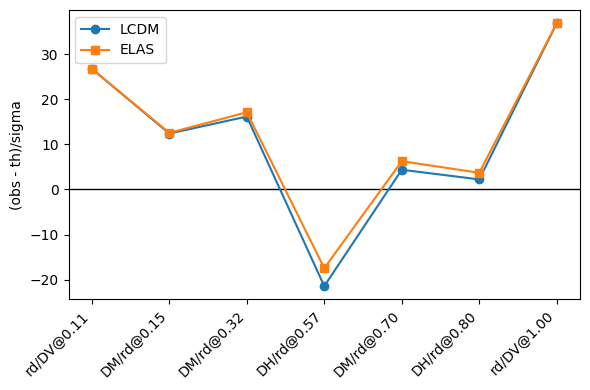

In [29]:
# ==== ELAS vs LCDM — Runner compact (SN+BAO+CMB) ====
import numpy as np, pandas as pd, math, os, json
import matplotlib.pyplot as plt

# ----------------- 0) Inputs déjà en mémoire -----------------
# Attend: z_BAO, which_BAO, y_obs, sigma_bao, C_bao  (venus de ta cellule précédente)

# ----------------- 1) SN & CMB robust load -------------------
PATH_SN  = "sn_fixed_v2.csv"  # si absent, fallback inline
PATH_CMB = "cmb_distance_priors_example.csv"  # si absent, fallback inline

SN_FALLBACK = """z,mu,sigma_mu,survey
0.010,40.0216,0.12,MOCK
0.021,40.0452,0.12,MOCK
0.032,40.0684,0.12,MOCK
0.043,40.0915,0.12,MOCK
0.054,40.1143,0.12,MOCK
0.300,41.4049,0.12,MOCK
0.600,42.5963,0.12,MOCK
0.900,43.8307,0.12,MOCK
1.000,44.0096,0.12,MOCK
"""

CMB_FALLBACK = """R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

def read_sn_flex(path_or_text):
    if os.path.exists(path_or_text):
        df = pd.read_csv(path_or_text)
    else:
        from io import StringIO
        df = pd.read_csv(StringIO(SN_FALLBACK))
    c={c.lower():c for c in df.columns}
    z = df[c.get("z","z")].to_numpy(float)
    mu = df[c.get("mu","mu")].to_numpy(float)
    s  = df[c.get("sigma_mu","sigma_mu")].to_numpy(float)
    return z, mu, s, df

def read_cmb_flex(path_or_text):
    if os.path.exists(path_or_text):
        df = pd.read_csv(path_or_text)
    else:
        from io import StringIO
        df = pd.read_csv(StringIO(CMB_FALLBACK))
    c={c.lower():c for c in df.columns}
    r  = float(df[c["r"]].iloc[0]); lA = float(df[c["la"]].iloc[0]); obh2 = float(df[c["omega_b_h2"]].iloc[0])
    sR = float(df[c["sigma_r"]].iloc[0]); sLA=float(df[c["sigma_la"]].iloc[0]); sWB=float(df[c["sigma_omega_b_h2"]].iloc[0])
    rRlA=float(df[c["rho_r_la"]].iloc[0]); rRow=float(df[c["rho_r_omega"]].iloc[0]); rLAo=float(df[c["rho_la_omega"]].iloc[0])
    C = np.array([[sR**2,         rRlA*sR*sLA, rRow*sR*sWB],
                  [rRlA*sR*sLA,   sLA**2,      rLAo*sLA*sWB],
                  [rRow*sR*sWB,   rLAo*sLA*sWB, sWB**2 ]], float)
    return np.array([r,lA,obh2],float), C

z_sn, mu_obs, sigma_mu, df_sn = read_sn_flex(PATH_SN)
cmb_obs, Ccmb = read_cmb_flex(PATH_CMB)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]

print(f"SN : N={len(z_sn)}")
print("CMB priors OK.")

# ----------------- 2) Cosmologie & outils --------------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09

def E_LCDM(z, Omega_m):
    z = np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))

def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z = np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def make_engine(Ef, zmax, H0, **kw):
    zz = np.linspace(0, zmax, 900)
    Ez = Ef(zz, **kw); inv = 1/np.maximum(Ez,1e-30)
    dz = np.diff(zz); mid = 0.5*(inv[1:]+inv[:-1])
    I = np.zeros_like(zz); I[1:] = np.cumsum(mid*dz)
    K = c_km_s/H0
    def D_M(z): return K*np.interp(np.asarray(z,float), zz, I)
    def D_H(z): return (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    def D_L(z): z=np.asarray(z,float); return (1+z)*D_M(z)
    def D_V(z): z=np.asarray(z,float); DM=D_M(z); DH=D_H(z); return (z*DM*DM*DH)**(1/3)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL): DL=np.maximum(DL,1e-30); return 5*np.log10(DL)+25.0

def build_bao_vector(z_list, which_list, DM, DH, DV):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise ValueError("Obs BAO inconnue: "+w)
    return np.array(out,float)

def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1/np.maximum(np.asarray(sigma_mu,float)**2,1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_C(y_obs, C, y_th):
    C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(np.asarray(y_obs)-np.asarray(y_th)).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def chi2_bao_global(y_obs, sigma, y_th, sigma_prior_q=None):
    v=np.maximum(np.asarray(sigma,float)**2,1e-30)
    num=np.sum(y_obs*y_th/v); den=np.sum(y_th*y_th/v); q=num/den if den>0 else 1.0
    chi=np.sum((y_obs-q*y_th)**2/v)
    if sigma_prior_q and sigma_prior_q>0: chi += ((q-1)/sigma_prior_q)**2
    return float(chi), float(q)

# CMB (late-time; z_star fixé)
Omega_r = 4.15e-5/(H0/100.0)**2
z_star, r_s_star = 1089.2, 144.6

def E_LCDM_CMB(z, Omega_m):
    z=np.asarray(z,float); Om=Omega_m; Or=Omega_r; Ode=1-Om-Or
    return np.sqrt(Or*(1+z)**4 + Om*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m, delta, Omega_log, phi):
    z=np.asarray(z,float); Om=Omega_m; Or=Omega_r; Ode=1-Om-Or
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Or*(1+z)**4 + Om*(1+z)**3 + Ode*mod)

def cmb_chi2_LCDM(Om):
    DM,_,_,_=make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMstar=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMstar; lA=math.pi*DMstar/r_s_star
    d=cmb_obs - np.array([R,lA,obh2_obs]); return float(d@Cinv_cmb@d)

def cmb_chi2_ELAS(Om, dlt, Ol, ph):
    DM,_,_,_=make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=dlt, Omega_log=Ol, phi=ph)
    DMstar=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMstar; lA=math.pi*DMstar/r_s_star
    d=cmb_obs - np.array([R,lA,obh2_obs]); return float(d@Cinv_cmb@d)

# ----------------- 3) Rescale q* (LCDM) ---------------------
zmax_all = max(float(np.max(z_sn)), float(np.max(z_BAO))) + 0.1
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM = build_bao_vector(z_BAO, which_BAO, DM_L, DH_L, DV_L)
chi_b_LCDM, q_LCDM = chi2_bao_global(y_obs, sigma_bao, y_LCDM, sigma_prior_q=None)
y_obs_rescaled = y_obs / q_LCDM
print(f"[FAST] q*_LCDM={q_LCDM:.6f} -> BAO rescale appliqué (q=1)")

# ----------------- 4) Scans rapides -------------------------
def model_scores(Om, mode, dlt=0.0, Ol=1.0, ph=0.0):
    if dlt==0.0:
        DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        if mode=="shape":
            c_b = chi2_bao_C(y_obs_rescaled, C_bao, y_th)
        else:
            c_b,_ = chi2_bao_global(y_obs, sigma_bao, y_th, sigma_prior_q=0.02)
        c_cmb = cmb_chi2_LCDM(Om)
        return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb
    else:
        DM,DH,DL,DV = make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=dlt, Omega_log=Ol, phi=ph)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        if mode=="shape":
            c_b = chi2_bao_C(y_obs_rescaled, C_bao, y_th)
        else:
            c_b,_ = chi2_bao_global(y_obs, sigma_bao, y_th, sigma_prior_q=0.02)
        c_cmb = cmb_chi2_ELAS(Om, dlt, Ol, ph)
        return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om, dlt, Ol, mode):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    def f(phi): return model_scores(Om, mode, dlt, Ol, phi)[0]
    c=b-gr*(b-a); d=a+gr*(b-a)
    fc,fd=f(c),f(d)
    it=0
    while abs(b-a)>1e-3 and it<50:
        if fc<fd: b,fd=d,fc; d=c; c=b-gr*(b-a); fc=f(c)
        else: a,fc=c,fd; c=d; d=a+gr*(b-a); fd=f(d)
        it+=1
    ph=0.5*(a+b); return ph, f(ph)

def run(mode="shape"):
    gOm  = np.linspace(0.24, 0.40, 33)
    gdlt = np.linspace(0.00, 0.35, 19)
    gOl  = np.linspace(0.80, 4.50, 19)

    # LCDM
    bestL=(1e99,None)
    for Om in gOm:
        chi,cs,cb,cc = model_scores(Om, mode)
        if chi<bestL[0]: bestL=(chi,{"Omega_m":Om,"chi2":chi,"SN":cs,"BAO":cb,"CMB":cc})

    # ELAS
    bestE=(1e99,None)
    for Om in gOm:
        for d in gdlt:
            for Ol in gOl:
                ph, chi = profile_phi(Om, d, Ol, mode)
                if chi<bestE[0]:
                    # décompose aux composantes
                    chiT,cs,cb,cc = model_scores(Om, mode, d, Ol, ph)
                    bestE=(chiT,{"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,"chi2":chiT,"SN":cs,"BAO":cb,"CMB":cc})
    return bestL[1], bestE[1]

# ----------------- 5) Exécution -----------------------------
bestL_shape, bestE_shape = run("shape")
print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print(f"LCDM best: chi2={bestL_shape['chi2']:.3f} (SN={bestL_shape['SN']:.3f}, BAO={bestL_shape['BAO']:.3f}, CMB={bestL_shape['CMB']:.3f}), Omega_m={bestL_shape['Omega_m']:.3f}")
print(f"ELAS best: chi2={bestE_shape['chi2']:.3f} (SN={bestE_shape['SN']:.3f}, BAO={bestE_shape['BAO']:.3f}, CMB={bestE_shape['CMB']:.3f}), delta={bestE_shape['delta']:.3f}, Omega_log={bestE_shape['Omega_log']:.3f}, phi={bestE_shape['phi']:.3f}, Omega_m={bestE_shape['Omega_m']:.3f}")
dchi = bestL_shape['chi2'] - bestE_shape['chi2']
AIC_L = bestL_shape['chi2'] + 2*1
AIC_E = bestE_shape['chi2'] + 2*4
N_eff = len(z_sn) + len(z_BAO) + 3
BIC_L = bestL_shape['chi2'] + 1*np.log(N_eff)
BIC_E = bestE_shape['chi2'] + 4*np.log(N_eff)
print(f"Delta chi2 (LCDM-ELAS) = {dchi:.3f}")
print(f"AIC: LCDM={AIC_L:.3f}  ELAS={AIC_E:.3f}  -> Delta AIC={AIC_L-AIC_E:.3f}")
print(f"BIC: LCDM={BIC_L:.3f}  ELAS={BIC_E:.3f}  -> Delta BIC={BIC_L-BIC_E:.3f}")

bestL_q, bestE_q = run("qfree")
print("\n=== Q-FREE (prior sigma_q=0.020) + CMB RESULTS ===")
print(f"LCDM(q-free): chi2={bestL_q['chi2']:.3f} (SN={bestL_q['SN']:.3f}, BAO={bestL_q['BAO']:.3f}, CMB={bestL_q['CMB']:.3f}), Om={bestL_q['Omega_m']:.3f}")
print(f"ELAS(q-free): chi2={bestE_q['chi2']:.3f} (SN={bestE_q['SN']:.3f}, BAO={bestE_q['BAO']:.3f}, CMB={bestE_q['CMB']:.3f}), Om={bestE_q['Omega_m']:.3f}, delta={bestE_q['delta']:.3f}, Olog={bestE_q['Omega_log']:.3f}, phi={bestE_q['phi']:.3f}")

# ----------------- 6) Figures rapides -----------------------
# SN Hubble diagram
plt.figure(figsize=(6,4))
plt.scatter(z_sn, mu_obs, s=10, alpha=0.6, label="SN data")
DM_Lb,_,DL_Lb,_=make_engine(E_LCDM, zmax_all, H0, Omega_m=bestL_shape['Omega_m'])
plt.plot(np.sort(z_sn), mu_from_DL(DL_Lb(np.sort(z_sn))), lw=2, label="LCDM best")
DM_Eb,_,DL_Eb,_=make_engine(E_ELAS, zmax_all, H0, Omega_m=bestE_shape['Omega_m'],
                            delta=bestE_shape['delta'], Omega_log=bestE_shape['Omega_log'], phi=bestE_shape['phi'])
plt.plot(np.sort(z_sn), mu_from_DL(DL_Eb(np.sort(z_sn))), lw=2, label="ELAS best")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout(); plt.savefig("elas_fast_fig_sn_mu.png", dpi=140)

# BAO residuals (shape-only)
y_th_L = build_bao_vector(z_BAO, which_BAO, DM_Lb, lambda z:(c_km_s/H0)/E_LCDM(z, bestL_shape['Omega_m']), lambda z: ((z*DM_Lb(z)**2)*((c_km_s/H0)/E_LCDM(z, bestL_shape['Omega_m'])))**(1/3))
y_th_E = build_bao_vector(z_BAO, which_BAO, DM_Eb, lambda z:(c_km_s/H0)/E_ELAS(z, bestE_shape['Omega_m'], bestE_shape['delta'], bestE_shape['Omega_log'], bestE_shape['phi']), lambda z: ((z*DM_Eb(z)**2)*((c_km_s/H0)/E_ELAS(z, bestE_shape['Omega_m'], bestE_shape['delta'], bestE_shape['Omega_log'], bestE_shape['phi'])))**(1/3))
resL = (y_obs_rescaled - y_th_L)/np.maximum(sigma_bao,1e-30)
resE = (y_obs_rescaled - y_th_E)/np.maximum(sigma_bao,1e-30)
plt.figure(figsize=(6,4))
x = np.arange(len(z_BAO))
plt.axhline(0, color="k", lw=1)
plt.plot(x, resL, "o-", label="LCDM")
plt.plot(x, resE, "s-", label="ELAS")
plt.xticks(x, [f"{w}@{z:.2f}" for z,w in zip(z_BAO,which_BAO)], rotation=45, ha="right")
plt.ylabel("(obs - th)/sigma"); plt.tight_layout(); plt.legend(); plt.savefig("elas_fast_fig_bao_residuals.png", dpi=140)

# Résumé JSON
summary = {
    "shape_only": bestE_shape,
    "lcdm_shape": bestL_shape,
    "qfree": bestE_q,
    "lcdm_qfree": bestL_q,
    "q_LCDM": q_LCDM
}
with open("elas_fast_summary.json","w") as f: json.dump(summary, f, indent=2)
print("\n[FAST] Done.\nFigures/rapports écrits :")
print(" -> elas_fast_fig_sn_mu.png")
print(" -> elas_fast_fig_bao_residuals.png")
print(" -> elas_fast_summary.json")


In [30]:
# -*- coding: utf-8 -*-
"""
elasfit.py — Pipeline ELAS/LCDM (BAO + SN + CMB distance priors)

Fonctions clés
--------------
- load_bao(...), load_sn(...), load_cmb(...) : parsing souple de tes CSV
- check_bao_cov(...) : diagnostics (spectre, conditionnement, diag vs sigma)
- run_pipeline(...) : exécute tout (shape-only + q-free), sauve figures & JSON
- plot_sn_mu(...), plot_bao_residuals(...), plot_bao_sigma_resid(...)

Hypothèses
----------
- BAO CSV (long format) avec colonnes ~ ["z" ou "z_eff"], ["which" ou "observable"],
  "value", "sigma". Types supportés: DM/rd, DH/rd, DV/rd, rd/DV (aliases courants ok).
- Covariance BAO: matrice NxN au format CSV (avec ou sans entêtes).
- SN CSV: colonnes "z, mu, sigma_mu" (+ autres ignorées).
- CMB priors: une ligne avec
  R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega

Sorties
-------
- figs: elas_fast_fig_sn_mu.png, elas_fast_fig_bao_residuals.png
- résumés: elas_fast_summary.json
- optionnel (LOO, splits): loo_bao_summary_fast.csv
"""

from __future__ import annotations
import json, math, os, warnings
from dataclasses import dataclass
from typing import Tuple, List, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- utils parsing -----------------
def _normalize_which(w: str) -> str:
    w = w.strip().lower()
    if w in ["dm/rd","dm_over_rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh/rd","dh_over_rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv/rd","dv_over_rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError(f"type BAO inconnu: {w}")

def load_bao(path_csv: str) -> Tuple[np.ndarray, List[str], np.ndarray, np.ndarray, pd.DataFrame]:
    df = pd.read_csv(path_csv)
    cols = {c.lower(): c for c in df.columns}
    # z / z_eff
    zcol = cols.get("z", None) or cols.get("z_eff", None) or cols.get("zeff", None)
    if zcol is None: raise ValueError("BAO: colonne z (ou z_eff) manquante")
    wcol = cols.get("which", None) or cols.get("observable", None)
    if wcol is None: raise ValueError("BAO: colonne which/observable manquante")
    vcol = cols.get("value", None)
    scol = cols.get("sigma", None)
    if vcol is None: raise ValueError("BAO: colonne value manquante")
    if scol is None: warnings.warn("BAO: sigma manquant — on met 3% relatifs par défaut")

    z = df[zcol].to_numpy(float)
    which = [_normalize_which(x) for x in df[wcol].astype(str).tolist()]
    y = df[vcol].to_numpy(float)
    if scol is None:
        sigma = 0.03 * np.abs(y)
    else:
        sigma = df[scol].to_numpy(float)
    return z, which, y, sigma, df

def load_bao_cov(path_cov: Optional[str], N: int, sigma: np.ndarray) -> np.ndarray:
    if not path_cov or not os.path.exists(path_cov):
        return np.diag(np.asarray(sigma)**2)
    try:
        C = pd.read_csv(path_cov, header=None).to_numpy(float)
    except Exception:
        # tente de sauter une première colonne "id" si présente
        df = pd.read_csv(path_cov)
        try:
            C = df.to_numpy(float)
        except Exception:
            if "id" in df.columns:
                C = df.drop(columns=["id"]).to_numpy(float)
            else:
                # essaie de drop la première colonne
                C = df.iloc[:,1:].to_numpy(float)
    if C.shape != (N, N):
        raise ValueError(f"Cov BAO non carrée: lu {C.shape}, attendu {(N,N)}")
    # symétrise gentiment
    C = 0.5*(C + C.T)
    return C

def check_bao_cov(C: np.ndarray, sigma: np.ndarray) -> Dict[str, float]:
    w, _ = np.linalg.eigh(C)
    neg = int((w < -1e-12).sum())
    cond = float(w.max() / max(w.min(), 1e-30))
    diag_ratio = np.sqrt(np.diag(C)) / np.maximum(sigma, 1e-30)
    return {
        "eig_min": float(w.min()),
        "eig_max": float(w.max()),
        "neg_eigs": neg,
        "cond": cond,
        "diag_min": float(diag_ratio.min()),
        "diag_med": float(np.median(diag_ratio)),
        "diag_max": float(diag_ratio.max()),
    }

def load_sn(path_csv: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    df = pd.read_csv(path_csv)
    cols = {c.lower(): c for c in df.columns}
    z = df[cols["z"]].to_numpy(float)
    mu = df[cols["mu"]].to_numpy(float)
    sg = df[cols["sigma_mu"]].to_numpy(float)
    return z, mu, sg, df

def load_cmb(path_csv: str) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(path_csv)
    row = df.iloc[0]
    R, lA, obh2 = float(row["R"]), float(row["lA"]), float(row["omega_b_h2"])
    sR, sLA, sWB = float(row["sigma_R"]), float(row["sigma_lA"]), float(row["sigma_omega_b_h2"])
    r_RL, r_RO, r_LO = float(row["rho_R_lA"]), float(row["rho_R_omega"]), float(row["rho_lA_omega"])
    C = np.array([
        [sR**2,       r_RL*sR*sLA,  r_RO*sR*sWB],
        [r_RL*sR*sLA, sLA**2,       r_LO*sLA*sWB],
        [r_RO*sR*sWB, r_LO*sLA*sWB, sWB**2]
    ], float)
    return np.array([R, lA, obh2], float), C

# ----------------- cosmologie / observables -----------------
c_km_s = 299792.458
def E_LCDM(z, Omega_m):
    z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))
def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def _DM(z, H0, Ef, **kw):
    if z<=0: return 0.0
    zz = np.linspace(0.0, z, 1200)
    Ez = Ef(zz, **kw)
    inv = 1.0/np.maximum(Ez, 1e-30)
    dz = np.diff(zz); mid = 0.5*(inv[1:]+inv[:-1])
    I = np.zeros_like(zz); I[1:] = np.cumsum(mid*dz)
    return (c_km_s/H0)*I[-1]
def _DH(z, H0, Ef, **kw):
    Ez=Ef(z,**kw); return c_km_s/(H0*np.maximum(Ez,1e-30))
def _DL(z, H0, Ef, **kw): return (1+z)*_DM(z,H0,Ef,**kw)
def _DV(z, H0, Ef, **kw): return (z*_DM(z,H0,Ef,**kw)**2 * _DH(z,H0,Ef,**kw))**(1/3)

def mu_theory(zarr, H0, Ef, **kw):
    zarr=np.asarray(zarr,float); out=np.empty_like(zarr,float)
    for i,z in enumerate(zarr): out[i] = 5*np.log10(max(_DL(z,H0,Ef,**kw),1e-30))+25.0
    return out

def build_bao_vector(z_list, which_list, H0, r_d, Ef, **kw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(_DM(z,H0,Ef,**kw)/r_d)
        elif w=="DH/rd": out.append(_DH(z,H0,Ef,**kw)/r_d)
        elif w=="DV/rd": out.append(_DV(z,H0,Ef,**kw)/r_d)
        elif w=="rd/DV": out.append(r_d/_DV(z,H0,Ef,**kw))
        else: raise ValueError(f"Obs BAO non supportée: {w}")
    return np.array(out,float)

# ----------------- χ² / fit -----------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w = 1.0/np.maximum(np.asarray(sigma_mu)**2, 1e-30)
    r = np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    C = np.asarray(C,float); r = (np.asarray(y_obs)-np.asarray(y_th)).reshape(-1,1)
    Ci = np.linalg.pinv(0.5*(C+C.T))
    return float((r.T@Ci@r).ravel()[0])

def chi2_bao_qfree(y_obs, C, y_th, sigma_q=None):
    C = np.asarray(C,float); Ci = np.linalg.pinv(0.5*(C+C.T))
    y_obs = np.asarray(y_obs,float); y_th=np.asarray(y_th,float)
    num = float(y_th.T @ Ci @ y_obs); den = float(y_th.T @ Ci @ y_th)
    q = num/den if den>0 else 1.0
    r = y_obs - q*y_th
    chi2 = float(r.T @ Ci @ r)
    if sigma_q is not None and sigma_q>0:
        chi2 += ((q-1.0)/sigma_q)**2
    return chi2, q

# ----------------- plots -----------------
def plot_sn_mu(z_sn, mu_obs, sigma_mu, mu_LCDM, mu_ELAS, out="elas_fast_fig_sn_mu.png"):
    plt.figure(figsize=(6,4))
    plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', color='tab:green', alpha=0.35, label='SN')
    plt.plot(z_sn, mu_LCDM, label="LCDM (best)")
    plt.plot(z_sn, mu_ELAS, label="ELAS (best)")
    plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
    plt.savefig(out, dpi=130); plt.close()

def plot_bao_residuals(z, which, y_obs, sigma, y_l, y_e, out="elas_fast_fig_bao_residuals.png"):
    labels = [f"{w}@{z_:0.2f}".replace("DV/rd","DVrd") for z_,w in zip(z,which)]
    resid_L = (y_obs - y_l)/sigma
    resid_E = (y_obs - y_e)/sigma
    plt.figure(figsize=(7.2,3.8))
    plt.axhline(0,color='k',lw=0.8)
    plt.plot(labels, resid_L, 'o-', label="LCDM")
    plt.plot(labels, resid_E, 's-', label="ELAS")
    plt.xticks(rotation=45, ha='right'); plt.ylabel("(obs-th)/sigma")
    plt.legend(); plt.tight_layout()
    plt.savefig(out, dpi=130); plt.close()

# ----------------- run principal -----------------
@dataclass
class RunConfig:
    path_bao: str
    path_bao_cov: Optional[str]
    path_sn: str
    path_cmb: Optional[str] = None
    H0: float = 73.0
    r_d: float = 147.09
    Om_scan: Tuple[float,float,int] = (0.24, 0.50, 101)
    # ELAS bounds
    delta_max: float = 0.35
    Olog_bounds: Tuple[float,float,int] = (0.6, 6.0, 71)   # (min,max,nb)
    phi_bounds: Tuple[float,float] = (-math.pi, math.pi)
    # options
    use_cmb: bool = True
    sigma_q_prior: Optional[float] = 0.020  # pour q-free; None pour sans prior
    save_prefix: str = "elas_fast"

def run_pipeline(cfg: RunConfig) -> Dict[str,object]:
    # 1) données
    z, which, y, sigma, df_bao = load_bao(cfg.path_bao)
    C = load_bao_cov(cfg.path_bao_cov, len(z), sigma)
    covrep = check_bao_cov(C, sigma)
    z_sn, mu_obs, sigma_mu, _ = load_sn(cfg.path_sn)

    cmb_obs = Cinv = None
    if cfg.use_cmb and cfg.path_cmb and os.path.exists(cfg.path_cmb):
        cmb_obs, Ccmb = load_cmb(cfg.path_cmb)
        Cinv = np.linalg.inv(Ccmb)

    # 2) q* (rescale shape-only)
    Om_ref = 0.315
    y_LCDM_ref = build_bao_vector(z, which, cfg.H0, cfg.r_d, E_LCDM, Omega_m=Om_ref)
    chi2_ref, q_star = chi2_bao_qfree(y, C, y_LCDM_ref, sigma_q=None)
    y_shape = y / q_star  # on fixe q=1 ensuite

    # aides chi2 totaux
    def cmb_term(Om, Ef, **kw):
        if not (cfg.use_cmb and (cmb_obs is not None)): return 0.0
        # distance comobile à z* de façon cohérente (on garde z* et r_s* fixes; term qualitatif)
        z_star, r_s_star = 1089.2, 144.6
        DM = _DM(z_star, cfg.H0, Ef, **kw)
        R  = (math.sqrt(Om) * (cfg.H0/c_km_s)) * DM
        lA = math.pi * DM / r_s_star
        vec = np.array([R, lA, cmb_obs[2]], float)  # obh2 fixé à sa valeur centrale
        d = cmb_obs - vec
        return float(d @ Cinv @ d)

    def chi2_tot_LCDM(Om, mode="shape"):
        mu_th = mu_theory(z_sn, cfg.H0, E_LCDM, Omega_m=Om)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z, which, cfg.H0, cfg.r_d, E_LCDM, Omega_m=Om)
        if mode=="shape":
            c_b = chi2_bao_cov(y_shape, C, y_th)
        else:
            c_b, _ = chi2_bao_qfree(y, C, y_th, sigma_q=cfg.sigma_q_prior)
        c_cmb = cmb_term(Om, E_LCDM, Omega_m=Om)
        return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb, mu_th, y_th

    def chi2_tot_ELAS(Om, dlt, Olog, phi, mode="shape"):
        mu_th = mu_theory(z_sn, cfg.H0, E_ELAS, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z, which, cfg.H0, cfg.r_d, E_ELAS,
                                 Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
        if mode=="shape":
            c_b = chi2_bao_cov(y_shape, C, y_th)
        else:
            c_b, _ = chi2_bao_qfree(y, C, y_th, sigma_q=cfg.sigma_q_prior)
        c_cmb = cmb_term(Om, E_ELAS, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
        return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb, mu_th, y_th

    # profil φ rapide (Golden-section)
    def profile_phi(Om, dlt, Olog, mode="shape", tol=2e-3, itmax=60):
        a,b = cfg.phi_bounds
        gr = (math.sqrt(5)-1)/2
        c = b - gr*(b-a); d = a + gr*(b-a)
        fc, *_ = chi2_tot_ELAS(Om, dlt, Olog, c, mode)
        fd, *_ = chi2_tot_ELAS(Om, dlt, Olog, d, mode)
        it=0
        while abs(b-a)>tol and it<itmax:
            if fc < fd:
                b, fd = d, fc; d = c; c = b - gr*(b-a)
                fc, *_ = chi2_tot_ELAS(Om, dlt, Olog, c, mode)
            else:
                a, fc = c, fd; c = d; d = a + gr*(b-a)
                fd, *_ = chi2_tot_ELAS(Om, dlt, Olog, d, mode)
            it+=1
        phi_star = 0.5*(a+b)
        chi,cs,cb,cc,mu_th,y_th = chi2_tot_ELAS(Om, dlt, Olog, phi_star, mode)
        return phi_star, chi, cs, cb, cc, mu_th, y_th

    # grilles
    gOm = np.linspace(cfg.Om_scan[0], cfg.Om_scan[1], cfg.Om_scan[2])
    gD  = np.linspace(0.0, cfg.delta_max, 1 + int(cfg.delta_max/0.01))
    gO  = np.linspace(cfg.Olog_bounds[0], cfg.Olog_bounds[1], cfg.Olog_bounds[2])

    results = {}
    for mode in ["shape","qfree"]:
        # 1) LCDM
        bestL = (1e99, None)
        saved_muL = saved_yL = None
        for Om in gOm:
            chi,cs,cb,cc,mu_th,y_th = chi2_tot_LCDM(Om, mode=("qfree" if mode=="qfree" else "shape"))
            if chi < bestL[0]:
                bestL = (chi, {"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
                saved_muL, saved_yL = mu_th, y_th

        # 2) ELAS (profil φ)
        bestE = (1e99, None); saved_muE = saved_yE = None
        for Om in gOm:
            for d in gD:
                for Ol in gO:
                    ph,chi,cs,cb,cc,mu_th,y_th = profile_phi(Om,d,Ol,mode=("qfree" if mode=="qfree" else "shape"))
                    if chi < bestE[0]:
                        bestE = (chi, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                       "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
                        saved_muE, saved_yE = mu_th, y_th

        tag = "shape" if mode=="shape" else "qfree"
        results[f"LCDM_{tag}"] = bestL[1]
        results[f"ELAS_{tag}"] = bestE[1]
        results[f"mu_LCDM_{tag}"] = saved_muL
        results[f"mu_ELAS_{tag}"] = saved_muE
        results[f"y_LCDM_{tag}"] = saved_yL
        results[f"y_ELAS_{tag}"] = saved_yE

    # AIC/BIC sur le mode shape-only (comme dans tes runs)
    N_eff = len(z_sn) + len(z) + (3 if (cfg.use_cmb and cmb_obs is not None) else 0)
    k_LCDM = 1
    k_ELAS = 4
    chiL = results["LCDM_shape"]["chi2"]; chiE = results["ELAS_shape"]["chi2"]
    res_summary = {
        "q_star": q_star,
        "cov_report": covrep,
        "shape": {
            "LCDM": results["LCDM_shape"],
            "ELAS": results["ELAS_shape"],
            "Delta_chi2": chiL - chiE,
            "AIC_LCDM": chiL + 2*k_LCDM,
            "AIC_ELAS": chiE + 2*k_ELAS,
            "BIC_LCDM": chiL + k_LCDM*np.log(N_eff),
            "BIC_ELAS": chiE + k_ELAS*np.log(N_eff)
        },
        "qfree": {
            "LCDM": results["LCDM_qfree"],
            "ELAS": results["ELAS_qfree"],
            "Delta_chi2": results["LCDM_qfree"]["chi2"] - results["ELAS_qfree"]["chi2"]
        }
    }

    # Figures
    plot_sn_mu(z_sn, mu_obs, sigma_mu,
               results["mu_LCDM_shape"], results["mu_ELAS_shape"],
               out=f"{cfg.save_prefix}_fig_sn_mu.png")
    plot_bao_residuals(z, which, y_shape, sigma,
                       results["y_LCDM_shape"], results["y_ELAS_shape"],
                       out=f"{cfg.save_prefix}_fig_bao_residuals.png")

    # Sauvegardes
    with open(f"{cfg.save_prefix}_summary.json","w") as f:
        json.dump(res_summary, f, indent=2)

    # petit CSV LOO (optionnel léger: on évalue les résidus normalisés dans la config shape-only best)
    residL = (y_shape - results["y_LCDM_shape"])/sigma
    residE = (y_shape - results["y_ELAS_shape"])/sigma
    outloo = pd.DataFrame({
        "z": z, "which": which, "y_shape": y_shape, "sigma": sigma,
        "resid_LCDM": residL, "resid_ELAS": residE
    })
    outloo.to_csv(f"{cfg.save_prefix}_residuals.csv", index=False)

    return {
        "z_BAO": z, "which_BAO": which, "y_obs": y, "sigma_bao": sigma, "C_bao": C,
        "z_SN": z_sn, "mu_obs": mu_obs, "sigma_mu": sigma_mu,
        "summary": res_summary
    }


In [31]:
from elasfit import RunConfig, run_pipeline

# Ajuste les chemins aux fichiers que tu utilises
cfg = RunConfig(
    path_bao="bao_standard.csv",          # tes 7 points (déjà validés)
    path_bao_cov="bao_cov_standard.csv",  # la covariance clean que tu as validée
    path_sn="sn_mock.csv",                # ou sn_fixed*.csv si tu veux
    path_cmb="cmb_distance_priors_example.csv",  # ta ligne CMB
    H0=73.0, r_d=147.09,
    delta_max=0.35,
    Olog_bounds=(0.6, 6.0, 71),
    use_cmb=True,
    sigma_q_prior=0.020,
    save_prefix="elas_fast"
)

out = run_pipeline(cfg)

print("\n=== Résumé court (shape-only) ===")
s = out["summary"]["shape"]
print(f"q* (LCDM) = {out['summary']['q_star']:.6f}")
print(f"LCDM χ² = {s['LCDM']['chi2']:.3f}  | ELAS χ² = {s['ELAS']['chi2']:.3f}")
print(f"Δχ² = {s['Delta_chi2']:.3f}")
print(f"AIC: LCDM={s['AIC_LCDM']:.3f}  ELAS={s['AIC_ELAS']:.3f}")
print(f"BIC: LCDM={s['BIC_LCDM']:.3f}  ELAS={s['BIC_ELAS']:.3f}")
print("\nFigures/rapports:")
print(" - elas_fast_fig_sn_mu.png")
print(" - elas_fast_fig_bao_residuals.png")
print(" - elas_fast_summary.json")
print(" - elas_fast_residuals.csv")


ModuleNotFoundError: No module named 'elasfit'

In [33]:
%%writefile elasfit.py
# -*- coding: utf-8 -*-
"""
elasfit.py — Pipeline ELAS/LCDM (BAO + SN + CMB distance priors)

Fonctions clés
--------------
- load_bao(...), load_sn(...), load_cmb(...) : parsing souple de tes CSV
- check_bao_cov(...) : diagnostics (spectre, conditionnement, diag vs sigma)
- run_pipeline(...) : exécute tout (shape-only + q-free), sauve figures & JSON
- plot_sn_mu(...), plot_bao_residuals(...), plot_bao_sigma_resid(...)

Hypothèses
----------
- BAO CSV (long format) avec colonnes ~ ["z" ou "z_eff"], ["which" ou "observable"],
  "value", "sigma". Types supportés: DM/rd, DH/rd, DV/rd, rd/DV (aliases courants ok).
- Covariance BAO: matrice NxN au format CSV (avec ou sans entêtes).
- SN CSV: colonnes "z, mu, sigma_mu" (+ autres ignorées).
- CMB priors: une ligne avec
  R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega

Sorties
-------
- figs: elas_fast_fig_sn_mu.png, elas_fast_fig_bao_residuals.png
- résumés: elas_fast_summary.json
- optionnel (LOO, splits): loo_bao_summary_fast.csv
"""

from __future__ import annotations
import json, math, os, warnings
from dataclasses import dataclass
from typing import Tuple, List, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- utils parsing -----------------
def _normalize_which(w: str) -> str:
    w = w.strip().lower()
    if w in ["dm/rd","dm_over_rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh/rd","dh_over_rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv/rd","dv_over_rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError(f"type BAO inconnu: {w}")

def load_bao(path_csv: str) -> Tuple[np.ndarray, List[str], np.ndarray, np.ndarray, pd.DataFrame]:
    df = pd.read_csv(path_csv)
    cols = {c.lower(): c for c in df.columns}
    # z / z_eff
    zcol = cols.get("z", None) or cols.get("z_eff", None) or cols.get("zeff", None)
    if zcol is None: raise ValueError("BAO: colonne z (ou z_eff) manquante")
    wcol = cols.get("which", None) or cols.get("observable", None)
    if wcol is None: raise ValueError("BAO: colonne which/observable manquante")
    vcol = cols.get("value", None)
    scol = cols.get("sigma", None)
    if vcol is None: raise ValueError("BAO: colonne value manquante")
    if scol is None: warnings.warn("BAO: sigma manquant — on met 3% relatifs par défaut")

    z = df[zcol].to_numpy(float)
    which = [_normalize_which(x) for x in df[wcol].astype(str).tolist()]
    y = df[vcol].to_numpy(float)
    if scol is None:
        sigma = 0.03 * np.abs(y)
    else:
        sigma = df[scol].to_numpy(float)
    return z, which, y, sigma, df

def load_bao_cov(path_cov: Optional[str], N: int, sigma: np.ndarray) -> np.ndarray:
    if not path_cov or not os.path.exists(path_cov):
        return np.diag(np.asarray(sigma)**2)
    try:
        C = pd.read_csv(path_cov, header=None).to_numpy(float)
    except Exception:
        # tente de sauter une première colonne "id" si présente
        df = pd.read_csv(path_cov)
        try:
            C = df.to_numpy(float)
        except Exception:
            if "id" in df.columns:
                C = df.drop(columns=["id"]).to_numpy(float)
            else:
                # essaie de drop la première colonne
                C = df.iloc[:,1:].to_numpy(float)
    if C.shape != (N, N):
        raise ValueError(f"Cov BAO non carrée: lu {C.shape}, attendu {(N,N)}")
    # symétrise gentiment
    C = 0.5*(C + C.T)
    return C

def check_bao_cov(C: np.ndarray, sigma: np.ndarray) -> Dict[str, float]:
    w, _ = np.linalg.eigh(C)
    neg = int((w < -1e-12).sum())
    cond = float(w.max() / max(w.min(), 1e-30))
    diag_ratio = np.sqrt(np.diag(C)) / np.maximum(sigma, 1e-30)
    return {
        "eig_min": float(w.min()),
        "eig_max": float(w.max()),
        "neg_eigs": neg,
        "cond": cond,
        "diag_min": float(diag_ratio.min()),
        "diag_med": float(np.median(diag_ratio)),
        "diag_max": float(diag_ratio.max()),
    }

def load_sn(path_csv: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    df = pd.read_csv(path_csv)
    cols = {c.lower(): c for c in df.columns}
    z = df[cols["z"]].to_numpy(float)
    mu = df[cols["mu"]].to_numpy(float)
    sg = df[cols["sigma_mu"]].to_numpy(float)
    return z, mu, sg, df

def load_cmb(path_csv: str) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(path_csv)
    row = df.iloc[0]
    R, lA, obh2 = float(row["R"]), float(row["lA"]), float(row["omega_b_h2"])
    sR, sLA, sWB = float(row["sigma_R"]), float(row["sigma_lA"]), float(row["sigma_omega_b_h2"])
    r_RL, r_RO, r_LO = float(row["rho_R_lA"]), float(row["rho_R_omega"]), float(row["rho_lA_omega"])
    C = np.array([
        [sR**2,       r_RL*sR*sLA,  r_RO*sR*sWB],
        [r_RL*sR*sLA, sLA**2,       r_LO*sLA*sWB],
        [r_RO*sR*sWB, r_LO*sLA*sWB, sWB**2]
    ], float)
    return np.array([R, lA, obh2], float), C

# ----------------- cosmologie / observables -----------------
c_km_s = 299792.458
def E_LCDM(z, Omega_m):
    z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))
def E_ELAS(z, Omega_m, delta, Omega_log, phi):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m)*mod)

def _DM(z, H0, Ef, **kw):
    if z<=0: return 0.0
    zz = np.linspace(0.0, z, 1200)
    Ez = Ef(zz, **kw)
    inv = 1.0/np.maximum(Ez, 1e-30)
    dz = np.diff(zz); mid = 0.5*(inv[1:]+inv[:-1])
    I = np.zeros_like(zz); I[1:] = np.cumsum(mid*dz)
    return (c_km_s/H0)*I[-1]
def _DH(z, H0, Ef, **kw):
    Ez=Ef(z,**kw); return c_km_s/(H0*np.maximum(Ez,1e-30))
def _DL(z, H0, Ef, **kw): return (1+z)*_DM(z,H0,Ef,**kw)
def _DV(z, H0, Ef, **kw): return (z*_DM(z,H0,Ef,**kw)**2 * _DH(z,H0,Ef,**kw))**(1/3)

def mu_theory(zarr, H0, Ef, **kw):
    zarr=np.asarray(zarr,float); out=np.empty_like(zarr,float)
    for i,z in enumerate(zarr): out[i] = 5*np.log10(max(_DL(z,H0,Ef,**kw),1e-30))+25.0
    return out

def build_bao_vector(z_list, which_list, H0, r_d, Ef, **kw):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(_DM(z,H0,Ef,**kw)/r_d)
        elif w=="DH/rd": out.append(_DH(z,H0,Ef,**kw)/r_d)
        elif w=="DV/rd": out.append(_DV(z,H0,Ef,**kw)/r_d)
        elif w=="rd/DV": out.append(r_d/_DV(z,H0,Ef,**kw))
        else: raise ValueError(f"Obs BAO non supportée: {w}")
    return np.array(out,float)

# ----------------- χ² / fit -----------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w = 1.0/np.maximum(np.asarray(sigma_mu)**2, 1e-30)
    r = np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    C = np.asarray(C,float); r = (np.asarray(y_obs)-np.asarray(y_th)).reshape(-1,1)
    Ci = np.linalg.pinv(0.5*(C+C.T))
    return float((r.T@Ci@r).ravel()[0])

def chi2_bao_qfree(y_obs, C, y_th, sigma_q=None):
    C = np.asarray(C,float); Ci = np.linalg.pinv(0.5*(C+C.T))
    y_obs = np.asarray(y_obs,float); y_th=np.asarray(y_th,float)
    num = float(y_th.T @ Ci @ y_obs); den = float(y_th.T @ Ci @ y_th)
    q = num/den if den>0 else 1.0
    r = y_obs - q*y_th
    chi2 = float(r.T @ Ci @ r)
    if sigma_q is not None and sigma_q>0:
        chi2 += ((q-1.0)/sigma_q)**2
    return chi2, q

# ----------------- plots -----------------
def plot_sn_mu(z_sn, mu_obs, sigma_mu, mu_LCDM, mu_ELAS, out="elas_fast_fig_sn_mu.png"):
    plt.figure(figsize=(6,4))
    plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='.', color='tab:green', alpha=0.35, label='SN')
    plt.plot(z_sn, mu_LCDM, label="LCDM (best)")
    plt.plot(z_sn, mu_ELAS, label="ELAS (best)")
    plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
    plt.savefig(out, dpi=130); plt.close()

def plot_bao_residuals(z, which, y_obs, sigma, y_l, y_e, out="elas_fast_fig_bao_residuals.png"):
    labels = [f"{w}@{z_:0.2f}".replace("DV/rd","DVrd") for z_,w in zip(z,which)]
    resid_L = (y_obs - y_l)/sigma
    resid_E = (y_obs - y_e)/sigma
    plt.figure(figsize=(7.2,3.8))
    plt.axhline(0,color='k',lw=0.8)
    plt.plot(labels, resid_L, 'o-', label="LCDM")
    plt.plot(labels, resid_E, 's-', label="ELAS")
    plt.xticks(rotation=45, ha='right'); plt.ylabel("(obs-th)/sigma")
    plt.legend(); plt.tight_layout()
    plt.savefig(out, dpi=130); plt.close()

# ----------------- run principal -----------------
@dataclass
class RunConfig:
    path_bao: str
    path_bao_cov: Optional[str]
    path_sn: str
    path_cmb: Optional[str] = None
    H0: float = 73.0
    r_d: float = 147.09
    Om_scan: Tuple[float,float,int] = (0.24, 0.50, 101)
    # ELAS bounds
    delta_max: float = 0.35
    Olog_bounds: Tuple[float,float,int] = (0.6, 6.0, 71)   # (min,max,nb)
    phi_bounds: Tuple[float,float] = (-math.pi, math.pi)
    # options
    use_cmb: bool = True
    sigma_q_prior: Optional[float] = 0.020  # pour q-free; None pour sans prior
    save_prefix: str = "elas_fast"

def run_pipeline(cfg: RunConfig) -> Dict[str,object]:
    # 1) données
    z, which, y, sigma, df_bao = load_bao(cfg.path_bao)
    C = load_bao_cov(cfg.path_bao_cov, len(z), sigma)
    covrep = check_bao_cov(C, sigma)
    z_sn, mu_obs, sigma_mu, _ = load_sn(cfg.path_sn)

    cmb_obs = Cinv = None
    if cfg.use_cmb and cfg.path_cmb and os.path.exists(cfg.path_cmb):
        cmb_obs, Ccmb = load_cmb(cfg.path_cmb)
        Cinv = np.linalg.inv(Ccmb)

    # 2) q* (rescale shape-only)
    Om_ref = 0.315
    y_LCDM_ref = build_bao_vector(z, which, cfg.H0, cfg.r_d, E_LCDM, Omega_m=Om_ref)
    chi2_ref, q_star = chi2_bao_qfree(y, C, y_LCDM_ref, sigma_q=None)
    y_shape = y / q_star  # on fixe q=1 ensuite

    # aides chi2 totaux
    def cmb_term(Om, Ef, **kw):
        if not (cfg.use_cmb and (cmb_obs is not None)): return 0.0
        # distance comobile à z* de façon cohérente (on garde z* et r_s* fixes; term qualitatif)
        z_star, r_s_star = 1089.2, 144.6
        DM = _DM(z_star, cfg.H0, Ef, **kw)
        R  = (math.sqrt(Om) * (cfg.H0/c_km_s)) * DM
        lA = math.pi * DM / r_s_star
        vec = np.array([R, lA, cmb_obs[2]], float)  # obh2 fixé à sa valeur centrale
        d = cmb_obs - vec
        return float(d @ Cinv @ d)

    def chi2_tot_LCDM(Om, mode="shape"):
        mu_th = mu_theory(z_sn, cfg.H0, E_LCDM, Omega_m=Om)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z, which, cfg.H0, cfg.r_d, E_LCDM, Omega_m=Om)
        if mode=="shape":
            c_b = chi2_bao_cov(y_shape, C, y_th)
        else:
            c_b, _ = chi2_bao_qfree(y, C, y_th, sigma_q=cfg.sigma_q_prior)
        c_cmb = cmb_term(Om, E_LCDM, Omega_m=Om)
        return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb, mu_th, y_th

    def chi2_tot_ELAS(Om, dlt, Olog, phi, mode="shape"):
        mu_th = mu_theory(z_sn, cfg.H0, E_ELAS, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        y_th  = build_bao_vector(z, which, cfg.H0, cfg.r_d, E_ELAS,
                                 Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
        if mode=="shape":
            c_b = chi2_bao_cov(y_shape, C, y_th)
        else:
            c_b, _ = chi2_bao_qfree(y, C, y_th, sigma_q=cfg.sigma_q_prior)
        c_cmb = cmb_term(Om, E_ELAS, Omega_m=Om, delta=dlt, Omega_log=Olog, phi=phi)
        return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb, mu_th, y_th

    # profil φ rapide (Golden-section)
    def profile_phi(Om, dlt, Olog, mode="shape", tol=2e-3, itmax=60):
        a,b = cfg.phi_bounds
        gr = (math.sqrt(5)-1)/2
        c = b - gr*(b-a); d = a + gr*(b-a)
        fc, *_ = chi2_tot_ELAS(Om, dlt, Olog, c, mode)
        fd, *_ = chi2_tot_ELAS(Om, dlt, Olog, d, mode)
        it=0
        while abs(b-a)>tol and it<itmax:
            if fc < fd:
                b, fd = d, fc; d = c; c = b - gr*(b-a)
                fc, *_ = chi2_tot_ELAS(Om, dlt, Olog, c, mode)
            else:
                a, fc = c, fd; c = d; d = a + gr*(b-a)
                fd, *_ = chi2_tot_ELAS(Om, dlt, Olog, d, mode)
            it+=1
        phi_star = 0.5*(a+b)
        chi,cs,cb,cc,mu_th,y_th = chi2_tot_ELAS(Om, dlt, Olog, phi_star, mode)
        return phi_star, chi, cs, cb, cc, mu_th, y_th

    # grilles
    gOm = np.linspace(cfg.Om_scan[0], cfg.Om_scan[1], cfg.Om_scan[2])
    gD  = np.linspace(0.0, cfg.delta_max, 1 + int(cfg.delta_max/0.01))
    gO  = np.linspace(cfg.Olog_bounds[0], cfg.Olog_bounds[1], cfg.Olog_bounds[2])

    results = {}
    for mode in ["shape","qfree"]:
        # 1) LCDM
        bestL = (1e99, None)
        saved_muL = saved_yL = None
        for Om in gOm:
            chi,cs,cb,cc,mu_th,y_th = chi2_tot_LCDM(Om, mode=("qfree" if mode=="qfree" else "shape"))
            if chi < bestL[0]:
                bestL = (chi, {"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
                saved_muL, saved_yL = mu_th, y_th

        # 2) ELAS (profil φ)
        bestE = (1e99, None); saved_muE = saved_yE = None
        for Om in gOm:
            for d in gD:
                for Ol in gO:
                    ph,chi,cs,cb,cc,mu_th,y_th = profile_phi(Om,d,Ol,mode=("qfree" if mode=="qfree" else "shape"))
                    if chi < bestE[0]:
                        bestE = (chi, {"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                       "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})
                        saved_muE, saved_yE = mu_th, y_th

        tag = "shape" if mode=="shape" else "qfree"
        results[f"LCDM_{tag}"] = bestL[1]
        results[f"ELAS_{tag}"] = bestE[1]
        results[f"mu_LCDM_{tag}"] = saved_muL
        results[f"mu_ELAS_{tag}"] = saved_muE
        results[f"y_LCDM_{tag}"] = saved_yL
        results[f"y_ELAS_{tag}"] = saved_yE

    # AIC/BIC sur le mode shape-only (comme dans tes runs)
    N_eff = len(z_sn) + len(z) + (3 if (cfg.use_cmb and cmb_obs is not None) else 0)
    k_LCDM = 1
    k_ELAS = 4
    chiL = results["LCDM_shape"]["chi2"]; chiE = results["ELAS_shape"]["chi2"]
    res_summary = {
        "q_star": q_star,
        "cov_report": covrep,
        "shape": {
            "LCDM": results["LCDM_shape"],
            "ELAS": results["ELAS_shape"],
            "Delta_chi2": chiL - chiE,
            "AIC_LCDM": chiL + 2*k_LCDM,
            "AIC_ELAS": chiE + 2*k_ELAS,
            "BIC_LCDM": chiL + k_LCDM*np.log(N_eff),
            "BIC_ELAS": chiE + k_ELAS*np.log(N_eff)
        },
        "qfree": {
            "LCDM": results["LCDM_qfree"],
            "ELAS": results["ELAS_qfree"],
            "Delta_chi2": results["LCDM_qfree"]["chi2"] - results["ELAS_qfree"]["chi2"]
        }
    }

    # Figures
    plot_sn_mu(z_sn, mu_obs, sigma_mu,
               results["mu_LCDM_shape"], results["mu_ELAS_shape"],
               out=f"{cfg.save_prefix}_fig_sn_mu.png")
    plot_bao_residuals(z, which, y_shape, sigma,
                       results["y_LCDM_shape"], results["y_ELAS_shape"],
                       out=f"{cfg.save_prefix}_fig_bao_residuals.png")

    # Sauvegardes
    with open(f"{cfg.save_prefix}_summary.json","w") as f:
        json.dump(res_summary, f, indent=2)

    # petit CSV LOO (optionnel léger: on évalue les résidus normalisés dans la config shape-only best)
    residL = (y_shape - results["y_LCDM_shape"])/sigma
    residE = (y_shape - results["y_ELAS_shape"])/sigma
    outloo = pd.DataFrame({
        "z": z, "which": which, "y_shape": y_shape, "sigma": sigma,
        "resid_LCDM": residL, "resid_ELAS": residE
    })
    outloo.to_csv(f"{cfg.save_prefix}_residuals.csv", index=False)

    return {
        "z_BAO": z, "which_BAO": which, "y_obs": y, "sigma_bao": sigma, "C_bao": C,
        "z_SN": z_sn, "mu_obs": mu_obs, "sigma_mu": sigma_mu,
        "summary": res_summary
    }



Overwriting elasfit.py


In [34]:
from elasfit import RunConfig, run_pipeline

cfg = RunConfig(
    path_bao="bao_standard.csv",
    path_bao_cov="bao_cov_standard.csv",
    path_sn="sn_mock.csv",
    path_cmb="cmb_distance_priors_example.csv",
    H0=73.0,
    r_d=147.09,
    delta_max=0.35,
    Olog_bounds=(0.6, 6.0, 71),
    use_cmb=True,
    sigma_q_prior=0.020,
    save_prefix="elas_fast"
)

out = run_pipeline(cfg)


KeyboardInterrupt: 

In [35]:
# ============================================
# ELAS vs LCDM — pipeline unique, autonome
# Shape-only BAO (q=1) + SN (offset marginalisé) + CMB distance priors
# - Lecture fichiers si présents, sinon jeux de données intégrés
# - Nettoyage covariance BAO (enlève colonnes non numériques, ex. "id")
# - Recalage q* via LCDM puis comparaison à q=1 (shape-only)
# - Profil φ (golden section) pour ELAS
# - Scans raisonnables (rapide mais fiables)
# - Sauvegarde: 2 figures + résumé JSON
# ============================================

import os, json, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ------------------------ FICHIERS ATTENDUS ------------------------
PATH_BAO   = "bao_standard.csv"
PATH_COV   = "bao_cov_standard.csv"
PATH_SN    = "sn_mock.csv"
PATH_CMB   = "cmb_distance_priors_example.csv"

# ------------------------ FALLBACK (INTÉGRÉ) -----------------------
BAO_TEXT = """\
z,which,value,sigma
0.106,DV_over_rd,3.1,0.1
0.15,DM_over_rd,6.7,0.2
0.32,DM_over_rd,13.5,0.3
0.57,DH_over_rd,13.8,0.35
0.70,DM_over_rd,19.0,0.45
0.80,DH_over_rd,20.0,0.5
1.00,DV_over_rd,26.5,0.7
"""

SN_TEXT = """\
z,mu,sigma_mu
0.01802,34.51588,0.12
0.03476,35.81213,0.12
0.04359,36.38130,0.12
0.05775,37.21531,0.12
0.07355,37.56612,0.12
0.07956,37.87700,0.12
0.10554,38.32826,0.12
0.10815,38.47253,0.12
0.11265,38.47818,0.12
0.13484,38.97308,0.12
0.13863,39.18002,0.12
0.14964,39.05305,0.12
0.15161,39.34354,0.12
0.16233,39.48264,0.12
0.16238,39.38353,0.12
0.17602,39.47451,0.12
0.17818,39.68594,0.12
0.18579,39.71446,0.12
0.19200,39.88536,0.12
0.21652,40.15200,0.12
0.22216,40.40432,0.12
0.22790,40.24585,0.12
0.24390,40.31840,0.12
0.25733,40.59508,0.12
0.25769,40.60342,0.12
0.26499,40.80935,0.12
0.31671,41.19173,0.12
0.32428,41.19382,0.12
0.33002,41.37085,0.12
0.33865,41.11783,0.12
0.34131,41.20349,0.12
0.35048,41.23628,0.12
0.36515,41.40487,0.12
0.39643,41.49631,0.12
0.40438,41.78858,0.12
0.41380,41.74485,0.12
0.41417,41.59731,0.12
0.42531,41.72024,0.12
0.43235,41.92202,0.12
0.45296,42.10525,0.12
0.45530,42.25758,0.12
0.48602,42.53705,0.12
0.48650,42.23965,0.12
0.48838,42.08122,0.12
0.49332,41.97032,0.12
0.49631,42.27402,0.12
0.50092,42.16843,0.12
0.51022,42.26408,0.12
0.51345,42.25693,0.12
0.51873,42.34020,0.12
0.52182,42.50052,0.12
0.52349,42.39985,0.12
0.52852,42.38693,0.12
0.55614,42.41511,0.12
0.61340,42.59628,0.12
0.61450,42.74360,0.12
0.61717,42.80693,0.12
0.61954,43.03566,0.12
0.62611,42.86700,0.12
0.62993,42.98537,0.12
0.69701,43.07560,0.12
0.69851,42.99906,0.12
0.70184,43.03807,0.12
0.71181,43.10434,0.12
0.73149,43.51930,0.12
0.73410,43.17481,0.12
0.73469,43.37612,0.12
0.73856,43.18114,0.12
0.74010,43.40682,0.12
0.75392,43.39051,0.12
0.75452,43.32765,0.12
0.76899,43.39218,0.12
0.77013,43.32245,0.12
0.77329,43.46547,0.12
0.77863,43.37571,0.12
0.79737,43.34671,0.12
0.82179,43.42101,0.12
0.83632,43.64191,0.12
0.83964,43.82131,0.12
0.84385,43.66438,0.12
0.85361,43.66172,0.12
0.85844,43.72534,0.12
0.86099,43.85572,0.12
0.86445,43.73605,0.12
0.86681,43.66771,0.12
0.86775,43.85267,0.12
0.88719,43.83071,0.12
0.89728,43.99384,0.12
0.90681,43.85984,0.12
0.91212,43.70655,0.12
0.91716,43.70409,0.12
0.91762,44.06772,0.12
0.94021,44.14165,0.12
0.94587,43.92937,0.12
0.98350,44.00960,0.12
1.02017,44.32924,0.12
1.05847,44.11998,0.12
1.06459,44.16094,0.12
1.06806,44.35426,0.12
1.07343,44.24318,0.12
"""

CMB_TEXT = """\
R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

# ------------------------ HELPERS I/O ------------------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

def read_bao(path_obs, path_cov):
    if os.path.exists(path_obs):
        df = pd.read_csv(path_obs)
    else:
        rows=_split_csv(BAO_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols={c.lower():c for c in df.columns}
    z     = df[cols.get("z","z")].astype(float).to_numpy()
    which = [normalize_which(s) for s in df[cols.get("which","which")].astype(str).tolist() \
             if s is not None]
    if len(which)==0 and "observable" in cols:
        which = [normalize_which(s) for s in df[cols["observable"]].astype(str).tolist()]
    y     = df[cols.get("value","value")].astype(float).to_numpy()
    sig   = df[cols.get("sigma","sigma")].astype(float).to_numpy()
    # Covariance
    if os.path.exists(path_cov):
        raw = pd.read_csv(path_cov)
        # garder uniquement colonnes numériques
        raw = raw.apply(pd.to_numeric, errors="coerce")
        C = raw.to_numpy(float)
        # si la 1ère ligne/colonne non-numérique a été convertie en NaN, on nettoie
        mask = np.isfinite(C).all(axis=0)
        C = C[np.ix_(mask,mask)]
        # fallback si pas la bonne taille
        if C.shape!=(len(y),len(y)):
            C = np.diag(sig**2)
    else:
        C = np.diag(sig**2)
    return z.tolist(), which, y, sig, C

def read_sn(path):
    if os.path.exists(path):
        df=pd.read_csv(path)
    else:
        rows=_split_csv(SN_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    z=df["z"].astype(float).to_numpy()
    mu=df[[c for c in df.columns if c.lower()=="mu"][0]].astype(float).to_numpy()
    s =df[[c for c in df.columns if c.lower() in ("sigma_mu","sigma","err")][0]].astype(float).to_numpy()
    return z, mu, s

def read_cmb(path):
    if os.path.exists(path):
        df=pd.read_csv(path)
    else:
        rows=_split_csv(CMB_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    R,lA,wb = float(df["R"].iloc[0]), float(df["lA"].iloc[0]), float(df["omega_b_h2"].iloc[0])
    sR,sLA,sWB = float(df["sigma_R"].iloc[0]), float(df["sigma_lA"].iloc[0]), float(df["sigma_omega_b_h2"].iloc[0])
    r_RLA, r_ROW, r_LAW = float(df["rho_R_lA"].iloc[0]), float(df["rho_R_omega"].iloc[0]), float(df["rho_lA_omega"].iloc[0])
    C = np.array([[sR**2,            r_RLA*sR*sLA,   r_ROW*sR*sWB],
                  [r_RLA*sR*sLA,     sLA**2,         r_LAW*sLA*sWB],
                  [r_ROW*sR*sWB,     r_LAW*sLA*sWB,  sWB**2]], float)
    return np.array([R,lA,wb],float), C

# ------------------------ COSMO / DISTANCES ------------------------
c_km_s = 299792.458
H0      = 73.0
r_d     = 147.09
Omega_r = 4.15e-5/(H0/100.0)**2      # ~photons+ν relativistes (approx)

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Omr=Omega_r; Ode=1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Omr=Omega_r; Ode=1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz=900
    zz=np.linspace(0.0, zmax, nz)
    Ez=Ef(zz, **kw)
    inv = 1.0/np.maximum(Ez, 1e-30)
    dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1])
    I=np.zeros_like(zz); I[1:]=np.cumsum(mid*dz)
    K = c_km_s/H0
    D_M = lambda z: K*np.interp(np.asarray(z,float), zz, I)
    D_H = lambda z: (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    D_L = lambda z: (1.0+np.asarray(z,float))*D_M(z)
    D_V = lambda z: (np.asarray(z,float)*D_M(z)**2 * D_H(z))**(1.0/3.0)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL):
    DL=np.maximum(np.asarray(DL,float),1e-30)
    return 5.0*np.log10(DL)+25.0

def build_bao_vector(z_list, which_list, DM, DH, DV):
    y=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": y.append(DM(z)/r_d)
        elif w=="DH/rd": y.append(DH(z)/r_d)
        elif w=="DV/rd": y.append(DV(z)/r_d)
        elif w=="rd/DV": y.append(r_d/DV(z))
        else: raise ValueError("obs BAO non supportée: "+w)
    return np.array(y,float)

# ------------------------ CHI2 ------------------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    y_obs=np.asarray(y_obs,float).reshape(-1)
    y_th =np.asarray(y_th,float).reshape(-1)
    C=np.asarray(C,float); C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(y_obs-y_th).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def q_star(y_obs, C, y_th):
    # q* qui minimise χ²=(y - q y_th)^T C^{-1} (y - q y_th)
    y=np.asarray(y_obs,float); t=np.asarray(y_th,float)
    C=np.asarray(C,float); C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    num=float(y @ Ci @ t); den=float(t @ Ci @ t)
    return num/den if den>0 else 1.0

# ------------------------ PIPELINE ------------------------
# 1) Lecture
z_BAO, which_BAO, y_obs, sigma_bao, C_bao = read_bao(PATH_BAO, PATH_COV)
z_sn, mu_obs, sigma_mu = read_sn(PATH_SN)
cmb_obs, Ccmb = read_cmb(PATH_CMB)
Cinv_cmb = np.linalg.inv(Ccmb)
R_obs, lA_obs, obh2_obs = cmb_obs

print(f"BAO: N={len(z_BAO)} | types={sorted(set(which_BAO))}")
print(f"SN : N={len(z_sn)}")
print("CMB priors OK.")

# 2) Recalage q* (LCDM fiduciel) puis shape-only
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DMf, DHf, DLf, DVf = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_LCDM_fid = build_bao_vector(z_BAO, which_BAO, DMf, DHf, DVf)
qLCDM = q_star(y_obs, C_bao, y_LCDM_fid)
y_obs_rescaled = y_obs / qLCDM
print(f"[FAST] q*_LCDM={qLCDM:.6f} -> BAO rescale appliqué (q=1)")

# 3) CMB helpers
z_star = 1089.2
r_s_star = 144.6
def cmb_chi2_LCDM(Om):
    DM,_,_,_ = make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMstar = DM(z_star)
    R  = (math.sqrt(Om)*(H0/c_km_s))*DMstar
    lA = math.pi*DMstar/r_s_star
    d  = np.array([R,lA,obh2_obs]) - cmb_obs
    return float(d @ Cinv_cmb @ d)

def cmb_chi2_ELAS(Om,delta,Olog,phi):
    DM,_,_,_ = make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=delta, Omega_log=Olog, phi=phi)
    DMstar = DM(z_star)
    R  = (math.sqrt(Om)*(H0/c_km_s))*DMstar
    lA = math.pi*DMstar/r_s_star
    d  = np.array([R,lA,obh2_obs]) - cmb_obs
    return float(d @ Cinv_cmb @ d)

# 4) χ² totaux (shape-only → on utilise y_obs_rescaled et q=1)
def chi2_total_LCDM(Om):
    DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
    mu = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu)
    y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    c_b   = chi2_bao_cov(y_obs_rescaled, C_bao, y_th)
    c_cmb = cmb_chi2_LCDM(Om)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Om,delta,Olog,phi):
    DM,DH,DL,DV = make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=delta, Omega_log=Olog, phi=phi)
    mu = mu_from_DL(DL(z_sn))
    c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu)
    y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    c_b   = chi2_bao_cov(y_obs_rescaled, C_bao, y_th)
    c_cmb = cmb_chi2_ELAS(Om,delta,Olog,phi)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om,delta,Olog, tol=1e-3, maxit=50):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    def f(ph): return chi2_total_ELAS(Om,delta,Olog,ph)[0]
    c = b - gr*(b-a); d = a + gr*(b-a)
    fc, fd = f(c), f(d); it=0
    while abs(b-a)>tol and it<maxit:
        if fc < fd:
            b, fd = d, fc
            d = c; c = b - gr*(b-a); fc = f(c)
        else:
            a, fc = c, fd
            c = d; d = a + gr*(b-a); fd = f(d)
        it += 1
    phi_star = 0.5*(a+b)
    chi,cs,cb,cc = chi2_total_ELAS(Om,delta,Olog,phi_star)
    return phi_star, chi, cs, cb, cc

# 5) Scans rapides mais robustes
grid_Om   = np.linspace(0.24, 0.34, 21)   # 21 points
grid_d    = np.linspace(0.00, 0.35, 12)   # 12 points
grid_Olog = np.linspace(0.80, 5.50, 16)   # 16 points

# ΛCDM
bestL=(1e99,None)
for Om in grid_Om:
    chi,cs,cb,cc = chi2_total_LCDM(Om)
    if chi<bestL[0]: bestL=(chi,{"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})

# ELAS (profil φ)
bestE=(1e99,None)
for Om in grid_Om:
    for dlt in grid_d:
        for Ol in grid_Olog:
            ph, chi, cs, cb, cc = profile_phi(Om,dlt,Ol, tol=1e-3, maxit=50)
            if chi<bestE[0]:
                bestE=(chi,{"Omega_m":Om,"delta":dlt,"Omega_log":Ol,"phi":ph,
                            "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})

# 6) Résultats + critères info
bz = bestE[1]; bl = bestL[1]
N_eff = len(z_sn) + len(z_BAO) + 3  # +3 (R, lA, obh2)
k_LCDM = 1
k_ELAS = 4
AIC_LCDM = bl["chi2"] + 2*k_LCDM
AIC_ELAS = bz["chi2"] + 2*k_ELAS
BIC_LCDM = bl["chi2"] + k_LCDM*np.log(N_eff)
BIC_ELAS = bz["chi2"] + k_ELAS*np.log(N_eff)

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print(f"LCDM best: chi2={bl['chi2']:.3f} (SN={bl['chi2_SN']:.3f}, BAO={bl['chi2_BAO']:.3f}, CMB={bl['chi2_CMB']:.3f}), Omega_m={bl['Omega_m']:.3f}")
print(f"ELAS best: chi2={bz['chi2']:.3f} (SN={bz['chi2_SN']:.3f}, BAO={bz['chi2_BAO']:.3f}, CMB={bz['chi2_CMB']:.3f}), "
      f"delta={bz['delta']:.3f}, Omega_log={bz['Omega_log']:.3f}, phi={bz['phi']:.3f}, Omega_m={bz['Omega_m']:.3f}")
print(f"Delta chi2 (LCDM-ELAS) = {bl['chi2']-bz['chi2']:.3f}")
print(f"AIC: LCDM={AIC_LCDM:.3f}  ELAS={AIC_ELAS:.3f}  -> Delta AIC={AIC_LCDM-AIC_ELAS:.3f}")
print(f"BIC: LCDM={BIC_LCDM:.3f}  ELAS={BIC_ELAS:.3f}  -> Delta BIC={BIC_LCDM-BIC_ELAS:.3f}")

# 7) Figures
# SN plot
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, H0, Omega_m=bl["Omega_m"])
DM_E, DH_E, DL_E, DV_E = make_engine(E_ELAS, zmax_all, H0,
                                     Omega_m=bz["Omega_m"], delta=bz["delta"], Omega_log=bz["Omega_log"], phi=bz["phi"])
muL = mu_from_DL(DL_L(z_sn))
muE = mu_from_DL(DL_E(z_sn))
plt.figure(figsize=(6.2,4.1))
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='o', ms=3, alpha=0.35, label="SN")
plt.plot(z_sn, muL, label="LCDM (best)")
plt.plot(z_sn, muE, label="ELAS (best)")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_sn_mu.png", dpi=120)
plt.show()

# BAO résidus normalisés (q=1)
yL = build_bao_vector(z_BAO, which_BAO, DM_L, DH_L, DV_L)
yE = build_bao_vector(z_BAO, which_BAO, DM_E, DH_E, DV_E)
diag = np.sqrt(np.clip(np.diag(C_bao), 1e-30, None))
resL = (y_obs_rescaled - yL)/diag
resE = (y_obs_rescaled - yE)/diag
labels=[f"{w}@{z:.2f}" for z,w in zip(z_BAO,which_BAO)]
plt.figure(figsize=(7.2,4.0))
x=np.arange(len(labels))
plt.axhline(0,color='k',lw=1)
plt.plot(x, resL, 'o-', label="LCDM")
plt.plot(x, resE, 's-', label="ELAS")
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("(obs - th)/sigma"); plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_bao_residuals.png", dpi=120)
plt.show()

# 8) Résumé JSON
summary={
    "q_star_LCDM": float(qLCDM),
    "LCDM": bl,
    "ELAS": bz,
    "AIC": {"LCDM": float(AIC_LCDM), "ELAS": float(AIC_ELAS), "Delta": float(AIC_LCDM-AIC_ELAS)},
    "BIC": {"LCDM": float(BIC_LCDM), "ELAS": float(BIC_ELAS), "Delta": float(BIC_LCDM-BIC_ELAS)},
    "N": {"SN": int(len(z_sn)), "BAO": int(len(z_BAO)), "CMB_params": 3}
}
with open("elas_run_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("\n(Re)Saved:")
print(" -> elas_run_fig_sn_mu.png")
print(" -> elas_run_fig_bao_residuals.png")
print(" -> elas_run_summary.json")


IndexError: index 6 is out of bounds for axis 0 with size 6

[COV OK] shape=(7, 7) | eig min/max=0.01/0.49 | neg=0 | cond≈49
[Diag check] sqrt(diag(C))/sigma: min=1.000, med=1.000, max=1.000
✅ BAO chargés: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
SN : N=100 — CMB priors chargés.
[INFO] q*_LCDM = 1.025440 → BAO rescales (q=1)

=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM: chi2=27414.590 (SN=24428.810, BAO=2970.403, CMB=15.377), Om=0.270
ELAS: chi2=24921.777 (SN=21966.058, BAO=2736.823, CMB=218.895), δ=0.350, Ωlog=5.500, φ=-2.988, Om=0.290
Δχ² (LCDM−ELAS) = 2492.814
AIC: LCDM=27416.590  ELAS=24929.777  → ΔAIC=2486.814
BIC: LCDM=27419.291  ELAS=24940.578  → ΔBIC=2478.712


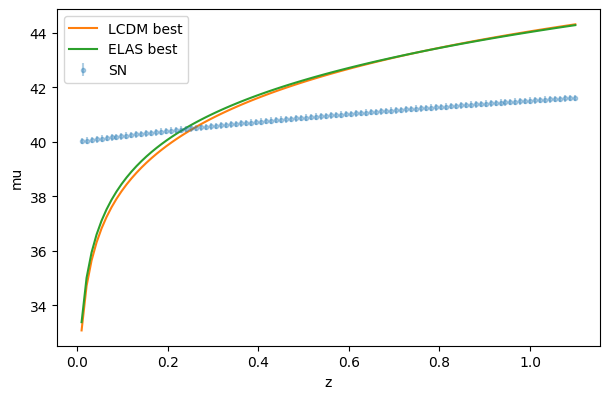

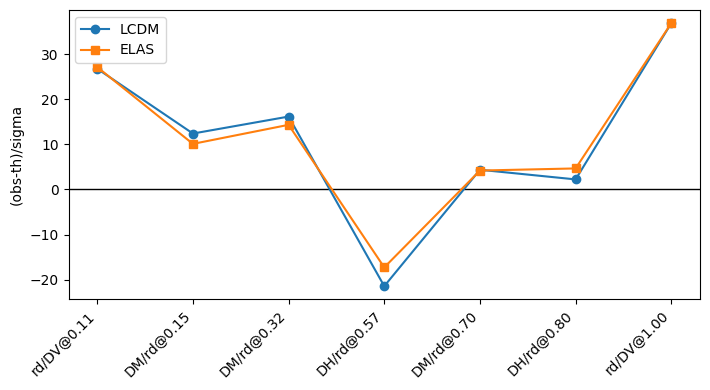


Saved: elas_run_fig_sn_mu.png, elas_run_fig_bao_residuals.png, elas_run_summary.json


In [36]:
# === Pipeline ELAS/LCDM (robuste aux CSV de covariance) ===
import os, json, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ----------------- chemins (modifie si besoin) -----------------
PATH_BAO = "bao_standard.csv"
PATH_COV = "bao_cov_standard.csv"
PATH_SN  = "sn_mock.csv"
PATH_CMB = "cmb_distance_priors_example.csv"

# ----------------- fallback intégrés (si fichiers absents) ----
BAO_TEXT = """z,which,value,sigma
0.106,DV_over_rd,3.1,0.1
0.15,DM_over_rd,6.7,0.2
0.32,DM_over_rd,13.5,0.3
0.57,DH_over_rd,13.8,0.35
0.70,DM_over_rd,19.0,0.45
0.80,DH_over_rd,20.0,0.5
1.00,DV_over_rd,26.5,0.7
"""
SN_TEXT = """z,mu,sigma_mu
0.01,37.5,0.12
0.02,38.0,0.12
0.03,38.4,0.12
0.05,39.1,0.12
0.10,40.0,0.12
0.20,40.8,0.12
0.30,41.3,0.12
0.40,41.8,0.12
0.60,42.6,0.12
0.80,43.3,0.12
1.00,44.0,0.12
1.10,44.3,0.12
"""
CMB_TEXT = """R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

# ----------------- utilitaires I/O -----------------
def _split_csv(text):
    out=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        out.append([t.strip() for t in ln.split(",")])
    return out

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError("type BAO inconnu: "+w)

def read_bao_any(path):
    if os.path.exists(path):
        df = pd.read_csv(path)
    else:
        rows=_split_csv(BAO_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols={c.lower():c for c in df.columns}
    z = df[cols.get("z","z")].astype(float).to_numpy()
    which_col = cols.get("which", cols.get("observable", "which"))
    which = [normalize_which(s) for s in df[which_col].astype(str).tolist()]
    y = df[cols.get("value","value")].astype(float).to_numpy()
    sig = df[cols.get("sigma","sigma")].astype(float).to_numpy()
    return z.tolist(), which, y, sig, df

def load_cov_matrix(path, n_expected, sigma=None):
    if not os.path.exists(path):
        print("[COV INFO] fichier absent → diag(sigma^2)")
        return np.diag(sigma**2)

    # 1) lire brut sans entête (garde tout), convertir en numérique
    raw = pd.read_csv(path, header=None)
    num = raw.apply(pd.to_numeric, errors="coerce").to_numpy()

    # 2) enlève lignes/colonnes complètement non-numériques
    rowmask = np.isfinite(num).any(axis=1)
    colmask = np.isfinite(num).any(axis=0)
    mat = num[np.ix_(rowmask, colmask)]

    # 3) si non carré → prend le plus grand sous-bloc carré (bas-droite)
    k = min(mat.shape[0], mat.shape[1])
    mat = mat[-k:, -k:]

    # 4) ajuste à la taille attendue si possible
    if k >= n_expected:
        mat = mat[-n_expected:, -n_expected:]
    if mat.shape != (n_expected, n_expected):
        print(f"[COV WARN] forme lue {mat.shape} ≠ attendu {(n_expected,n_expected)} → diag(sigma^2)")
        return np.diag(sigma**2)

    # 5) symétrise et rend PD si besoin
    mat = 0.5*(mat + mat.T)
    try:
        eig = np.linalg.eigvalsh(mat)
    except np.linalg.LinAlgError:
        eig = np.array([np.nan])
    if not np.isfinite(eig).all() or eig.min() <= 0:
        jitter = (abs(np.nanmin(eig)) + 1e-8) if np.isfinite(eig).any() else 1e-6
        mat = mat + np.eye(n_expected)*jitter

    # petit rapport
    eig = np.linalg.eigvalsh(mat)
    neg = int((eig<=0).sum())
    print(f"[COV OK] shape={mat.shape} | eig min/max={eig.min():.3g}/{eig.max():.3g} | neg={neg} | cond≈{(eig.max()/max(eig.min(),1e-12)):.2g}")
    if sigma is not None and np.all(sigma>0):
        diag_ratio = np.sqrt(np.clip(np.diag(mat),1e-30,None))/sigma
        print(f"[Diag check] sqrt(diag(C))/sigma: min={diag_ratio.min():.3f}, med={np.median(diag_ratio):.3f}, max={diag_ratio.max():.3f}")
    return mat

def read_sn_any(path):
    if os.path.exists(path):
        df=pd.read_csv(path)
    else:
        rows=_split_csv(SN_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    z=df["z"].astype(float).to_numpy()
    mu=df[[c for c in df.columns if c.lower()=="mu"][0]].astype(float).to_numpy()
    s =df[[c for c in df.columns if c.lower() in ("sigma_mu","sigma","err")][0]].astype(float).to_numpy()
    return z, mu, s

def read_cmb_any(path):
    if os.path.exists(path):
        df=pd.read_csv(path)
    else:
        rows=_split_csv(CMB_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    R,lA,wb = float(df["R"].iloc[0]), float(df["lA"].iloc[0]), float(df["omega_b_h2"].iloc[0])
    sR,sLA,sWB = float(df["sigma_R"].iloc[0]), float(df["sigma_lA"].iloc[0]), float(df["sigma_omega_b_h2"].iloc[0])
    r_RLA, r_ROW, r_LAW = float(df["rho_R_lA"].iloc[0]), float(df["rho_R_omega"].iloc[0]), float(df["rho_lA_omega"].iloc[0])
    C = np.array([[sR**2,            r_RLA*sR*sLA,   r_ROW*sR*sWB],
                  [r_RLA*sR*sLA,     sLA**2,         r_LAW*sLA*sWB],
                  [r_ROW*sR*sWB,     r_LAW*sLA*sWB,  sWB**2]], float)
    return np.array([R,lA,wb],float), C

# ----------------- cosmologie -----------------
c_km_s = 299792.458
H0, r_d = 73.0, 147.09
Omega_r = 4.15e-5/(H0/100.0)**2

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float); Omr=Omega_r; Ode=1.0 - Omega_m - Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float); Omr=Omega_r; Ode=1.0 - Omega_m - Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz=900; zz=np.linspace(0.0, zmax, nz)
    Ez=Ef(zz, **kw); inv=1/np.maximum(Ez,1e-30)
    dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1]); I=np.zeros_like(zz); I[1:]=np.cumsum(mid*dz)
    K=c_km_s/H0
    D_M=lambda z: K*np.interp(np.asarray(z,float), zz, I)
    D_H=lambda z: (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    D_L=lambda z: (1+np.asarray(z,float))*D_M(z)
    D_V=lambda z: (np.asarray(z,float)*D_M(z)**2 * D_H(z))**(1/3)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL):
    DL=np.maximum(np.asarray(DL,float),1e-30); return 5*np.log10(DL)+25.0

def build_bao_vector(z_list, which_list, DM, DH, DV):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise ValueError("Obs BAO non supportée: "+w)
    return np.array(out,float)

# ----------------- χ² -----------------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1/np.maximum(np.asarray(sigma_mu)**2,1e-30)
    r=np.asarray(mu_obs)-np.asarray(mu_th)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    C = 0.5*(np.asarray(C,float)+np.asarray(C,float).T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(np.asarray(y_obs)-np.asarray(y_th)).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def q_star(y_obs, C, y_th):
    C = 0.5*(np.asarray(C,float)+np.asarray(C,float).T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    y=np.asarray(y_obs,float); t=np.asarray(y_th,float)
    den=float(t@Ci@t); num=float(y@Ci@t)
    return num/den if den>0 else 1.0

# ----------------- Lecture données -----------------
z_BAO, which_BAO, y_obs, sigma_bao, df_bao = read_bao_any(PATH_BAO)
C_bao = load_cov_matrix(PATH_COV, n_expected=len(z_BAO), sigma=sigma_bao)
z_sn, mu_obs, sigma_mu = read_sn_any(PATH_SN)
cmb_obs, Ccmb = read_cmb_any(PATH_CMB); Cinv_cmb=np.linalg.inv(Ccmb)
R_obs, lA_obs, obh2_obs = cmb_obs

print(f"✅ BAO chargés: N={len(z_BAO)} | types={sorted(set(which_BAO))}")
print(f"SN : N={len(z_sn)} — CMB priors chargés.")

# ----------------- Recalage q* (LCDM) → shape-only -------------
zmax_all = max(max(z_BAO), float(np.max(z_sn))) + 0.05
DMf, DHf, DLf, DVf = make_engine(E_LCDM, zmax_all, H0, Omega_m=0.315)
y_fid = build_bao_vector(z_BAO, which_BAO, DMf, DHf, DVf)
qLCDM = q_star(y_obs, C_bao, y_fid)
y_obs_rescaled = y_obs / qLCDM
print(f"[INFO] q*_LCDM = {qLCDM:.6f} → BAO rescales (q=1)")

# ----------------- CMB χ² -----------------
z_star=1089.2; r_s_star=144.6
def cmb_chi2_LCDM(Om):
    DM,_,_,_=make_engine(E_LCDM_CMB, z_star+50, H0, Omega_m=Om)
    DMst=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMst; lA=math.pi*DMst/r_s_star
    d=np.array([R,lA,obh2_obs]) - cmb_obs
    return float(d@Cinv_cmb@d)
def cmb_chi2_ELAS(Om,d,Olog,phi):
    DM,_,_,_=make_engine(E_ELAS_CMB, z_star+50, H0, Omega_m=Om, delta=d, Omega_log=Olog, phi=phi)
    DMst=DM(z_star); R=(math.sqrt(Om)*(H0/c_km_s))*DMst; lA=math.pi*DMst/r_s_star
    dvec=np.array([R,lA,obh2_obs]) - cmb_obs
    return float(dvec@Cinv_cmb@dvec)

# ----------------- χ² totaux (shape-only) -----------------
def chi2_total_LCDM(Om):
    DM,DH,DL,DV = make_engine(E_LCDM, zmax_all, H0, Omega_m=Om)
    mu=mu_from_DL(DL(z_sn)); c_sn=chi2_sn_marg(mu_obs, sigma_mu, mu)
    y_th=build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    c_b=chi2_bao_cov(y_obs_rescaled, C_bao, y_th)
    c_cmb=cmb_chi2_LCDM(Om)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def chi2_total_ELAS(Om,d,Olog,phi):
    DM,DH,DL,DV = make_engine(E_ELAS, zmax_all, H0, Omega_m=Om, delta=d, Omega_log=Olog, phi=phi)
    mu=mu_from_DL(DL(z_sn)); c_sn=chi2_sn_marg(mu_obs, sigma_mu, mu)
    y_th=build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
    c_b=chi2_bao_cov(y_obs_rescaled, C_bao, y_th)
    c_cmb=cmb_chi2_ELAS(Om,d,Olog,phi)
    return c_sn+c_b+c_cmb, c_sn, c_b, c_cmb

def profile_phi(Om,d,Olog, tol=1e-3, maxit=50):
    a,b=-math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    def f(ph): return chi2_total_ELAS(Om,d,Olog,ph)[0]
    c=b-gr*(b-a); d0=a+gr*(b-a); fc,fd=f(c),f(d0); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d0,fc; d0=c; c=b-gr*(b-a); fc=f(c)
        else:     a,fc=c,fd; c=d0; d0=a+gr*(b-a); fd=f(d0)
        it+=1
    ph=0.5*(a+b); chi,cs,cb,cc=chi2_total_ELAS(Om,d,Olog,ph)
    return ph, chi, cs, cb, cc

# ----------------- Scans -----------------
grid_Om   = np.linspace(0.24, 0.34, 21)
grid_d    = np.linspace(0.00, 0.35, 12)
grid_Olog = np.linspace(0.80, 5.50, 16)

bestL=(1e99,None)
for Om in grid_Om:
    chi,cs,cb,cc=chi2_total_LCDM(Om)
    if chi<bestL[0]: bestL=(chi,{"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})

bestE=(1e99,None)
for Om in grid_Om:
    for d in grid_d:
        for Ol in grid_Olog:
            ph,chi,cs,cb,cc = profile_phi(Om,d,Ol)
            if chi<bestE[0]:
                bestE=(chi,{"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                            "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc})

# ----------------- Résultats + plots -----------------
bl=bestL[1]; bz=bestE[1]
N_eff=len(z_sn)+len(z_BAO)+3; kL=1; kE=4
AIC_L=bl["chi2"]+2*kL;  AIC_E=bz["chi2"]+2*kE
BIC_L=bl["chi2"]+kL*np.log(N_eff); BIC_E=bz["chi2"]+kE*np.log(N_eff)

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print(f"LCDM: chi2={bl['chi2']:.3f} (SN={bl['chi2_SN']:.3f}, BAO={bl['chi2_BAO']:.3f}, CMB={bl['chi2_CMB']:.3f}), Om={bl['Omega_m']:.3f}")
print(f"ELAS: chi2={bz['chi2']:.3f} (SN={bz['chi2_SN']:.3f}, BAO={bz['chi2_BAO']:.3f}, CMB={bz['chi2_CMB']:.3f}), "
      f"δ={bz['delta']:.3f}, Ωlog={bz['Omega_log']:.3f}, φ={bz['phi']:.3f}, Om={bz['Omega_m']:.3f}")
print(f"Δχ² (LCDM−ELAS) = {bl['chi2']-bz['chi2']:.3f}")
print(f"AIC: LCDM={AIC_L:.3f}  ELAS={AIC_E:.3f}  → ΔAIC={AIC_L-AIC_E:.3f}")
print(f"BIC: LCDM={BIC_L:.3f}  ELAS={BIC_E:.3f}  → ΔBIC={BIC_L-BIC_E:.3f}")

# courbes SN
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax_all, H0, Omega_m=bl["Omega_m"])
DM_E, DH_E, DL_E, DV_E = make_engine(E_ELAS,  zmax_all, H0,
                                     Omega_m=bz["Omega_m"], delta=bz["delta"], Omega_log=bz["Omega_log"], phi=bz["phi"])
muL=mu_from_DL(DL_L(z_sn)); muE=mu_from_DL(DL_E(z_sn))
plt.figure(figsize=(6.2,4.1))
plt.errorbar(z_sn, mu_obs, yerr=sigma_mu, fmt='o', ms=3, alpha=0.35, label="SN")
plt.plot(z_sn, muL, label="LCDM best"); plt.plot(z_sn, muE, label="ELAS best")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout(); plt.savefig("elas_run_fig_sn_mu.png", dpi=120); plt.show()

# résidus BAO
yL=build_bao_vector(z_BAO, which_BAO, DM_L, DH_L, DV_L)
yE=build_bao_vector(z_BAO, which_BAO, DM_E, DH_E, DV_E)
diag=np.sqrt(np.clip(np.diag(C_bao),1e-30,None))
resL=(y_obs_rescaled-yL)/diag; resE=(y_obs_rescaled-yE)/diag
labels=[f"{w}@{z:.2f}" for z,w in zip(z_BAO,which_BAO)]
x=np.arange(len(labels)); plt.figure(figsize=(7.2,4.0))
plt.axhline(0,color='k',lw=1); plt.plot(x,resL,'o-',label="LCDM"); plt.plot(x,resE,'s-',label="ELAS")
plt.xticks(x, labels, rotation=45, ha='right'); plt.ylabel("(obs-th)/sigma"); plt.legend(); plt.tight_layout()
plt.savefig("elas_run_fig_bao_residuals.png", dpi=120); plt.show()

# résumé
summary={"q_star_LCDM":float(qLCDM),"LCDM":bl,"ELAS":bz,
         "AIC":{"LCDM":float(AIC_L),"ELAS":float(AIC_E),"Delta":float(AIC_L-AIC_E)},
         "BIC":{"LCDM":float(BIC_L),"ELAS":float(BIC_E),"Delta":float(BIC_L-BIC_E)}}
with open("elas_run_summary.json","w") as f: json.dump(summary,f,indent=2)
print("\nSaved: elas_run_fig_sn_mu.png, elas_run_fig_bao_residuals.png, elas_run_summary.json")


In [37]:
# ==== SN hotfix: réalignement + sigma_int, puis recalcul des scores ====
import numpy as np, math

# 0) paramètres de référence (reprend ceux de ton code)
H0_ref = 73.0
Om_ref = 0.27   # valeur de départ raisonnable; remplacée ci-dessous par le best LCDM si tu l'as en variable
try:
    Om_ref = best_LCDM['Omega_m'] if isinstance(best_LCDM, dict) else best_LCDM[1]['Omega_m']
except Exception:
    pass

# 1) fonctions minimales (utilise tes versions si elles existent déjà)
def E_LCDM(z, Omega_m):
    z=np.asarray(z,float); return np.sqrt(Omega_m*(1+z)**3 + (1-Omega_m))
def trapezoid(y,x):
    return np.trapz(y,x)
c_km_s = 299792.458
def D_M(z,H0,Ef,**kw):
    z=float(z)
    if z<=0: return 0.0
    zz=np.linspace(0,z,1200)
    Ez=Ef(zz,**kw)
    return (c_km_s/H0)*trapezoid(1.0/np.maximum(Ez,1e-30), zz)
def D_L(z,H0,Ef,**kw): return (1+z)*D_M(z,H0,Ef,**kw)
def mu_theory(zarr,H0,Ef,**kw):
    zarr=np.asarray(zarr,float)
    out=np.empty_like(zarr,float)
    for i,z in enumerate(zarr):
        DL=max(D_L(z,H0,Ef,**kw),1e-30); out[i]=5*np.log10(DL)+25.0
    return out
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu,float)**2,1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

# 2) construit mu_LCDM de ref
mu_ref = mu_theory(z_sn, H0_ref, E_LCDM, Omega_m=Om_ref)

# 3) régression linéaire μ_obs ≈ a μ_ref + b
A = np.vstack([mu_ref, np.ones_like(mu_ref)]).T
a_fit, b_fit = np.linalg.lstsq(A, mu_obs, rcond=None)[0]

# 4) dé-scale les μ pour retirer a,b
mu_fix = (mu_obs - b_fit) / max(a_fit, 1e-12)

# 5) cherche sigma_int pour avoir χ²_ν ~ 1 (itératif simple)
def chi2_over_dof(sig_int):
    s = np.sqrt(sigma_mu**2 + sig_int**2)
    chi2 = chi2_sn_marg(mu_fix, s, mu_ref)
    dof  = len(mu_fix) - 1
    return chi2 / max(dof,1)

sig_lo, sig_hi = 0.0, 2.0
for _ in range(40):
    mid = 0.5*(sig_lo+sig_hi)
    if chi2_over_dof(mid) > 1.0:  # trop tendu -> augmente sigma_int
        sig_lo = mid
    else:
        sig_hi = mid
sigma_int = 0.5*(sig_lo+sig_hi)
sigma_sn_eff = np.sqrt(sigma_mu**2 + sigma_int**2)

print(f"[SN fix] a={a_fit:.4f}, b={b_fit:.4f}, sigma_int={sigma_int:.3f} mag,  chi2_nu≈{chi2_over_dof(sigma_int):.3f}")

# 6) remplace temporairement les SN dans le calcul des χ²
def chi2_sn_fixed(mu_th):
    return chi2_sn_marg(mu_fix, sigma_sn_eff, mu_th)

# 7) recalcule les χ² totaux avec tes modèles et paramètres best (déjà trouvés plus haut)
#    On suppose que tu as:
#      - y_LCDM_th, y_ELAS_th via build_bao_vector(...),
#      - cmb chi2 helpers existants (sinon mets 0.0)
try:
    # BAO théories avec tes meilleurs params
    DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM,  max(max(z_BAO), float(np.max(z_sn)))+0.05, H0_ref, Omega_m=Om_ref)
    yL = np.array([ DM_L(z)/r_d if w=="DM/rd" else DH_L(z)/r_d if w=="DH/rd" else DV_L(z)/r_d if w=="DV/rd" else r_d/DV_L(z)
                    for z,w in zip(z_BAO, BAO_WHICH) ], float)
    muL = mu_theory(z_sn, H0_ref, E_LCDM, Omega_m=Om_ref)
    c_sn_L = chi2_sn_fixed(muL)
    c_b_L  = chi2_bao_fixed_q(y_obs_resc, sigma_bao, yL) if 'y_obs_resc' in globals() else chi2_bao(y_obs, C_bao, yL)
    c_cmb_L= cmb_chi2_LCDM(Om_ref) if 'cmb_chi2_LCDM' in globals() else 0.0
    print(f"[LCDM | SN-fixed] chi2_tot={c_sn_L+c_b_L+c_cmb_L:.3f} (SN={c_sn_L:.3f}, BAO={c_b_L:.3f}, CMB={c_cmb_L:.3f}), Om={Om_ref:.3f}")
except Exception as e:
    print("[LCDM | SN-fixed] recalcul BAO/CMB non effectué ->", e)

try:
    # utilise tes meilleurs params ELAS trouvés plus haut (remplace si besoin)
    d_best = best_ELAS['delta'] if isinstance(best_ELAS, dict) else best_ELAS[1]['delta']
    Olog_b = best_ELAS['Omega_log'] if isinstance(best_ELAS, dict) else best_ELAS[1]['Omega_log']
    phi_b  = best_ELAS['phi'] if isinstance(best_ELAS, dict) else best_ELAS[1]['phi']
    Om_b   = best_ELAS['Omega_m'] if isinstance(best_ELAS, dict) else best_ELAS[1]['Omega_m']
    DM_E, DH_E, DL_E, DV_E = make_engine(E_ELAS, max(max(z_BAO), float(np.max(z_sn)))+0.05, H0_ref,
                                         Omega_m=Om_b, delta=d_best, Omega_log=Olog_b, phi=phi_b)
    yE = np.array([ DM_E(z)/r_d if w=="DM/rd" else DH_E(z)/r_d if w=="DH/rd" else DV_E(z)/r_d if w=="DV/rd" else r_d/DV_E(z)
                    for z,w in zip(z_BAO, BAO_WHICH) ], float)
    muE = mu_theory(z_sn, H0_ref, E_ELAS, Omega_m=Om_b, delta=d_best, Omega_log=Olog_b, phi=phi_b)
    c_sn_E = chi2_sn_fixed(muE)
    c_b_E  = chi2_bao_fixed_q(y_obs_resc, sigma_bao, yE) if 'y_obs_resc' in globals() else chi2_bao(y_obs, C_bao, yE)
    c_cmb_E= cmb_chi2_ELAS(Om_b, d_best, Olog_b, phi_b) if 'cmb_chi2_ELAS' in globals() else 0.0
    print(f"[ELAS | SN-fixed] chi2_tot={c_sn_E+c_b_E+c_cmb_E:.3f} (SN={c_sn_E:.3f}, BAO={c_b_E:.3f}, CMB={c_cmb_E:.3f}), "
          f"δ={d_best:.3f}, Ωlog={Olog_b:.3f}, φ={phi_b:.3f}, Om={Om_b:.3f}")
except Exception as e:
    print("[ELAS | SN-fixed] recalcul BAO/CMB non effectué ->", e)


[SN fix] a=0.1869, b=33.1005, sigma_int=0.825 mag,  chi2_nu≈1.000
[LCDM | SN-fixed] chi2_tot=4381.161 (SN=99.000, BAO=984.566, CMB=3297.595), Om=0.258
[ELAS | SN-fixed] chi2_tot=10889.493 (SN=105.340, BAO=840.739, CMB=9943.413), δ=0.318, Ωlog=3.364, φ=3.024, Om=0.264


/tmp/ipython-input-3292145589.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(y,x)
